In [840]:
import proteomic_funcs
import importlib
importlib.reload(proteomic_funcs)
from proteomic_funcs import *

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# Preprocessing

## Reading in Proteomics

Proteomics stored in .csv format from assay acquisition, separating Plex4 and Ptau

In [2]:
cd /data/biobank/Proteomics/process

/data/biobank/Proteomics/process


In [3]:
Plex4 = pd.read_csv('4plexE_all_plates_eid.csv')
Plex4.loc[Plex4['spike']=='FALSE ','spike']=False
Plex4.loc[Plex4['spike']=='TRUE ','spike']=True


In [4]:
ptau = pd.read_csv('pTau-181_all_plates_eid.csv')
ptau.loc[ptau['spike']=='FALSE ','spike']=False
ptau.loc[ptau['spike']=='TRUE ','spike']=True

In [5]:
Plex4.loc[Plex4['SampleID'].str[-1:]=='1','Session']='1'
Plex4.loc[Plex4['SampleID'].str[-1:]=='a','Session']='a'

In [6]:
ptau.loc[ptau['SampleID'].str[-1:]=='1','Session']='1'
ptau.loc[ptau['SampleID'].str[-1:]=='a','Session']='a'

In [7]:
Plex4_spike=Plex4[Plex4['spike']==True]
Plex4=Plex4[Plex4['spike']==False]

In [8]:
ptau_spike=ptau[ptau['spike']==True]
ptau=ptau[ptau['spike']==False]

In [9]:
# remove singletons
for a in Plex4['eid']:
    if len(Plex4[(Plex4['eid']==a) & (Plex4['spike']==False)])!=2:
        print(a)
        Plex4=Plex4[Plex4['eid']!=a]
        ptau=ptau[ptau['eid']!=a]
for a in ptau['eid']:
    if len(ptau[(ptau['eid']==a) & (ptau['spike']==False)])!=2:
        Plex4=Plex4[Plex4['eid']!=a]
        ptau=ptau[ptau['eid']!=a]
        
# remove potentially mislabelled samples
for a in [339983033,339983037]:
    Plex4=Plex4[Plex4['VacutainerID']!=a]
    ptau=ptau[ptau['VacutainerID']!=a]
    

1143054
5655812
1777711
5385993


In [10]:
all_prot=pd.concat([ptau,Plex4],axis=1)
all_prot = all_prot.loc[:,~all_prot.columns.duplicated()]


In [11]:
# rename proteins
all_prot =all_prot.rename(columns={'Neurology 4plexE AB42 pg/ml Replicate 1':'Ab42','Neurology 4plexE AB40 pg/ml Replicate 1':'Ab40','Neurology 4plexE NFL pg/ml Replicate 1' : 'NfL' , 'Neurology 4plexE GFAP pg/ml Replicate 1' : 'GFAP', 'pTau-181 pg/ml Replicate 1' : 'pTau-181' })


### Preprocess Proteomics: log, regress plateID

In [12]:
# Non A-beta assays have skewed distributions - taking logs 

for a in ['GFAP','NfL','pTau-181']:
    all_prot.loc[:,a+'_orig'] = all_prot.loc[:,a]
    all_prot.loc[:,a] = np.log(all_prot.loc[:,a] )

# remove outliers 
for a in ['Ab42','Ab40','GFAP','NfL','pTau-181']:
    all_prot.loc[:,a]=remove_outliers(all_prot.loc[:,a])
   
for  a in ['GFAP','NfL','pTau-181']:
    all_prot.loc[all_prot.loc[:,a]==np.nan,a+'orig']=np.nan   
    
    
# regress plate ID
for a in ['Ab42','Ab40','GFAP','NfL','pTau-181']:
    mod=smf.ols(formula="  (Q('"+a+"'))  ~  C(PlateID)   ", data=all_prot).fit()
    all_prot.loc[:,a+'_regPl']=all_prot.loc[:,a]-(mod.fittedvalues-np.mean(mod.fittedvalues))
    all_prot.loc[:,a+'_orig_regPl']=np.exp(all_prot.loc[:,a+'_regPl'])
                 
#for a in ['Ab42','Ab40','GFAP','NfL','pTau-181']
# ratio 
all_prot.loc[:,'Ab42/Ab40']=all_prot['Ab42']/all_prot['Ab40']
all_prot.loc[:,'Ab42/Ab40_regPl']=all_prot['Ab42_regPl']/all_prot['Ab40_regPl']
all_prot_pre=(all_prot[all_prot['Session']=='a']).sort_values('eid').add_suffix('_pre')
all_prot_post=(all_prot[all_prot['Session']=='1']).sort_values('eid').add_suffix('_post')
all_prot_pre=all_prot_pre.set_index('eid_pre')
all_prot_post=all_prot_post.set_index('eid_post')
proteomics=pd.concat([all_prot_pre,all_prot_post],axis=1)

In [13]:
# bunch of helper variables
prot_els=['Ab42/Ab40','pTau-181','NfL','GFAP','Ab42','Ab40']
prot_els_pre =  [ x+'_pre' for x in prot_els]
prot_els_post = [ x+'_post' for x in prot_els]
prot_els_all = prot_els_pre + prot_els_post
prot_els_regPl =  [ x+'_regPl' for x in prot_els]
prot_els_regPl_pre =  [ x+'_pre' for x in prot_els_regPl]
prot_els_regPl_post = [ x+'_post' for x in prot_els_regPl]
prot_els_regPl_pre_cl =  [ x+'_pre_cl' for x in prot_els_regPl]
prot_els_regPl_post_cl = [ x+'_post_cl' for x in prot_els_regPl]
prot_els_all_regPl = prot_els_regPl_pre + prot_els_regPl_post
#prot_els_regPl = prot_els_regPl_pre + prot_els_regPl_post

## Read in Phenotypic , Genetic Data

In [14]:
# load phenotypic data
# merged_subjsO.csv is a merged file of all subjects with proteomics data across all baskets for project.
pheno= pd.read_csv('../../phenotype/merged_subjsO.csv',low_memory=False)
pheno = pheno.set_index('eid')
# bbd translates from biobank variables to more readable names
bbd={'AlzPRS':'26206','BP_sys':'4080','BP_dia':'4079','Activity':'22034','Weight':'21002','Alcohol':'1558','BMI':'21001',"gSex":'22001-0.0'}

In [15]:
## Load in Genetics
# focusing on APOE for this study.
genetics = pd.read_csv('../../genotyping/APOE_genotyping_ED.raw',delimiter='\t')
genetics=genetics.rename(columns={'FID':'eid'})
genetics=genetics.drop(columns={'PAT','MAT','PHENOTYPE','IID'})
genetics = genetics.set_index('eid')

# Some additional Genetic Variants
variants = pd.read_csv('../../genotyping/Genes.csv')
variants = variants.rename(columns={"IID":"eid"})
variants=variants.drop('SEX',axis=1)
variants = variants.set_index('eid')
#variants=variants.drop('SEX',axis=1)
variants_cols = list(variants.columns)



In [16]:
# add some variations of variants

genetics.loc[:,'APOE']=np.NaN
genetics.loc[(genetics['rs7412_T']==0) & (genetics['rs429358_C']==0),'APOE']='A3A3'
genetics.loc[(genetics['rs7412_T']==0) & (genetics['rs429358_C']==1),'APOE']='A3A4'
genetics.loc[(genetics['rs7412_T']==0) & (genetics['rs429358_C']==2),'APOE']='A4A4'
genetics.loc[(genetics['rs7412_T']==1) & (genetics['rs429358_C']==0),'APOE']='A3A2'
genetics.loc[(genetics['rs7412_T']==2) & (genetics['rs429358_C']==0),'APOE']='A2A2'
# counts of A4
genetics.loc[:,'A4']=np.NaN
genetics.loc[genetics.loc[:,'APOE']=='A4A4','A4']=2
genetics.loc[genetics.loc[:,'APOE']=='A3A4','A4']=1
genetics.loc[genetics.loc[:,'APOE']=='A3A3','A4']=0
genetics.loc[genetics.loc[:,'APOE']=='A3A2','A4']=0
genetics.loc[genetics.loc[:,'APOE']=='A2A2','A4']=0
# counts of A2
genetics.loc[:,'A2']=np.NaN
genetics.loc[genetics.loc[:,'APOE']=='A4A4','A2']=0
genetics.loc[genetics.loc[:,'APOE']=='A3A4','A2']=0
genetics.loc[genetics.loc[:,'APOE']=='A3A3','A2']=0
genetics.loc[genetics.loc[:,'APOE']=='A3A2','A2']=1
genetics.loc[genetics.loc[:,'APOE']=='A2A2','A2']=2
genetics.loc[:,'APOE_score']=genetics.loc[:,'A4']-genetics.loc[:,'A2']
genetics.loc[:,'A4_bin']=genetics.loc[:,'A4']>0
genetics.loc[:,'A33vA34']=0
genetics.loc[genetics.loc[:,'APOE']=='A3A4','A33vA34']=0.5
genetics.loc[genetics.loc[:,'APOE']=='A3A3','A33vA34']=-0.5
genetics.loc[:,'A33vA44']=0
genetics.loc[genetics.loc[:,'APOE']=='A4A4','A33vA44']=0.5
genetics.loc[genetics.loc[:,'APOE']=='A3A3','A33vA44']=-0.5


A4=( ((genetics.loc[:,'APOE']=='A3A4') | (genetics.loc[:,'APOE']=='A3A4')))

In [878]:
data.loc[:,'A33vA34']=np.nan
data.loc[data.loc[:,'APOE']=='A3A4','A33vA34']=0.5
data.loc[data.loc[:,'APOE']=='A3A3','A33vA34']=-0.5
data['A33vA34']=(data['A33vA34']-data['A33vA34'].mean())
data.loc[data['A33vA34'].isna(),'A33vA34']=0
#data['A33vA34']=data['A33vA34']/np.std(data['A33vA34'])
data.loc[:,'A33vA44']=np.nan
data.loc[data.loc[:,'APOE']=='A4A4','A33vA44']=0.5
data.loc[data.loc[:,'APOE']=='A3A3','A33vA44']=-0.5
data['A33vA44']=data['A33vA44']-data['A33vA44'].mean()
data.loc[data['A33vA44'].isna(),'A33vA44']=0
#data['A33vA44']=data['A33vA44']/np.std(data['A33vA44'])


In [695]:
# merge proteomics, pheno, genetics
data= pd.merge(proteomics, pheno, how='right',left_index=True, right_index=True)
data= pd.merge(data, variants,how='left', left_index=True, right_index=True,suffixes=("_x",None))
data= pd.merge(data, genetics,how='left', left_index=True, right_index=True,suffixes=("_x",None))
data=data.copy()

## Removing people withdrawn from UK Biobank 

In [696]:
withdrawals=pd.read_csv('../../withdrawal-76059_2023-04-25.csv',header=None)
np.array([ a in data.index for a in withdrawals[0]]).sum()

0

## Additional data and helper columns from biobank 

In [697]:
# find_vars fine case / control variable
data_case=data.loc[(np.mod(data.loc[:,'41000-3.0'],10)==1) ,['41000-3.0']]
data_case=data_case-1
data_case=data_case.reset_index()
data_case=data_case.rename(columns={'eid':'case'})
data_control=data.loc[(np.mod(data.loc[:,'41000-3.0'],10)==0) ,['41000-3.0']]
data_control=data_control.reset_index()
data_control=data_control.rename(columns={'eid':'control'})

data.loc[:,'Case']='sars'
data.loc[data_control['control'],'Case']='ctr'

# numeric versions of Case/Ctr
data.loc[data.loc[:,'Case']=='sars','Case_bin']=1
data.loc[data.loc[:,'Case']=='ctr','Case_bin']=0

# Identify matched case/controls

cc_els=pd.merge(data_case,data_control,on='41000-3.0')
data.loc[:,'matched']=False
data.loc[np.concatenate([cc_els['case'].values , cc_els['control'].values]),'matched']=True

#SIMOA_matched=(data.loc[:,'matched']==True) &  )

all_case=data.loc[:,'Case']=='sars'
all_control=data.loc[:,'Case']=='ctr'

# matched excluding missing data for each assay

matched={}

for a in ['Ab42/Ab40','pTau-181','NfL','GFAP','Ab42','Ab40']:
    case_present=data.loc[cc_els['case'],[a+'_pre',a+'_post']].notnull().all(axis=1).values
    control_present=data.loc[cc_els['control'],[a+'_pre',a+'_post']].notnull().all(axis=1).values
    matched[a]=(case_present & control_present)
    print(a + ' ' + str(np.sum(matched[a])))
    data.loc[:,a+'_matched']=False
    data.loc[pd.concat([cc_els.loc[matched[a],'case'],cc_els.loc[matched[a],'control']]),a+'_matched']=True

data['all_prot_matched']=data.loc[:,[ a + '_matched' for a in ['Ab42/Ab40','pTau-181','NfL','GFAP']]].all(axis=1)
all_matched=data.loc[:,[ a + '_matched' for a in ['Ab42/Ab40','pTau-181','NfL','GFAP']]].any(axis=1)
matched_case=all_matched & all_case

#
data.loc[cc_els['case'],'matched_eid']=cc_els['control'].values.astype(int)
data.loc[cc_els['control'],'matched_eid']=cc_els['case'].values.astype(int)

groupby = 'Case'
group='sars'
dd=data.loc[all_matched,['matched_eid','Gender_pre','Case']]
ids_case = dd[dd[groupby]==group].index
ids_ctr = dd.loc[ids_case,'matched_eid']

Ab42/Ab40 614
pTau-181 610
NfL 619
GFAP 620
Ab42 617
Ab40 615


In [698]:

# Times

data.loc[:,'date_post']=pd.to_datetime(data.loc[:,'53-3.0'])
data.loc[:,'date_pre']=pd.to_datetime(data.loc[:,'53-2.0']) 
data.loc[:,'date_1']=pd.to_datetime(data.loc[:,'53-1.0']) 
data.loc[:,'date_0']=pd.to_datetime(data.loc[:,'53-0.0'])                                    
data.loc[:,'assessment_sep_d']=(data.loc[:,'date_post'] - data.loc[:,'date_pre'])#/ np.timedelta64(1, 'M')
data.loc[:,'assessment_sep']=data.loc[:,'assessment_sep_d'].dt.days
data.loc[:,'assessment_sep_m']=((data.loc[:,'date_post'] - data.loc[:,'date_pre'])/ np.timedelta64(1, 'M')).astype(int)
data.loc[:,'assessment_sep^2']=data.loc[:,'assessment_sep']**2

data.loc[:,'DOB'] = pd.to_datetime(data.loc[:,'52-0.0'].astype('int').astype('str')+'/'+data.loc[:,'34-0.0'].astype('int').astype('str'))
data.loc[:,'Age-3.0_d']=(data.loc[:,'date_post'] - data.loc[:,'DOB'])
data.loc[:,'Age-2.0_d']=(data.loc[:,'date_pre'] - data.loc[:,'DOB'])
data.loc[:,'Age-1.0_d']=(data.loc[:,'date_1'] - data.loc[:,'DOB'])
data.loc[:,'Age-0.0_d']=(data.loc[:,'date_0'] - data.loc[:,'DOB'])
data.loc[:,'Age-3.0']=data.loc[:,'Age-3.0_d'].dt.days/365
data.loc[:,'Age-2.0']=data.loc[:,'Age-2.0_d'].dt.days/365
data.loc[:,'Age-1.0']=data.loc[:,'Age-1.0_d'].dt.days/365
data.loc[:,'Age-0.0']=data.loc[:,'Age-0.0_d'].dt.days/365
data.loc[:,'Age-3.0^2']=(data.loc[:,'Age-3.0']-50)**2
data.loc[:,'Age-2.0^2']=data.loc[:,'Age-2.0']**2

# Age modulated regressor
data.loc[:,'Age-2.0_fc']=10**(data.loc[:,'Age-2.0']*0.0524-3.27)*data['Case_bin']/(10**(data.loc[:,'Age-3.0']*0.0524-3.27)).max()
data.loc[:,'Age-3.0_fc']=10**(data.loc[:,'Age-3.0']*0.0524-3.27)*data['Case_bin']/(10**(data.loc[:,'Age-3.0']*0.0524-3.27)).max()

# Mean age-matched
data.loc[data.loc[cc_els['case'],'matched_eid'],'matched_age_mean']= 0.5*(data.loc[data.loc[cc_els['case'],'matched_eid'],'Age-3.0'].values + data.loc[cc_els['case'],'Age-3.0'].values)
data.loc[cc_els['case'],'matched_age_mean']= 0.5*(data.loc[data.loc[cc_els['case'],'matched_eid'],'Age-3.0'].values + data.loc[cc_els['case'],'Age-3.0'].values)

# COVID sensitivity modulaated regressor
dm=10**(data.loc[:,'Age-2.0']*0.0524-3.27)
data.loc[:,'Age-2.0_f']=dm/np.mean(dm)
dm=10**(data.loc[:,'Age-3.0']*0.0524-3.27)
data.loc[:,'Age-3.0_f']=dm/np.mean(dm)

# Health data

data.loc[:,'Hip/Waist-2.0']=data.loc[:,'49-2.0'] / data.loc[:,'48-2.0']
data.loc[:,'Hip/Waist-3.0']=data.loc[:,'49-3.0'] / data.loc[:,'48-3.0']
data.loc[:,'Smoking-2.0']=data.loc[:,'1239-2.0']
data.loc[data.loc[:,'Smoking-2.0']==-3,'Smoking-2.0']=np.nan
data.loc[:,'Smoking-3.0']=data.loc[:,'1239-3.0']
data.loc[data.loc[:,'Smoking-3.0']==-3,'Smoking-3.0']=np.nan
data['Smoking_bin-2.0']=data['Smoking-2.0']>0
data['Smoking_bin-3.0']=data['Smoking-3.0']>0

data.loc[:,'Alcohol-2.0']=data['1558-2.0']
data.loc[data.loc[:,'Alcohol-2.0']<0,'Alcohol-2.0']=np.nan
data.loc[:,'Alcohol-2.0']=   6-data.loc[:,'Alcohol-2.0']
data.loc[:,'Alcohol-3.0']=data['1558-3.0']
data.loc[data.loc[:,'Alcohol-3.0']<0,'Alcohol-3.0']=np.nan
data.loc[:,'Alcohol-3.0']=   6-data.loc[:,'Alcohol-3.0']
data.loc[:,'Obesity-2.0'] = data['21001-2.0']>30
data.loc[:,'Obesity-3.0'] = data['21001-3.0']>30                                             
                                                 
data.loc[:,'Deprivation'] = data.loc[:,'26410-0.0'].fillna(data.loc[:,'26427-0.0']).fillna(data.loc[:,'26426-0.0'])

data.loc[:,'Ethnicity(White)']=(np.mod(data.loc[:,'21000-0.0'],1000)==1.0).astype(int)


data.loc[:,'KeyWorker'] = ~data.loc[:,'28063-0.0'].isnull()
data.loc[:,'WorkingThroughCOVID'] = ((data.loc[:,'28057-0.0'] == 1) | (data.loc[:,'28057-0.0'] == 1) | (data.loc[:,'28057-0.0'] == 8) )
data.loc[:,'Diabetes'] = np.logical_or.reduce(data.loc[:,find_vars(data,'^2443-')]==1,axis=1)
# Cholestoral and BP 
data.loc[:,'Chol_meds']=np.logical_or.reduce(data.loc[:,find_vars(data,'^6153-')]==1,axis=1)
data.loc[:,'BP_meds']=np.logical_or.reduce(data.loc[:,find_vars(data,'^6153-')]==2,axis=1)
data.loc[:,'Heart_Cond']=np.logical_or.reduce(data.loc[:,find_vars(data,'^6150-')]>0,axis=1)


data['Wheeze-2.0']=data['2316-2.0']==1
data.loc[data['2316-2.0']<0,'Wheeze-2.0']=np.nan
data['Wheeze-3.0']=data['2316-3.0']==1
data.loc[data['2316-3.0']<0,'Wheeze-3.0']=np.nan
data['Wheeze-3.0'].unique()

data['HandGrip-2.0']=(data['46-2.0']+data['47-2.0'])/2
data['HandGrip-3.0']=(data['46-3.0']+data['47-3.0'])/2

data['GeneralHealth-2.0']=5-data['2178-2.0']
data.loc[data['2178-2.0']<0,'GeneralHealth-2.0']=np.nan
data['GeneralHealth-3.0']=5-data['2178-3.0']
data.loc[data['2178-3.0']<0,'GeneralHealth-3.0']=np.nan

data['Activity-2.0']=data['894-2.0']
data.loc[data['894-2.0']<0,'Activity-2.0']=np.nan
data.loc[data['894-2.0']>400,'Activity-2.0']=np.nan

data['Activity-2.0']=data['894-2.0']
data.loc[data['894-2.0']<0,'Activity_levels-2.0']=np.nan
data.loc[data['894-2.0']>0,'Activity_levels-2.0']='Low'
data.loc[data['894-2.0']>40,'Activity_levels-2.0']='Medium'
data.loc[data['894-2.0']>100,'Activity_levels-2.0']='High'

data['Activity-3.0']=data['894-3.0']
data.loc[data['894-3.0']<0,'Activity-3.0']=np.nan
data.loc[data['894-3.0']>400,'Activity-3.0']=np.nan


<ipython-input-698-0ff57c0acd3b>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data.loc[:,'DOB'] = pd.to_datetime(data.loc[:,'52-0.0'].astype('int').astype('str')+'/'+data.loc[:,'34-0.0'].astype('int').astype('str'))


In [699]:
data.loc[:,'Diabetes']

eid
1001193    False
1005523    False
1014449    False
1024229    False
1037025    False
           ...  
6015180     True
6016344    False
6018823    False
6022672    False
6023438    False
Name: Diabetes, Length: 1557, dtype: bool

In [700]:
# apply cleaning to proteomics 

prot_els_cl=[ a + '_regPl_diff_cl' for a in prot_els]

for a in prot_els_regPl:
    out = remove_conf(data,a,[],flatten=True,suf_pre=True,remove_out=True,suf=False)
    data.loc[:,a+'_pre_cl'] = out[a+'_pre_cl']
    data.loc[:,a+'_post_cl'] = out[a+'_post_cl']

    data.loc[:,a+'_diff_cl'] = data[a+'_post_cl']-data[a+'_pre_cl']
    data.loc[:,a+'_pc_cl'] = 100*data[a+'_diff_cl']/data[a+'_pre_cl']

# # apply neuroimaging cleaning to proteomics 
# CONF=['Age-3.0_f','assessment_sep','assessment_sep^2','Ethnicity(White)','22001-0.0']
# for a in prot_els_regPl:
#     out = remove_conf(data,a,CONF,flatten=True,suf_pre=True,remove_out=True,suf=False)
#     data.loc[:,a+'_pre_cl'] = out[a+'_pre_cl']
#     data.loc[:,a+'_post_cl'] = out[a+'_post_cl']

#     data.loc[:,a+'_diff_cl'] = data[a+'_post_cl']-data[a+'_pre_cl']
#     data.loc[:,a+'_pc_cl'] = 100*data[a+'_diff_cl']/data[a+'_pre_cl']

var_names=['Age (pre)','Age (post)','Sex','Assessment gap (months)','BP (sys) - pre ','BP (dia) - pre','BP_meds','Weight (pre)','Hip/Waist (pre)','BMI (pre)','Alcohol Intake Freq','Smoking','Education','Multiple Deprivation','Diabetes','Chol_meds','Income','Number Household','Ethnicity(White)','Key Worker','Working through COVID','Cognition_pre','Memory_pre','Activity','General_health (pre)','WMH_pre','WHM_post']
vars=['Age-2.0','Age-3.0','Gender_pre','assessment_sep','4080-2.0','4079-2.0','BP_meds','21002-2.0','Hip/Waist-2.0','21001-2.0','Alcohol-2.0','Smoking-2.0','845-2.0','Deprivation','Diabetes','Chol_meds','738-2.0','709-2.0','Ethnicity(White)','KeyWorker','WorkingThroughCOVID','6350-2.0','20018-2.0','22034-0.0','2178-2.0','25781-2.0','25781-3.0']

# Weight, Waist Circ, Hip Circ, BMI, BPdia, BPsys, SMOKING, Alcohol, Diabetes, Chol_med, BP_meds
['21002-2.0','48-2.0','49-2.0','21001-2.0','4079-2.0', '4080-2.0', 'Smoking-3.0','Alcohol-2.0','Diabetes','Chol_meds','BP_meds']

# dementia 
data.loc[(data.loc[:,'42018-0.0'].notnull()),'Ab42/Ab40_pre']

eid
1458468    0.080638
5830349    0.068051
Name: Ab42/Ab40_pre, dtype: float64

In [701]:
data['Activity-2.0']=data['894-2.0']
data.loc[data['894-2.0']<0,'Activity-2.0']=np.nan
data['Activity-3.0']=data['894-3.0']
data.loc[data['894-3.0']<0,'Activity-3.0']=np.nan
data.loc[all_matched,'date_pre'].max()

Timestamp('2020-03-13 00:00:00')

## Reported Disease codes

In [702]:

disease_codes=(data[(find_vars(data,'20002-2'))].values.flatten())
disease_codes=disease_codes[~pd.isnull(disease_codes)]
codes_counts=(pd.Series((disease_codes))).value_counts()
codes_counts=codes_counts[codes_counts>20].drop(99999.0)
codes_counts.index=codes_counts.index.astype(int)
for a in codes_counts.index:
    data.loc[:,'dc_'+str(int(a))]=(data[find_vars(data,'20002-2')]==a).any(axis=1)

disease_codes_names=pd.read_csv('/data/biobank/phenotype/disease_codes.tsv',sep='\t',header=None)
disease_codes_names.set_index(0,inplace=True)
disease_codes_names.rename(columns={1:'name'},inplace=True)

data=data.copy()    


<ipython-input-702-ac81d6192a4f>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:,'dc_'+str(int(a))]=(data[find_vars(data,'20002-2')]==a).any(axis=1)
<ipython-input-702-ac81d6192a4f>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:,'dc_'+str(int(a))]=(data[find_vars(data,'20002-2')]==a).any(axis=1)
<ipython-input-702-ac81d6192a4f>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

In [703]:
data['diabetes']=(data[(find_vars(data,'20002-2'))]==1223).any(axis=1)
data['cardiovascular']=(data[(find_vars(data,'20002-2'))]==1071).any(axis=1)
data['hypertension']=(data[(find_vars(data,'20002-2'))]==1065).any(axis=1)
data['depression']=(data[(find_vars(data,'20002-2'))]==1312).any(axis=1)
data['cholesterol']=(data[(find_vars(data,'20002-2'))]==1536).any(axis=1)
data['headinjury']=(data[(find_vars(data,'20002-2'))]==1292).any(axis=1)
data['renal']=(data[(find_vars(data,'20002-2'))]==1074).any(axis=1)


In [704]:
# count missing data 
# missing data is subjects with *any* missing proteomic data
#missing_data=data.loc[:,prot_els_all].notna().sum(axis=1)<12
#matched_ids=data.loc[missing_data,'matched_eid']
#complete_data=~missing_data & all_matched
#complete_data_matched=complete_data.copy()
#complete_data_matched[matched_ids]=False
#complete_data_matched.sum()/2

## COVID reports

In [705]:
# process records of COVID

data.loc[:,'GP']=((data.loc[all_case,['41001-3.0','41001-3.1','41001-3.2','41001-3.3']])==2).any(axis=1)
data.loc[:,'HES']=((data.loc[all_case,['41001-3.0','41001-3.1','41001-3.2','41001-3.3']])==1).any(axis=1)
data.loc[:,'PCR']=((data.loc[all_case,['41001-3.0','41001-3.1','41001-3.2','41001-3.3']])==3).any(axis=1)
data.loc[:,'Lateral']=((data.loc[all_case,['41001-3.0','41001-3.1','41001-3.2','41001-3.3']])==4).any(axis=1)
data.loc[:,'PublicHealthRecord']=(data.loc[:,'HES'])|(data.loc[:,'GP'])

# characterise individuals only identified by antibody test (no reported symptoms)

data.loc[:,'COVID'] = np.nan
els = all_matched & all_case & (data.loc[:,['HES','PCR','GP']].sum(axis=1)==0)  & (data.loc[:,'Lateral']==True)
data.loc[els,'COVID'] = 'SARS'
data.loc[data.loc[els,'matched_eid'].dropna(),'COVID'] = 'SARS_ctr'
els = all_case & (data.loc[:,['HES','PCR','GP']].sum(axis=1)>0)  
data.loc[els,'COVID'] = 'COVID'
data.loc[data.loc[els,'matched_eid'].dropna(),'COVID'] = 'COVID_ctr'

# load up reginal  COVID reports
England = pd.read_csv('/data/biobank/phenotype/covid19_result_england.txt', sep='\t')
Scotland = pd.read_csv('/data/biobank/phenotype/covid19_result_scotland.txt', sep='\t')
Wales = pd.read_csv('/data/biobank/phenotype/covid19_result_wales.txt', sep='\t')

print(England[England.eid.isin(data.index)].shape)
print(Scotland[Scotland.eid.isin(data.index)].shape)
print(Wales[Wales.eid.isin(data.index)].shape)

# remove subjects not in dataset
del Wales
England=England[England.eid.isin(data.index)]
Scotland=Scotland[Scotland.eid.isin(data.index)]               

Scotland.loc[:,'spectype']=np.nan
Scotland.loc[:,'origin']=np.nan
Scotland.loc[:,'acute']=np.nan
Scotland.loc[:,'hosaq']=np.nan
England.loc[:,'site']=np.nan

COVIDreports=pd.concat([England,Scotland])
COVIDreports.loc[:,'specdate']=pd.to_datetime(COVIDreports['specdate'],infer_datetime_format=True)

# convert to lists for each id

COVIDreports=COVIDreports.groupby(['eid']).agg(list)

# calculate time since first and most recent +ve test when available

for a in COVIDreports.index:
    
    # calculate first and last positive test before 3rd assessment
    results_pos=np.array(COVIDreports.loc[a,'result'])==1
    dates_pos=np.array(COVIDreports.loc[a,'specdate'])[results_pos]
    dates_pos=dates_pos[dates_pos < pd.to_datetime(data.loc[a,'53-3.0'])]
    if len(dates_pos)>0:
        COVIDreports.loc[a,'firstpos']=dates_pos.min()
        COVIDreports.loc[a,'lastpos']=dates_pos.max()
        COVIDreports.loc[a,'time_since_pos_d']=(pd.to_datetime(data.loc[a,'53-3.0']) - dates_pos.max())
        
        COVIDreports.loc[a,'time_since_first_pos_d']=(pd.to_datetime(data.loc[a,'53-3.0'])  - dates_pos.min())
        
    results_neg=np.array(COVIDreports.loc[a,'result'])==0
    dates_neg=np.array(COVIDreports.loc[a,'specdate'])[results_neg]  
    dates_neg=dates_neg[dates_neg < pd.to_datetime(data.loc[a,'53-3.0'])]
    
    if len(dates_neg) > len(dates_pos):
        COVIDreports.loc[a,'neg_reports']=True

COVIDreports.loc[:,'time_since_pos']=COVIDreports.loc[:,'time_since_pos_d'].dt.days
COVIDreports.loc[:,'time_since_first_pos']=COVIDreports.loc[:,'time_since_first_pos_d'].dt.days


(3413, 9)
(186, 6)
(0, 7)


<ipython-input-705-2fe900c08186>:40: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  COVIDreports.loc[:,'specdate']=pd.to_datetime(COVIDreports['specdate'],infer_datetime_format=True)
<ipython-input-705-2fe900c08186>:40: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  COVIDreports.loc[:,'specdate']=pd.to_datetime(COVIDreports['specdate'],infer_datetime_format=True)


In [706]:
data=pd.merge(data, COVIDreports, left_index=True, right_index=True,how='left',suffixes=("_x",None))

## Define case / control variables and helper vars

In [708]:
# hospitalisation and non-COVID

hosp=np.sum(np.max(data.loc[all_case,find_vars(data,'41270')]=='U071',axis=1))
main_hosp=(data.loc[:,find_vars(data,'41202')]=='U071').any(axis=1)
secondary_hosp=(data.loc[:,find_vars(data,'41204')]=='U071').any(axis=1)&~main_hosp
data.loc[:,'main_hosp']=np.max(data.loc[:,find_vars(data,'41202')]=='U071',axis=1)

# hospitalisation dates
vars=(find_vars(data,'41270'))

[rws,cls] = np.where(data.loc[:,vars]=='U071')
for el in range(len(cls)):
    eid=data.index[rws[el]]
    col= '41280-0.'+ vars[cls[el]][8:]
    date_pos = pd.to_datetime(data.loc[eid,col])
    if date_pos < pd.to_datetime(data.loc[eid,'53-3.0']):
        if pd.isnull(data.loc[eid,'firstpos']):
            
            data.loc[eid,'firstpos']=date_pos
            data.loc[eid,'lastpos']=date_pos
        else:
            if date_pos < data.loc[eid,'firstpos']:
                
                data.loc[eid,'firstpos']=date_pos
            if date_pos > data.loc[eid,'lastpos']:
                
                data.loc[eid,'lastpos']=date_pos
      
# hospitalisation    
data.loc[data['Case']=='ctr','Case_hosp'] = 'ctr'
data.loc[data['Case']=='sars','Case_hosp'] = 'sars'
data.loc[data['main_hosp'],'Case_hosp'] = 'sars_hosp'

data.loc[:,'Case_hosp_matched']=np.nan
data.loc[data['Case']=='sars','Case_hosp_matched'] = 'sars'
data.loc[data['main_hosp'],'Case_hosp_matched'] = 'sars_hosp'
data.loc[data.loc[data['Case_hosp']=='sars','matched_eid'].dropna(),'Case_hosp_matched'] = 'ctr_sars' 
data.loc[data.loc[data['Case_hosp']=='sars_hosp','matched_eid'].dropna(),'Case_hosp_matched'] = 'ctr_sars_hosp' 

data.loc[:,'Case_hosp_bin']=0
data.loc[data.loc[:,'Case_hosp_matched']=='sars_hosp','Case_hosp_bin']=0.5
data.loc[data.loc[:,'Case_hosp_matched']=='ctr_sars_hosp','Case_hosp_bin']=-0.5

data.loc[:,'Case_hosp_bin_only']=0
data.loc[data.loc[:,'Case_hosp_matched']=='sars_hosp','Case_hosp_bin_only']=0.5
data.loc[data.loc[:,'Case_hosp_matched']=='ctr_sars_hosp','Case_hosp_bin_only']=-0.5

data.loc[:,'Case_nohosp_bin_only']=0
data.loc[data.loc[:,'Case_hosp_matched']=='sars','Case_nohosp_bin_only']=0.5
data.loc[data.loc[:,'Case_hosp_matched']=='ctr_sars','Case_nohosp_bin_only']=-0.5
    
data['Case_hosp_bin_neg']=data['Case_hosp_bin']
els=data['Case_hosp_bin']>0
data.loc[data.loc[els,'matched_eid'].dropna(),'Case_hosp_bin_neg']=-1



data.loc[:,'COVID_bin']=0
data.loc[data['COVID']=='COVID_ctr','COVID_bin']=-1
data.loc[data['COVID']=='COVID','COVID_bin']=1
    
# COVID death (0)
np.sum(np.max(data.loc[all_case,find_vars(data,'40002')]=='U071',axis=1))
np.sum(np.max(data.loc[all_case,find_vars(data,'40001')]=='U071',axis=1))
np.sum(np.max(data.loc[all_case,find_vars(data,'40007')],axis=1))

# Wave 1-6 Hospitalisation report
np.sum(data.loc[:,find_vars(data,'28029')]=='1')

# first vacination prior to pos
data.loc[:,'vac_prior_first_pos']=np.nan  
diff=(pd.to_datetime(data.loc[:,'27984-0.0']) - COVIDreports.loc[:,'firstpos']).dt.days
data.loc[diff<0,'vac_prior_first_pos']='prior'
data.loc[diff>0,'vac_prior_first_pos']='post'

# first vaccination prior to assessment 
data.loc[:,'vac_prior_assess']=np.nan  
diff=(pd.to_datetime(data.loc[:,'27984-0.0']) - pd.to_datetime(data.loc[:,'53-3.0'])).dt.days
data.loc[diff<0,'vac_prior_assess']=True
data.loc[diff>0,'vac_prior_assess']=False

# first vaccination prior to pos
data.loc[:,'vac_prior_first_pos']='unknown'  
diff=(pd.to_datetime(data.loc[:,'27984-0.0']) - COVIDreports.loc[:,'firstpos']).dt.days
data.loc[diff<0,'vac_prior_first_pos']='prior'
data.loc[diff>0,'vac_prior_first_pos']='post'


# vaccination
data.loc[:,'Case_vax_prior_bin']=0
data.loc[data['vac_prior_first_pos']=='prior','Case_vax_prior_bin']=1
els=data['Case_vax_prior_bin']>0
#data.loc[data.loc[els,'matched_eid'].dropna(),'Case_vax_prior_bin']=-1
data.loc[data['vac_prior_first_pos']=='post','Case_vax_prior_bin']=-1

data['Case_vax']=data['Case']
data.loc[data['vac_prior_first_pos']=='prior','Case_vax']='vax'


In [709]:
# CHECK THRIVA
## THRIVA - followup antibody test
THRIVA_ids=data.loc[(data.loc[:,'27990-0.0']==1) & (data.loc[:,'Case']=='sars'),'matched_eid'].dropna().index
THRIVA_ctr_ids=data.loc[THRIVA_ids,'matched_eid']
THRIVA_ids=data.loc[(data.loc[:,'27990-0.0']==1) & (data.loc[:,'Case']=='sars'),'matched_eid'].dropna().index

data.loc[:,'THRIVA_pos']=np.NaN
data.loc[THRIVA_ids,'THRIVA_pos']='THRIVA_pos'
data.loc[THRIVA_ctr_ids,'THRIVA_pos']='ctr_THRIVA_pos'

In [710]:
# self tests:  27981, 27990, 28140
data.loc[((data.loc[:,'27990-0.0']!=1) | (data.loc[:,'27981-0.0']!=1) | (data.loc[:,'28140-0.0']!=1) ) & (data.loc[:,'Case']=='ctr')]

print(len(data.loc[(data.loc[:,'27981-0.0']==0) & (data.loc[:,'Case']=='ctr')]))

print(len(data.loc[(data.loc[:,'28140-0.0']==0) & (data.loc[:,'Case']=='ctr')]))

439
40


In [711]:
# calculate post - pre differences and percentage change for a variety of variables

prot_els_diff=[]    
for IDP in prot_els + prot_els_regPl:
    name=IDP+'_diff'
    prot_els_diff.append(name)
    data.loc[:,name]=(data.loc[:,IDP+'_post']) - (data.loc[:,IDP+'_pre'])
    
    
for IDP in ['pTau-181','GFAP','NfL']:
    IDP=IDP+'_orig'
    name=IDP+'_diff'
    prot_els_diff.append(name)
    data.loc[:,name]=(data.loc[:,IDP+'_post']) - (data.loc[:,IDP+'_pre'])

for IDP in ['27183-2.0','27004-2.0','26593-2.0','6350-2.0','6348-2.0','27163-2.0','27202-2.0','27200-2.0','27293-2.0','6350-2.0','Age-2.0','4080-2.0','4079-2.0','21002-2.0','21001-2.0','Alcohol-2.0','Smoking-2.0','738-2.0','709-2.0','6350-2.0','20018-2.0','2178-2.0','25781-2.0']:
    IDP=IDP[:-4]
    data.loc[:,IDP+'_diff']=(data.loc[:,IDP+'-3.0']) - (data.loc[:,IDP+'-2.0'])
    
IDP='27183' # lOBC (thick)
IDP='27004'  # lpHg (cont)
IDP='26593' # hipp volume

for IDP in ['27183-2.0','27004-2.0','26593-2.0','6350-2.0','6348-2.0','27163-2.0','27202-2.0','27200-2.0','27293-2.0','6350-2.0','Age-2.0','4080-2.0','4079-2.0','21002-2.0','21001-2.0','Alcohol-2.0','Smoking-2.0','738-2.0','709-2.0','6350-2.0','20018-2.0','2178-2.0','25781-2.0']:
    IDP=IDP[:-4]
    data.loc[:,IDP+'-pc']=100*(data.loc[:,IDP+'-3.0']-data.loc[:,IDP+'-2.0'])/data.loc[:,IDP+'-2.0']

prot_els_pc=[]    
for IDP in prot_els + prot_els_regPl:
    name=IDP+'-pc'
    prot_els_pc.append(name)
    data.loc[:,name]=100*(data.loc[:,IDP+'_post']-data.loc[:,IDP+'_pre'])/data.loc[:,IDP+'_pre']
    
for IDP in ['pTau-181','GFAP','NfL']:
    IDP=IDP+'_orig'
    name=IDP+'-pc'
    prot_els_pc.append(name)
    data.loc[:,name]=100*(data.loc[:,IDP+'_post']-data.loc[:,IDP+'_pre'])/data.loc[:,IDP+'_pre']
    
for IDP in ['pTau-181','GFAP','NfL']:
    IDP=IDP+'_orig_regPl'
    name=IDP+'-pc'
    prot_els_pc.append(name)
    data.loc[:,name]=100*(data.loc[:,IDP+'_post']-data.loc[:,IDP+'_pre'])/data.loc[:,IDP+'_pre']
    
data=data.copy()

<ipython-input-711-1d4161a0bf4e>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:,IDP+'-pc']=100*(data.loc[:,IDP+'-3.0']-data.loc[:,IDP+'-2.0'])/data.loc[:,IDP+'-2.0']
<ipython-input-711-1d4161a0bf4e>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:,IDP+'-pc']=100*(data.loc[:,IDP+'-3.0']-data.loc[:,IDP+'-2.0'])/data.loc[:,IDP+'-2.0']
<ipython-input-711-1d4161a0bf4e>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

In [712]:
# employment information
for a in ['2','3']:
    data.loc[:,'paid_employ-'+a+'.0']=(data.loc[:,find_vars(data,'^6142-'+a+'.')]==1).sum(axis=1)>0
    data.loc[:,'retired-'+a+'.0']=(data.loc[:,find_vars(data,'^6142-'+a+'.')]==2).sum(axis=1)>0
    data.loc[:,'caring-'+a+'.0']=(data.loc[:,find_vars(data,'^6142-'+a+'.')]==3).sum(axis=1)>0
    data.loc[:,'no_employ-sick-'+a+'.0']=(data.loc[:,find_vars(data,'^6142-'+a+'.')]==4).sum(axis=1)>0
    data.loc[:,'unemployed-'+a+'.0']=(data.loc[:,find_vars(data,'^6142-'+a+'.')]==4).sum(axis=1)>0
    data.loc[:,'voluntary-'+a+'.0']=(data.loc[:,find_vars(data,'^6142-'+a+'.')]==6).sum(axis=1)>0


# Preprocess Imaging and Cognitive vars


In [713]:
class Cols:
    Weight = "21002"
    Hip = "48"
    BMI = "49"
    Alcohol = "1558"
    BP_sys = "4080"
    BP_dia = "4079"
    lOBC='27183' # lOBC (thick)
    lpHg='27004'  # lpHg (cont)
    HippVol='26593' # hipp volume
    EntL_DKT_mt='27177'
    EntR_DKT_mt='27270'

#26562	Volume of Hippocampus (left hemisphere)	Freesurfer ASEG  
#26593	Volume of Hippocampus (right hemisphere)	Freesurfer ASEG  
#26641	Volume of Whole-hippocampus (left hemisphere)	Freesurfer subsegmentation  
#26663	Volume of Whole-hippocampus (right hemisphere)	Freesurfer subsegmentation  
#25886	Volume of grey matter in Hippocampus (left)	Regional grey matter volumes (FAST)  
#25887	Volume of grey matter in Hippocampus (right)	Regional grey matter volumes (FAST)  
#25019	Volume of hippocampus (left)	Subcortical volumes (FIRST)  
#5020	Volume of hippocampus (right)
    
#27432	Mean thickness of G-precuneus (left hemisphere)	Freesurfer a2009s  
#27654	Mean thickness of G-precuneus (right hemisphere)	Freesurfer a2009s  
#26779	Mean thickness of precuneus (left hemisphere)	Freesurfer desikan white  
#27196	Mean thickness of precuneus (left hemisphere)	Freesurfer DKT  
#26880	Mean thickness of precuneus (right hemisphere)	Freesurfer desikan white  
#27289	Mean thickness of precuneus (right hemisphere)	Freesurfer DKT  
# WM hyperintensities 
np.sum(data.loc[all_matched & (data['Case']=='sars'),'25781-2.0']<1000)

#  RSNs 
RSNs=np.array(['DMN1','Vis1','SMot1','DMN2','Att1','Att2','DMN3','Vis2','Vis3','SMot2','SMot3','SMot4','Temp1','Front1','Cb1','DMN4','Front2','BG1','Vis4','DMN5','Temp2'])
DMNs=['DMN' in a for a in RSNs]
Viss=['Vis' in a for a in RSNs]
SMots=['SMot' in a for a in RSNs]
Atts=['Att' in a for a in RSNs]
Cbs=['Cb' in a for a in RSNs]
BGs=['BG' in a for a in RSNs]
Fronts=['Front' in a for a in RSNs]
Temps=['Temp'in a for a in RSNs]
RSN_groups=[DMNs,Viss,SMots,Atts,Cbs,BGs,Fronts,Temps]
RSN_group_names=['DMN','Vis','SMot','Att','Cb','BG','Front','Temp']

# core confound variables
# imaging vars 

# trail making
for a in ['6350','6348']:
    out=(remove_conf(data,a,pos=True,remove_out=True,log=True,flatten=True))
    data.loc[:,[a+'_cl-2.0',a+'_cl-3.0']]=out.loc[:,[a+'-2.0_cl',a+'-3.0_cl']].values
# RT
data.loc[:,'RT-2.0']=np.log(data.loc[:,'20023-2.0'])
data.loc[:,'RT-3.0']=np.log(data.loc[:,'20023-3.0'])

# pairs matching
data.loc[:,'Pairs-2.0']=np.log(1+data.loc[:,'399-2.2'])
data.loc[:,'Pairs-3.0']=np.log(1+data.loc[:,'399-3.2'])
      
# Prospective memory 20018
data.loc[:,'ProsMem-2.0']=np.mod(data.loc[:,'20018-2.0'],2)
data.loc[:,'ProsMem-3.0']=np.mod(data.loc[:,'20018-3.0'],2)

# Fluid Intell 20016
                 
# Numeric memory 4282
data.loc[:,'NumMem-2.0'] = data.loc[:,'4282-2.0'] 
data.loc[data.loc[:,'NumMem-2.0']==-1,'4282-2.0'] = np.nan
data.loc[:,'NumMem-3.0'] = data.loc[:,'4282-3.0'] 
data.loc[data.loc[:,'NumMem-3.0']==-1,'4282-3.0'] = np.nan

# digit substitution 23324

# trail making b, pairs(2), Reaction Time Test ,

# picture vocab 6364

# paired associate 20197

# tower rearranging 21004

# matrix pattern completion 6373

cog_vars=['6350','6348','4282','20018']
cog_vars_gi=['Pairs','RT','ProsMem','20016','NumMem','6350_cl','23324','6364','20197','21004','6373']
cog_vars_gi_weights=np.array([-0.49,-0.41,0.54,0.66,0.58,-0.79,0.73,0.19,0.49,0.65,0.66])
cog_vars_alz_weights=np.array([0,0,0,0.66,0.58,0,0,0,0,0,0.66])

for a in ['-2.0','-3.0']:
    cols=[col+a for col in cog_vars_gi]
    df=data.loc[:,[]]
    for id in data.index:
        if np.sum(data.loc[id,cols].notna())==11:
            df.loc[id,'cog_vars_gi'+a]=np.dot(data.loc[id,cols],cog_vars_gi_weights)
            df.loc[id,'cog_vars_alz'+a]=np.dot(data.loc[id,cols],cog_vars_alz_weights)
        else:
            df.loc[id,'cog_vars_gi'+a]=np.nan
            df.loc[id,'cog_vars_alz'+a]=np.nan         

    data.loc[:,'cog_vars_gi'+a]=df.loc[:,'cog_vars_gi'+a]
    data.loc[:,'cog_vars_alz'+a]=df.loc[:,'cog_vars_alz'+a]

data.loc[:,'cog_vars_gi_diff'] = data.loc[:,'cog_vars_gi-3.0'] - data.loc[:,'cog_vars_gi-2.0']
data.loc[:,'cog_vars_alz_diff'] = data.loc[:,'cog_vars_alz-3.0'] - data.loc[:,'cog_vars_alz-2.0']

# UKB Pairs Matching Test -0.49 
# UKB Reaction Time Test -0.41
# UKB Prospective Memory Test 0.54 
# UKB Fluid Intelligence Test 0.66
# UKB Numeric Memory Test 0.58 
# UKB Trail Making Test part B -0.79 
# UKB Symbol Digit Test 0.73 
# UKB Picture Vocabulary Test 0.19 
# UKB Paired Associate Learning Test 0.49
# UKB Tower Test 0.65 
# UKB Matrix Pattern Test 0.66 
    
IDP_info=pd.read_excel('/data/biobank/imaging/media-2.xlsx')
    
imaging_vars= ['26593','27177','27004','27183','25093','25494','26562','25793','27202','27200','27293','27146','27239']
hipp_vars=['26562','26593', '26641', '26663', '25886', '25887', '25019', '25020']
prec_vars=['27432' , '27654'  , '26779', '27196', '26880' , '27289']
ent_vars=['27177','27270']
RSN_ampvars=[a + '_Amp' for a in RSNs ]
RSN_corrvars=['DMN_'+a + '_Corr' for a in RSN_group_names[1:] ]
imaging_vars=imaging_vars+hipp_vars+prec_vars+ent_vars # +RSN_ampvars+RSN_corrvars
#imaging_vars_ro_norm = [ a + '_norm' for a in imaging_vars]

#[head_size_scaling conf_TablePos_COG_Table conf_TablePos_COG_Z conf_YTRANS age];
CONF1_vars = ['25000', '25759',  '25758', '25757', 'Age']
#CONF1_vars_ro = [a +'_ro' for a in ['25000', '25759',  '25758', '25757', 'Age']]

# second set of confound IDPs
# Weight, Waist Circ, Hip Circ, BMI, BPdia, BPsys, SMOKING, Alcohol, Diabetes, Chol_med, BP_meds,'Deprivation'
CONF2_vars = ['21002','48','49','21001','4079', '4080', 'Smoking','Alcohol','Diabetes','Chol_meds','BP_meds','Deprivation']

# remove outliers conf vars
#data.loc[:,CONF1_vars_ro]=remove_outliers(data.loc[all_matched,CONF1_vars],15,repl=0,visits=False).values
#data.loc[:,imaging_vars_ro]=remove_outliers(data.loc[:,imaging_vars],8).values


for a in imaging_vars: 
    # deconfound headsize etc
    data.loc[:,[a+'-2.0_cl',a+'-3.0_cl']]=remove_conf(data,a,CONF1_vars[:-1],remove_out=True)

    # remove difference outliers 
    CONF=['Age-3.0_f','assessment_sep','assessment_sep^2','Ethnicity(White)','Gender_pre']
    naels=remove_outliers(remove_conf(data,a+'-3.0_cl',CONF+[a+'-2.0_cl'],flatten=False,suf=False)).isna()

    for pref in ['-3.0_cl','-2.0_cl']:
        data.loc[naels.squeeze(),a+pref]=np.nan
    
    data.loc[:,a+'_diff_cl'] = data[a+'-3.0_cl']-data[a+'-2.0_cl']
    data.loc[:,a+'_pc_cl'] = 100*data[a+'_diff_cl']/data[a+'-2.0_cl']
    

    

<ipython-input-713-207221ad59f6>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:,'RT-2.0']=np.log(data.loc[:,'20023-2.0'])
<ipython-input-713-207221ad59f6>:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:,'RT-3.0']=np.log(data.loc[:,'20023-3.0'])
<ipython-input-713-207221ad59f6>:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a

In [714]:
#os.chdir('/data/biobank/'
# names of IDPs
IDP_info=pd.read_excel('/data/biobank/imaging/media-2.xlsx',)
IDP_info.set_index('UKB ID')
IDP_info['IDP short name']=IDP_info['IDP short name'].str.replace(" ","_")
IDP_info['IDP short name'][IDP_info['IDP short name'].str.contains('bankssts')]

343        aparc-Desikan_lh_volume_bankssts
376        aparc-Desikan_rh_volume_bankssts
648          aparc-Desikan_lh_area_bankssts
682          aparc-Desikan_rh_area_bankssts
716             aparc-pial_lh_area_bankssts
749             aparc-pial_rh_area_bankssts
1020    aparc-Desikan_lh_thickness_bankssts
1054    aparc-Desikan_rh_thickness_bankssts
1367      wg_lh_intensity-contrast_bankssts
1402      wg_rh_intensity-contrast_bankssts
Name: IDP short name, dtype: object

In [715]:
## checking heteroscedacity
# import scipy
# from scipy.stats import kstest
# def demean(x):
#     return x-np.mean(x)

# for a in imaging_vars:
#     print(kstest(demean(data.loc[data.loc[:,'Age-2.0']<65,a+'-2.0']),demean(data.loc[data.loc[:,'Age-2.0']>70,a+'-2.0'])))

# a=imaging_vars[5]
# dd = demean(data.loc[data.loc[:,'Age-2.0']<65,a+'-2.0'])

# # sort the data:
# data_sorted = np.sort(dd)

# # calculate the proportional values of samples
# p = 1. * np.arange(len(dd)) / (len(dd) - 1)

# # plot the sorted data:
# fig = plt.figure()
# ax1 = fig.add_subplot(121)
# ax1.hist(data_sorted,density=True)
# ax1.set_xlabel('$p$')
# ax1.set_ylabel('$x$')

# ax2 = fig.add_subplot(122)
# ax2.plot(data_sorted, p)
# ax2.set_xlabel('$x$')
# ax2.set_ylabel('$p$')

# dd = demean(data.loc[data.loc[:,'Age-2.0']>70,a+'-2.0'])

# # sort the data:
# data_sorted = np.sort(dd)

# # calculate the proportional values of samples
# p = 1. * np.arange(len(dd)) / (len(dd) - 1)

# # plot the sorted data:
# #fig = plt.figure()
# #ax1 = fig.add_subplot(121)
# ax1.hist(data_sorted,density=True)
# ax1.set_xlabel('$p$')
# ax1.set_ylabel('$x$')

# #ax2 = fig.add_subplot(122)
# ax2.plot(data_sorted, p)
# ax2.set_xlabel('$x$')
# ax2.set_ylabel('$p$')

### Extract ADNI AD signature 

In [716]:
features_cort = ['thickness_bankssts_lh',  'thickness_caudalanteriorcingulate_lh', 'thickness_caudalmiddlefrontal_lh',  'thickness_cuneus_lh',  'thickness_entorhinal_lh',  'thickness_fusiform_lh',  'thickness_inferiorparietal_lh',  'thickness_inferiortemporal_lh',  'thickness_isthmuscingulate_lh',  'thickness_lateraloccipital_lh',  'thickness_lateralorbitofrontal_lh',  'thickness_lingual_lh',  'thickness_medialorbitofrontal_lh',  'thickness_middletemporal_lh',  'thickness_parahippocampal_lh',  'thickness_paracentral_lh',  'thickness_parsopercularis_lh',  'thickness_parsorbitalis_lh',  'thickness_parstriangularis_lh',  'thickness_pericalcarine_lh',  'thickness_postcentral_lh',  'thickness_posteriorcingulate_lh',  'thickness_precentral_lh',  'thickness_precuneus_lh',  'thickness_rostralanteriorcingulate_lh', 'thickness_rostralmiddlefrontal_lh',  'thickness_superiorfrontal_lh',  'thickness_superiorparietal_lh',  'thickness_superiortemporal_lh',  'thickness_supramarginal_lh',  'thickness_frontalpole_lh',  'thickness_temporalpole_lh',  'thickness_transversetemporal_lh',  'thickness_insula_lh',  'thickness_bankssts_rh',  'thickness_caudalanteriorcingulate_rh', 'thickness_caudalmiddlefrontal_rh',  'thickness_cuneus_rh',  'thickness_entorhinal_rh',  'thickness_fusiform_rh',  'thickness_inferiorparietal_rh',  'thickness_inferiortemporal_rh',  'thickness_isthmuscingulate_rh',  'thickness_lateraloccipital_rh',  'thickness_lateralorbitofrontal_rh',  'thickness_lingual_rh',  'thickness_medialorbitofrontal_rh',  'thickness_middletemporal_rh',  'thickness_parahippocampal_rh',  'thickness_paracentral_rh',  'thickness_parsopercularis_rh',  'thickness_parsorbitalis_rh',  'thickness_parstriangularis_rh',  'thickness_pericalcarine_rh',  'thickness_postcentral_rh',  'thickness_posteriorcingulate_rh',  'thickness_precentral_rh',  'thickness_precuneus_rh',  'thickness_rostralanteriorcingulate_rh', 'thickness_rostralmiddlefrontal_rh',  'thickness_superiorfrontal_rh',  'thickness_superiorparietal_rh',  'thickness_superiortemporal_rh',  'thickness_supramarginal_rh',  'thickness_frontalpole_rh',  'thickness_temporalpole_rh',  'thickness_transversetemporal_rh',  'thickness_insula_rh']
missing_feats=[]
features_cort_ids=[]
for a in features_cort:
    names=IDP_info['IDP short name'][IDP_info['IDP short name'].str.contains(a[:-3])]
    ukb_name=([s for s in names.values if re.search('Desikan*'+a[-3:],s)])
    if ukb_name == []:
        missing_feats.append(a)
        print(a)
    else:
        features_cort_ids.append(int(IDP_info.loc[IDP_info['IDP short name']==ukb_name[0],'UKB ID']))

features_vol = [ a.replace('thickness','volume') for a in features_cort]
features_vol_ids=[]
for a in features_vol:
    names=IDP_info['IDP short name'][IDP_info['IDP short name'].str.contains(a[:-3])]
    ukb_name=([s for s in names.values if re.search('Desikan*'+a[-3:],s)])
    if ukb_name == []:
        missing_feats.append(a)
        print(names)
        print(a)
    else:
        features_vol_ids.append(int(IDP_info.loc[IDP_info['IDP short name']==ukb_name[0],'UKB ID']))



thickness_temporalpole_lh
thickness_temporalpole_rh
Series([], Name: IDP short name, dtype: object)
volume_temporalpole_lh
Series([], Name: IDP short name, dtype: object)
volume_temporalpole_rh


<ipython-input-716-62490d2b75ea>:11: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  features_cort_ids.append(int(IDP_info.loc[IDP_info['IDP short name']==ukb_name[0],'UKB ID']))
<ipython-input-716-62490d2b75ea>:23: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  features_vol_ids.append(int(IDP_info.loc[IDP_info['IDP short name']==ukb_name[0],'UKB ID']))


In [717]:
features_vol_extra = ['volume_Left-Cerebellum-White-Matter', 'volume_Left-Cerebellum-Cortex',
                          'volume_Left-Thalamus-Proper', 'volume_Left-Caudate', 'volume_Left-Putamen',
                          'volume_Left-Pallidum','volume_Brain-Stem', 'volume_Left-Hippocampus', 
                          'volume_Left-Amygdala', 'volume_Left-Accumbens-area', 'volume_Right-Cerebellum-White-Matter',
                          'volume_Right-Cerebellum-Cortex', 'volume_Right-Thalamus-Proper', 'volume_Right-Caudate',
                          'volume_Right-Putamen', 'volume_Right-Pallidum', 'volume_Right-Hippocampus', 
                          'volume_Right-Amygdala', 'volume_Right-Accumbens-area']
print(len(features_vol_extra))
features_vol_extra_ids = [26556,26557,26558,26559,26560,26561,26526,26562,26563,26564, 26587,26588,26559,26590,26591,26592,26593,26594,26595]
len(features_vol_extra_ids) 

19


19

In [718]:
df_ml = pd.DataFrame(columns=features_cort+features_vol+features_vol_extra)
all_ni_ad_feats=features_cort+features_vol+features_vol_extra
pres_ni_ad_feats_ids=features_cort_ids+features_vol_ids+features_vol_extra_ids
pres_ni_ad_feats=([a for a in all_ni_ad_feats if a not in missing_feats ])


In [719]:
ad_feats={}
for session in ['2','3']:
    sess_str='-'+session+'.0'
    ad_feats[session]=data.loc[:,[str(a)+sess_str for a in pres_ni_ad_feats_ids]]
    ad_feats[session]=ad_feats[session].set_axis(pres_ni_ad_feats,axis=1)
    for a in missing_feats:
        ad_feats[session].loc[:,a]=0

    ad_feats[session].loc[:,'gender'] = data.loc[:,'Gender_pre']
    ad_feats[session].loc[:,'age'] = data.loc[:,'Age'+sess_str]
    ad_feats[session].loc[:,'eTIV'] = data.loc[:,'26521'+sess_str]
#ad_feats.to_csv('test.csv')   

In [720]:
# Preprocess ADNI data

import pandas as pd
import statsmodels.api as smfapi

from sklearn.preprocessing import StandardScaler
import joblib 

def calculate_residuals(data, columns, name_regress):
    for c in columns:
        lin_model = smfapi.load(f'../../imaging/adni_phenotypes/regress_models/{name_regress}_{c}.pkl')
        
        data[c] = data[c] - lin_model.predict(data)
    return data

In [721]:
data['APOE_score'].unique()

array([nan, -1.,  0., -2.,  1.,  2.])

In [722]:
# Calculate residuals and scale for ukb data (load model and calculate from previously fitted adni data)
scaler = joblib.load('../../imaging/adni_phenotypes/data/adni_train_scaler.joblib')
scaler.mean_

ad_feats_scaled={}

for session in ['2','3']:
    ad_feats[session]=calculate_residuals(data=ad_feats[session], columns=features_cort, name_regress='adni')
    ad_feats[session]=calculate_residuals(data=ad_feats[session], columns=features_vol+features_vol_extra, name_regress='adni')

# Removing demographic columns and putting in the right order for scaler
    ad_feats[session]=ad_feats[session][features_cort + features_vol + features_vol_extra]
    ad_feats_scaled[session] = pd.DataFrame(scaler.transform(ad_feats[session]), columns=ad_feats[session].columns, index=ad_feats[session].index)

    ad_feats_scaled[session].to_csv('ukb_scaled_corrected_'+session+'.csv')

/home/eduff/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/eduff/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/eduff/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [723]:
ad_results={}
for session in ['2','3']:
    ad_results[session]=pd.read_csv('../../imaging/adni_phenotypes/results/adni_results_'+session+'.csv')
    ad_results[session]=ad_results[session].set_index('ukb_id')
    for b in ['mean','std']:
        data.loc[:,'adni_'+b+'-'+session+'.0']=ad_results[session][b]

<ipython-input-723-13b997823f07>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:,'adni_'+b+'-'+session+'.0']=ad_results[session][b]
<ipython-input-723-13b997823f07>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:,'adni_'+b+'-'+session+'.0']=ad_results[session][b]
<ipython-input-723-13b997823f07>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

In [724]:
#data.loc[:,'adni-3.0']=
for a in ['adni_mean']:
    out=(remove_conf(data,a,pos=True,remove_out=True,log=True,flatten=True))
    data.loc[:,[a+'_cl-2.0',a+'_cl-3.0']]=out.loc[:,[a+'-2.0_cl',a+'-3.0_cl']].values
data.loc[:,'adni_mean_cl_diff']=data.loc[:,'adni_mean_cl-3.0']-data.loc[:,'adni_mean_cl-2.0']
data.loc[:,'adni_mean_diff']=data.loc[:,'adni_mean-3.0']-data.loc[:,'adni_mean-2.0']


<ipython-input-724-129b7eec5d13>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:,'adni_mean_cl_diff']=data.loc[:,'adni_mean_cl-3.0']-data.loc[:,'adni_mean_cl-2.0']
<ipython-input-724-129b7eec5d13>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:,'adni_mean_diff']=data.loc[:,'adni_mean-3.0']-data.loc[:,'adni_mean-2.0']


In [725]:
find_vars(data,'TREM')
(data['TREM2']==1).sum()

26

In [726]:
!pwd

/data/biobank/Proteomics/OLINK


In [727]:
# Data for Liz
liz_vars=[]
for a in ['21001','4079','4080','102','6152','6150','2443','2453','6142','709','738','1558','20116',
'21022','31','20118','22189','21000','6138','54']:
    liz_vars=liz_vars+find_vars(data,"^"+a+"-")
with open('liz_vars.txt', 'w') as f:
    for line in liz_vars:
        f.write(f"{line}\n")
f.close()

In [728]:
data.loc[:,liz_vars].to_csv('liz_vars.csv')

In [729]:
#data for Naomi
vars2=vars+['Age-2.0',bbd['gSex'],'assessment_sep','4080-2.0','4079-2.0','BP_meds','21002-2.0','Hip/Waist-2.0','21001-2.0','Alcohol-2.0','Smoking-2.0','845-2.0','Deprivation','Diabetes','Chol_meds','738-2.0','709-2.0','Ethnicity(White)','KeyWorker','WorkingThroughCOVID','6350-2.0','20018-2.0', '894-2.0' ,'2178-2.0','adni_mean_cl-2.0','cog_vars_alz-2.0','cog_vars_gi-2.0','2178-2.0','APOE_score','TREM2']+find_vars(data,'20002-')+find_vars(data,'41270-0')+find_vars(data,'41280-0')+find_vars(data,'30760')+find_vars(data,'30780')+prot_els_regPl_post_cl+prot_els_regPl_pre_cl


data[vars2].to_csv('data_prot.csv')

# OLINK

In [730]:
import statsmodels.api as sm
from sklearn.base import BaseEstimator, RegressorMixin
import sklearn.model_selection
from  sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier 


#warnings.filterwarnings("ignore", category=DeprecationWarning).simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
        return self
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

In [731]:
os.chdir('/data/biobank/Proteomics/OLINK')

In [732]:
os.chdir('/data/biobank/Proteomics/OLINK')
# OLINK_data=pd.read_csv('olink_data2.txt',sep='\t')

# eids_OLINK=OLINK_data[OLINK_data['ins_index']==2]['eid'].unique()
# eids_SIMOA=data.index.unique()
# common_eids = np.union1d(eids_OLINK,data.index)
# np.savetxt('subjects_OLINK.txt',common_eids),fmt='%10.0f')

# OLINK=pd.DataFrame(index=np.unique(OLINK_data['eid']))
# Plists={}
# Plists[0]=[]
# Plists[2]=[]
# Plists[3]=[]

# Plists['all'] = OLINK_data['protein_id'].unique()

# for a in Plists['all']:
#     for b in [0,2,3]:
#         Plists[b].append('P_' + str(a) + '-' + str(b))
#         els=(OLINK_data['protein_id']==a)&(OLINK_data['ins_index']==b)
#         outsuff='0'
#         if b==2:
#             outsuff='pre'
#         elif b==3:
#             outsuff='post'
#         OLINK.loc[OLINK_data.loc[els,'eid'],'P_' + str(a) + '_' + outsuff] = OLINK_data.loc[els,'result'].values
        
OLINK_meta=pd.read_csv('ukb672393.csv')
OLINK_meta=OLINK_meta.set_index('eid')
OLINK_meta=OLINK_meta.loc[data.index,:]

In [733]:
# Plists['all'] = list(OLINK_data['protein_id'].unique())
# #  participants with too many missing vals
# parts_t0=(OLINK.loc[:,Plists[0]].notnull().sum(axis=1)>500)
# parts_t23=(OLINK.loc[:,Plists[2]].notnull().sum(axis=1)>500) & (OLINK.loc[:,Plists[3]].notnull().sum(axis=1)>500)

# common_eids=np.array([ a in data.index for a in OLINK.index])
# remain_eids = (~common_eids & parts_t0)
# common_eids = (common_eids & parts_t23 & parts_t0)
# common_eids_0 = (common_eids & parts_t23 )

In [734]:
# coding = pd.read_csv('coding143.tsv',sep='\t',index_col=0)
# coding.loc[:,'Protein']=np.nan
# coding.loc[:,'Protein']=coding['meaning'].str.extract('(.*);').values

# OLINK.columns=[a.replace('-post','_post') for a in OLINK.columns]
# OLINK.columns=[a.replace('-pre','_pre') for a in OLINK.columns]

# repl={}
# for a in coding.index:
#     cols=OLINK.columns[OLINK.columns.str.contains('_'+str(a)+'-')]
    
#     for col in cols:
#         repl[col]=col.replace('_'+str(a)+'-','_'+coding.loc[a,'Protein']+'_')
# OLINK=OLINK.rename(columns=repl)
# OLINK.columns=[a.replace('_2','_pre') for a in OLINK.columns]
# OLINK.columns=[a.replace('_3','_post') for a in OLINK.columns]
# OLINK.to_csv('OLINK_data.csv')



In [735]:

# OLINK=pd.read_csv('/data/biobank/Proteomics/OLINK/OLINK_data.csv',index_col=0)
# OLINK.columns=[a.replace('_3','_post') for a in OLINK.columns]
# OLINK.columns=[a.replace('_2','_pre') for a in OLINK.columns]
# cols=(OLINK.loc[:,OLINK.columns.str.contains('_pre')].notna().sum()>20)
# cols=list(cols[cols].index.values)

# all_OLINK=(OLINK[cols].notna().sum(axis=1))>0
# OLINK_matched=(data.loc[:,'matched']==True) & all_OLINK)
# eids_OLINK=eids_OLINK[eids_OLINK].index.values

# common_eids = np.union1d(eids_OLINK,data.index)

# #eids_OLINK=OLINK_data[OLINK_data['ins_index']==2]['eid'].unique()

In [736]:
OLINK=pd.read_csv('/data/biobank/Proteomics/OLINK/OLINK_data_COVID.csv',index_col=0)

eids_OLINK=OLINK.index.values # (OLINK[cols].notna().sum(axis=1))>0

In [737]:
# estimate number of available samples

data.loc[:,'OLINK']=False
data.loc[eids_OLINK,'OLINK']=True
((data.loc[eids_OLINK,'matched'] & (data.loc[eids_OLINK,'matched_eid'].notna())).sum())

<ipython-input-737-598713e56e4d>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:,'OLINK']=False


873

In [738]:
((data.loc[eids_OLINK,'matched'] & (data.loc[eids_OLINK,'matched_eid'].notna())&all_case&all_matched).sum())
data.loc[eids_OLINK,OLINK.columns]=OLINK.loc[eids_OLINK,:]

In [739]:
SIMOA_assays = ['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl', 'NfL_regPl', 'GFAP_regPl']
OLINK_assays_red=['P_NEFL','P_GFAP' ,'P_TREM2','P_AXL','P_TYRO3','P_MIF','P_C1QA', 'P_C1QTNF1','P_C1QL2','P_C4BPB','P_IL6','P_IL18']
OLINK_assays=['P_TREM2','P_AXL','P_TYRO3','P_MIF','P_IL6','P_IL18','P_VWF','P_TNF','P_IL1A','P_IL1B','P_IFNG','P_PTX3','P_CALCA','P_GZMB','P_GDNF','P_NGF','P_GDF15', 'P_TNFSF10','P_TNFRSF10A','P_TNFRSF10B', 'P_BCAN', 'P_GFAP', 'P_NEFL','P_PIGR','P_CHI3L1','P_L1CAM','P_NCAM1','Alzheimers_dementia','Vascular_dementia']
OLINK_assays_final=['P_IL1A','P_IL1B','P_IL6','P_IL18','P_IFNG','P_TNF','P_TNFSF10','P_C1QA', 'P_C4BPB','P_CHI3L1','P_MIF','P_PTX3','P_TINAGL1','P_GDF15','P_ICA1','P_CDON','P_BCAN','P_ADGRG1','P_INPPL1','P_EDA2R','P_KDR','P_ADAMTS8','P_P4HB','P_ODAM','P_ATF2']
,'P_C1QA', 'P_C4BPB'
#extra_vars=['P_TREM2','P_AXL','P_TYRO3','P_MIF','P_C1QA', 'P_C4BPB','P_IL6','P_IL18','P_VWF','P_FGA','P_NRGN','P_C5','P_C8','P_TNF','P_IL12','P_IL1A','P_IL1B','P_IFNG','P_CSF2','P_OCLN','P_PTX3','P_IFNL2','P_CALCA','P_GZMB','P_C1QTNF9','P_CFH','P_APOE','P_BDNF','P_GDNF','P_NGF']

OLINK_assays_all=[a[:-4] for a in find_vars(data,'^P_.*pre$')]

# # apply neuroimaging cleaning to proteomics 
# for a in OLINK_assays:
#     CONF=['Age-3.0_f','assessment_sep','assessment_sep^2','Ethnicity(White)','Gender_pre']
#     naels=remove_outliers(remove_conf(data,a+'_post',CONF+[a+'_pre'],flatten=False)).isna()

#     for pref in ['_post_cl','_pre_cl']:
#         data.loc[:,a+pref]=data.loc[:,a+pref[:-3]]
#         data.loc[naels.squeeze(),a+pref]=np.nan
    
#     data.loc[:,a+'_diff_cl'] = data[a+'_post_cl']-data[a+'_pre_cl']
#     data.loc[:,a+'_pc_cl'] = 100*data[a+'_diff_cl']/data[a+'_pre_cl']


In [740]:
find_vars(data,'TINAGL1')

['P_TINAGL1_pre', 'P_TINAGL1_post', 'P_TINAGL1_0']

In [741]:
prots_avail=(data[(find_vars(data,'^P_.*pre$'))].notna().sum(axis=0)>500)


In [742]:
prots_avail.index.str.extract('P_(.*GZ.*)')[0].unique()


array([nan, 'GZMB_pre', 'GZMA_pre', 'GZMH_pre'], dtype=object)

In [743]:
data.loc[:,'30720-0.0']

eid
1001193    0.755
1005523    0.936
1014449    0.868
1024229      NaN
1037025    0.834
           ...  
6015180    0.910
6016344    0.809
6018823    0.904
6022672    0.852
6023438    0.953
Name: 30720-0.0, Length: 1557, dtype: float64

In [841]:
# apply neuroimaging cleaning to proteomics 
CONF=['Age-3.0_f','assessment_sep','assessment_sep^2','Ethnicity(White)','22001-0.0']
for a in OLINK_assays_all:
    out = remove_conf(data,a,[],flatten=True,suf_pre=True,remove_out=True,suf=False,int=True)
    data.loc[:,a+'_pre_cl'] = out[a+'_pre_cl']
    data.loc[:,a+'_post_cl'] = out[a+'_post_cl']
    data.loc[:,a+'_0_cl'] = remove_conf(data,a+'_0',[],flatten=False,suf_pre=True,remove_out=True,suf=False,int=True)

    data.loc[:,a+'_diff_cl'] = data[a+'_post_cl']-data[a+'_pre_cl']
    data.loc[:,a+'_pc_cl'] = 100*data[a+'_diff_cl']/data[a+'_pre_cl']
    

In [746]:

disease_weights= pd.read_csv('/data/biobank/Proteomics/OLINK/supp_13_disease_weights.csv',header=3)
disease_weights.loc[:,'Protein']=disease_weights['Protein'].str.extract('([^\.]*)\.').values
disease_weights.loc[177,'Protein']='HLA-E'

for a in disease_weights['ProteinScore'].unique():
    astr=a.replace(' ','_')
    astr=astr.replace("'","")
    weights=disease_weights.loc[disease_weights['ProteinScore'].str.contains(a),['Protein','Coefficient']]
    for b in ['0','pre_cl','post_cl']:
        score=(data.loc[eids_OLINK,'P_'+weights['Protein'].values+'_'+b]*weights.loc[:,'Coefficient'].values).sum(axis=1)
        data.loc[score.index,astr+'_'+b]=score.values
        #tmp=score.values

diseases=[a.replace(' ','_') for a in disease_weights['ProteinScore'].unique()]        
diseases_orig=diseases
diseases[9]="Alzheimers_dementia"
diseases[12]="Parkinsons_disease"

data.loc[eids_OLINK,'OLINK']=True

#for a in [
#data=data.rename(columns={"Alzheimer's_dementia":"Alzheimers_dementia","Parkinson's_disease":'Parkinsons_disease'})

<ipython-input-746-0c66db3a8317>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[score.index,astr+'_'+b]=score.values
<ipython-input-746-0c66db3a8317>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[score.index,astr+'_'+b]=score.values
<ipython-input-746-0c66db3a8317>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented

In [747]:
a='Alz'
b='pre_cl'
weights=disease_weights.loc[disease_weights['ProteinScore'].str.contains(a),['Protein','Coefficient']]
(data.loc[eids_OLINK,'P_'+weights['Protein'].values+'_'+b]*weights.loc[:,'Coefficient'].values).var()
'P_GDF15', 'P_TNFSF10', 'P_BCAN', 'P_GFAP', 'P_NEFL'


('P_GDF15', 'P_TNFSF10', 'P_BCAN', 'P_GFAP', 'P_NEFL')

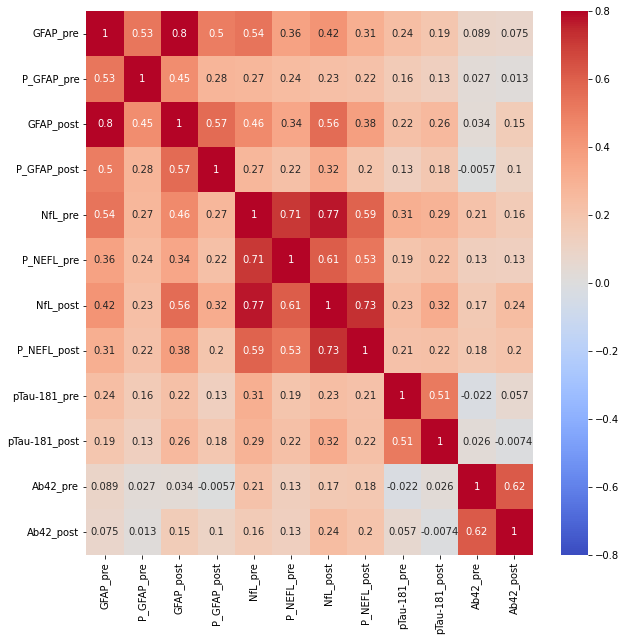

In [748]:
# check
compare_prots=['GFAP_pre','P_GFAP_pre','GFAP_post','P_GFAP_post','NfL_pre','P_NEFL_pre','NfL_post','P_NEFL_post','pTau-181_pre','pTau-181_post','Ab42_pre','Ab42_post']

fig, ax = plt.subplots(figsize=(10,10))
corr_map_OLINK = data.loc[:,compare_prots].corr()
#mask_m = np.tril(corr_map_OLINK,k=-1)
ax=sns.heatmap(corr_map_OLINK,cmap="coolwarm",vmin=-.8,vmax=.8, annot=True,ax=ax)
#ax.invert_yaxis()

In [749]:

Abcorrs=data[['Ab42/Ab40_regPl_diff_cl']+[a+'_diff_cl' for a in OLINK_assays_all]].corr()['Ab42/Ab40_regPl_diff_cl']
Abcorrs.sort_values().iloc[-20:]

P_MCFD2_diff_cl            0.219103
P_ENO1_diff_cl             0.219160
P_BACH1_diff_cl            0.219588
P_IKBKG_diff_cl            0.219644
P_NUB1_diff_cl             0.219675
P_DFFA_diff_cl             0.219919
P_TXLNA_diff_cl            0.220681
P_GOPC_diff_cl             0.221113
P_CRADD_diff_cl            0.221905
P_ANXA4_diff_cl            0.221925
P_FADD_diff_cl             0.222059
P_PFKFB2_diff_cl           0.222580
P_PLPBP_diff_cl            0.224661
P_TNFSF14_diff_cl          0.224885
P_FKBP4_diff_cl            0.224943
P_TMSB10_diff_cl           0.226809
P_ANXA3_diff_cl            0.226947
P_ARHGAP25_diff_cl         0.234134
P_KYAT1_diff_cl            0.251146
Ab42/Ab40_regPl_diff_cl    1.000000
Name: Ab42/Ab40_regPl_diff_cl, dtype: float64

In [750]:
data[['Ab42/Ab40_regPl_diff_cl','adni_mean_cl_diff']].corr()

,Ab42/Ab40_regPl_diff_cl,adni_mean_cl_diff
Ab42/Ab40_regPl_diff_cl,1.000000,-0.041513
adni_mean_cl_diff,-0.041513,1.000000


In [751]:
prot_els_regPl_pre_cl
Abcorrs=data[prot_els_regPl_pre_cl +[a+'_pre_cl' for a in diseases]].corr()[prot_els_regPl_pre_cl ]
Abcorrs['Ab42_regPl_pre_cl'].sort_values()

Liver_disease_pre_cl                   -0.063748
Inflammatory_bowel_disease_pre_cl      -0.038020
Breast_cancer_pre_cl                   -0.037158
Type_2_diabetes_pre_cl                 -0.036633
pTau-181_regPl_pre_cl                  -0.032825
Ischaemic_stroke_pre_cl                -0.003945
Endometriosis_pre_cl                    0.006175
Parkinsons_disease_pre_cl               0.014750
Gynaecological_cancer_pre_cl            0.036120
Ischaemic_heart_disease_pre_cl          0.049496
COPD_pre_cl                             0.062009
Death_pre_cl                            0.070412
Rheumatoid_arthritis_pre_cl             0.070666
Alzheimers_dementia_pre_cl              0.072574
Amyotrophic_lateral_sclerosis_pre_cl    0.088186
Prostate_cancer_pre_cl                  0.090956
GFAP_regPl_pre_cl                       0.099439
Vascular_dementia_pre_cl                0.111171
Cystitis_pre_cl                         0.133284
Lung_cancer_pre_cl                      0.136930
Colorectal_cancer_pr

In [752]:
#[a[:-4] for a in find_vars(data,'^P_.*pre')]
data['P_EIF4EBP1_pre']

eid
1001193    1.6173
1005523   -0.2427
1014449       NaN
1024229   -0.7729
1037025   -0.2837
            ...  
6015180    1.1799
6016344   -0.2765
6018823       NaN
6022672    1.3135
6023438    0.1869
Name: P_EIF4EBP1_pre, Length: 1557, dtype: float64

In [753]:
#data.to_csv('/data/biobank/all_data.csv')

### Proteomic Correlation plots  


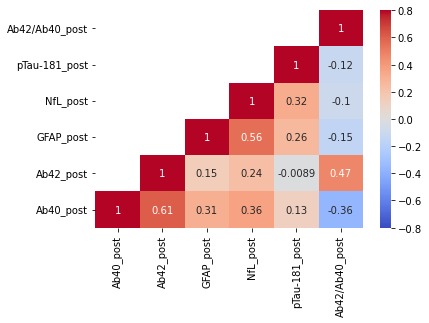

In [754]:


corr_map_post= data.loc[all_matched,prot_els_post[::-1]].corr()
corr_map_pre= data.loc[all_matched,prot_els_pre[::-1]].corr()
np.fill_diagonal(corr_map_post.values,1)
np.fill_diagonal(corr_map_pre.values,1)
mask_m = np.tril(corr_map_post,k=-1)
ax=sns.heatmap(corr_map_post,cmap="coolwarm",vmin=-.8,vmax=.8,mask=mask_m, annot=True)
ax.invert_yaxis()


In [755]:
vars=['Ab42_regPl_pre','Ab40_regPl_pre','Ab42/Ab40_regPl_pre','pTau-181_regPl_pre','NfL_regPl_pre','GFAP_regPl_pre']

In [756]:

# mask_m = np.tril(corr_map_post,k=-1)
# ax=sns.heatmap(corr_map_pre.loc[:,vars],cmap="coolwarm",vmin=-.8,vmax=.8,mask=mask_m, annot=True)
# ax.invert_yaxis()

In [757]:
np.array(prot_els_regPl_pre)[[5,4,0,1,2,3]]

array(['Ab40_regPl_pre', 'Ab42_regPl_pre', 'Ab42/Ab40_regPl_pre',
       'pTau-181_regPl_pre', 'NfL_regPl_pre', 'GFAP_regPl_pre'],
      dtype='<U19')

In [758]:
#els=proteomics.loc[:,'Gender_pre']=='M


proteomics.loc[:,prot_els_pre+prot_els_post+['PlateID_pre']+['PlateID_post']].to_csv('simoa_proteomics.csv')

In [759]:
vars

['Ab42_regPl_pre',
 'Ab40_regPl_pre',
 'Ab42/Ab40_regPl_pre',
 'pTau-181_regPl_pre',
 'NfL_regPl_pre',
 'GFAP_regPl_pre']

In [760]:
vars=np.array(['Ab40_regPl_pre', 'Ab42_regPl_pre', 'Ab42/Ab40_regPl_pre', 'pTau-181_regPl_pre', 'NfL_regPl_pre', 'P_NEFL_pre' ,'GFAP_regPl_pre','P_GFAP_pre'])
vars_names=np.array(['Ab40', 'Ab42', 'Ab42/Ab40','pTau-181', 'NfL','NfL (OLINK)', 'GFAP', 'GFAP (OLINK)'])

[Text(0.5, 0, 'Ab40'),
 Text(1.5, 0, 'Ab42'),
 Text(2.5, 0, 'Ab42/Ab40'),
 Text(3.5, 0, 'pTau-181'),
 Text(4.5, 0, 'NfL'),
 Text(5.5, 0, 'NfL (OLINK)'),
 Text(6.5, 0, 'GFAP'),
 Text(7.5, 0, 'GFAP (OLINK)')]

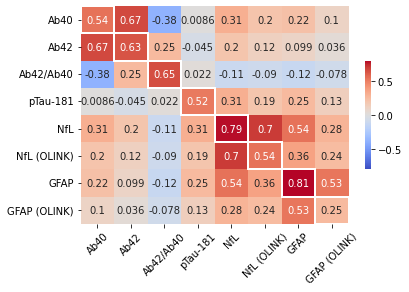

In [761]:
import matplotlib.pyplot as plt

vars=(['Ab40_regPl_pre', 'Ab42_regPl_pre', 'Ab42/Ab40_regPl_pre', 'pTau-181_regPl_pre', 'NfL_regPl_pre', 'P_NEFL_pre' ,'GFAP_regPl_pre','P_GFAP_pre'])
vars_names=(['Ab40', 'Ab42', 'Ab42/Ab40','pTau-181', 'NfL','NfL (OLINK)', 'GFAP', 'GFAP (OLINK)'])
vars_prepost=vars + [a[:-4] + '_post' for a in vars]

corr_map_post= data.loc[:,[a[:-4] + '_post' for a in vars]].corr()
corr_map_pre= data.loc[:,vars].corr()


for a in corr_map_pre.columns:
    corr_map_pre.loc[a,a]=data.loc[all_matched,[a,a.replace('pre','post')]].corr().values[0,1]
    corr_map_post.loc[a,a]=corr_map_pre.loc[a,a]


corr_map_pre.columns=vars_names
corr_map_pre.index=vars_names

#mask_m = np.tril(corr_map_regPl_post,k=-1)
ax=sns.heatmap(corr_map_pre,cmap="coolwarm",vmin=-.8,vmax=.8, annot=True,cbar_kws={"shrink": 0.5})

# Highlight diagonal with black outline
for i in range(len(corr_map_pre)):
    ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='white', lw=2))

ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=45)


[Text(0.5, 0, 'Ab40'),
 Text(1.5, 0, 'Ab42'),
 Text(2.5, 0, 'Ab42/Ab40'),
 Text(3.5, 0, 'pTau-181'),
 Text(4.5, 0, 'NfL'),
 Text(5.5, 0, 'GFAP')]

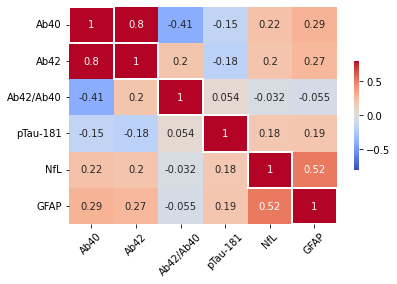

In [762]:
import matplotlib.pyplot as plt

vars=(['Ab40_regPl_pre', 'Ab42_regPl_pre', 'Ab42/Ab40_regPl_pre', 'pTau-181_regPl_pre', 'NfL_regPl_pre','GFAP_regPl_pre'])
vars_names=(['Ab40', 'Ab42', 'Ab42/Ab40','pTau-181', 'NfL', 'GFAP'])
vars_prepost=vars + [a[:-4] + '_post' for a in vars]

corr_map_diff= data.loc[:,[a[:-4] + '_diff_cl' for a in vars]].corr()



#for a in corr_map_pre.columns:
#    corr_map_pre.loc[a,a]=data.loc[all_matched,[a,a.replace('pre','post')]].corr().values[0,1]
#    corr_map_post.loc[a,a]=corr_map_pre.loc[a,a]


corr_map_diff.columns=vars_names
corr_map_diff.index=vars_names

#mask_m = np.tril(corr_map_regPl_post,k=-1)
ax=sns.heatmap(corr_map_diff,cmap="coolwarm",vmin=-.8,vmax=.8, annot=True,cbar_kws={"shrink": 0.5})

# Highlight diagonal with black outline
for i in range(len(corr_map_pre)):
    ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='white', lw=2))

ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=45)

[Text(0.5, 0, 'Ab40'),
 Text(1.5, 0, 'Ab42'),
 Text(2.5, 0, 'Ab42/Ab40'),
 Text(3.5, 0, 'pTau-181'),
 Text(4.5, 0, 'NfL'),
 Text(5.5, 0, 'GFAP')]

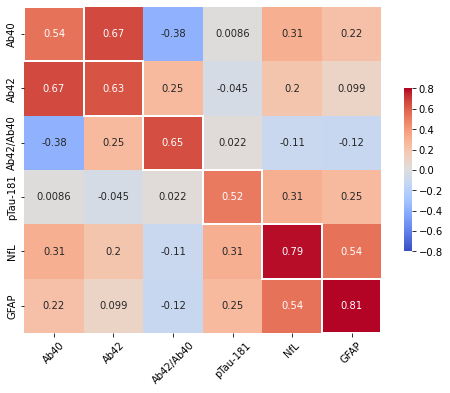

In [763]:
import matplotlib.pyplot as plt

vars=(['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl', 'NfL_regPl', 'GFAP_regPl'] )
vars_names=(['Ab40', 'Ab42', 'Ab42/Ab40','pTau-181', 'NfL', 'GFAP'])
vars_pre=[a + '_pre' for a in vars] 
vars_post= [a + '_post' for a in vars]

corr_map_post= data.loc[:,vars_post].corr()
corr_map_pre= data.loc[:,vars_pre].corr()


for a in corr_map_pre.columns:
    corr_map_pre.loc[a,a]=data.loc[all_matched,[a,a.replace('pre','post')]].corr().values[0,1]
    corr_map_post.loc[a,a]=corr_map_pre.loc[a,a]


corr_map_pre.columns=vars_names
corr_map_pre.index=vars_names

#mask_m = np.tril(corr_map_regPl_post,k=-1)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_map_pre,cmap="coolwarm",vmin=-.8,vmax=.8, annot=True, ax=ax,cbar_kws={"shrink": 0.5})

# Highlight diagonal with black outline
for i in range(len(corr_map_pre)):
    ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='white', lw=2))

ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=45)

[Text(0.5, 0, 'Ab40'),
 Text(1.5, 0, 'Ab42'),
 Text(2.5, 0, 'Ab42/Ab40'),
 Text(3.5, 0, 'pTau-181'),
 Text(4.5, 0, 'NfL'),
 Text(5.5, 0, 'NfL (OLINK)'),
 Text(6.5, 0, 'GFAP'),
 Text(7.5, 0, 'GFAP (OLINK)')]

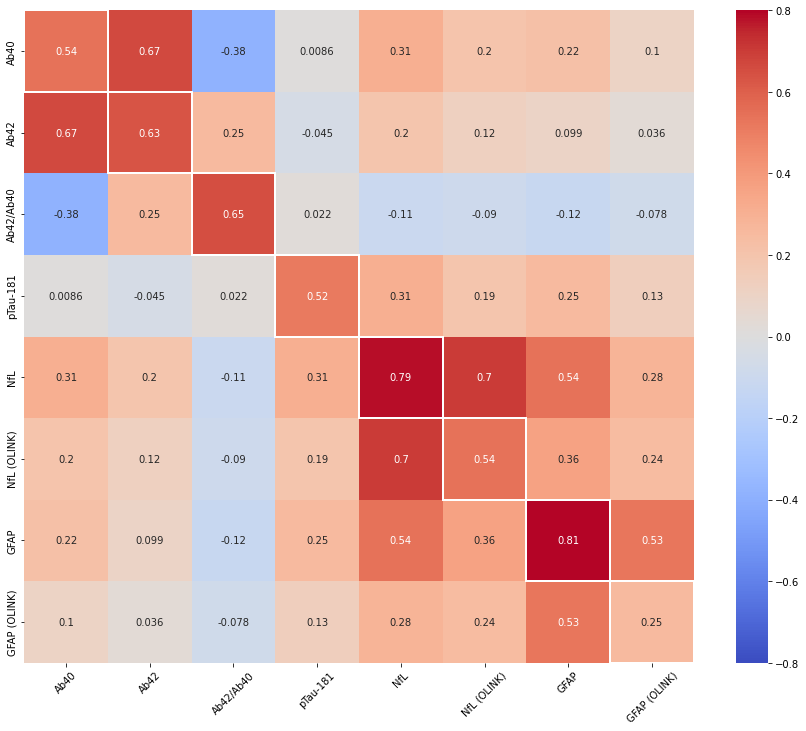

In [764]:
import matplotlib.pyplot as plt



vars=(['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl', 'NfL_regPl', 'P_NEFL' ,'GFAP_regPl','P_GFAP'] )
vars_names=(['Ab40', 'Ab42', 'Ab42/Ab40','pTau-181', 'NfL','NfL (OLINK)', 'GFAP', 'GFAP (OLINK)'])
vars_pre=[a + '_pre' for a in vars] 
vars_post= [a + '_post' for a in vars]

corr_map_post= data.loc[:,vars_post].corr()
corr_map_pre= data.loc[:,vars_pre].corr()


for a in corr_map_pre.columns:
    corr_map_pre.loc[a,a]=data.loc[all_matched,[a,a.replace('pre','post')]].corr().values[0,1]
    corr_map_post.loc[a,a]=corr_map_pre.loc[a,a]


corr_map_pre.columns=vars_names
corr_map_pre.index=vars_names

#mask_m = np.tril(corr_map_regPl_post,k=-1)
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corr_map_pre,cmap="coolwarm",vmin=-.8,vmax=.8, annot=True, ax=ax)

# Highlight diagonal with black outline
for i in range(len(corr_map_pre)):
    ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='white', lw=2))

ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=45)


In [765]:
#for a in vars:
#data.loc[all_matched,[a,a.replace('pre','post')]].plot.scatter(x=a,y=a.replace('pre','post'),alpha=.1)
# 


In [766]:
vars

['Ab40_regPl',
 'Ab42_regPl',
 'Ab42/Ab40_regPl',
 'pTau-181_regPl',
 'NfL_regPl',
 'P_NEFL',
 'GFAP_regPl',
 'P_GFAP']

[Text(0.5, 0, 'Ab40'),
 Text(1.5, 0, 'Ab42'),
 Text(2.5, 0, 'Ab42/Ab40'),
 Text(3.5, 0, 'pTau-181'),
 Text(4.5, 0, 'NfL'),
 Text(5.5, 0, 'NfL (OLINK)'),
 Text(6.5, 0, 'GFAP'),
 Text(7.5, 0, 'GFAP (OLINK)')]

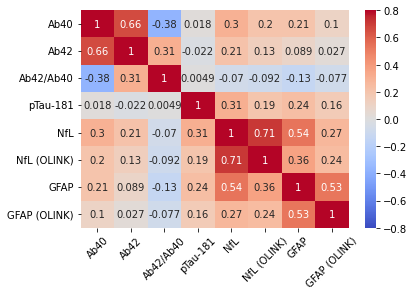

In [767]:
vars=np.array(['Ab40_regPl_pre_cl', 'Ab42_pre', 'Ab42/Ab40_pre', 'pTau-181_pre', 'NfL_pre', 'P_NEFL_pre' ,'GFAP_pre','P_GFAP_pre'])
vars_names=np.array(['Ab40', 'Ab42', 'Ab42/Ab40','pTau-181', 'NfL','NfL (OLINK)', 'GFAP', 'GFAP (OLINK)'])

corr_map_post= data.loc[:,vars].corr()
corr_map_pre= data.loc[:,vars].corr()
corr_map_pre.columns=vars_names

corr_map_pre.index=vars_names
np.fill_diagonal(corr_map_post.values,1)
np.fill_diagonal(corr_map_pre.values,1)
#mask_m = np.tril(corr_map_regPl_post,k=-1)
ax=sns.heatmap(corr_map_pre,cmap="coolwarm",vmin=-.8,vmax=.8, annot=True)
#ax.invert_yaxis()
ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=45)

[Text(0.5, 0, 'Ab40'),
 Text(1.5, 0, 'Ab42'),
 Text(2.5, 0, 'Ab42/Ab40'),
 Text(3.5, 0, 'pTau-181'),
 Text(4.5, 0, 'NfL'),
 Text(5.5, 0, 'GFAP')]

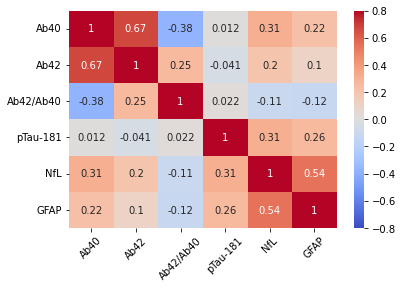

In [768]:
vars=np.array(prot_els_regPl_pre)[[5,4,0,1,2,3]]
vars_names=np.array([ 'NfL', 'GFAP'])

corr_map_post= proteomics.loc[:,vars].corr()
corr_map_pre= proteomics.loc[:,vars].corr()
corr_map_pre.columns=[a[:-10] for a in corr_map_post.columns]
corr_map_pre.index=[a[:-10] for a in corr_map_post.index]
np.fill_diagonal(corr_map_post.values,1)
np.fill_diagonal(corr_map_pre.values,1)
#mask_m = np.tril(corr_map_regPl_post,k=-1)
ax=sns.heatmap(corr_map_pre,cmap="coolwarm",vmin=-.8,vmax=.8, annot=True)
#ax.invert_yaxis()
ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=45)

In [769]:
# mask_m = np.tril(corr_map_diff_case,k=-1)
# ax=sns.heatmap(corr_map_diff_case,cmap="coolwarm",vmin=-.8,vmax=.8,mask=mask_m, annot=True)
# ax.invert_yaxis()
# mask_m = np.tril(corr_map_diff_control,k=-1)
# ax=sns.heatmap(corr_map_diff_control,cmap="coolwarm",vmin=-.8,vmax=.8,mask=mask_m, annot=True)
# ax.invert_yaxis()

In [770]:
data.loc[all_matched,'firstpos'].min()

Timestamp('2020-03-22 00:00:00')

# Demographic histograms

Text(0.5, 0, 'Date of first recorded positive')

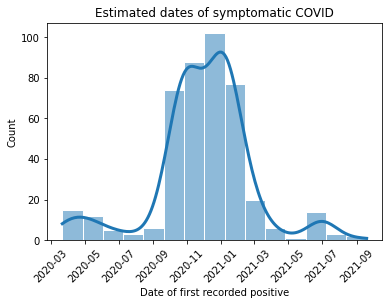

In [771]:
ax=sns.histplot(data=data.loc[all_matched,:],x='firstpos',bins=15,edgecolor="white",kde=True,line_kws={'lw': 3})
plt.xticks(rotation=45)
ax.set_title('Estimated dates of symptomatic COVID')
ax.set_xlabel('Date of first recorded positive')

Text(0.5, 0, 'Age')

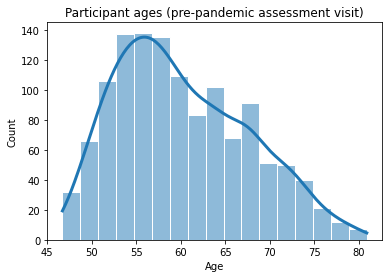

In [772]:
ax=sns.histplot(data=data.loc[all_matched,:],  x="Age-2.0",edgecolor='white',kde=True,line_kws={'lw': 3})
ax.set_title('Participant ages (pre-pandemic assessment visit)')
ax.set_xlabel('Age')

<ipython-input-773-991a559978e3>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=45)


[Text(18628.0, 0, '2021-01'),
 Text(18687.0, 0, '2021-03'),
 Text(18748.0, 0, '2021-05'),
 Text(18809.0, 0, '2021-07'),
 Text(18871.0, 0, '2021-09'),
 Text(18932.0, 0, '2021-11'),
 Text(18993.0, 0, '2022-01'),
 Text(19052.0, 0, '2022-03')]

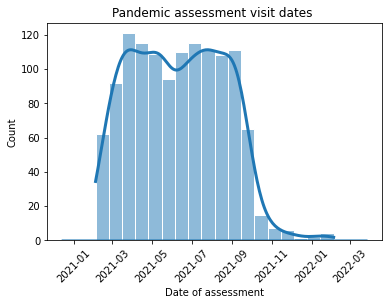

In [773]:
ax=sns.kdeplot(data=data.loc[all_matched,:],  x='date_post')
ax=sns.histplot(data=data.loc[all_matched,:],  x='date_post',edgecolor='white',bins=18,kde=True,line_kws={'lw': 3})

ax.set_title('Pandemic assessment visit dates ')
ax.set_xlabel('Date of assessment')
ax.set_ylabel('Count')
ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=45)

In [774]:
data.loc[all_matched&all_case,"assessment_sep_m"].min()

12

<ipython-input-775-e65e93e7be13>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=45)


[Text(0.0, 0, '0'),
 Text(10.0, 0, '10'),
 Text(20.0, 0, '20'),
 Text(30.0, 0, '30'),
 Text(40.0, 0, '40'),
 Text(50.0, 0, '50'),
 Text(60.0, 0, '60'),
 Text(70.0, 0, '70'),
 Text(80.0, 0, '80'),
 Text(90.0, 0, '90')]

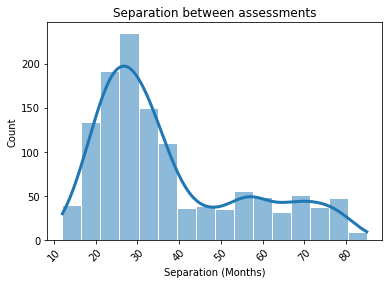

In [775]:
ax=sns.histplot(data=data.loc[all_matched,:],  x="assessment_sep_m",edgecolor='white',kde=True,line_kws={'lw': 3})
ax.set_title('Separation between assessments')
ax.set_xlabel('Separation (Months)')
ax.set_ylabel('Count')
ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=45)

In [776]:
data.loc[all_matched,"assessment_sep_m"].max()

85

<ipython-input-777-7d4b2a4aa66f>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=45)


[Text(16071.0, 0, '2014'),
 Text(16436.0, 0, '2015'),
 Text(16801.0, 0, '2016'),
 Text(17167.0, 0, '2017'),
 Text(17532.0, 0, '2018'),
 Text(17897.0, 0, '2019'),
 Text(18262.0, 0, '2020')]

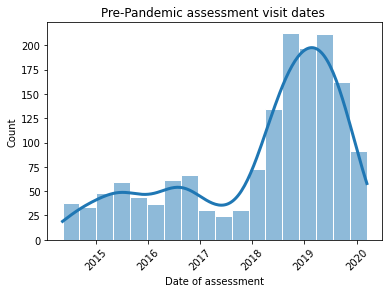

In [777]:
ax=sns.histplot(data=data,  x='date_pre',edgecolor='white',bins=18,kde=True,line_kws={'lw': 3})
ax.set_title('Pre-Pandemic assessment visit dates ')
ax.set_xlabel('Date of assessment')
ax.set_ylabel('Count')
ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=45)

,HES,PCR,GP,Lateral
eid,,,,
1024229,False,True,True,True
1037373,False,True,True,False
1043160,False,False,False,True
1055982,True,True,True,True
1058801,False,False,False,True
...,...,...,...,...
6004696,False,True,True,True
6013979,False,True,True,False
6016344,False,True,False,True


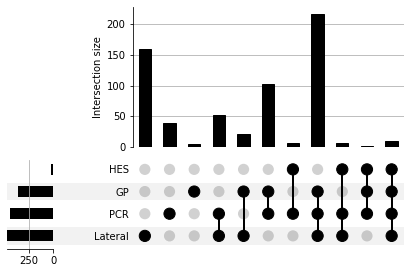

In [778]:
import upsetplot
upsetdata=upsetplot.from_indicators(data.loc[all_case&all_matched,['HES','PCR','GP','Lateral']])
upsetplot.plot(upsetdata,subset_size="count") 
#data.loc[all_case,['HES','PCR','GP','Lateral']].
data.loc[all_case,['HES','PCR','GP','Lateral']]

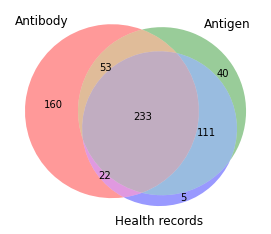

In [779]:
from matplotlib_venn import venn3
set1=set(data[data.loc[:,'Lateral']&all_case&all_matched].index)
set2=set(data[data.loc[:,'PCR']&all_case&all_matched].index)
set3=set(data[data.loc[:,'PublicHealthRecord']&all_case&all_matched].index)

venn3([set1, set2,set3],['Antibody','Antigen','Health records'])


In [780]:
len(np.intersect1d(all_matched[all_matched].index.values,eids_OLINK))

868

## eGFR

In [781]:
# eGFR only abvailable on 0/1st visist

# CDK-EPI equation for GFR:


# GFR = 141 * min(Scr / k, 1)^a * max(Scr / k, 1)^-1.209 * 0.993^data['Age- * 1.018 

find_vars(data,'30720')
23478
SCr=data.loc[:,'30700-0.0']

kk=0.7+0.2*data['22001-0.0']

alpha=-0.329 - data['22001-0.0']*(0.411-0.329)

sex_mult = 1-.018 * (data['22001-0.0']-1)

eth_mult = 1+ 0.159 * (((data.loc[:,find_vars(data,'^21000-2')]>4000).sum(axis=1))/2)

GFR = 141 * np.minimum(SCr / kk, 1)**alpha * np.maximum(SCr / kk, 1)**-1.209 * 0.993**(data['Age-0.0']) * sex_mult * eth_mult
data.loc[:,'GFR_Cr-0.0']=GFR


<ipython-input-781-8ca5947b42e0>:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:,'GFR_Cr-0.0']=GFR


In [782]:
# CDK-EPI Creatinine-Cystatin equation for GFR:  ## Creatinine not available

# eGFRcr-cys = 135 x min(Scr/κ, 1)**α x max(Scr/κ, 1)-0.544 x min(Scys/0.8, 1)-0.323 x max(Scys/0.8, 1)-0.778 x 0.9961Age x 0.963 [if female]

#
# estdata=data.loc[:,['P_CST3_0','30720-0.0','P_CST3_0','30700-0.0']].dropna()

# kde_cys = KernelReg(endog=estdata.loc[:,'30720-0.0'], exog=estdata.loc[:,'P_CST3_0'], var_type='c', bw=[12])
# estimator = kde.fit(estdata.loc[:,'P_CST3_0'])

# SCr=data.loc[:,'30700-0.0']

# kde_cre = KernelReg(endog=estdata.loc[:,'30720-0.0'], exog=estdata.loc[:,'P_CST3_0'], var_type='c', bw=[12])
# estimator = kde.fit(estdata.loc[:,'P_CST3_0'])


# kk=0.7+0.2*data['22001-0.0']

# alpha=-0.219 + data['22001-0.0']*(0.219-0.144)

# sex_mult = 0.963 * (1-data['22001-0.0'])

# #eth_mult = 1+ 0.159 * (((data.loc[:,find_vars(data,'^21000-2')]>4000).sum(axis=1))/2)

# GFR = (135 * np.minimum(SCr / kk, 1)**alpha )* (np.maximum(SCr / kk, 1)**-0.544) * (np.minimum(SCys/0.8,1)**-0.323) * (np.maximum(SCys/0.8,1)**-0.778) * 0.9961**(data['Age-0.0']) * sex_mult 

# data.loc[:,'GFR-0.0']=GFR

In [783]:
'P_CST3'+a

'P_CST3P_GFAP_pre'

In [784]:
# # eGFR only abvailable on 0/1st visist
# from statsmodels.nonparametric.kernel_regression import KernelReg
# # CDK-EPI equation for Cys GFR:


# GFR = 133 * min(Scys/0.8, 1)-0.499 x max(Scys/0.8, 1)-1.328 * 0.996**Age x 0.932 [if female]

# generate estimator of standardised CST3 from OLINK levels:
from statsmodels.nonparametric.kernel_regression import KernelReg
estdata=data.loc[:,['P_CST3_0','P_CST3_pre','P_CST3_post','30720-0.0']].dropna()
kde_cys = KernelReg(endog=estdata.loc[:,'30720-0.0'], exog=estdata.loc[:,'P_CST3_0'], var_type='c', bw=[12])
sex_mult = 1 - (1-0.932) * (1-data['22001-0.0'])

for a in ['_0','_pre','_post']:
    if a=='_0':
        age=data.loc[estdata.index,'Age-0.0']
    elif a=='_pre':
        age=data.loc[estdata.index,'Age-2.0']
    elif a=='_post':
        age=data.loc[estdata.index,'Age-3.0']

    SCys= kde_cys.fit(estdata.loc[:,'P_CST3'+a])[0]
    data.loc[estdata.index,'P_CST3'+a+'_cl']=SCys
    data.loc[estdata.index,'GFR_Cys'+a+'_cl'] = 133 * np.minimum(SCys/0.8, 1)**0.499 * np.maximum(SCys / 0.8, 1)**-1.328 * 0.996**age * sex_mult 
data.loc[estdata.index,'GFR_Cys'+'_diff'+'_cl'] =data.loc[estdata.index,'GFR_Cys'+'_post'+'_cl'] -data.loc[estdata.index,'GFR_Cys'+'_pre'+'_cl'] 

data=data.copy()

<ipython-input-784-59d0fb381eb9>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[estdata.index,'GFR_Cys'+a+'_cl'] = 133 * np.minimum(SCys/0.8, 1)**0.499 * np.maximum(SCys / 0.8, 1)**-1.328 * 0.996**age * sex_mult
<ipython-input-784-59d0fb381eb9>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[estdata.index,'GFR_Cys'+a+'_cl'] = 133 * np.minimum(SCys/0.8, 1)**0.499 * np.maximum(SCys / 0.8, 1)**-1.328 * 0.996**age * sex_mult
<ipython-input-784-59d0fb381eb9>:24: PerformanceWarning: DataFrame is highly fragmente

# Sample Counts


In [785]:
all_matched.values.sum()

1248

In [786]:
data['pTau-181_post'].dropna()

eid
1001193    0.945050
1005523    0.758132
1014449    0.946585
1024229   -0.300614
1037025    0.851507
             ...   
6004696    0.627773
6015180    0.696312
6018823    0.293446
6022672    0.312756
6023438   -0.136751
Name: pTau-181_post, Length: 1254, dtype: float64

In [787]:
data.loc[:,[ a + '_matched' for a in ['Ab42/Ab40','Ab42','Ab40','pTau-181','NfL','GFAP']]].sum()/2

Ab42/Ab40_matched    614.0
Ab42_matched         617.0
Ab40_matched         615.0
pTau-181_matched     610.0
NfL_matched          619.0
GFAP_matched         620.0
dtype: float64

In [788]:
# hospitalised
(data.loc[:,'Case_hosp_matched']=='sars_hosp').sum()

26

In [789]:
# vaccinated
print('prior to positive: ' + str((data.loc[all_matched,'vac_prior_first_pos']=='prior').sum()))
print('following positive: ' + str((data.loc[all_matched,'vac_prior_first_pos']=='post').sum()))

prior to positive: 40
following positive: 249


In [790]:
for a in ['GFR_Cys_diff_cl','adni_mean_diff']:
    print(a +': '+str(data.loc[data.loc[~data.loc[:,a].isna(),'matched_eid'].dropna(),a].dropna().shape[0]/2))

GFR_Cys_diff_cl: 225.0
adni_mean_diff: 509.0


In [791]:
for a in ['GFR_Cys_diff_cl','adni_mean_diff']:
    print(a +': '+str(data.loc[data.loc[~data.loc[:,a].isna(),'matched_eid'].dropna(),a].dropna().shape[0]/2))

GFR_Cys_diff_cl: 225.0
adni_mean_diff: 509.0


In [792]:
len(data.loc[all_matched,'GFR_Cys_diff_cl'].dropna())/2

347.5

In [793]:
any_Olink=data.loc[all_matched,find_vars(data,'^P_.*diff_cl')].any(axis=1)
len(np.intersect1d(data[all_matched][any_Olink]['matched_eid'].dropna().values,any_Olink[any_Olink].index))/2

277.0

# Demographic Tables

In [794]:
col_names=['Control','SARS-COV-2']
els=(all_matched  )

var_names=['Female','Age','Assessment interval (months)','Ethnicity (non-white)','Weight (kg)','Hip/waist ratio','BMI','BP-systolic (mmHg)','BP-diastolic (mmHg)','BP medication','Diabetes diagnosis','Cholesterol-lowering medication','Alcohol intake freq. score','Smokers','Age completed education','Index of multiple deprivation','Household income (£1000s)','Number in household','Key worker','Working through COVID','General cognitive ability score','Prospective memory','Daily moderate activity (min)','General health (1-4)','Hand grip mean (kg)','Wheeze (chest)','APOE-ε4 count']
vars=['Gender_pre','Age-2.0','assessment_sep_m','Ethnicity(White)','21002-2.0','Hip/Waist-2.0','21001-2.0','4080-2.0','4079-2.0','BP_meds','Diabetes','Chol_meds','Alcohol-2.0','Smoking_bin-2.0','845-2.0','Deprivation','738-2.0','709-2.0','KeyWorker','WorkingThroughCOVID','cog_vars_gi-2.0','ProsMem-2.0','Activity-2.0','GeneralHealth-2.0','HandGrip-2.0','Wheeze-2.0','A4']
var_names=['Age (pre)','Age (post)','Sex','Assessment gap (months)','BP (sys) - pre ','BP (dia) - pre','BP_meds','Weight (pre)','Hip/Waist (pre)','BMI (pre)','Obesity','Alcohol Intake Freq','Smoking','Education','Multiple Deprivation','Diabetes','Heart_condition','Chol_meds','Income','Number Household','Ethnicity(White)','Key Worker','Working through COVID','Cognition_pre','Memory_pre','Activity','General_health (pre)','MR Brain Signature (pre)','Vitamin D','diabetes','cardiovascular','hypertension','depression','cholesterol','headinjury','APOE_score','GFR_Cys']
vars=['Age-2.0','Age-3.0','Gender_pre','assessment_sep','4080-2.0','4079-2.0','BP_meds','21002-2.0','Hip/Waist-2.0','21001-2.0','Obesity-2.0','Alcohol-2.0','Smoking-2.0','845-2.0','Deprivation','Diabetes','Heart_Cond','Chol_meds','738-2.0','709-2.0','Ethnicity(White)','KeyWorker','WorkingThroughCOVID','6350-2.0','20018-2.0','894-2.0','2178-2.0','adni_mean_cl-2.0','30890-1.0','diabetes','cardiovascular','hypertension','depression','cholesterol','headinjury','APOE_score','GFR_Cys_pre_cl']


out=table_means_ext(data.loc[els,:],show=vars,groupby='Case',var_names=var_names)
out=out.rename(columns={'ctr':'Matched controls','sars':'Cases','p value (sars)':'p-value'})
out[['Cases','Matched controls','p-value','count (sars)']].style.format(precision=3)



,Cases,Matched controls,p-value,count (sars)
Age (pre),60.2143 (7.4147),60.2305 (7.4068),0.324,624
Age (post),63.4497 (7.0225),63.4601 (7.0165),0.456,624
Sex,330,330,1.000,624
Assessment gap (months),1180.9487 (553.9333),1178.8077 (552.7995),0.662,624
BP (sys) - pre,137.2257 (19.2217),137.2627 (18.5845),0.984,510
BP (dia) - pre,79.2554 (11.0407),79.3333 (10.7974),0.625,510
BP_meds,53,46,0.530,624
Weight (pre),77.0606 (15.0183),75.6289 (14.5410),0.028,606
Hip/Waist (pre),1.1603 (0.1182),1.1620 (0.1180),0.831,607
BMI (pre),26.5579 (4.2060),26.2325 (4.1718),0.110,606


## Separating different groups

In [1241]:
# Separating Hospitalised
col_names=['Control','SARS-COV-2']
els=all_matched 

# els=all_case.copy()# & (data.loc[ids,'KeyWorker'].values==data.loc[ids2,'KeyWorker'].values)  & (data.loc[ids,'Diabetes'].values==data.loc[ids2,'Diabetes'].values) & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values) #&(data['Activity-2.0']<40)

# ids=data.loc[els,'matched_eid'].dropna().index
# ids2=data.loc[ids,'matched_eid']
# idels=(data.loc[ids,'KeyWorker'].values==data.loc[ids2,'KeyWorker'].values)  & (data.loc[ids,'Diabetes'].values==data.loc[ids2,'Diabetes'].values)&  (data.loc[ids,'Chol_meds'].values==data.loc[ids2,'Chol_meds'].values)  & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values) # & (np.abs((data.loc[ids,'709-2.0'].values-data.loc[ids2,'709-2.0'].values))<2) #& 
# #data.loc[ids,'Activity-2.0']-data.loc[ids2,'Activity-2.0']
# els[:]=False
# els[ids[idels]]=True
# els[ids2[idels]]=True 

var_names=['Age (pre)','Age (post)','Sex','Assessment gap (months)','BP (sys) - pre ','BP (dia) - pre','BP_meds','Weight (pre)','Hip/Waist (pre)','BMI (pre)','Obesity','Alcohol Intake Freq','Smoking','Education','Multiple Deprivation','Diabetes','Heart_condition','Chol_meds','Income','Number Household','Ethnicity(White)','Key Worker','Working through COVID','Cognition_pre','Memory_pre','Activity','General_health (pre)','MR Brain Signature (pre)','Vitamin D','diabetes','cardiovascular','hypertension','depression','cholesterol','headinjury','renal','GFR_Cys']
vars=['Age-2.0','Age-3.0','Gender_pre','assessment_sep','4080-2.0','4079-2.0','BP_meds','21002-2.0','Hip/Waist-2.0','21001-2.0','Obesity-2.0','Alcohol-2.0','Smoking-2.0','845-2.0','Deprivation','Diabetes','Heart_Cond','Chol_meds','738-2.0','709-2.0','Ethnicity(White)','KeyWorker','WorkingThroughCOVID','6350-2.0','20018-2.0','894-2.0','2178-2.0','adni_mean_cl-2.0','30890-1.0','diabetes','cardiovascular','hypertension','depression','cholesterol','headinjury','renal','GFR_Cys_pre_cl']
out=table_means_ext(data.loc[els,:],show=vars,groupby='Case_hosp_matched',statkeys=['sars','sars_hosp'],var_names=var_names)
out[['count (sars)','ctr_sars','sars','p value (sars)','count (sars_hosp)','ctr_sars_hosp','sars_hosp','p value (sars_hosp)']].style.format(precision=2)



,count (sars),ctr_sars,sars,p value (sars),count (sars_hosp),ctr_sars_hosp,sars_hosp,p value (sars_hosp)
Age (pre),604,59.9986 (7.2561),59.9835 (7.2678),0.37,20,67.2334 (8.6334),67.1838 (8.5739),0.58
Age (post),604,63.2471 (6.8878),63.2381 (6.8989),0.52,20,69.8922 (7.9751),69.8408 (7.8791),0.53
Sex,604,326,326,1.00,20,16,16,1.00
Assessment gap (months),604,1185.7070 (552.4377),1187.9404 (553.8571),0.65,20,970.4500 (535.8630),969.8000 (526.4843),0.98
BP (sys) - pre,494,137.0162 (18.6749),136.7869 (18.8901),0.93,16,144.8750 (13.9278),149.8235 (24.5490),0.44
BP (dia) - pre,494,79.3543 (10.8125),79.0410 (11.0181),0.87,16,78.6875 (10.6378),85.4118 (10.1493),0.01
BP_meds,604,46,53,0.53,20,0,0,1.00
Weight (pre),586,75.5096 (14.6209),76.7421 (15.0045),0.06,20,79.1250 (11.7286),86.4700 (12.4073),0.05
Hip/Waist (pre),587,1.1648 (0.1178),1.1638 (0.1180),0.93,20,1.0771 (0.0924),1.0597 (0.0729),0.41
BMI (pre),586,26.2062 (4.1957),26.4785 (4.2104),0.18,20,27.0027 (3.3925),28.9023 (3.3880),0.11


In [796]:
# Separating Hospitalised
col_names=['Control','SARS-COV-2']
els=all_matched 

els=all_case.copy()# & (data.loc[ids,'KeyWorker'].values==data.loc[ids2,'KeyWorker'].values)  & (data.loc[ids,'Diabetes'].values==data.loc[ids2,'Diabetes'].values) & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values) #&(data['Activity-2.0']<40)

ids=data.loc[els,'matched_eid'].dropna().index
ids2=data.loc[ids,'matched_eid']
idels=(data.loc[ids,'KeyWorker'].values==data.loc[ids2,'KeyWorker'].values) &  (data.loc[ids,'hypertension'].values==data.loc[ids2,'hypertension'].values)   & (data.loc[ids,'Diabetes'].values==data.loc[ids2,'Diabetes'].values)& (data.loc[ids,'Chol_meds'].values==data.loc[ids2,'Chol_meds'].values) & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values)& (data.loc[ids,'renal'].values==data.loc[ids2,'renal'].values) #& (np.abs((data.loc[ids,'709-2.0'].values-data.loc[ids2,'709-2.0'].values))<2) #& 
#data.loc[ids,'Activity-2.0']-data.loc[ids2,'Activity-2.0']
els[:]=False
els[ids[idels]]=True
els[ids2[idels]]=True 

var_names=['Age (pre)','Age (post)','Sex','Assessment gap (months)','BP (sys) - pre ','BP (dia) - pre','BP_meds','Weight (pre)','Hip/Waist (pre)','BMI (pre)','Obesity','Alcohol Intake Freq','Smoking','Education','Multiple Deprivation','Diabetes','Heart_condition','Chol_meds','Income','Number Household','Ethnicity(White)','Key Worker','Working through COVID','Cognition_pre','Memory_pre','Activity','General_health (pre)','MR Brain Signature (pre)','Vitamin D','diabetes','cardiovascular','hypertension','depression','cholesterol','headinjury','GFR_Cys']
vars=['Age-2.0','Age-3.0','Gender_pre','assessment_sep','4080-2.0','4079-2.0','BP_meds','21002-2.0','Hip/Waist-2.0','21001-2.0','Obesity-2.0','Alcohol-2.0','Smoking-2.0','845-2.0','Deprivation','Diabetes','Heart_Cond','Chol_meds','738-2.0','709-2.0','Ethnicity(White)','KeyWorker','WorkingThroughCOVID','6350-2.0','20018-2.0','894-2.0','2178-2.0','adni_mean_cl-2.0','30890-1.0','diabetes','cardiovascular','hypertension','depression','cholesterol','headinjury','GFR_Cys_pre_cl']
out=table_means_ext(data.loc[els,:],show=vars,groupby='Case_hosp_matched',statkeys=['sars','sars_hosp'],var_names=var_names)
out[['ctr_sars','sars','p value (sars)','ctr_sars_hosp','sars_hosp','p value (sars_hosp)']].style.format(precision=3)
out

,ctr_sars,ctr_sars_hosp,sars,sars_hosp,p value (sars),count (sars),p value (sars_hosp),count (sars_hosp)
Age (pre),58.9503 (7.0048),67.4984 (7.3874),58.9355 (7.0255),67.3308 (7.2519),0.492714,355,0.144126,12
Age (post),62.1780 (6.5881),69.9406 (6.7677),62.1672 (6.6071),69.9468 (6.4958),0.563365,355,0.954525,12
Sex,179,8,179,8,1.000000,353,1.000000,12
Assessment gap (months),1178.0930 (550.3153),891.4167 (521.6553),1179.5521 (548.7191),954.8333 (546.1744),0.824354,355,0.086788,12
BP (sys) - pre,135.4296 (17.7982),146.0000 (16.1452),133.3368 (17.6584),152.3636 (29.6354),0.212351,284,0.317143,10
BP (dia) - pre,79.3063 (10.0434),76.0000 (10.4775),77.8438 (10.5823),84.5455 (11.1478),0.306583,284,0.019615,10
BP_meds,2,0,2,0,1.000000,355,1.000000,12
Weight (pre),75.2073 (14.6166),78.2833 (14.5157),75.9307 (14.0503),84.3167 (13.3024),0.305083,344,0.231101,12
Hip/Waist (pre),1.1659 (0.1183),1.0990 (0.1046),1.1664 (0.1204),1.0797 (0.0765),0.968794,344,0.520083,12
BMI (pre),25.9206 (4.0414),26.8080 (3.7542),25.8160 (3.7677),28.4207 (3.8237),0.865907,344,0.294855,12


In [797]:
# Separating Hospitalised
col_names=['Control','SARS-COV-2']
els=all_matched 

var_names=['Age (pre)','Age (post)','Sex','Assessment gap (months)','BP (sys) - pre ','BP (dia) - pre','BP_meds','Weight (pre)','Hip/Waist (pre)','BMI (pre)','Alcohol Intake Freq','Smoking','Education','Multiple Deprivation','Diabetes','Chol_meds','Income','Number Household','Ethnicity(White)','Key Worker','Working through COVID','Cognition_pre','Memory_pre','Activity','General_health (pre)','MR Brain Signature (pre)']
vars=[a+'_pre_cl' for a in OLINK_assays] # ['Age-2.0','Age-3.0','Gender_pre','assessment_sep','4080-2.0','4079-2.0','BP_meds','21002-2.0','Hip/Waist-2.0','21001-2.0','Alcohol-2.0','Smoking-2.0','845-2.0','Deprivation','Diabetes','Chol_meds','738-2.0','709-2.0','Ethnicity(White)','KeyWorker','WorkingThroughCOVID','6350-2.0','20018-2.0','894-2.0','2178-2.0','adni_mean_cl-2.0']
var_names=vars
out=table_means_ext(data.loc[els,:],show=vars,groupby='Case_hosp_matched',statkeys=['sars','sars_hosp'])
out[['ctr_sars','sars','p value (sars)','ctr_sars_hosp','sars_hosp','p value (sars_hosp)']].style.format(precision=3)


,ctr_sars,sars,p value (sars),ctr_sars_hosp,sars_hosp,p value (sars_hosp)
P_TREM2_pre_cl,0.0148 (0.9940),0.0036 (0.9677),0.415,0.1808 (0.8209),0.1299 (1.2945),0.716
P_AXL_pre_cl,0.0081 (1.0551),-0.0156 (1.0106),0.891,0.4066 (0.8241),-0.2172 (1.1485),0.037
P_TYRO3_pre_cl,0.0387 (1.0033),0.0822 (0.9862),0.573,0.2471 (0.8938),-0.5386 (1.4345),0.167
P_MIF_pre_cl,-0.0377 (1.1498),-0.0371 (1.1052),0.532,-0.1622 (1.2479),0.1988 (0.8400),0.092
P_IL6_pre_cl,-0.1240 (1.0312),-0.0188 (1.0306),0.392,0.3016 (0.9297),0.5447 (0.8025),0.616
P_IL18_pre_cl,-0.0049 (1.0203),0.0105 (1.0637),0.320,-0.1017 (0.9847),0.3585 (0.7789),0.280
P_VWF_pre_cl,0.0367 (1.0000),-0.0323 (0.9916),0.216,0.0389 (1.0224),0.2502 (0.8661),0.916
P_TNF_pre_cl,0.0457 (0.9786),0.0467 (0.9735),0.750,0.0206 (0.8399),0.3574 (0.7747),0.364
P_IL1A_pre_cl,-0.1036 (0.9776),-0.0660 (1.0062),0.850,-0.2783 (1.0187),-0.0787 (1.0769),0.454
P_IL1B_pre_cl,0.0386 (1.0635),-0.0261 (1.1111),0.683,0.0318 (1.2306),0.1063 (0.9775),0.570


In [798]:
# Separating Hospitalised
col_names=['Control','SARS-COV-2']
els=all_matched 
employments=[a+ '-2.0' for a in ['paid_employ','retired','caring','no_employ-sick','unemployed','voluntary']]
employments=employments+[a+ '-3.0' for a in ['paid_employ','retired','caring','no_employ-sick','unemployed','voluntary']]
var_names=['Age (pre)','Age (post)','Sex','Assessment gap (months)']+employments
vars=['Age-2.0','Age-3.0','Gender_pre','assessment_sep']+employments
out=table_means_ext(data.loc[els,:],show=vars,groupby='Case_hosp_matched',statkeys=['sars','sars_hosp'])
out[['ctr_sars','sars','p value (sars)','ctr_sars_hosp','sars_hosp','p value (sars_hosp)']].style.format(precision=3)


,ctr_sars,sars,p value (sars),ctr_sars_hosp,sars_hosp,p value (sars_hosp)
Age-2.0,59.9986 (7.2561),59.9835 (7.2678),0.366,67.2334 (8.6334),67.1838 (8.5739),0.578
Age-3.0,63.2471 (6.8878),63.2381 (6.8989),0.524,69.8922 (7.9751),69.8408 (7.8791),0.525
Gender_pre,326,326,1.000,16,16,1.000
assessment_sep,1185.7070 (552.4377),1187.9404 (553.8571),0.652,970.4500 (535.8630),969.8000 (526.4843),0.983
paid_employ-2.0,245,216,0.097,5,7,0.730
retired-2.0,219,203,0.365,4,9,0.177
caring-2.0,30,19,0.145,0,0,1.000
no_employ-sick-2.0,5,1,0.220,0,1,1.000
unemployed-2.0,5,1,0.220,0,1,1.000
voluntary-2.0,18,25,0.351,0,1,1.000


In [799]:
# Separating Vaccinated (those with vax records)
# 46 were vaccinated prior to second assessment.

#els= all_case & all_matched & (data.loc[:,['HES','PCR','GP']].sum(axis=1)>0) 

#ids=data.loc[els,'matched_eid'].dropna()
#els[ids]=True
els=all_matched
col_names=['Control','SARS-COV-2']

var_names=['Age (pre)','Age (post)','Sex','Assessment gap (months)','BP (sys) - pre ','BP (dia) - pre','BP_meds','Weight (pre)','Hip/Waist (pre)','BMI (pre)','Alcohol Intake Freq','Smoking','Education','Multiple Deprivation','Diabetes','Chol_meds','Income','Number Household','Ethnicity(White)','Key Worker','Working through COVID','Cognition_pre','Memory_pre','Activity','General_health (pre)','WMH_pre','WHM_post','24361-3.0','24366-3.0_norm']+prot_els_post
vars=['Age-2.0','Age-3.0','Gender_pre','assessment_sep','4080-2.0','4079-2.0','BP_meds','21002-2.0','Hip/Waist-2.0','21001-2.0','Alcohol-2.0','Smoking-2.0','845-2.0','Deprivation','Diabetes','Chol_meds','738-2.0','709-2.0','Ethnicity(White)','KeyWorker','WorkingThroughCOVID','6350-2.0','20018-2.0','22034-0.0','2178-2.0','25781-2.0','25781-3.0','24364-3.0','24365-3.0']+prot_els_post
out=table_means_ext(data.loc[els,:],show=vars,groupby='vac_prior_first_pos',statkeys=['prior','post'])
#out[['ctr_sars','sars','p value (sars)','ctr_sars_hosp','sars_hosp','p value (sars_hosp)']].style.format(precision=3)
out.style.format(precision=3)

# add education? 

/home/eduff/miniconda3/envs/pytorch/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/eduff/miniconda3/envs/pytorch/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


,post,prior,unknown,p value (prior),count (prior),p value (post),count (post)
Age-2.0,61.5197 (7.3088),61.5299 (8.1370),59.8310 (7.3650),0.359,40,0.471,249
Age-3.0,64.8805 (6.9292),64.5974 (7.7454),63.0371 (6.9611),0.301,40,0.016,249
Gender_pre,129,23,508,1.000,40,1.000,249
assessment_sep,1226.7028 (614.7997),1119.6500 (536.4343),1170.2325 (536.5583),0.879,40,0.113,249
4080-2.0,139.2727 (18.8378),131.5161 (16.3521),136.9265 (18.9596),0.027,34,0.689,210
4079-2.0,79.8517 (10.0982),78.0968 (11.9954),79.1923 (11.0866),0.263,34,0.527,210
BP_meds,24,3,72,1.000,40,1.000,249
21002-2.0,77.2506 (15.3907),77.4425 (14.8934),76.0658 (14.6351),0.428,40,0.136,243
Hip/Waist-2.0,1.1557 (0.1135),1.1771 (0.1362),1.1619 (0.1184),0.334,40,0.279,243
21001-2.0,26.7146 (4.4094),27.0960 (4.9197),26.2829 (4.0952),0.312,40,0.402,243


In [800]:
# Separating Vaccinated (those with vax records)
# 46 were vaccinated prior to second assessment.

#els= all_case & all_matched & (data.loc[:,['HES','PCR','GP']].sum(axis=1)>0) 

#ids=data.loc[els,'matched_eid'].dropna()
#els[ids]=True
els=all_matched
col_names=['Control','SARS-COV-2']

var_names=['Age (pre)','Age (post)','Sex','Assessment gap (months)','BP (sys) - pre ','BP (dia) - pre','BP_meds','Weight (pre)','Hip/Waist (pre)','BMI (pre)','Alcohol Intake Freq','Smoking','Education','Multiple Deprivation','Diabetes','Chol_meds','Income','Number Household','Ethnicity(White)','Key Worker','Working through COVID','Cognition_pre','Memory_pre','Activity','General_health (pre)','WMH_pre','WHM_post','24361-3.0','24366-3.0_norm']+prot_els_pre
vars=['Age-2.0','Age-3.0','Gender_pre','assessment_sep','4080-2.0','4079-2.0','BP_meds','21002-2.0','Hip/Waist-2.0','21001-2.0','Alcohol-2.0','Smoking-2.0','845-2.0','Deprivation','Diabetes','Chol_meds','738-2.0','709-2.0','Ethnicity(White)','KeyWorker','WorkingThroughCOVID','6350-2.0','20018-2.0','22034-0.0','2178-2.0','25781-2.0','25781-3.0','24364-3.0','24365-3.0']+prot_els_pre
out=table_means_ext(data.loc[els,:],show=vars,groupby='Case_hosp_matched',statkeys=['sars', 'sars_hosp'])
#out[['ctr_sars','sars','p value (sars)','ctr_sars_hosp','sars_hosp','p value (sars_hosp)']].style.format(precision=3)
out.style.format(precision=3)


,ctr_sars,ctr_sars_hosp,sars,sars_hosp,p value (sars),count (sars),p value (sars_hosp),count (sars_hosp)
Age-2.0,59.9986 (7.2561),67.2334 (8.6334),59.9835 (7.2678),67.1838 (8.5739),0.366,604,0.578,20
Age-3.0,63.2471 (6.8878),69.8922 (7.9751),63.2381 (6.8989),69.8408 (7.8791),0.524,604,0.525,20
Gender_pre,326,16,326,16,1.000,604,1.000,20
assessment_sep,1185.7070 (552.4377),970.4500 (535.8630),1187.9404 (553.8571),969.8000 (526.4843),0.652,604,0.983,20
4080-2.0,137.0162 (18.6749),144.8750 (13.9278),136.7869 (18.8901),149.8235 (24.5490),0.934,494,0.441,16
4079-2.0,79.3543 (10.8125),78.6875 (10.6378),79.0410 (11.0181),85.4118 (10.1493),0.865,494,0.006,16
BP_meds,46,0,53,0,0.529,604,1.000,20
21002-2.0,75.5096 (14.6209),79.1250 (11.7286),76.7421 (15.0045),86.4700 (12.4073),0.060,586,0.053,20
Hip/Waist-2.0,1.1648 (0.1178),1.0771 (0.0924),1.1638 (0.1180),1.0597 (0.0729),0.925,587,0.409,20
21001-2.0,26.2062 (4.1957),27.0027 (3.3925),26.4785 (4.2104),28.9023 (3.3880),0.179,586,0.108,20


In [801]:
# Reported diseases
col_names=['Control','SARS-COV-2']
els=all_matched 

#var_names=['Age (pre)','Age (post)','Sex','Assessment gap (months)','BP (sys) - pre ','BP (dia) - pre','BP_meds','Weight (pre)','Hip/Waist (pre)','BMI (pre)','Alcohol Intake Freq','Smoking','Education','Multiple Deprivation','Diabetes','Chol_meds','Income','Number Household','Ethnicity(White)','Key Worker','Working through COVID','Cognition_pre','Memory_pre','Activity','General_health (pre)','MR Brain Signature (pre)']
#vars=['Age-2.0','Age-3.0','Gender_pre','assessment_sep','4080-2.0','4079-2.0','BP_meds','21002-2.0','Hip/Waist-2.0','21001-2.0','Alcohol-2.0','Smoking-2.0','845-2.0','Deprivation','Diabetes','Chol_meds','738-2.0','709-2.0','Ethnicity(White)','KeyWorker','WorkingThroughCOVID','6350-2.0','20018-2.0','894-2.0','2178-2.0','adni_mean_cl-2.0']
vars=['dc_'+ str(a) for a in codes_counts.index.values]
var_names=[disease_codes_names.loc[a,'name'] for a in codes_counts.index.values]
out=table_means_ext(data.loc[els,:],show=vars,groupby='Case_hosp_matched',statkeys=['sars','sars_hosp'])
out[['ctr_sars','sars','p value (sars)','ctr_sars_hosp','sars_hosp','p value (sars_hosp)']].style.format(precision=3)

,ctr_sars,sars,p value (sars),ctr_sars_hosp,sars_hosp,p value (sars_hosp)
dc_1571,88,73,0.236,6,3,0.449
dc_1065,66,80,0.251,4,5,1.000
dc_1568,67,51,0.146,5,4,1.000
dc_1111,55,54,1.000,3,2,1.000
dc_1473,51,48,0.834,3,6,0.449
dc_1387,45,37,0.423,0,0,1.000
dc_1569,40,37,0.814,3,1,0.598
dc_1286,29,36,0.444,1,1,1.000
dc_1598,31,35,0.704,4,2,0.658
dc_1138,34,28,0.514,1,3,0.598


## SARS vs COVID

In [802]:
# Separating those with only antibody test result (no symptoms) from those with evidence of COVID

col_names=['Control','SARS-COV-2']
els=all_matched 
var_names=['BP (sys) - pre ','BP (dia) - pre','BP_meds','Weight (pre)','Hip/Waist (pre)','BMI (pre)','Alcohol Intake Freq','Smoking','Education','Multiple Deprivation','Diabetes','Chol_meds','Income','Number Household','Ethnicity(White)','Key Worker','Working through COVID','Cognition_pre','Memory_pre','Activity','General_health (pre)','Hipp_pre','Hipp_post','6348-2.0','27202-3.0','27200-3.0','27293-3.0']
vars=['4080-2.0','4079-2.0','BP_meds','21002-2.0','Hip/Waist-2.0','21001-2.0','Alcohol-2.0','Smoking-2.0','845-2.0','Deprivation','Diabetes','Chol_meds','738-2.0','709-2.0','Ethnicity(White)','KeyWorker','WorkingThroughCOVID','6350-2.0','20018-2.0','22034-0.0','2178-2.0','26562-2.0','26562-3.0','6350-pc','27202-3.0','27200-3.0','Ab42/Ab40-pc']
var_names=['Age (pre)','Age (post)','Sex','Assessment gap (months)','BP (sys) - pre ','BP (dia) - pre','BP_meds','Weight (pre)','Hip/Waist (pre)','BMI (pre)','Alcohol Intake Freq','Smoking','Education','Multiple Deprivation','Diabetes','Chol_meds','Income','Number Household','Ethnicity(White)','Key Worker','Working through COVID','Cognition_pre','Memory_pre','Activity','General_health (pre)']
vars=['Age-2.0','Age-3.0','Gender_pre','assessment_sep','4080-2.0','4079-2.0','BP_meds','21002-2.0','Hip/Waist-2.0','21001-2.0','Alcohol-2.0','Smoking-2.0','845-2.0','Deprivation','Diabetes','Chol_meds','738-2.0','709-2.0','Ethnicity(White)','KeyWorker','WorkingThroughCOVID','6350-2.0','20018-2.0','22034-0.0','2178-2.0']

out=table_means_ext(data.loc[els,:],show=vars,groupby='COVID',statkeys=['SARS','COVID'])
out[['SARS_ctr','SARS','p value (SARS)','COVID_ctr','COVID','p value (COVID)']].style.format(precision=3)




,SARS_ctr,SARS,p value (SARS),COVID_ctr,COVID,p value (COVID)
Age-2.0,60.7271 (7.3985),60.6849 (7.4220),0.181,60.0592 (7.4099),60.0520 (7.4133),0.706
Age-3.0,63.6102 (6.9579),63.6329 (7.0091),0.382,63.4083 (7.0433),63.3866 (7.0335),0.184
Gender_pre,86,86,1.000,244,244,1.000
assessment_sep,1052.3438 (447.3119),1076.0438 (441.5089),0.008,1222.4159 (578.8303),1217.1228 (583.7999),0.361
4080-2.0,136.1583 (19.1316),135.4524 (17.7316),0.871,137.6026 (18.4247),137.8153 (19.6790),0.912
4079-2.0,77.9000 (10.7347),77.2143 (9.9741),0.793,79.7744 (10.7920),79.9340 (11.3040),0.482
BP_meds,8,13,0.367,38,40,0.906
21002-2.0,75.0642 (14.4313),76.5955 (15.0027),0.209,75.8163 (14.5883),77.2214 (15.0369),0.071
Hip/Waist-2.0,1.1626 (0.1143),1.1665 (0.1239),0.491,1.1617 (0.1193),1.1582 (0.1163),0.530
21001-2.0,26.0158 (4.4018),26.1571 (4.0568),0.597,26.3044 (4.0951),26.6965 (4.2519),0.123


In [803]:
# COVID-19 symptoms requiring self-isolation (waves 6&7)
#data.loc[all_case&(data.loc[:,'28028-0.0']==1),['HES','PCR','GP','Lateral']]
#data.loc[all_case&(data.loc[:,'28164-0.0']==1),['HES','PCR','GP','Lateral']]


#els= all_case & all_matched & (data.loc[:,['HES','PCR','GP']].sum(axis=1)==0) 
#data.loc[els&(data['28164-0.0'].notnull() | data['28028-0.0'].notnull()),[ 'PCR','28164-0.0','28028-0.0']+find_vars(data,'28031-')+find_vars(data,'28166-')]

#els= all_case & all_matched & (data.loc[:,['HES','PCR','GP']].sum(axis=1)>0) 
#data.loc[els&(data['28164-0.0'].notnull() | data['28028-0.0'].notnull()),[ 'PCR','28164-0.0','28028-0.0']+find_vars(data,'28031-')+find_vars(data,'28166-')]

In [804]:
find_vars(data,'P_ER')

['P_ERBB3_pre',
 'P_ERBB2_pre',
 'P_ERBB4_pre',
 'P_ERBIN_pre',
 'P_EREG_pre',
 'P_ERP44_pre',
 'P_ERBB3_post',
 'P_ERBB2_post',
 'P_ERBB4_post',
 'P_ERBIN_post',
 'P_EREG_post',
 'P_ERP44_post',
 'P_ERBB3_0',
 'P_ERBB2_0',
 'P_ERBB4_0',
 'P_ERBIN_0',
 'P_EREG_0',
 'P_ERP44_0',
 'P_ERBB3_pre_cl',
 'P_ERBB3_post_cl',
 'P_ERBB3_0_cl',
 'P_ERBB3_diff_cl',
 'P_ERBB3_pc_cl',
 'P_ERBB2_pre_cl',
 'P_ERBB2_post_cl',
 'P_ERBB2_0_cl',
 'P_ERBB2_diff_cl',
 'P_ERBB2_pc_cl',
 'P_ERBB4_pre_cl',
 'P_ERBB4_post_cl',
 'P_ERBB4_0_cl',
 'P_ERBB4_diff_cl',
 'P_ERBB4_pc_cl',
 'P_ERBIN_pre_cl',
 'P_ERBIN_post_cl',
 'P_ERBIN_0_cl',
 'P_ERBIN_diff_cl',
 'P_ERBIN_pc_cl',
 'P_EREG_pre_cl',
 'P_EREG_post_cl',
 'P_EREG_0_cl',
 'P_EREG_diff_cl',
 'P_EREG_pc_cl',
 'P_ERP44_pre_cl',
 'P_ERP44_post_cl',
 'P_ERP44_0_cl',
 'P_ERP44_diff_cl',
 'P_ERP44_pc_cl']

## Genetics

In [805]:
# Amount of data
print(data.loc[all_matched,'APOE'].notna().sum())
data['APOE'].unique()

1024


array([nan, 'A3A2', 'A3A3', 'A2A2', 'A3A4', 'A4A4'], dtype=object)

In [806]:


# APOE proportions
els= all_case & all_matched & (data.loc[:,['HES','PCR','GP']].sum(axis=1)>0) 
data.loc[els,'APOE'].value_counts()/np.sum(els)

APOE
A3A3    0.491379
A3A4    0.204741
A3A2    0.112069
A4A4    0.021552
A2A2    0.006466
Name: count, dtype: float64

In [807]:
# Genetic proportions across groups


col_names=['Control','SARS-COV-2','BMI','HDL']
vars=['Age-3.0','Gender_pre','assessment_sep','26223-0.0','26206-0.0','26216-0.0','26242-0.0','26260-0.0','APOE']+variants_cols#prot_els_post
var_names=['Age (post)','Sex','Assessment gap (months)','CVD PRS','AD PRS','BMI PRS','HDL PRS','PD PRS','APOE']+variants_cols#prot_els_post
out=table_means_ext(data.loc[all_matched,:],show=vars,groupby='Case_hosp_matched',statkeys=['sars','sars_hosp'])
out[['ctr_sars','sars','p value (sars)','ctr_sars_hosp','sars_hosp','p value (sars_hosp)']].style.format(precision=3)

,ctr_sars,sars,p value (sars),ctr_sars_hosp,sars_hosp,p value (sars_hosp)
Age-3.0,63.2471 (6.8878),63.2381 (6.8989),0.524,69.8922 (7.9751),69.8408 (7.8791),0.525
Gender_pre,326,326,1.000,16,16,1.000
assessment_sep,1185.7070 (552.4377),1187.9404 (553.8571),0.652,970.4500 (535.8630),969.8000 (526.4843),0.983
26223-0.0,-0.1798 (0.9886),-0.1200 (0.9832),0.282,-0.0068 (0.9479),-0.2152 (0.8876),0.381
26206-0.0,0.0298 (0.9704),0.0456 (0.9728),0.827,-0.2913 (0.8909),0.1241 (1.0283),0.156
26216-0.0,-0.2868 (0.8977),-0.2969 (0.9732),0.743,-0.0310 (0.9742),0.1278 (0.8626),0.668
26242-0.0,0.0072 (1.1178),0.0569 (0.9959),0.421,-0.2323 (1.0778),0.3814 (1.0290),0.135
26260-0.0,-0.1278 (1.0218),-0.0786 (0.9824),0.371,0.3096 (1.0067),0.0210 (0.9437),0.363
APOE,312,299,0.838,9,9,0.630
APOE1,0.2778 (0.4866),0.3010 (0.5036),0.781,0.1429 (0.3631),0.3500 (0.5871),0.165


In [808]:
(data.loc[ids,'845-0.0'].dropna()).describe()

count    363.000000
mean      17.421488
std        2.640794
min       14.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       35.000000
Name: 845-0.0, dtype: float64

##  Pre-COVID proteomic markers


In [1062]:
col_names=['Control','SARS-COV-2']
els=all_case.copy()# & (data.loc[ids,'KeyWorker'].values==data.loc[ids2,'KeyWorker'].values)  & (data.loc[ids,'Diabetes'].values==data.loc[ids2,'Diabetes'].values) & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values) #&(data['Activity-2.0']<40)


els=all_case.copy()# & (data.loc[ids,'KeyWorker'].values==data.loc[ids2,'KeyWorker'].values)  & (data.loc[ids,'Diabetes'].values==data.loc[ids2,'Diabetes'].values) & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values) #&(data['Activity-2.0']<40)

ids=data.loc[els,'matched_eid'].dropna().index
ids2=data.loc[ids,'matched_eid']
idels=(data.loc[ids,'KeyWorker'].values==data.loc[ids2,'KeyWorker'].values)  & (data.loc[ids,'Diabetes'].values==data.loc[ids2,'Diabetes'].values)&  (data.loc[ids,'Chol_meds'].values==data.loc[ids2,'Chol_meds'].values)  & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values) # & (np.abs((data.loc[ids,'709-2.0'].values-data.loc[ids2,'709-2.0'].values))<2) #& 
#data.loc[ids,'Activity-2.0']-data.loc[ids2,'Activity-2.0']
els[:]=False
els[ids[idels]]=True
els[ids2[idels]]=True 


vars=['Age-3.0','Gender_pre',]+prot_els_regPl_pre_cl+prot_els_regPl_post_cl
var_names=['Age (post)','Sex']+prot_els_regPl_pre_cl+prot_els_regPl_post_cl

#out=table_means_ext(data.loc[els,:],show=vars,groupby='Case',statkeys=['sars'])
out=table_means_ext(data.loc[els,:],show=vars,groupby='Case_hosp_matched',statkeys=['sars','sars_hosp'])

out=out.rename(columns={'ctr_sars':'Matched control','sars':'SARS-CoV-19 +ve','sars_hosp':'Hospitalised','ctr_sars_hosp':'Control hosp','p value (sars)':'p-value'})
#out[['SARS-CoV-19 +ve','Matched control','p-value']].style.format(precision=3)
out.style.format(precision=3)
#out=table_means_ext(data.loc[els,:],show=vars,groupby='Case_hosp_matched',statkeys=['sars','sars_hosp'],var_names=var_names)
#out[['ctr_sars','sars','p value (sars)','ctr_sars_hosp','sars_hosp','p value (sars_hosp)']].style.format(precision=3)


,Matched control,Control hosp,SARS-CoV-19 +ve,Hospitalised,p-value,count (sars),p value (sars_hosp),count (sars_hosp)
Age-3.0,62.8313 (6.9272),69.5312 (7.0537),62.8117 (6.9310),69.5320 (6.8467),0.248,418,0.992,16
Gender_pre,232,12,233,12,1.000,416,1.000,16
Ab42/Ab40_regPl_pre_cl,0.0763 (0.0135),0.0703 (0.0172),0.0755 (0.0126),0.0703 (0.0102),0.359,414,1.000,16
pTau-181_regPl_pre_cl,0.6531 (0.3687),0.7929 (0.3607),0.6746 (0.3738),0.5621 (0.4676),0.358,411,0.090,16
NfL_regPl_pre_cl,2.5472 (0.3717),2.8030 (0.5032),2.5162 (0.3689),2.7341 (0.4160),0.200,415,0.696,16
GFAP_regPl_pre_cl,4.3641 (0.4015),4.6932 (0.5207),4.3607 (0.4183),4.6247 (0.3504),0.909,416,0.653,16
Ab42_regPl_pre_cl,6.4966 (1.4155),6.5337 (1.7304),6.4065 (1.4859),6.2277 (1.6459),0.372,416,0.604,16
Ab40_regPl_pre_cl,85.9716 (17.8906),93.9195 (15.8631),85.6118 (18.5280),88.2944 (18.5474),0.818,416,0.233,16
Ab42/Ab40_regPl_post_cl,0.0734 (0.0130),0.0657 (0.0153),0.0715 (0.0130),0.0623 (0.0136),0.034,408,0.529,16
pTau-181_regPl_post_cl,0.6012 (0.3652),0.7226 (0.4108),0.5900 (0.3997),0.7482 (0.4907),0.845,411,0.879,16


In [810]:

all_case=data.loc[:,'Case']=='sars'
all_control=data.loc[:,'Case']=='ctr'

els
#els=all_case
#ids=data.loc[els,'matched_eid'].dropna().index
#np.sum(els)

eid
1001193     True
1005523     True
1014449    False
1024229    False
1037025     True
           ...  
6015180    False
6016344    False
6018823    False
6022672    False
6023438    False
Name: Case, Length: 1557, dtype: bool

In [811]:
(np.abs((data.loc[ids,'Activity-2.0'].values-data.loc[ids2,'Activity-2.0'].values))>20).sum()

275

In [812]:
data.loc[:,'Chol_meds'].sum()

109

In [813]:
els=all_case #&(data['Diabetes']==False)&(data['BP_meds']==False)&(data['KeyWorker']==False) &(data['Activity-2.0']<40)
ids=data.loc[els,'matched_eid'].dropna().index
ids2=data.loc[ids,'matched_eid']
ids2

eid
1024229    3681573.0
1037373    5967793.0
1043160    2235464.0
1066102    3383135.0
1066123    4370389.0
             ...    
5987833    3155575.0
5997608    2556135.0
6004696    4218963.0
6018823    5661115.0
6023438    4894638.0
Name: matched_eid, Length: 628, dtype: float64

In [814]:
#def case_control(data,ids,ids2,vars):
    
#    idels = data.loc[ids,varx] & data.loc[ids,varx]
# Separating Hospitalised
col_names=['Control','SARS-COV-2']
els=all_case.copy()# & (data.loc[ids,'KeyWorker'].values==data.loc[ids2,'KeyWorker'].values)  & (data.loc[ids,'Diabetes'].values==data.loc[ids2,'Diabetes'].values) & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values) #&(data['Activity-2.0']<40)

ids=data.loc[els,'matched_eid'].dropna().index
ids2=data.loc[ids,'matched_eid']
idels=(data.loc[ids,'KeyWorker'].values==data.loc[ids2,'KeyWorker'].values)  & (data.loc[ids,'Diabetes'].values==data.loc[ids2,'Diabetes'].values)& (data.loc[ids,'Chol_meds'].values==data.loc[ids2,'Chol_meds'].values) & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values) #& (np.abs((data.loc[ids,'Activity-2.0'].values-data.loc[ids2,'Activity-2.0'].values))<50) #& 
#data.loc[ids,'Activity-2.0']-data.loc[ids2,'Activity-2.0']
els[:]=False
els[ids[idels]]=True
els[ids2[idels]]=True 

vars=['Age-3.0','Gender_pre',]+prot_els_regPl_pre_cl+prot_els_regPl_post_cl
var_names=['Age (post)','Sex']+prot_els_regPl_pre_cl+prot_els_regPl_post_cl

out=table_means_ext(data.loc[els,:],show=vars,groupby='Case_hosp_matched',statkeys=['sars','sars_hosp'],var_names=var_names)
out[['ctr_sars','sars','p value (sars)','ctr_sars_hosp','sars_hosp','p value (sars_hosp)']].style.format(precision=3)


,ctr_sars,sars,p value (sars),ctr_sars_hosp,sars_hosp,p value (sars_hosp)
Age (post),62.8313 (6.9272),62.8117 (6.9310),0.248,69.5312 (7.0537),69.5320 (6.8467),0.992
Sex,232,233,1.000,12,12,1.000
Ab42/Ab40_regPl_pre_cl,0.0763 (0.0135),0.0755 (0.0126),0.359,0.0703 (0.0172),0.0703 (0.0102),1.000
pTau-181_regPl_pre_cl,0.6531 (0.3687),0.6746 (0.3738),0.358,0.7929 (0.3607),0.5621 (0.4676),0.090
NfL_regPl_pre_cl,2.5472 (0.3717),2.5162 (0.3689),0.200,2.8030 (0.5032),2.7341 (0.4160),0.696
GFAP_regPl_pre_cl,4.3641 (0.4015),4.3607 (0.4183),0.909,4.6932 (0.5207),4.6247 (0.3504),0.653
Ab42_regPl_pre_cl,6.4966 (1.4155),6.4065 (1.4859),0.372,6.5337 (1.7304),6.2277 (1.6459),0.604
Ab40_regPl_pre_cl,85.9716 (17.8906),85.6118 (18.5280),0.818,93.9195 (15.8631),88.2944 (18.5474),0.233
Ab42/Ab40_regPl_post_cl,0.0734 (0.0130),0.0715 (0.0130),0.034,0.0657 (0.0153),0.0623 (0.0136),0.529
pTau-181_regPl_post_cl,0.6012 (0.3652),0.5900 (0.3997),0.845,0.7226 (0.4108),0.7482 (0.4907),0.879


In [815]:
col_names=['Control','SARS-COV-2']
els=all_matched 

vars=['Age-3.0','Gender_pre',]+[a+'_pre_cl' for a in diseases]
var_names=['Age (post)','Sex']+diseases

out=table_means_ext(data.loc[els,:],show=vars,groupby='Case',statkeys=['sars'])
out=out.rename(columns={'ctr_sars':'Matched control','sars':'SARS-CoV-19 +ve','sars_hosp':'Hospitalised','ctr_sars_hosp':'Control hosp','p value (sars)':'p-value'})
#out[['SARS-CoV-19 +ve','Matched control','p-value']].style.format(precision=3)
out.style.format(precision=3)


,ctr,SARS-CoV-19 +ve,p-value,count (sars)
Age-3.0,63.4601 (7.0165),63.4497 (7.0225),0.456,624
Gender_pre,330,330,1.000,624
Type_2_diabetes_pre_cl,-0.1416 (1.0176),-0.0477 (1.0466),0.061,434
Liver_disease_pre_cl,-0.0571 (0.8499),0.0220 (0.8582),0.167,434
COPD_pre_cl,-0.1323 (0.8191),-0.1263 (0.8408),0.423,434
Amyotrophic_lateral_sclerosis_pre_cl,0.0272 (0.6323),-0.1108 (0.6836),0.041,434
Lung_cancer_pre_cl,-0.0620 (0.5704),-0.0688 (0.5924),0.473,434
Death_pre_cl,-0.1236 (0.7807),-0.1818 (0.8116),0.825,434
Inflammatory_bowel_disease_pre_cl,-0.0016 (0.1239),0.0056 (0.1255),0.401,434
Rheumatoid_arthritis_pre_cl,-0.0378 (0.5346),-0.0258 (0.5174),0.544,434


In [816]:

col_names=['Control','SARS-COV-2']
els=all_matched 

vars=[ a + '_pre_cl' for a in OLINK_assays]
var_names=[ a + '_pre_cl' for a in OLINK_assays]

out=table_means_ext(data.loc[els,:],show=vars,groupby='Case_hosp_matched',statkeys=['sars', 'sars_hosp'])
out=out.rename(columns={'ctr_sars':'Matched control','sars':'SARS-CoV-19 +ve','sars_hosp':'Hospitalised','ctr_sars_hosp':'Control hosp','p value (sars)':'p-value'})
#out[['SARS-CoV-19 +ve','Matched control','p-value']].style.format(precision=3)
out.style.format(precision=3)

,Matched control,Control hosp,SARS-CoV-19 +ve,Hospitalised,p-value,count (sars),p value (sars_hosp),count (sars_hosp)
P_TREM2_pre_cl,0.0148 (0.9940),0.1808 (0.8209),0.0036 (0.9677),0.1299 (1.2945),0.415,412,0.716,16
P_AXL_pre_cl,0.0081 (1.0551),0.4066 (0.8241),-0.0156 (1.0106),-0.2172 (1.1485),0.891,416,0.037,17
P_TYRO3_pre_cl,0.0387 (1.0033),0.2471 (0.8938),0.0822 (0.9862),-0.5386 (1.4345),0.573,415,0.167,17
P_MIF_pre_cl,-0.0377 (1.1498),-0.1622 (1.2479),-0.0371 (1.1052),0.1988 (0.8400),0.532,412,0.092,16
P_IL6_pre_cl,-0.1240 (1.0312),0.3016 (0.9297),-0.0188 (1.0306),0.5447 (0.8025),0.392,412,0.616,17
P_IL18_pre_cl,-0.0049 (1.0203),-0.1017 (0.9847),0.0105 (1.0637),0.3585 (0.7789),0.320,412,0.280,16
P_VWF_pre_cl,0.0367 (1.0000),0.0389 (1.0224),-0.0323 (0.9916),0.2502 (0.8661),0.216,417,0.916,17
P_TNF_pre_cl,0.0457 (0.9786),0.0206 (0.8399),0.0467 (0.9735),0.3574 (0.7747),0.750,408,0.364,17
P_IL1A_pre_cl,-0.1036 (0.9776),-0.2783 (1.0187),-0.0660 (1.0062),-0.0787 (1.0769),0.850,398,0.454,17
P_IL1B_pre_cl,0.0386 (1.0635),0.0318 (1.2306),-0.0261 (1.1111),0.1063 (0.9775),0.683,400,0.570,17


In [817]:
col_names=['Control','SARS-COV-2']
els=all_matched 

vars=[ a + '_post_cl' for a in OLINK_assays]
var_names=[ a + '_post_cl' for a in OLINK_assays]

out=table_means_ext(data.loc[els,:],show=vars,groupby='Case_hosp_matched',statkeys=['sars', 'sars_hosp'])
out=out.rename(columns={'ctr_sars':'Matched control','sars':'SARS-CoV-19 +ve','sars_hosp':'Hospitalised','ctr_sars_hosp':'Control hosp','p value (sars)':'p-value'})
#out[['SARS-CoV-19 +ve','Matched control','p-value']].style.format(precision=3)
#out.style.format(precision=3)

In [818]:
out.shape

(29, 8)

In [819]:
ac=data.loc[all_matched&all_case,'Ab42/Ab40_regPl_pre_cl'].mean()
act=data.loc[all_matched&all_control,'Ab42/Ab40_regPl_pre_cl'].mean()
print(100*(ac-act)/act)
ac=data.loc[all_matched&all_case,'Ab42/Ab40_regPl_post_cl'].mean()
act=data.loc[all_matched&all_control,'Ab42/Ab40_regPl_post_cl'].mean()
print(100*(ac-act)/act)

-2.3616577169390593
-3.677679323650455


In [820]:
data['Case_hosp_matched'].unique()

array(['ctr_sars', 'sars', nan, 'sars_hosp', 'ctr_sars_hosp'],
      dtype=object)

In [821]:
col_names=['Control','SARS-COV-2']
els=all_matched 

vars=['Age-3.0','Gender_pre',]+prot_els_regPl_post
var_names=['Age (post)','Sex']+prot_els_regPl_post

out=table_means_ext(data.loc[els,:],show=vars,groupby='Case_hosp_matched',statkeys=['sars', 'sars_hosp'])
out=out.rename(columns={'ctr_sars':'Matched control','sars':'SARS-CoV-19 +ve','sars_hosp':'Hospitalised','ctr_sars_hosp':'Control hosp','p value (sars)':'p-value'})
#out[['SARS-CoV-19 +ve','Matched control','p-value']].style.format(precision=3)
out.style.format(precision=3)

,Matched control,Control hosp,SARS-CoV-19 +ve,Hospitalised,p-value,count (sars),p value (sars_hosp),count (sars_hosp)
Age-3.0,63.2471 (6.8878),69.8922 (7.9751),63.2381 (6.8989),69.8408 (7.8791),0.524,604,0.525,20
Gender_pre,326,16,326,16,1.000,604,1.000,20
Ab42/Ab40_regPl_post,0.0738 (0.0157),0.0677 (0.0159),0.0709 (0.0133),0.0642 (0.0131),0.001,599,0.439,20
pTau-181_regPl_post,0.5991 (0.3900),0.7272 (0.3724),0.5758 (0.3849),0.7448 (0.4806),0.330,602,0.899,20
NfL_regPl_post,2.6371 (0.3860),2.7216 (0.4587),2.6007 (0.4175),2.7592 (0.4616),0.097,602,0.711,20
GFAP_regPl_post,4.4581 (0.4286),4.6166 (0.5521),4.4328 (0.4571),4.6413 (0.3803),0.287,602,0.827,20
Ab42_regPl_post,6.4337 (1.4423),6.5416 (1.7592),6.2534 (1.4530),6.0050 (1.9171),0.031,601,0.334,20
Ab40_regPl_post,88.0212 (17.4344),98.2379 (21.4590),89.1549 (16.7295),93.1801 (26.1667),0.297,599,0.462,20


In [822]:
col_names=['Control','SARS-COV-2','BMI','HDL']
#vars=['Age-3.0','Gender_pre','assessment_sep','26223-0.0','26206-0.0','26216-0.0','26242-0.0','26260-0.0','APOE']+prot_els_post
#var_names=['Age (post)','Sex','Assessment gap (months)','CVD PRS','AD PRS','BMI PRS','HDL PRS','PD PRS','APOE']+prot_els_pre
vars=['Age-3.0','Gender_pre',]+prot_els_pre+prot_els_post+prot_els_diff
var_names=['Age (post)','Sex']+prot_els_pre+prot_els_post+prot_els_diff


## Clinical table


In [825]:
rownames=['Total number of positive cases','Age (years, pandemic assessment)','Sex',\
     'Origin of diagnosis:','GP ','Hospital','Diagnostic antigen test',\
     'Serology testing',\
          '', \
     'Estimate',\
     'Time since last SARS-CoV-2 infection(d)',\
          'Dementia Diagnosis',\
     'Hospitalised: COVID-19 as primary cause','Hospitalised: COVID-19 as secondary cause']#,\
     #'Critical care unit','Invasive ventilation','Continuous positive airway pressure',\
     #'Non-invasive ventilation','Unspecified oxygen therapy']
matched_case=all_matched&all_case
results = [ (matched_case).sum(),'51-82','324 Female','', data.loc[matched_case,'GP'].sum(),data.loc[matched_case,'HES'].sum(),data.loc[matched_case,'PCR'].sum(),data.loc[matched_case,'Lateral'].sum(),'',np.sum(data.loc[matched_case,'time_since_pos'].notnull()),mean_std(data.loc[matched_case,'time_since_pos'],range=True,ext=0),'2 (pre-COVID)',np.sum(matched_case & main_hosp),np.sum(matched_case &secondary_hosp)]#,'3','2','2','2','2' ]

table2=pd.DataFrame({'rows':rownames,'data':results})
table2=table2.set_index('rows')
table2.style.format(precision=2)


,data
rows,
Total number of positive cases,624
"Age (years, pandemic assessment)",51-82
Sex,324 Female
Origin of diagnosis:,
GP,359
Hospital,24
Diagnostic antigen test,437
Serology testing,468
,


In [826]:
# Coronavirus infection study (THRIVA)'
#((data.loc[all_case,find_vars(data,'27990')]).notnull())
THRIVA_ids=data.loc[(data.loc[:,'27990-0.0']==1) & (data.loc[:,'Case']=='sars'),'matched_eid'].dropna().index
THRIVA_ctr_ids=data.loc[THRIVA_ids,'matched_eid']

data.loc[:,'THRIVA_pos']=np.NaN
data.loc[THRIVA_ids,'THRIVA_pos']='THRIVA_pos'
data.loc[THRIVA_ctr_ids,'THRIVA_pos']='ctr_THRIVA_pos'
# Coronavirus infection study (THRIVA)'
np.sum((data.loc[~all_case,find_vars(data,'27990')]).notnull())

27990-0.0    232
dtype: int64

In [827]:
# Coronavirus serology study
np.sum(data.loc[all_case,find_vars(data,'28000')].max(axis=1)==1)
np.sum((data.loc[all_case,find_vars(data,'28000')]).notnull().T.any())

55

In [828]:
#
# 40100 Records of COVID-19 test results
#(Public Health Records)

# antibody test result
# 	Self-test antibody study  (1140 participants)  
# 27981	≈ test result	Self-test antibody study  
# 27982 Description:	Date antibody test performed
# 27981	Antibody test result
#27980	Antibody self-test kit device
#27982	Date antibody test performed
#27989	Date test result reported
#27983	Received first COVID-19 vaccination
#27984	Date of first COVID-19 vaccination
#27985	Received second COVID-19 vaccination
# 27986	Date of second COVID-19 vaccination


# 	Coronavirus infection study  (547) 
# 27990	Antibody test result	Coronavirus infection study  
# 27993	Date antibody test kit despatched	Field 27993 indicates when the kit was despatched that produced Current Field
# 27991	Date antibody test sample analysed	Field 27991 indicates when the sample was analysed that produced Current Field
# 27992	Date antibody test sample received b ...	Field 27992 indicates when the kit was received that produced Current Field

# Wave 1-6  (78 participants)
#28000	Antibody test result
#28001	Date antibody test sample received by laboratory
#28003	Plate barcode
#28004	Well ID	#
#28005	Date antibody test sample was analysed
#28006	Date antibody test kit despatched
#28007	Result pattern
#28008	Self-reported date that antibody test sample was collected
#28009	Date antibody test sample was received by UK Biobank
#28030	Self-reported date of a first symptoms
#28031	Self-reported date of a positive COVID-19 test result

# Wave 7
# 28140	Antibody test result	Wave 7 sample processing  
# 28141 Description:	Date antibody sample analysed
# 28146	Self-reported date when antibody test sample was collected
# 28142	Date antibody sample received
# 28143	Date antibody test kit despatched
# 28166	Self-reported date of a positive COVID-19 test result

np.sum(data.loc[cc_els['case'],'27990-0.0']==1)

np.sum(data.loc[cc_els['control'],'27990-0.0'].notnull())
data.loc[(data.loc[:,'27990-0.0']==1)&(data.loc[:,'Case']=='sars'),['27992-0.0','53-3.0', '41001-3.2']]


,27992-0.0,53-3.0,41001-3.2
eid,,,
1024229,2021-07-27,2021-06-16,4.0
1055982,2021-07-03,2021-07-01,3.0
1058801,2021-07-02,2021-07-27,NaN
1066102,2021-07-09,2021-02-21,4.0
1066123,2021-07-02,2021-10-07,4.0
...,...,...,...
5969099,2021-06-30,2021-10-05,NaN
5981354,2021-07-03,2021-08-18,NaN
5986418,2021-07-10,2021-05-12,NaN


# Modelling
## Modelling_pre

In [920]:
outpts={}
outpts_pre={}



In [1236]:
# names for tables
cols_translate={'2178-2.0':'General Health','GeneralHealth-2.0':'General Health','cog_vars_gi-2.0':'Cognitive Ability Score','cog_vars_alz-2.0':'Cognition (AD)','C(Case_hosp)[T.sars]': 'Case/Control',
 'C(Case_hosp)[T.sars_hosp]': 'Hospitalised',
 'Case_bin': 'Case/Control status','709-2.0':'Number in Household','738-2.0':'Income','6350-2.0':'Trail Making 2 (pre)',
 'Case_hosp_bin': 'Hospitalised','APOE_score':'APOE-e4 count','Smoking-2.0':'Smoker',
 'assessment_sep': 'Assessment Interval (d)','20018-2.0':'Prospective Memory',
 '21001-2.0': 'BMI ','21001-3.0': 'BMI (pandemic)','21002-2.0': 'Weight ','21002-3.0': 'Weight (pandemic)',
 '22001-0.0': 'Genetic Sex','845-2.0':'Age Eduction Complete',
 'Age-2.0': 'Age','adni_mean_cl-2.0': 'AD Neuroimaging Phenotype','Age-3.0': 'Age(y)',
 '4080-2.0': 'BP (sys)','4079-2.0': 'BP (dia)','Hip/Waist-2.0': 'Hip/Waist Ratio','Alcohol-2.0': 'Alcohol Intake Freq',
 '26207-0.0': 'AD PRS','Gender_pre': 'Sex',
 'A4': 'APOE4',"Case_bin:Q('Age-3.0_f')":"Case (age weighted)","Case_bin:Q('adni_mean_cl-2.0')":'Case weighted NI sig',"Q('adni_mean_cl-2.0')":"Neuroimaging sig" } 

In [1239]:
[cols_translate[a] for a in vars]

KeyError: 'Deprivation'

In [1238]:
# variables for which we are assessing baseline associations
# continous
vars=['Age-2.0',bbd['gSex'],bbd['BMI']+'-2.0','4080-2.0','4079-2.0','21002-2.0','Hip/Waist-2.0',\
   '21001-2.0','Alcohol-2.0','845-2.0','Deprivation','738-2.0','709-2.0',\
     '6350-2.0','20018-2.0', '894-2.0' ,'adni_mean_cl-2.0','cog_vars_alz-2.0','cog_vars_gi-2.0','GeneralHealth-2.0',\
       'APOE_score','Case_bin','GFR_Cys_pre_cl','Ethnicity(White)','A33vA34','A33vA44','31-0.0'] # ,

# boolean/discrete
vars_genetics = ['A4','ABCA7','APOE', 'BDNF', 'CLU', 'PICALM',  'SORL1', 'TREM2', 'WWTR1', 'OAS1', 'CR1', 'PLD3']#,'26223-0.0','26206-0.0', '26216-0.0','26242-0.0','26260-0.0']
vars_bool=['BP_meds','Diabetes','Chol_meds','KeyWorker','WorkingThroughCOVID','Smoking_bin-2.0']
SIMOA_assays = ['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl', 'NfL_regPl', 'GFAP_regPl']
assays = ['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl', 'NfL_regPl','GFAP_regPl']#,'P_GFAP']#+ ['P_TREM2','P_AXL','P_TYRO3','P_MIF','P_C1QA', 'P_C4BPB','P_IL6','P_IL18']

imaging_vars_2=[a + '-2.0' for a in imaging_vars] 



In [1179]:

# calculate baseline models of assay associations, using basic model to remove confounds of Age, Sex

for b in  SIMOA_assays: # diseases
    ext='-2.0'
    IDP=b+'_pre_cl'
    for a in  vars[2:] : # ['A33vA34','A33vA44']:# vars[2:] :# ['adni_mean_cl-2.0','2178-2.0','Age-2.0','22001-0.0','Case_bin','APOE_score',bbd['gSex']]:# vars+vars_genetics [b+'_cl' for b in imaging_vars_2 ]+:
        print(a,end=" ")
        # ensure all data is matched 
        els=(data.loc[:,IDP].notnull())&all_case #&(data.loc[:,'A4'].notna()) #(((data.loc[:,'COVID']=='COVID'))&&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
        ids=data.loc[data.loc[els,'matched_eid'].dropna(),IDP].dropna().index
        ids2=data.loc[ids,'matched_eid']
        els[:]=False
        els[ids]=True
        els[ids2]=True
        els=all_case&(data.loc[:,IDP].notnull())#&(data.loc[:,'Gender_pre']=='Female') #&(data['Diabetes']==False)&(data['BP_meds']==False)&(data['Heart_Cond']==False) #&(data.loc[:,'matched_age_mean']>60) #&elsA44 # & (data.loc[:,'COVID']=='COVID') #&(data.loc[:,'A4'].notna()) #(&&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
        ids=data.loc[els,'matched_eid'].dropna().values
        ids=data.loc[ids,IDP].notnull().index
        ids2=data.loc[ids,'matched_eid'].values
        idels=(data.loc[ids,'KeyWorker'].values==data.loc[ids2,'KeyWorker'].values)  &  (data.loc[ids,'Chol_meds'].values==data.loc[ids2,'Chol_meds'].values)  & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values)  & (np.abs((data.loc[ids,'709-2.0'].values-data.loc[ids2,'709-2.0'].values))<2) #& 
        idels=(data.loc[ids,'KeyWorker'].values==data.loc[ids2,'KeyWorker'].values)  & (data.loc[ids,'Diabetes'].values==data.loc[ids2,'Diabetes'].values)&  (data.loc[ids,'Chol_meds'].values==data.loc[ids2,'Chol_meds'].values)  & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values) & (np.abs((data.loc[ids,'709-2.0'].values-data.loc[ids2,'709-2.0'].values))<2) #& 
        els[:]=False
        els[ids[idels]]=True
        els[ids2[idels]]=True 
        
        outpts_pre[IDP+'_'+a+'_simp']=ols_simp(formula="   Q('"+ IDP + "')   ~  Q('Age"+ext+"')  +Q('"+bbd['gSex']+"') + (Case_bin) + Q('" + a + "')   ", data=data[els],pre=IDP,case="Q('" + a + "')").fit()
        outpts_pre[IDP+'_'+a+'_ext']=ols_simp(formula="   Q('"+ IDP + "')   ~ C(Diabetes) + C(BP_meds) + C(Chol_meds) +    Q('Age"+ext+"')  +Q('"+bbd['gSex']+"')+ \
            Q('"+bbd['BMI']+ext+"')  + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709"+ext+"') + Q('Hip/Waist"+ext+"') + \
                Q('"+bbd['BP_sys']+ext+"') + Q('"+bbd['BP_dia']+ext+"') + Q('"+bbd['Activity']+"-0.0') \
                    + (Q('"+bbd['Alcohol']+ext+"')) + Q('Deprivation') + C(Q('Ethnicity(White)')) + \
                        (Q('Smoking"+ext+"')) + Q('APOE_score') + Q('" + a + "') ", data=data[els],pre=IDP,case="Q('" + a + "')").fit()
        #outpts_pre[IDP+'_'+a+'_ext_case']=ols_simp(formula="   Q('"+ IDP + "')   ~   Q('Age"+ext+"') + Case_bin +Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+ext+"')  + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709"+ext+"') + Q('Hip/Waist"+ext+"') + Q('"+bbd['BP_sys']+ext+"') + Q('"+bbd['BP_dia']+ext+"') + Q('"+bbd['Activity']+"-0.0') + (Q('"+bbd['Alcohol']+ext+"')) + Q('Deprivation') + C(Q('Ethnicity(White)')) + (Q('Smoking"+ext+"')) + Q('APOE_score') + C(Q('" + a + "')) ", data=data[els]).fit()
          
        #outpts[IDP+'_simp']=smf.ols(formula="   Q('"+ IDP + "')   ~ C(Case)   +  Q('"+bbd['gSex']+"')  + Q('cog_vars_alz"+ext+"') +  Q('Age"+ext+"')   ", data=data[els]).fit()
        #outpts[IDP+'_simp_gi']=smf.ols(formula="   Q('"+ IDP + "')   ~ C(Case)  +    Q('Age"+ext+"')  + Q('assessment_sep')+ Q('"+bbd['gSex']+"')  + Q('A4_bin')+ Q('cog_vars_gi"+ext+"') ", data=data[els]).fit()
        #outpts[IDP+'_simp_alz']=smf.ols(formula="   Q('"+ IDP + "')   ~ C(Case)  +    Q('Age"+ext+"')  + Q('assessment_sep')+ Q('"+bbd['gSex']+"')  + Q('A4_bin')+ Q('cog_vars_alz"+ext+"') ", data=data[els]).fit()
    
    
    for a in  vars_genetics:#['APOE']: vars_bool + vars_genetics: # ,'Diabetes'

        outpts_pre[IDP+'_'+a+'_simp']=ols_simp(formula="   Q('"+ IDP + "')   ~  Q('Age"+ext+"')  +Q('"+bbd['gSex']+"')+ Case_bin*C(Q('" + a + "')) ", data=data[els]).fit() 
        #outpts_pre[IDP+'_'+a+'_ext']=ols_simp(formula="   Q('"+ IDP + "')   ~   Q('Age"+ext+"')  +Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+ext+"')  + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709"+ext+"') + Q('Hip/Waist"+ext+"') + Q('"+bbd['BP_sys']+ext+"') + Q('"+bbd['BP_dia']+ext+"') + Q('"+bbd['Activity']+"-0.0') + (Q('"+bbd['Alcohol']+ext+"')) + Q('Deprivation') + C(Q('Ethnicity(White)')) + (Q('Smoking"+ext+"')) + Q('APOE_score') + C(Q('" + a + "')) ", data=data[els]).fit()
   
    #outpts_pre[IDP+'_'+a+'_ext_case']=ols_simp(formula="   Q('"+ IDP + "')   ~   Q('Age"+ext+"') + Case_bin +Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+ext+"')  + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709"+ext+"') + Q('Hip/Waist"+ext+"') + Q('"+bbd['BP_sys']+ext+"') + Q('"+bbd['BP_dia']+ext+"') + Q('"+bbd['Activity']+"-0.0') + (Q('"+bbd['Alcohol']+ext+"')) + Q('Deprivation') + C(Q('Ethnicity(White)')) + (Q('Smoking"+ext+"')) + Q('APOE_score') + C(Q('" + a + "')) ", data=data[els],pre=IDP,case="Q('" + a + "')").fit()
    
    # Boolean   
    for a in vars_bool:
         outpts_pre[IDP+'_'+a+'_simp']=ols_simp(formula="   Q('"+ IDP + "')   ~  Q('Age"+ext+"')  +Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+ext+"')+ C(Q('" + a + "'))  ", data=data[els],pre=IDP,case="C(Q('" + a + "'))[T.True]").fit() 
   
# does 
for b in  SIMOA_assays: #  SIMOA_assays: # + diseases:
    ext='-2.0'
    IDP=b+'_pre_cl'
    for a in  ['Case_bin'] :# [b+'_cl' for b in imaging_vars_2 ]+ vars_genetics  + ['adni_mean_cl-2.0','2178-2.0','Age-2.0','22001-0.0','Case_bin','APOE_score',bbd['gSex']]:# vars+vars_genetics:
        print(a,end=" ")
        # ensure all data is matched
        els=(data.loc[:,IDP].notnull())&(data.loc[:,IDP].notnull())&all_case #&(data.loc[:,'A4'].notna()) #(((data.loc[:,'COVID']=='COVID'))&&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
        ids=data.loc[data.loc[els,'matched_eid'].dropna(),IDP].dropna().index
        ids2=data.loc[ids,'matched_eid']
        els[:]=False
        els[ids]=True
        els[ids2]=True

        els=all_case&(data.loc[:,IDP].notnull())#&(data.loc[:,'Gender_pre']=='Female') #&(data['Diabetes']==False)&(data['BP_meds']==False)&(data['Heart_Cond']==False) #&(data.loc[:,'matched_age_mean']>60) #&elsA44 # & (data.loc[:,'COVID']=='COVID') #&(data.loc[:,'A4'].notna()) #(&&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
        ids=data.loc[els,'matched_eid'].dropna().values
        ids=data.loc[ids,IDP].notnull().index
        ids2=data.loc[ids,'matched_eid'].values
        idels=(data.loc[ids,'KeyWorker'].values==data.loc[ids2,'KeyWorker'].values)  &  (data.loc[ids,'Chol_meds'].values==data.loc[ids2,'Chol_meds'].values)  & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values)  & (np.abs((data.loc[ids,'709-2.0'].values-data.loc[ids2,'709-2.0'].values))<2) #& 
        idels=(data.loc[ids,'KeyWorker'].values==data.loc[ids2,'KeyWorker'].values)  & (data.loc[ids,'Diabetes'].values==data.loc[ids2,'Diabetes'].values)&  (data.loc[ids,'Chol_meds'].values==data.loc[ids2,'Chol_meds'].values)  & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values) & (np.abs((data.loc[ids,'709-2.0'].values-data.loc[ids2,'709-2.0'].values))<2) #& 
        els[:]=False
        els[ids[idels]]=True
        els[ids2[idels]]=True 
        outpts_pre[IDP+'_'+a+'_simp']=ols_simp(formula="   Q('"+ IDP + "')   ~  Q('Age"+ext+"')  +Q('"+bbd['gSex']+"') + Q('" + a + "') ", data=data[els],pre=IDP,case="Q('" + a + "')").fit()
        outpts_pre[IDP+'_'+a+'_ext']=ols_simp(formula="    Q('"+ IDP + "')   ~ C(Diabetes) + C(BP_meds) + C(Chol_meds) + Q('Age"+ext+"')  +Q('"+bbd['gSex']+"')+ \
            Q('"+bbd['BMI']+ext+"')  + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709"+ext+"') + Q('Hip/Waist"+ext+"') + \
                Q('"+bbd['BP_sys']+ext+"') + Q('"+bbd['BP_dia']+ext+"') + Q('"+bbd['Activity']+"-0.0') \
                    + (Q('"+bbd['Alcohol']+ext+"')) + Q('Deprivation') + C(Q('Ethnicity(White)')) + \
                        (Q('Smoking"+ext+"')) + Q('APOE_score') + Q('" + a + "') ", data=data[els],pre=IDP,case="Q('" + a + "')").fit()    
    
            
    

31-0.0 31-0.0 31-0.0 31-0.0 31-0.0 31-0.0 Case_bin Case_bin Case_bin Case_bin Case_bin Case_bin 

In [1156]:
IDP='Ab42/Ab40_regPl_pre_cl'
a='31-0.0'
outpts_pre[IDP+'_'+a+'_simp'].pc

3.2059499411874297

In [1180]:
IDP='Ab42/Ab40_regPl_pre_cl'
a='Case_bin'
outpts_pre[IDP+'_'+a+'_ext'].pc

-0.5144648450255641

In [985]:
data['GeneralHealth-2.0']

eid
1001193    2.0
1005523    4.0
1014449    4.0
1024229    2.0
1037025    3.0
          ... 
6015180    3.0
6016344    3.0
6018823    1.0
6022672    3.0
6023438    3.0
Name: GeneralHealth-2.0, Length: 1557, dtype: float64

In [930]:

for b in   SIMOA_assays + diseases:
    ext='-2.0'
    IDP=b+'_pre_cl'
    for a in  ['Case_bin'] :# [b+'_cl' for b in imaging_vars_2 ]+ vars_genetics  + ['adni_mean_cl-2.0','2178-2.0','Age-2.0','22001-0.0','Case_bin','APOE_score',bbd['gSex']]:# vars+vars_genetics:
        print(a,end=" ")
        # ensure all data is matched
        els=(data.loc[:,IDP].notnull())&(data.loc[:,IDP].notnull())&all_case #&(data.loc[:,'A4'].notna()) #(((data.loc[:,'COVID']=='COVID'))&&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
        ids=data.loc[data.loc[els,'matched_eid'].dropna(),IDP].dropna().index
        ids2=data.loc[ids,'matched_eid']
        els[:]=False
        els[ids]=True
        els[ids2]=True
        
        outpts_pre[IDP+'_'+a+'_simp']=ols_simp(formula="   Q('"+ IDP + "')   ~  Q('Age"+ext+"')  +Q('"+bbd['gSex']+"') + Q('" + a + "') ", data=data[els],pre=IDP,case="Q('" + a + "')").fit()
        outpts_pre[IDP+'_'+a+'_ext']=ols_simp(formula="   Q('"+ IDP + "')   ~   Q('Age"+ext+"')  +Q('"+bbd['gSex']+"')+ \
            Q('"+bbd['BMI']+ext+"')  + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709"+ext+"') + Q('Hip/Waist"+ext+"') + \
                Q('"+bbd['BP_sys']+ext+"') + Q('"+bbd['BP_dia']+ext+"') + Q('"+bbd['Activity']+"-0.0') \
                    + (Q('"+bbd['Alcohol']+ext+"')) + Q('Deprivation') + C(Q('Ethnicity(White)')) + \
                        (Q('Smoking"+ext+"')) + Q('APOE_score') + Q('" + a + "') ", data=data[els],pre=IDP,case="Q('" + a + "')").fit()    
    

Case_bin Case_bin Case_bin Case_bin Case_bin Case_bin Case_bin Case_bin Case_bin Case_bin Case_bin Case_bin Case_bin Case_bin Case_bin Case_bin Case_bin Case_bin Case_bin Case_bin Case_bin Case_bin Case_bin Case_bin Case_bin 

In [937]:
# Calculate aging effect
a='Age-2.0'
IDP='Ab42/Ab40_regPl_pre_cl'
print('Aging per year')
outpts_pre[IDP+'_'+a+'_simp'].pc

Aging per year


-0.521269923195304

In [ ]:
#outpts_pre['Type_2_diabetes_pre_cl_Age-2.0_simp'].pvalues
outpts_pre[IDP+'_'+vars_bool[3]+'_simp'].pvalues

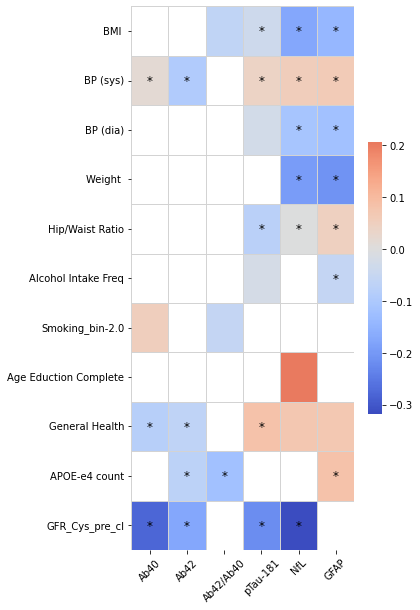

In [939]:
vars_show=['Age-2.0',bbd['gSex'],bbd['BMI']+'-2.0','4080-2.0','4079-2.0','21002-2.0','Hip/Waist-2.0',\
   'Alcohol-2.0','Smoking_bin-2.0','845-2.0','Deprivation','738-2.0','709-2.0','Ethnicity(White)',\
     '20018-2.0','adni_mean_cl-2.0','cog_vars_gi-2.0','GeneralHealth-2.0',\
       'APOE_score','GFR_Cys_pre_cl']
vars_show=vars_show[2:]#+vars_bool
assays = ['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl', 'NfL_regPl', 'GFAP_regPl']# + ['P_TREM2','P_AXL','P_TYRO3','P_MIF','P_C1QA', 'P_C4BPB','P_IL6','P_IL18']
(table,pvals,pvals_corr,sigs,betas)=model_table(outpts_pre,[a + '_pre_cl' for a in assays],['simp'],vars_show,beta_dirs=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,],returndata=True,diff_models=True,FPR='col')
table=table.rename(columns=cols_translate)
print(table.T.style.format())

ccs=data.loc[all_matched,[a+'_pre_cl' for a in assays]+vars_show].corr().iloc[6:,:6]
ccs=ccs.rename(index=cols_translate)

rows=(pvals<0.05).sum(axis=0)>0
#els=(pvals<0.05)
ccs_good_labels=ccs.index[rows]
ccs_good=ccs.values[rows]
ccs_good.shape
mask=((pvals.T)[rows,:]>0.1).astype(bool)


# Set the figure size
plt.figure(figsize=(5,10))

# Create the heatmap
sns.heatmap(ccs_good, annot=False, fmt=".2f", mask=mask, cmap="coolwarm",  linewidths=0.5, linecolor='lightgrey', cbar=True,  cbar_kws={"shrink": 0.5},center=0)
for i in range(6):
    for j in range(mask.shape[0]):
        if sigs[:,rows][i,j] == 1:
            plt.text(i + 0.5, j + 0.5, "*", ha='center', va='center', color='black', fontsize=12)

# Set the x-axis and y-axis labels using cols_translate
plt.yticks(np.arange(mask.shape[0])+.5, ccs.index[rows], rotation=0)
plt.xticks(np.arange(len(assays))+0.5,[a[:-6] for a in assays],rotation=45)



# Set the title
plt.title("")

# Show the plot
plt.show()



In [940]:
betas.shape

(6, 18)

In [941]:
table=table.rename(index=lambda x: re.sub('_regPl_','',x))
table=table.rename(columns=cols_translate)
table.T.style.format()

Assay,Ab40,Ab42,Ab42/Ab40,pTau-181,NfL,GFAP
n,695,695,688,684,694,696
BMI,0.0866 (p=0.492),-0.0098 (p=0.341),-0.0002 (p=0.092),-0.0066 (p=0.012**),-0.0170 (p=0.000**),-0.0143 (p=0.000**)
BP (sys),-0.0688 (p=0.038**),-0.0082 (p=0.002**),-0.0000 (p=0.168),-0.0018 (p=0.009**),-0.0033 (p=0.000**),-0.0020 (p=0.005**)
BP (dia),0.0012 (p=0.983),-0.0033 (p=0.437),-0.0000 (p=0.257),-0.0025 (p=0.029*),-0.0043 (p=0.000**),-0.0041 (p=0.000**)
Weight,0.0045 (p=0.913),-0.0039 (p=0.244),-0.0000 (p=0.148),-0.0010 (p=0.230),-0.0061 (p=0.000**),-0.0053 (p=0.000**)
Hip/Waist Ratio,-6.2994 (p=0.308),0.1206 (p=0.810),0.0057 (p=0.193),0.3006 (p=0.018**),0.6109 (p=0.000**),0.4026 (p=0.002**)
Alcohol Intake Freq,-0.4687 (p=0.233),-0.0231 (p=0.472),0.0000 (p=0.997),-0.0142 (p=0.079),-0.0058 (p=0.414),-0.0244 (p=0.003**)
Smoking_bin-2.0,6.2218 (p=0.025*),0.0122 (p=0.957),-0.0049 (p=0.014*),-0.0615 (p=0.289),-0.0055 (p=0.912),-0.0598 (p=0.307)
Age Eduction Complete,0.4587 (p=0.469),0.0591 (p=0.122),0.0003 (p=0.415),0.0026 (p=0.845),0.0214 (p=0.027*),0.0114 (p=0.327)
Deprivation,0.0420 (p=0.336),0.0021 (p=0.565),-0.0000 (p=0.927),0.0001 (p=0.939),-0.0005 (p=0.567),-0.0004 (p=0.637)


In [942]:
# vars=['Age-2.0',bbd['gSex'],bbd['BMI']+'-2.0','4080-2.0','4079-2.0','21002-2.0','Hip/Waist-2.0',\
#    'Alcohol-2.0','Smoking-2.0','845-2.0','Deprivation','738-2.0','709-2.0','Ethnicity(White)',\
#      '20018-2.0','adni_mean_cl-2.0','cog_vars_gi-2.0','2178-2.0',\
#        'APOE_score','Case_bin']
# assays = diseases# + ['P_TREM2','P_AXL','P_TYRO3','P_MIF','P_C1QA', 'P_C4BPB','P_IL6','P_IL18']
# #vars=['Age-2.0','22001-0.0','Case','21001-2.0','4080-2.0','Smoking-2.0','APOE_score','cog_vars_gi-2.0','cog_vars_alz-2.0','2178-2.0','adni_mean_cl-2.0']
# (table,pvals,pvals_corr,sigs,betas)=model_table(outpts_pre,[a + '_pre_cl' for a in assays],['simp'],vars,beta_dirs=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,],returndata=True,diff_models=True,FPR='col')
# table=table.rename(columns=cols_translate)
# print(table.T.style.format())

# ccs=data.loc[all_matched,[a+'_pre_cl' for a in assays]+vars].corr().iloc[19:,:19]
# ccs=ccs.rename(index=cols_translate)

# rows=(pvals<0.05).sum(axis=0)>0
# #els=(pvals<0.05)
# ccs_good_labels=ccs.index[rows]
# ccs_good=ccs.values[rows]
# ccs_good.shape
# mask=((pvals.T)[rows,:]>0.05).astype(bool)


# # Set the figure size
# plt.figure(figsize=(5,10))

# # Create the heatmap
# sns.heatmap(ccs_good, annot=False, fmt=".2f", mask=mask, cmap="coolwarm",  linewidths=0.5, linecolor='lightgrey', cbar=True,  cbar_kws={"shrink": 0.5},center=0)
# for i in range(6):
#     for j in range(12):
#         if sigs[:,rows][i,j] == 1:
#             plt.text(i + 0.5, j + 0.5, "*", ha='center', va='center', color='black', fontsize=12)

# # Set the x-axis and y-axis labels using cols_translate
# plt.yticks(np.arange(12)+.5, ccs.index[rows], rotation=0)
# plt.xticks(np.arange(len(assays))+0.5,[a[:-6] for a in assays],rotation=45)



# # Set the title
# plt.title("")

# # Show the plot
# plt.show()

In [943]:
# relationship of disease scores to age etc.
table=table.rename(index=lambda x: re.sub('_regPl_','',x))
table=table.rename(columns=cols_translate)
table.T.style.format()

Assay,Ab40,Ab42,Ab42/Ab40,pTau-181,NfL,GFAP
n,695,695,688,684,694,696
BMI,0.0866 (p=0.492),-0.0098 (p=0.341),-0.0002 (p=0.092),-0.0066 (p=0.012**),-0.0170 (p=0.000**),-0.0143 (p=0.000**)
BP (sys),-0.0688 (p=0.038**),-0.0082 (p=0.002**),-0.0000 (p=0.168),-0.0018 (p=0.009**),-0.0033 (p=0.000**),-0.0020 (p=0.005**)
BP (dia),0.0012 (p=0.983),-0.0033 (p=0.437),-0.0000 (p=0.257),-0.0025 (p=0.029*),-0.0043 (p=0.000**),-0.0041 (p=0.000**)
Weight,0.0045 (p=0.913),-0.0039 (p=0.244),-0.0000 (p=0.148),-0.0010 (p=0.230),-0.0061 (p=0.000**),-0.0053 (p=0.000**)
Hip/Waist Ratio,-6.2994 (p=0.308),0.1206 (p=0.810),0.0057 (p=0.193),0.3006 (p=0.018**),0.6109 (p=0.000**),0.4026 (p=0.002**)
Alcohol Intake Freq,-0.4687 (p=0.233),-0.0231 (p=0.472),0.0000 (p=0.997),-0.0142 (p=0.079),-0.0058 (p=0.414),-0.0244 (p=0.003**)
Smoking_bin-2.0,6.2218 (p=0.025*),0.0122 (p=0.957),-0.0049 (p=0.014*),-0.0615 (p=0.289),-0.0055 (p=0.912),-0.0598 (p=0.307)
Age Eduction Complete,0.4587 (p=0.469),0.0591 (p=0.122),0.0003 (p=0.415),0.0026 (p=0.845),0.0214 (p=0.027*),0.0114 (p=0.327)
Deprivation,0.0420 (p=0.336),0.0021 (p=0.565),-0.0000 (p=0.927),0.0001 (p=0.939),-0.0005 (p=0.567),-0.0004 (p=0.637)


In [944]:
assays = ['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl', 'NfL_regPl', 'GFAP_regPl']# + ['P_TREM2','P_AXL','P_TYRO3','P_MIF','P_C1QA', 'P_C4BPB','P_IL6','P_IL18']
#vars=['Age-2.0','22001-0.0','Case','21001-2.0','4080-2.0','Smoking-2.0','APOE_score','cog_vars_gi-2.0','cog_vars_alz-2.0','2178-2.0','adni_mean_cl-2.0']
table=model_table(outpts_pre,[a + '_pre_cl' for a in assays],['simp'],vars,beta_dirs=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,],diff_models=True,FPR='col')
table=table.rename(columns=cols_translate)
table.T.style.format()

Assay,Ab40_regPl_,Ab42_regPl_,Ab42/Ab40_regPl_,pTau-181_regPl_,NfL_regPl_,GFAP_regPl_
n,1229,1231,1216,1213,1231,1233
Age,0.5207 (p=0.000**),0.0035 (p=0.546),-0.0004 (p=0.000**),0.0106 (p=0.000**),0.0261 (p=0.000**),0.0250 (p=0.000**)
Genetic Sex,0.3066 (p=0.767),-0.0146 (p=0.863),-0.0009 (p=0.212),0.0965 (p=0.000**),-0.0161 (p=0.394),-0.1210 (p=0.000**)
BMI,0.0866 (p=0.492),-0.0098 (p=0.341),-0.0002 (p=0.092),-0.0066 (p=0.012**),-0.0170 (p=0.000**),-0.0143 (p=0.000**)
BP (sys),-0.0688 (p=0.038**),-0.0082 (p=0.002**),-0.0000 (p=0.168),-0.0018 (p=0.009**),-0.0033 (p=0.000**),-0.0020 (p=0.005**)
BP (dia),0.0012 (p=0.983),-0.0033 (p=0.437),-0.0000 (p=0.257),-0.0025 (p=0.029*),-0.0043 (p=0.000**),-0.0041 (p=0.000**)
Weight,0.0045 (p=0.913),-0.0039 (p=0.244),-0.0000 (p=0.148),-0.0010 (p=0.230),-0.0061 (p=0.000**),-0.0053 (p=0.000**)
Hip/Waist Ratio,-6.2994 (p=0.308),0.1206 (p=0.810),0.0057 (p=0.193),0.3006 (p=0.018**),0.6109 (p=0.000**),0.4026 (p=0.002**)
Alcohol Intake Freq,-0.4687 (p=0.233),-0.0231 (p=0.472),0.0000 (p=0.997),-0.0142 (p=0.079),-0.0058 (p=0.414),-0.0244 (p=0.003**)
Age Eduction Complete,0.4587 (p=0.469),0.0591 (p=0.122),0.0003 (p=0.415),0.0026 (p=0.845),0.0214 (p=0.027*),0.0114 (p=0.327)


In [949]:
# assays = ['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl', 'NfL_regPl', 'GFAP_regPl']# + ['P_TREM2','P_AXL','P_TYRO3','P_MIF','P_C1QA', 'P_C4BPB','P_IL6','P_IL18']
#vars=['Age-2.0','22001-0.0','Case_bin','21001-2.0','4080-2.0','Smoking_bin-2.0','APOE_score','cog_vars_gi-2.0','cog_vars_alz-2.0','2178-2.0']
# table=model_table(outpts_pre,[a + '_pre_cl' for a in assays],['ext'],vars,beta_dirs=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,],diff_models=True,FPR='col')
# table=table.rename(columns={'2178-2.0':'General Health','cog_vars_gi-2.0':'Cognition','cog_vars_alz-2.0':'Cognition (AD)','Case':'Case/Control status','Case_hosp_bin':'Hospitalised','assessment_sep':'Assessment Gap','21001-2.0':'BMI','22001-0.0':'Sex','Age-2.0':'Age (pre)','4080-2.0':'BP (sys)','26207-0.0':'AD PRS','A4':'APOE4','Smoking-2.0':'Smoking'})
# table.T.style.format()

In [952]:
# OLINK assays
# #assays = ['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl', 'NfL_regPl', 'GFAP_regPl']# + ['P_TREM2','P_AXL','P_TYRO3','P_MIF','P_C1QA', 'P_C4BPB','P_IL6','P_IL18']
# vars=['Age-2.0','22001-0.0','Case','21001-2.0','4080-2.0','Smoking-2.0','APOE_score','cog_vars_gi-2.0','cog_vars_alz-2.0','2178-2.0']
# table=model_table(outpts_pre,[a + '_pre_cl' for a in OLINK_assays],['ext'],vars,beta_dirs=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,],diff_models=True,FPR='col')
# table=table.rename(columns={'2178-2.0':'General Health','cog_vars_gi-2.0':'Cognition','cog_vars_alz-2.0':'Cognition (AD)','Case':'Case/Control status','Case_hosp_bin':'Hospitalised','assessment_sep':'Assessment Gap','21001-2.0':'BMI','22001-0.0':'Sex','Age-2.0':'Age (pre)','4080-2.0':'BP (sys)','26207-0.0':'AD PRS','A4':'APOE4','Smoking-2.0':'Smoking'})
# table.T.style.format()
outpts_pre[IDP+'_'+a+'_simp'].pc

-0.521269923195304

In [957]:
assays = ['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl', 'NfL_regPl', 'GFAP_regPl']
table=model_table(outpts_pre,[a + '_pre_cl' for a in assays],['simp'],vars,beta_dirs=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,],diff_models=True)
table=table.rename(columns={'Case_bin':'Case/Control status','Case_hosp_bin':'Hospitalised','assessment_sep':'Assessment Gap','21001-2.0':'BMI','22001-0.0':'Sex','Age-2.0':'Age','4080-2.0':'BP (sys)','26207-0.0':'AD PRS','A4':'APOE4'})
table.T.style.format()

Assay,Ab40_regPl_,Ab42_regPl_,Ab42/Ab40_regPl_,pTau-181_regPl_,NfL_regPl_,GFAP_regPl_
n,1229,1231,1216,1213,1231,1233
Age,0.5207 (p=0.000**),0.0035 (p=0.546),-0.0004 (p=0.000**),0.0106 (p=0.000**),0.0261 (p=0.000**),0.0250 (p=0.000**)
Sex,0.3066 (p=0.767),-0.0146 (p=0.863),-0.0009 (p=0.212),0.0965 (p=0.000**),-0.0161 (p=0.394),-0.1210 (p=0.000**)
BMI,0.0866 (p=0.492),-0.0098 (p=0.341),-0.0002 (p=0.092),-0.0066 (p=0.012**),-0.0170 (p=0.000**),-0.0143 (p=0.000**)
BP (sys),-0.0688 (p=0.038*),-0.0082 (p=0.002**),-0.0000 (p=0.168),-0.0018 (p=0.009**),-0.0033 (p=0.000**),-0.0020 (p=0.005**)
4079-2.0,0.0012 (p=0.983),-0.0033 (p=0.437),-0.0000 (p=0.257),-0.0025 (p=0.029*),-0.0043 (p=0.000**),-0.0041 (p=0.000**)
21002-2.0,0.0045 (p=0.913),-0.0039 (p=0.244),-0.0000 (p=0.148),-0.0010 (p=0.230),-0.0061 (p=0.000**),-0.0053 (p=0.000**)
Hip/Waist-2.0,-6.2994 (p=0.308),0.1206 (p=0.810),0.0057 (p=0.193),0.3006 (p=0.018*),0.6109 (p=0.000**),0.4026 (p=0.002**)
Alcohol-2.0,-0.4687 (p=0.233),-0.0231 (p=0.472),0.0000 (p=0.997),-0.0142 (p=0.079),-0.0058 (p=0.414),-0.0244 (p=0.003**)
845-2.0,0.4587 (p=0.469),0.0591 (p=0.122),0.0003 (p=0.415),0.0026 (p=0.845),0.0214 (p=0.027*),0.0114 (p=0.327)


In [958]:
table=model_table(outpts_pre,[a + '_pre_cl' for a in assays],['ext'],[a+'' for a in vars ],beta_dirs=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,],diff_models=True)
table=table.rename(columns={'Case_bin':'Case/Control status','Case_hosp_bin':'Hospitalised','assessment_sep':'Assessment Gap','21001-2.0':'BMI','22001-0.0':'Sex','Age-2.0':'Age','4080-2.0':'BP (sys)','26207-0.0':'AD PRS','A4':'APOE4'})
table.T.style.format()

Assay,Ab40_regPl_,Ab42_regPl_,Ab42/Ab40_regPl_,pTau-181_regPl_,NfL_regPl_,GFAP_regPl_
n,696,696,688,685,695,696
Age,0.6861 (p=0.000**),0.0253 (p=0.006*),-0.0003 (p=0.001**),0.0101 (p=0.000**),0.0277 (p=0.000**),0.0229 (p=0.000**)
Sex,-0.8823 (p=0.632),0.0103 (p=0.946),-0.0000 (p=0.987),0.1498 (p=0.000**),0.0701 (p=0.034*),-0.1016 (p=0.010**)
BMI,-0.0042 (p=0.982),-0.0123 (p=0.423),-0.0002 (p=0.284),-0.0067 (p=0.094),-0.0125 (p=0.000**),-0.0140 (p=0.000**)
BP (sys),-0.1757 (p=0.001**),-0.0163 (p=0.000**),-0.0000 (p=0.414),-0.0014 (p=0.238),-0.0023 (p=0.017*),0.0009 (p=0.452)
4079-2.0,0.1881 (p=0.030*),0.0119 (p=0.092),-0.0000 (p=0.568),-0.0003 (p=0.884),-0.0003 (p=0.828),-0.0027 (p=0.148)
21002-2.0,-0.0238 (p=0.830),-0.0018 (p=0.845),-0.0000 (p=0.575),0.0053 (p=0.027*),-0.0047 (p=0.018*),-0.0022 (p=0.356)
Hip/Waist-2.0,-11.3045 (p=0.182),-0.2811 (p=0.686),0.0030 (p=0.636),0.1291 (p=0.481),0.2888 (p=0.058),-0.1195 (p=0.511)
Alcohol-2.0,9.8934 (p=0.000**),1.0649 (p=0.000**),0.0164 (p=0.000**),0.0301 (p=0.603),0.1814 (p=0.000**),0.5725 (p=0.000**)
845-2.0,0.1715 (p=0.791),0.0255 (p=0.525),0.0002 (p=0.569),-0.0001 (p=0.992),0.0116 (p=0.310),0.0067 (p=0.578)


In [962]:
# Genetics correlatios

table=model_table(outpts_pre,[a + '_pre_cl' for a in SIMOA_assays],['simp'],[a+'' for a in vars_genetics ],beta_dirs=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,],diff_models=True)
table=table.rename(columns={'Case_bin':'Case/Control status','Case_hosp_bin':'Hospitalised','assessment_sep':'Assessment Gap','21001-2.0':'BMI','22001-0.0':'Sex','Age-2.0':'Age','4080-2.0':'BP (sys)','26207-0.0':'AD PRS','A4':'APOE4'})
table.T.style.format()

Assay,Ab40_regPl_,Ab42_regPl_,Ab42/Ab40_regPl_,pTau-181_regPl_,NfL_regPl_,GFAP_regPl_
n,1228,1230,1215,1212,1230,1232
APOE4,2.9282 (p=0.129),-0.1686 (p=0.292),-0.0041 (p=0.004**),0.0422 (p=0.295),0.0161 (p=0.646),0.0376 (p=0.350)
ABCA7,2.2418 (p=0.727),0.3214 (p=0.539),0.0015 (p=0.752),0.0341 (p=0.794),0.1352 (p=0.246),0.1815 (p=0.182)
APOE,-15.8862 (p=0.135),-1.3396 (p=0.128),-0.0000 (p=0.999),-0.0422 (p=0.847),-0.3257 (p=0.092),-0.0108 (p=0.961)
BDNF,-1.0271 (p=0.515),-0.2586 (p=0.044*),-0.0010 (p=0.356),-0.0197 (p=0.543),-0.0158 (p=0.579),-0.0039 (p=0.907)
CLU,0.1991 (p=0.896),-0.0137 (p=0.912),-0.0011 (p=0.318),0.0396 (p=0.208),0.0487 (p=0.081),0.0167 (p=0.604)
PICALM,1.4681 (p=0.507),0.0795 (p=0.660),-0.0005 (p=0.764),0.0488 (p=0.280),0.0363 (p=0.369),-0.0269 (p=0.566)
SORL1,6.4647 (p=0.619),0.2437 (p=0.819),-0.0015 (p=0.875),0.0373 (p=0.888),0.3075 (p=0.193),0.3151 (p=0.251)
TREM2,8.7727 (p=0.083),0.3501 (p=0.397),-0.0033 (p=0.370),-0.0778 (p=0.451),-0.0866 (p=0.346),0.1370 (p=0.201)
WWTR1,5.3458 (p=0.009*),0.4516 (p=0.008*),0.0009 (p=0.567),0.0105 (p=0.805),0.0867 (p=0.021*),0.0173 (p=0.692)


In [ ]:
# table=model_table(outpts_pre,[a + '_pre_cl' for a in assays],['simp'],[a +'-2.0' for a in imaging_vars ],beta_dirs=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,],diff_models=True)
# table=table.rename(columns={'Case_bin':'Case/Control status','Case_hosp_bin':'Hospitalised','assessment_sep':'Assessment Gap','21001-2.0':'BMI','22001-0.0':'Sex','Age-2.0':'Age','4080-2.0':'BP (sys)','26207-0.0':'AD PRS','A4':'APOE4'})
# table.T.style.format()

## Testing GFR

In [963]:

els=all_matched
for b in SIMOA_assays :#+ diseases:
    ext='-2.0'
    IDP=b+'_pre_cl'
    for a in  vars + [b+'_cl' for b in imaging_vars_2 ]+  ['adni_mean_cl-2.0','2178-2.0','Age-2.0','22001-0.0','Case_bin','APOE_score',bbd['gSex']]:# vars+vars_genetics:
        print(a,end=" ")
        # ensure all data is matched
        els=(data.loc[:,IDP].notnull())&(data.loc[:,IDP].notnull())&all_case #&(data.loc[:,'A4'].notna()) #(((data.loc[:,'COVID']=='COVID'))&&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
        ids=data.loc[data.loc[els,'matched_eid'].dropna(),IDP].dropna().index
        ids2=data.loc[ids,'matched_eid']
        els[:]=False
        els[ids]=True
        els[ids2]=True
        
        outpts_pre[IDP+'_'+a+'_simp_GFR']=ols_simp(formula="   Q('"+ IDP + "')   ~  Q('Age"+ext+"')  +Q('"+bbd['gSex']+"') + Q('" + a + "') + Q('NfL_regPl_pre_cl')+ Q('GFAP_regPl_pre_cl') ", data=data[els],pre=IDP,case="Q('" + a + "')").fit()
        outpts_pre[IDP+'_'+a+'_ext_GFR']=ols_simp(formula="   Q('"+ IDP + "')   ~   Q('Age"+ext+"')  +Q('"+bbd['gSex']+"')+ \
            Q('"+bbd['BMI']+ext+"')  + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709"+ext+"') + Q('Hip/Waist"+ext+"') + \
                Q('"+bbd['BP_sys']+ext+"') + Q('"+bbd['BP_dia']+ext+"') + Q('"+bbd['Activity']+"-0.0') \
                    + (Q('"+bbd['Alcohol']+ext+"')) + Q('Deprivation') + C(Q('Ethnicity(White)')) + \
                        (Q('Smoking"+ext+"')) + Q('APOE_score') + Q('" + a + "') ", data=data[els],pre=IDP,case="Q('" + a + "')").fit()
        #outpts_pre[IDP+'_'+a+'_ext_case']=ols_simp(formula="   Q('"+ IDP + "')   ~   Q('Age"+ext+"') + Case_bin +Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+ext+"')  + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709"+ext+"') + Q('Hip/Waist"+ext+"') + Q('"+bbd['BP_sys']+ext+"') + Q('"+bbd['BP_dia']+ext+"') + Q('"+bbd['Activity']+"-0.0') + (Q('"+bbd['Alcohol']+ext+"')) + Q('Deprivation') + C(Q('Ethnicity(White)')) + (Q('Smoking"+ext+"')) + Q('APOE_score') + C(Q('" + a + "')) ", data=data[els]).fit()
          
        #outpts[IDP+'_simp']=smf.ols(formula="   Q('"+ IDP + "')   ~ C(Case)   +  Q('"+bbd['gSex']+"')  + Q('cog_vars_alz"+ext+"') +  Q('Age"+ext+"')   ", data=data[els]).fit()
        #outpts[IDP+'_simp_gi']=smf.ols(formula="   Q('"+ IDP + "')   ~ C(Case)  +    Q('Age"+ext+"')  + Q('assessment_sep')+ Q('"+bbd['gSex']+"')  + Q('A4_bin')+ Q('cog_vars_gi"+ext+"') ", data=data[els]).fit()
        #outpts[IDP+'_simp_alz']=smf.ols(formula="   Q('"+ IDP + "')   ~ C(Case)  +    Q('Age"+ext+"')  + Q('assessment_sep')+ Q('"+bbd['gSex']+"')  + Q('A4_bin')+ Q('cog_vars_alz"+ext+"') ", data=data[els]).fit()
    
    

Age-2.0 22001-0.0 21001-2.0 4080-2.0 4079-2.0 21002-2.0 Hip/Waist-2.0 21001-2.0 Alcohol-2.0 845-2.0 Deprivation 738-2.0 709-2.0 6350-2.0 20018-2.0 894-2.0 adni_mean_cl-2.0 cog_vars_alz-2.0 cog_vars_gi-2.0 GeneralHealth-2.0 APOE_score Case_bin GFR_Cys_pre_cl Ethnicity(White) A33vA34 A33vA44 31-0.0 26593-2.0_cl 27177-2.0_cl 27004-2.0_cl 27183-2.0_cl 25093-2.0_cl 25494-2.0_cl 26562-2.0_cl 25793-2.0_cl 27202-2.0_cl 27200-2.0_cl 27293-2.0_cl 27146-2.0_cl 27239-2.0_cl 26562-2.0_cl 26593-2.0_cl 26641-2.0_cl 26663-2.0_cl 25886-2.0_cl 25887-2.0_cl 25019-2.0_cl 25020-2.0_cl 27432-2.0_cl 27654-2.0_cl 26779-2.0_cl 27196-2.0_cl 26880-2.0_cl 27289-2.0_cl 27177-2.0_cl 27270-2.0_cl adni_mean_cl-2.0 2178-2.0 Age-2.0 22001-0.0 Case_bin APOE_score 22001-0.0 Age-2.0 22001-0.0 21001-2.0 4080-2.0 4079-2.0 21002-2.0 Hip/Waist-2.0 21001-2.0 Alcohol-2.0 845-2.0 Deprivation 738-2.0 709-2.0 6350-2.0 20018-2.0 894-2.0 adni_mean_cl-2.0 cog_vars_alz-2.0 cog_vars_gi-2.0 GeneralHealth-2.0 APOE_score Case_bin GFR_Cys_

KeyboardInterrupt: 

In [ ]:
vars=['Age-2.0',bbd['gSex'],bbd['BMI']+'-2.0','4080-2.0','4079-2.0','21002-2.0','Hip/Waist-2.0',\
   'Alcohol-2.0','Smoking-2.0','845-2.0','Deprivation','738-2.0','709-2.0','Ethnicity(White)',\
     '20018-2.0','adni_mean_cl-2.0','cog_vars_gi-2.0','GeneralHealth-2.0',\
       'APOE_score','GFR-0.0']
assays = ['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl']#, 'NfL_regPl', 'GFAP_regPl']# + ['P_TREM2','P_AXL','P_TYRO3','P_MIF','P_C1QA', 'P_C4BPB','P_IL6','P_IL18']
#vars=['Age-2.0','22001-0.0','Case','21001-2.0','4080-2.0','Smoking-2.0','APOE_score','cog_vars_gi-2.0','cog_vars_alz-2.0','2178-2.0','adni_mean_cl-2.0']
(table,pvals,pvals_corr,sigs,betas)=model_table(outpts_pre,[a + '_pre_cl' for a in assays],['simp'],vars,beta_dirs=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,],returndata=True,diff_models=True,FPR='col')
table=table.rename(columns=cols_translate)
print(table.T.style.format())

ccs=data.loc[all_matched,[a+'_pre_cl' for a in assays]+vars].corr().iloc[4:,:4]
ccs=ccs.rename(index=cols_translate)

rows=(pvals<0.05).sum(axis=0)>0
#els=(pvals<0.05)
ccs_good_labels=ccs.index[rows]
ccs_good=ccs.values[rows]
vars_good=ccs_good.shape[0]
mask=((pvals.T)[rows,:]>0.05).astype(bool)


# Set the figure size
plt.figure(figsize=(5,10))

# Create the heatmap
sns.heatmap(ccs_good, annot=False, fmt=".2f", mask=mask, cmap="coolwarm",  linewidths=0.5, linecolor='lightgrey', cbar=True,  cbar_kws={"shrink": 0.5},center=0)
for i in range(4):
    for j in range(vars_good):
        if sigs[:,rows][i,j] == 1:
            plt.text(i + 0.5, j + 0.5, "*", ha='center', va='center', color='black', fontsize=12)

# Set the x-axis and y-axis labels using cols_translate
plt.yticks(np.arange(vars_good)+.5, ccs.index[rows], rotation=0)
plt.xticks(np.arange(len(assays))+0.5,[a[:-4] for a in assays],rotation=45)



# Set the title
plt.title("")

# Show the plot
plt.show()

In [964]:
#a='regPl_pre_cl_GFR-0.0'
#IDP='Ab42'
#outpts_pre[IDP+'_'+a+'_ext_GFR'].pvalues
#(data.loc[:,find_vars(data,'P_*0')])
data.loc[:,'GFR-0.0']

KeyError: 'GFR-0.0'

In [966]:
a='regPl_pre_cl_GFR-0.0'
IDP='Ab40'
outpts_pre[IDP+'_'+a+'_ext'].pvalues

KeyError: 'Ab40_regPl_pre_cl_GFR-0.0_ext'

In [965]:

outpts_pre[IDP+'_'+a+'_ext'].pvalues

Intercept                         0.000001
C(KeyWorker)[T.True]              0.156381
C(WorkingThroughCOVID)[T.True]    0.227485
C(Q('Ethnicity(White)'))[T.1]     0.081846
Q('Age-2.0')                      0.009548
Q('22001-0.0')                    0.968413
Q('21001-2.0')                    0.376032
Q('709-2.0')                      0.147656
Q('Hip/Waist-2.0')                0.626471
Q('4080-2.0')                     0.000261
Q('4079-2.0')                     0.104464
Q('22034-0.0')                    0.636358
Q('1558-2.0')                     0.217900
Q('Deprivation')                  0.107191
Q('Smoking-2.0')                  0.802755
Q('APOE_score')                   0.014315
Q('adni_mean_cl-2.0')             0.878402
dtype: float64

In [ ]:
[ key for  key in outpts_pre.keys() if 'GFR-' in key ]

In [ ]:
find_vars(data,'_WFDC2')

In [ ]:
GFR_corrs=data.loc[:,['GFR-0.0']+[a + '_0' for a in OLINK_assays_all]].corr().iloc[1:,:1]


In [ ]:
GFR_corrs.sort_values('GFR-0.0')[:30]

In [ ]:
EGFR_prots=['P_COLEC12','P_XG','P_CST3','P_OGN','P_CLMP']

In [ ]:
data.loc[all_matched,[a+'_pre_cl' for a in assays]+vars].corr()

## predicting  post from pre

In [967]:

assays_regPl=['Ab40_regPl',
 'Ab42_regPl',
 'Ab42/Ab40_regPl',
 'pTau-181_regPl',
 'NfL_regPl',
 'GFAP_regPl',
 'P_NEFL',
 'P_GFAP',
 'P_TREM2',
 'P_AXL',
 'P_TYRO3',
 'P_MIF',
 'P_C1QA',
 'P_C4BPB',
 'P_IL6',
 'P_IL18']

In [1222]:

# subgroup analyses : co-morbidities, sex

for a in [ 'post_cl']:
   for b in  SIMOA_assays: # OLINK_assays_final[-14:]:#  : # [-2:]:#+  : #  + diseases SIMOA_assays + OLINK_assays + diseases +  SIMOA_assays  # ['Ab42','Ab40','Ab42/Ab40','GFAP','pTau-181','NfL']:
        
        for c in ['']:
            IDP=b+"_"+c+a # " regPl_
            IDP_pre=b+"_" +c+'pre_cl'#"cl" # " regPl_
            # matched data only (no missing for IDP)
            els=all_matched
                        # matched data only (no missing)
            els=(data.loc[:,IDP].notnull())&(data.loc[:,IDP].notnull())&all_case #&(data.loc[:,'matched_age_mean']>60) #&elsA44 # & (data.loc[:,'COVID']=='COVID') #&(data.loc[:,'A4'].notna()) #(&&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
            ids=data.loc[data.loc[els,'matched_eid'].dropna(),IDP].dropna().index
            ids2=data.loc[ids,'matched_eid']
            els[:]=False
            els[ids]=True
            els[ids2]=True
            # els=all_case&(data.loc[:,IDP].notnull())#&(data.loc[:,'Gender_pre']=='Female') #&(data['Diabetes']==False)&(data['BP_meds']==False)&(data['Heart_Cond']==False) #&(data.loc[:,'matched_age_mean']>60) #&elsA44 # & (data.loc[:,'COVID']=='COVID') #&(data.loc[:,'A4'].notna()) #(&&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
            # ids=data.loc[els,'matched_eid'].dropna().values
            # ids=data.loc[ids,IDP].notnull().index
            # ids2=data.loc[ids,'matched_eid'].values
            # idels=(data.loc[ids,'KeyWorker'].values==data.loc[ids2,'KeyWorker'].values)  &  (data.loc[ids,'Chol_meds'].values==data.loc[ids2,'Chol_meds'].values)  & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values)  & (np.abs((data.loc[ids,'709-2.0'].values-data.loc[ids2,'709-2.0'].values))<2) #& 
            # idels=(data.loc[ids,'KeyWorker'].values==data.loc[ids2,'KeyWorker'].values)  & (data.loc[ids,'Diabetes'].values==data.loc[ids2,'Diabetes'].values)&  (data.loc[ids,'Chol_meds'].values==data.loc[ids2,'Chol_meds'].values)  & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values) # & (np.abs((data.loc[ids,'709-2.0'].values-data.loc[ids2,'709-2.0'].values))<2) #& 
            # els[:]=False
            # els[ids[idels]]=True
            # els[ids2[idels]]=True 

            #els=all_case.copy()# & (data.loc[ids,'KeyWorker'].values==data.loc[ids2,'KeyWorker'].values)  & (data.loc[ids,'Diabetes'].values==data.loc[ids2,'Diabetes'].values) & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values) #&(data['Activity-2.0']<40)

#              ids=data.loc[els,'matched_eid'].dropna().index
#              ids2=data.loc[ids,'matched_eid']
#              els[:]=False
#              els[ids]=True
#              els[ids2]=True 
                
#             idels=(data.loc[ids,'KeyWorker'].values==data.loc[ids2,'KeyWorker'].values)  &  (data.loc[ids,'Chol_meds'].values==data.loc[ids2,'Chol_meds'].values)  & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values) # & (np.abs((data.loc[ids,'709-2.0'].values-data.loc[ids2,'709-2.0'].values))<2) #& 
#             #data.loc[ids,'Activity-2.0']-data.loc[ids2,'Activity-2.0']
#             els[:]=False
#             els[ids[idels]]=True
#             els[ids2[idels]]=True 

            
            
            #outpts[IDP+'_simp_modpre_adni']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin*Q('adni_mean_cl-2.0')   + Q('Age-3.0^2') +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"')  + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
            #outpts[IDP+'_ext_modpre_adni']=ols_simp(formula="   Q('"+ IDP + "')   ~ Case_bin*Q('adni_mean_cl-2.0')   + Q('Age-3.0^2')+Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)

            #outpts[IDP+'_simp_modpre_adni_only']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin + Q('adni_mean_cl-2.0')   + Q('Age-3.0^2') +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
            #outpts[IDP+'_ext_modpre_adni_only']=ols_simp(formula="   Q('"+ IDP + "')   ~ Case_bin + Q('adni_mean_cl-2.0')   + Q('Age-3.0^2')+Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)

            print(b)
            
#             for OLa in OLINK_assays_final[-14:]: 
                
#                 for pp in ['pre','post','diff']:
#                     outpts[IDP+'_'+OLa+'_'+pp+'_simp_modpre']=ols_simp(formula="   Q('"+ IDP + "')   ~    C(Case)+C(Case_bin):Q('"+OLa+'_'+pp+'_cl'+"')   +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2')  + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
#                     outpts[IDP+'_'+OLa+'_'+pp+'_simp_modpre_hosp_bin']=ols_simp(formula="   Q('"+ IDP + "')   ~   Q('Age-3.0^2') + C(Case_hosp)+C(Case_hosp):Q('"+OLa+'_'+pp+'_cl'+"')  + Q('Activity-2.0') +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
#                     outpts[IDP+'_'+OLa+'_'+pp+'_simp_modpre_f']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin:Q('Age-3.0_f') + C(Case_bin):Q('Age-3.0_f'):Q('"+OLa+'_'+pp+'_cl'+"') +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
            
#                     #outpts[IDP+'_'+OLa+'_'+pp+'_simp_modpre_hosp_bin']=ols_simp(formula="   Q('"+ IDP + "')   ~   Q('Age-3.0^2') + C(Case_hosp_bin_only)+C(Case_hosp_bin_only):Q('"+OLa+'_'+pp+'_cl'+"')  + C(Case_nohosp_bin_only)+ C(Case_nohosp_bin_only):Q('"+OLa+'_'+pp+'_cl'+"')  + Q('Activity-2.0') +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
#                     #outpts[IDP+'_ext_modpre_hosp_bin']=ols_simp(formula="   Q('"+ IDP + "')   ~    + Q('Age-3.0^2') +Q('Age-3.0')  + (Case_hosp_bin_only) + Q('Activity-2.0') + (Case_nohosp_bin_only)   + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)
            

            #    #outpts[IDP+'_ext_modpre_'+OLa]=ols_simp(formula="   Q('"+ IDP + "')   ~  C(Case_bin)*Q('"+OLa+'_pre_cl'+"') + Q('Age-3.0^2') +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0')) + Q('APOE_score')  ", data=data[els],pre=IDP_pre).fit() # + C(PlateID_pre) + C(PlateID_post)

            #for OLa in ['GFR-0.0']: 
            #    outpts[IDP+'_simp_modpre_'+OLa]=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin + C(Case_bin):Q('"+OLa+"')   +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2')  + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "') + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0')     ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
            #    outpts[IDP+'_ext_modpre_'+OLa]=ols_simp(formula="   Q('"+ IDP + "')   ~ Case_bin + C(Case_bin):Q('"+OLa+"') + Q('Age-3.0^2') +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0')) + Q('APOE_score')  ", data=data[els],pre=IDP_pre).fit() # + C(PlateID_pre) + C(PlateID_post)
           
            outpts[IDP+'_simp_modpre']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin  +Q('Age-3.0')+ Q('assessment_sep^2') + Q('assessment_sep')+  C(Q('Gender_pre'))  + Q('"+ IDP_pre + "')  + Q('"+bbd['BMI']+"-3.0')   ",data=data[els],pre=IDP_pre).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
            #outpts[IDP+'_simp_modpre_hosp_bin']=ols_simp(formula="   Q('"+ IDP + "')   ~    (Case_hosp_bin_only)  + (Case_nohosp_bin_only)  +Q('Age-2.0') + Q('assessment_sep')+  C(Q('Gender_pre'))  + Q('"+ IDP_pre + "')  + Q('"+bbd['BMI']+"-2.0') + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0')  ",data=data[els]).fit() _pre + "')  + Q('"+bbd['BMI']+"-3.0') + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0')  ",data=data[els]).fit() # +  Q('"+bbd['gS# +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
            outpts[IDP+'_simp_modpre_ff']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin*Q('Age-3.0_f')  +Q('Age-3.0')+ Q('assessment_sep^2') + Q('assessment_sep')+  Q('"+bbd['gSex']+"') + Q('"+ IDP_pre + "')  + Q('"+bbd['BMI']+"-3.0')   ",data=data[els],pre=IDP_pre).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
            
            #outpts[IDP+'_simp_modpre_hosp_bin']=ols_simp(formula="   Q('"+ IDP + "')   ~    (Case_hosp_bin_only)  + (Case_nohosp_bin_only) +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
            
            
            #outpts[IDP+]=ols_simp(formula="   Q('"+ IDP + "')   ~    (Case_hosp_bin_only)  + (Case_nohosp_bin_only) +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
            
            #outpts[IDP+'_simp_modpre']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin  +Q('Age-3.0') + Q('assessment_sep')+  Q('"+bbd['gSex']+"')  + Q('"+ IDP_pre + "') +Q('GFR_Cys_diff_cl') + Q('"+bbd['BMI']+"-3.0')",data=data[els],pre=IDP_pre).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
           
            outpts[IDP+'_ext_modpre']=ols_simp(formula="   Q('"+ IDP + "')   ~  Diabetes + BP_meds + Chol_meds + Case_bin + Q('Age-3.0^2') +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep') +Q('GFR_Cys_pre_cl') + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0')) + Q('APOE_score') + C(Q('Diabetes')) + C(Q('Heart_Cond'))  ", data=data[els],pre=IDP_pre).fit() # + C(PlateID_pre) + C(PlateID_post)
            
            #outpts[IDP+'_simp_modpre_hosp']=ols_simp(formula="   Q('"+ IDP + "')   ~   Q('Age-3.0^2') + C(Case_hosp)    +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
            #outpts[IDP+'_ext_modpre_hosp']=ols_simp(formula="   Q('"+ IDP + "')   ~  C(Case_hosp)  + Q('Age-3.0^2') +Q('Age-3.0')    + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"') +Q('GFR_Cys_pre_cl')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)
            
            outpts[IDP+'_simp_modpre_hosp_bin']=ols_simp(formula="   Q('"+ IDP + "')   ~    (Case_hosp_bin_only)  + (Case_nohosp_bin_only) +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
            outpts[IDP+'_ext_modpre_hosp_bin']=ols_simp(formula="   Q('"+ IDP + "')   ~     Q('Age-3.0^2') +Q('Age-3.0')  + (Case_hosp_bin_only) + Q('Activity-2.0') + (Case_nohosp_bin_only)   + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)

            
            outpts[IDP+'_simp_modpre_timepos']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin+Q('time_since_pos') + Q('Age-3.0^2')   +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
            outpts[IDP+'_ext_modpre_timepos']=ols_simp(formula="   Q('"+ IDP + "')   ~ Case_bin+Q('time_since_pos') + Q('Age-3.0^2')  +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)

            outpts[IDP+'_simp_modpre_f']=ols_simp(formula="   Q('"+ IDP + "')   ~ Diabetes + BP_meds + Chol_meds +  Case_bin*Q('Age-3.0_f')   +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
            
            outpts[IDP+'_ext_modpre_f']=ols_simp(formula="   Q('"+ IDP + "')   ~  Diabetes + BP_meds + Chol_meds + Case_bin*Q('Age-3.0_f')  +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('Activity-2.0') + Q('assessment_sep')  + Q('"+bbd['gSex']+"')+Q('GFR_Cys_pre_cl')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)
            
            
            #outpts[IDP+'_simp_modpre_sex']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin*Q('"+bbd['gSex']+"')   +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2')  + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
            #outpts[IDP+'_ext_modpre_sex']=ols_simp(formula="   Q('"+ IDP + "')   ~ Case_bin*Q('"+bbd['gSex']+"')  +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  +  Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)
   
 
            # outpts[IDP+'_simp_modpre_APOE']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin*Q('APOE_score')   + Q('Age-3.0^2') +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
            # outpts[IDP+'_ext_modpre_APOE']=ols_simp(formula="   Q('"+ IDP + "')   ~ Case_bin*Q('APOE_score')   + Q('Age-3.0^2')+Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)

            # outpts[IDP+'_simp_modpre_PRS']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin*Q('26206-0.0')   + Q('Age-3.0^2') +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
            # outpts[IDP+'_ext_modpre_PRS']=ols_simp(formula="   Q('"+ IDP + "')   ~ Case_bin*Q('26206-0.0')   + Q('Age-3.0^2')+Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)


            # outpts[IDP+'_simp_modpre_Alz']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin*Q('Alzheimers_dementia_pre_cl')   + Q('Age-3.0^2') +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
            # outpts[IDP+'_ext_modpre_Alz']=ols_simp(formula="   Q('"+ IDP + "')   ~ Case_bin*Q('Alzheimers_dementia_pre_cl')   + Q('Age-3.0^2')+Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)

            # outpts[IDP+'_simp_modpre_Ab']=ols_simp(formula="   Q('"+ IDP + "')   ~  Q('Age-3.0_f'):Case_bin +  Q('Age-3.0_f'):Case_bin:Q('Ab42/Ab40_regPl_pre_cl')  +  Q('Age-3.0_f'):Q('Ab42/Ab40_regPl_pre_cl')  + Q('Age-3.0^2') +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
            # outpts[IDP+'_ext_modpre_Ab']=ols_simp(formula="   Q('"+ IDP + "')   ~ Q('Age-3.0_f'):Case_bin +  Q('Age-3.0_f'):Case_bin:Q('Ab42/Ab40_regPl_pre_cl') +  Q('Age-3.0_f'):Q('Ab42/Ab40_regPl_pre_cl')  + Q('Age-3.0^2')+Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)


            # outpts[IDP+'_simp_modpre_vax']=ols_simp(formula="   Q('"+ IDP + "')   ~  Case_bin + Q('Age-3.0^2') + (Case_vax_prior_bin)  +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
            # outpts[IDP+'_ext_modpre_vax']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin + (Case_vax_prior_bin)  + Q('Age-3.0^2') +Q('Age-3.0')    + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)





Ab40_regPl
Ab42_regPl
Ab42/Ab40_regPl
pTau-181_regPl
NfL_regPl
GFAP_regPl


In [1229]:
# percent change calculations
IDPs=['Ab42/Ab40_regPl_pre_cl']
els=all_case&(data.loc[:,IDP].notnull())#&(data.loc[:,'Gender_pre']=='Female') #&(data['Diabetes']==False)&(data['BP_meds']==False)&(data['Heart_Cond']==False) #&(data.loc[:,'matched_age_mean']>60) #&elsA44 # & (data.loc[:,'COVID']=='COVID') #&(data.loc[:,'A4'].notna()) #(&&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[els,'matched_eid'].dropna().values
ids=data.loc[ids,IDP].notnull().index
ids2=data.loc[ids,'matched_eid'].values
idels=(data.loc[ids,'KeyWorker'].values==data.loc[ids2,'KeyWorker'].values)  & (data.loc[ids,'Diabetes'].values==data.loc[ids2,'Diabetes'].values)&  (data.loc[ids,'Chol_meds'].values==data.loc[ids2,'Chol_meds'].values)  & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values) # & (np.abs((data.loc[ids,'709-2.0'].values-data.loc[ids2,'709-2.0'].values))<2) #& 

els[:]=False
els[ids[idels]]=True
els[ids2[idels]]=True 

for IDP in IDPs: 
    # calculate percentage effect for A34 vs A33
    A3A3_m=data.loc[els&(data['APOE']=='A3A3'),IDP].mean()
    A3A4_m=data.loc[els&(data['APOE']=='A3A4'),IDP].mean()
    A4A4_m=data.loc[els&(data['APOE']=='A4A4'),IDP].mean()
    print('A33-A34 basic: ' + str(100*(A3A4_m-A3A3_m)/A3A3_m))
    print('A33-A44 basic: ' + str(100*(A4A4_m-A3A3_m)/A3A3_m))
    for b in ['Diabetes','Smoking_bin-2.0','22001-0.0','31-0.0','BP_meds','Chol_meds','Obesity-2.0']:
        
        A=data.loc[els&(data[b]==True),IDP].mean()
        B=data.loc[els&(data[b]==False),IDP].mean()

        print(b+ ' basic: ' + str(100*(A-B)/B))
    for b in ['Case']:
        A=data.loc[els&(data[b]=='sars'),IDP].mean()
        B=data.loc[els&(data[b]=='ctr'),IDP].mean()  
        print(b+ 'pre basic: ' + str(100*(A-B)/B))
    for b in ['Case']:
        A=data.loc[els&(data[b]=='sars'),re.sub('pre','post',IDP)].mean()
        B=data.loc[els&(data[b]=='ctr'),re.sub('pre','post',IDP)].mean()  
        print(b+ 'post basic: ' + str(100*(A-B)/B))
        
    #a='APOE'
    #print('APOE - model: ' +str(100*(outpts_pre[IDP+'_'+a+'_simp'].params["C(Q('APOE'))[T.A3A3]"]-outpts_pre[IDP+'_'+a+'_simp'].params["C(Q('APOE'))[T.A3A4]"])/data.loc[els,IDP].mean()))
    #outpts_pre[IDP+'_'+a+'_simp'].params

    # calculate percentage change for A34 vs A33

    IDP='Ab42/Ab40_regPl_post_cl'
    # raw
    A3A3_m=data.loc[els&(data['Case']=='ctr'),IDP].mean()
    A3A4_m=data.loc[els&(data['Case']=='sars'),IDP].mean()
    
    print(100*(A3A3_m-A3A4_m)/A3A3_m)

    # model based
    print('Case_bin - model')
    print(outpts[IDP+'_simp_modpre'].pc)

    print('Case model 2')
    IDP='Ab42/Ab40_regPl_pre_cl'
    a='APOE'
    print(100*(outpts_pre[IDP+'_'+a+'_simp'].params["C(Q('APOE'))[T.A3A3]"]-outpts_pre[IDP+'_'+a+'_simp'].params["C(Q('APOE'))[T.A3A4]"])/data.loc[els,IDP].mean())
    #outpts_pre[IDP+'_'+a+'_simp'].params

    # pc by age



    # pc for Case/Control

    print(outpts['Ab42/Ab40_regPl_post_cl_simp_modpre'].pc)
    #print(outpts['Ab42/Ab40_regPl_post_cl_ext_modpre'].pc)

A33-A34 basic: -2.60272874444532
A33-A44 basic: -7.300048236170124
Diabetes basic: 9.204445091351944
Smoking_bin-2.0 basic: -3.101590918063409
22001-0.0 basic: -2.7580803384312125
31-0.0 basic: nan
BP_meds basic: -2.894073685732675
Chol_meds basic: -8.265600727879715
Obesity-2.0 basic: -1.6426162206555976
Casepre basic: -1.1632648942272072
Casepost basic: -2.81221349791554
2.81221349791554
Case_bin - model
-1.9637942923877403
Case model 2
5.377655266389692
-1.9637942923877403


In [1065]:
idels.sum()

432

In [1067]:
outpts['Ab42/Ab40_regPl_post_cl'+'_simp_modpre'].pvalues

Intercept                          1.256908e-08
C(Q('Gender_pre'))[T.Male]         6.938787e-01
C(KeyWorker)[T.True]               2.723246e-01
C(WorkingThroughCOVID)[T.True]     5.733419e-01
Case_bin                           4.466297e-03
Q('Age-2.0')                       7.296130e-03
Q('assessment_sep')                8.835941e-02
Q('Ab42/Ab40_regPl_pre_cl')       2.017092e-139
Q('21001-2.0')                     3.385056e-01
Q('709-3.0')                       8.078096e-01
dtype: float64

In [1050]:
outpts['Ab42/Ab40_regPl_post_cl'+'_simp_modpre'].pvalues

Intercept                          5.178991e-09
C(Q('Gender_pre'))[T.Male]         9.192237e-01
C(KeyWorker)[T.True]               6.849590e-22
C(WorkingThroughCOVID)[T.True]     5.266956e-01
Case_bin                           7.595656e-03
Q('Age-2.0')                       8.172965e-03
Q('assessment_sep')                8.671454e-03
Q('Ab42/Ab40_regPl_pre_cl')       3.383805e-124
Q('21001-2.0')                     5.169488e-02
Q('709-3.0')                       4.275968e-01
dtype: float64

In [1027]:
outpts['Ab42/Ab40_regPl_post_cl_simp_modpre'].pvalues

Intercept                          1.105313e-11
C(Q('Gender_pre'))[T.Male]         8.468674e-01
C(KeyWorker)[T.True]               8.806716e-01
C(WorkingThroughCOVID)[T.True]     6.828305e-01
Case_bin                           8.845011e-04
Q('Age-2.0')                       4.606004e-02
Q('assessment_sep')                4.109440e-01
Q('Ab42/Ab40_regPl_pre_cl')       1.748884e-203
Q('21001-2.0')                     3.256482e-02
Q('709-3.0')                       4.285534e-01
dtype: float64

In [1030]:
outpts['Ab42/Ab40_regPl_post_cl_simp_modpre'].params

Intercept                         2.650261e-02
C(Q('Gender_pre'))[T.Male]       -9.746358e-05
C(KeyWorker)[T.True]              3.980607e-04
C(WorkingThroughCOVID)[T.True]   -1.153626e-03
Case_bin                         -1.645627e-03
Q('Age-2.0')                     -7.895503e-05
Q('assessment_sep')              -3.910502e-07
Q('Ab42/Ab40_regPl_pre_cl')       7.220370e-01
Q('21001-2.0')                   -1.270179e-04
Q('709-3.0')                      2.017680e-04
dtype: float64

In [1225]:
outpts['Ab42/Ab40_regPl_post_cl_simp_modpre_hosp_bin'].pvalues

Intercept                       1.078667e-11
Case_hosp_bin_only              1.214594e-01
Case_nohosp_bin_only            3.947659e-03
Q('Age-3.0')                    1.847356e-03
Q('assessment_sep')             4.993803e-01
Q('assessment_sep^2')           4.573060e-01
Q('22001-0.0')                  9.127220e-01
Q('21001-3.0')                  2.690295e-02
Q('Ab42/Ab40_regPl_pre_cl')    7.999301e-218
dtype: float64

In [974]:
b='22001-0.0'
A=data.loc[all_matched&(data[b]==True),IDP].mean()
B=data.loc[all_matched&(data[b]==False),IDP].mean()
print(A)
print(B)

0.074751815172912
0.07635971611445043


In [975]:
data.loc[all_matched&(data[b]==False),IDP]

eid
1037025    0.079954
1040749    0.075971
1060006    0.084670
1066102    0.079316
1066123    0.043553
             ...   
5986418    0.067419
5997608    0.086195
5999901    0.084271
6004696    0.091653
6023438    0.065927
Name: Ab42/Ab40_regPl_pre_cl, Length: 654, dtype: float64

In [976]:
print(A3A4_m)

0.07070006904806068


In [1213]:
table=model_table(outpts,assays_regPl[:6],['_post_cl_simp_modpre'],['Case_bin','Age-3.0','assessment_sep'],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.style.format()

,n,Case/Control status,Age(y),Assessment Interval (d)
Assay,,,,
Aβ40,1217,0.6649 (p=0.205),0.3921 (p=0.000**),0.0000 (p=0.724)
Aβ42,1223,-0.1029 (p=0.056),0.0063 (p=0.191),0.0000 (p=0.959)
Aβ42/Aβ40,1206,-0.0015 (p=0.001**),-0.0001 (p=0.007**),-0.0000 (p=0.449)
pTau-181,1208,-0.0066 (p=0.640),0.0076 (p=0.000**),-0.0000 (p=0.043*)
NfL,1225,-0.0051 (p=0.645),0.0071 (p=0.000**),-0.0000 (p=0.232)
GFAP,1228,-0.0045 (p=0.621),0.0090 (p=0.000**),-0.0000 (p=0.103)


In [1123]:
table=model_table(outpts,assays_regPl[:6],['_post_cl_simp_modpre'],['Case_bin','Age-2.0','Gender_pre','assessment_sep',"21001-2.0"],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.style.format()

,n,Case/Control status,Age,Gender_pre,Assessment Interval (d),BMI
Assay,,,,,,
Aβ40,1193,0.7183 (p=0.191),0.3518 (p=0.000**),-1.2980 (p=0.154),0.0026 (p=0.001**),0.1853 (p=0.071)
Aβ42,1197,-0.1178 (p=0.037*),0.0068 (p=0.195),-0.1334 (p=0.067),0.0001 (p=0.034*),0.0060 (p=0.462)
Aβ42/Aβ40,1186,-0.0016 (p=0.001**),-0.0001 (p=0.072),-0.0001 (p=0.881),-0.0000 (p=0.384),-0.0001 (p=0.048*)
pTau-181,1184,-0.0155 (p=0.796),0.0083 (p=0.000**),0.0877 (p=0.000**),0.0000 (p=0.234),-0.0036 (p=0.131)
NfL,1197,-0.0107 (p=0.779),0.0073 (p=0.000**),-0.0106 (p=0.492),0.0001 (p=0.000**),-0.0056 (p=0.002**)
GFAP,1199,-0.0037 (p=0.598),0.0092 (p=0.000**),-0.0427 (p=0.010**),0.0000 (p=0.057),-0.0048 (p=0.009**)


In [1228]:
table=model_table(outpts,assays_regPl[:6],['_post_cl_simp_modpre_hosp_bin'],['Case_no','Case_ho','Age-3.0','assessment_sep'],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.style.format()

,n,Case_no,Case_ho,Age(y),Assessment Interval (d)
Assay,,,,,
Aβ40,1201,0.8480 (p=0.153),-1.6303 (p=0.642),0.4150 (p=0.000**),0.0003 (p=0.947)
Aβ42,1207,-0.0885 (p=0.092),-0.3182 (p=0.188),0.0057 (p=0.238),0.0001 (p=0.761)
Aβ42/Aβ40,1190,-0.0014 (p=0.002**),-0.0041 (p=0.061),-0.0001 (p=0.002**),0.0000 (p=0.499)
pTau-181,1192,-0.0076 (p=0.658),0.1287 (p=0.101),0.0077 (p=0.000**),0.0002 (p=0.049*)
NfL,1209,-0.0070 (p=0.691),0.1134 (p=0.067),0.0071 (p=0.000**),0.0001 (p=0.071)
GFAP,1212,-0.0040 (p=0.607),0.0489 (p=0.271),0.0090 (p=0.000**),0.0001 (p=0.105)


In [1088]:
table=model_table(outpts,assays_regPl[:6],['_post_cl_simp_modpre'],['Case_bin','Age-3.0',"22001-0.0",'assessment_sep',"21001-3.0"],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.style.format()

IndexError: list index out of range

In [1024]:
table=model_table(outpts,assays_regPl[:6],['_post_cl_simp_modpre'],['Case_bin','Age-3.0'],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.style.format()

IndexError: list index out of range

In [ ]:
table=model_table(outpts,assays_regPl[:6],['_post_cl_simp_modpre'],['Case_bin','Age-3.0','assessment_sep',"21001-3.0"],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.style.format()

In [1087]:
table=model_table(outpts,assays_regPl[:6],['_post_cl_simp_modpre'],['Case_bin','Age-3.0','assessment_sep',"21001-3.0"],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.style.format()

IndexError: list index out of range

In [ ]:
table=model_table(outpts,assays_regPl[:6],['_post_cl_simp_modpre'],['Case_bin','Age-3.0',"22001-0.0",'assessment_sep',"21001-3.0"],beta_dirs=[0,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.style.format()

In [ ]:
outpts[

In [ ]:
table=model_table(outpts,assays_regPl[:6],['_post_cl_simp_modpre'],['Case_bin','Age-3.0',"22001-0.0",'assessment_sep',"21001-3.0"],beta_dirs=[0,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.style.format()

In [ ]:
table=model_table(outpts,['GFR_Cys'],['_post_cl_simp_modpre'],['Case_bin','Age-3.0',"22001-0.0",'assessment_sep',"21001-3.0"],beta_dirs=[0,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05,rem_txt=-1)
table=table.rename(columns=cols_translate)
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.style.format()

In [ ]:
table=model_table(outpts,assays_regPl[:6],['_post_cl_simp_modpre'],['Case_bin','Age-3.0',"22001-0.0",'assessment_sep',"21001-3.0"],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.style.format()

In [ ]:
table=model_table(outpts,EGFR_prots,['_post_cl_simp_modpre'],['Case_bin','Age-3.0',"22001-0.0",'assessment_sep',"21001-3.0"],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05,rem_txt=6)
table=table.rename(columns=cols_translate)
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.style.format()

In [ ]:
table=model_table(outpts,assays_regPl[:6],['_post_cl_simp_modpre'],['Case_bin','Age-3.0',"22001-0.0",'assessment_sep',"21001-3.0",'Activity'],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.style.format()

In [ ]:
table=model_table(outpts,assays_regPl[:6],['_post_cl_simp_modpre_GFR'],['Case_bin','Age-3.0',"22001-0.0",'assessment_sep',"21001-3.0"],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.style.format()

In [ ]:
OLINK_assays_final

In [ ]:
table=model_table(outpts,OLINK_assays_final[-14:],['_post_cl_simp_modpre'],['Case_bin','Age-3.0',"22001-0.0",'assessment_sep',"21001-3.0"],beta_dirs=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],FPR='row',alpha=0.05,rem_txt=6)
#table=table.rename(columns=cols_translate)
#table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.style.format()

In [ ]:
table=model_table(outpts,assays_regPl[:6],['_post_cl_ext_modpre'],['Case_bin','Age-3.0',"22001-0.0",'assessment_sep',"21001-3.0","Ethnicity","Alcohol",'APOE_score','4080-3.0'],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.T.style.format()

In [ ]:
table=model_table(outpts,assays_regPl[:6],['_post_cl_ext_modpre'],['Case_bin','Age-3.0',"22001-0.0",'assessment_sep',"21001-3.0","Ethnicity","Alcohol",'APOE_score','4080-3.0','Activity'],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.T.style.format()

In [ ]:
table=model_table(outpts,assays_regPl[:6],['_post_cl_ext_modpre'],['Case_bin','Age-3.0',"22001-0.0",'assessment_sep',"21001-3.0","Ethnicity","Alcohol",'APOE_score','4080-3.0'],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.T.style.format()

In [ ]:
outpts['Ab42/Ab40_regPl_post_cl_simp_modpre_hosp'].pvalues

In [1218]:
table=model_table(outpts,assays_regPl[:6],['_post_cl_simp_modpre_hosp'],['C(Case_hosp)[T.sars]','C(Case_hosp)[T.sars_hosp]',"22001-0.0",'assessment_sep',"21001-3.0"],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,1,1],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table.style.format()

KeyError: 'Ab40_regPl_post_cl_simp_modpre_hosp'

In [ ]:
table=model_table(outpts,[a + '_post_cl' for a in OLINK_assays_final],['_simp_modpre_hosp'],['C(Case_hosp)[T.sars]','C(Case_hosp)[T.sars_hosp]',"22001-0.0",'assessment_sep',"21001-3.0"],beta_dirs=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],beta_vars=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],FPR='col',alpha=0.05)
table=table.rename(columns=cols_translate)
table.style.format()

In [ ]:
outpts[IDP+'_'+'P_MIF'+'_diff' + '_simp_modpre_f'].pvalues

In [1219]:
IDP='Ab42/Ab40_regPl_post_cl'
'_simp_modpre'
table=model_table(outpts,[IDP+'_'+a+'_pre'  for a in OLINK_assays_final],['_simp_modpre_hosp_bin'],["C(Case_hosp)[sars]","C(Case_hosp)[sars_","C(Case_hosp)[ct"],beta_dirs=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],beta_vars=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],FPR='col',alpha=0.05,rem_txt=-1)
table=table.rename(columns=cols_translate)
table.style.format()

KeyError: 'Ab42/Ab40_regPl_post_cl_P_IL1A_pre_simp_modpre_hosp_bin'

In [ ]:
IDP='Ab42_regPl_post_cl'

table=model_table(outpts,[IDP+'_'+a+'_diff'  for a in OLINK_assays_final],['_simp_modpre_f'],["C(Case_bin)[1.0]","C(Case_bin)[0.0]"],beta_dirs=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],beta_vars=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],FPR='col',alpha=0.05,rem_txt=-1)
table=table.rename(columns=cols_translate)
table.style.format()

In [ ]:
IDP='Ab42_regPl_post_cl'

table=model_table(outpts,[IDP+'_'+a+'_diff'  for a in OLINK_assays_final],['_simp_modpre_f'],["C(Case_bin)[1.0]"],beta_dirs=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],beta_vars=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],FPR='col',alpha=0.05,rem_txt=-1)
table=table.rename(columns=cols_translate)
table.style.format()

In [ ]:
table=model_table(outpts,[a + '_post_cl' for a in OLINK_assays],['_simp_modpre_hosp'],['C(Case_hosp)[T.sars]','C(Case_hosp)[T.sars_hosp]',"22001-0.0",'assessment_sep',"21001-3.0"],beta_dirs=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],beta_vars=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table.style.format()

In [ ]:
find_vars(data,'Frees')

In [ ]:

table=model_table(outpts,[a + '_post_cl' for a in OLINK_assays],['_post_cl_ext_modpre_hosp_bin'],['Case_nohosp_bin_only','Case_hosp_bin_only', "22001-0.0",'assessment_sep','Activity'],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,0,0,0],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table.style.format()

In [ ]:
table=model_table(outpts,assays_regPl[:6],['_post_cl_ext_modpre_hosp_bin'],['Case_nohosp_bin_only','Case_hosp_bin_only', "22001-0.0",'assessment_sep','Activity'],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,0,0,0],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table.style.format()

In [ ]:
outpts['Ab42/Ab40_regPl_post_cl_simp_modpre_hosp_bin'].pvalues

In [ ]:
table=model_table(outpts,assays_regPl[:6],['_post_cl_simp_modpre_hosp_bin'],['Case_nohosp_bin_only','Case_hosp_bin_only'],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,0,0,0],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table.style.format()

In [ ]:
table=model_table(outpts,assays_regPl,['_post_cl_simp_modpre_APOE'],['Case_bin',"Case_bin:Q('APOE_score')",  'assessment_sep'],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,1,1],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table.T.style.format()

In [ ]:
table=model_table(outpts,assays_regPl,['_post_cl_ext_modpre_vax'],['Case_vax_prior_bin','assessment_sep'],beta_dirs=[1,1,-1,-1,-1,-1,-1,-1,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,1,1],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table.T.style.format()

In [1223]:
table=model_table(outpts,assays_regPl[:6],['_post_cl_simp_modpre_f'],['Case_bin',"Case_bin:Q('Age-3.0_f')",'Age',"22001-0.0",'assessment_sep',"21001-3.0"],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table.style.format()

,n,Case/Control status,Case (age weighted),Age,Genetic Sex,Assessment Interval (d),BMI (pandemic)
Assay,,,,,,,
Ab40,1201,1.7300 (p=0.063),-1.0464 (p=0.902),1.5546 (p=0.047*),-1.2636 (p=0.920),0.0008 (p=0.426),0.1011 (p=0.149)
Ab42,1207,0.0229 (p=0.599),-0.1233 (p=0.030*),0.0205 (p=0.608),-0.1024 (p=0.079),0.0001 (p=0.620),0.0004 (p=0.521)
Ab42/Ab40,1190,-0.0012 (p=0.032*),-0.0003 (p=0.292),-0.0005 (p=0.196),0.0001 (p=0.596),0.0000 (p=0.710),-0.0001 (p=0.018*)
pTau-181,1192,-0.0385 (p=0.934),0.0365 (p=0.023**),0.0487 (p=0.010**),0.0881 (p=0.000**),0.0002 (p=0.015**),-0.0051 (p=0.990)
NfL,1209,-0.0212 (p=0.865),0.0181 (p=0.094),0.0119 (p=0.223),-0.0090 (p=0.721),0.0001 (p=0.035*),-0.0071 (p=1.000)
GFAP,1212,-0.0008 (p=0.515),-0.0016 (p=0.544),-0.0074 (p=0.673),-0.0435 (p=0.996),0.0001 (p=0.061),-0.0067 (p=1.000)


In [1170]:
table=model_table(outpts,assays_regPl[:6],['_post_cl_simp_modpre_ff'],['Case_bin',"Case_bin:Q('Age-3.0_f')",'Age',"22001-0.0",'assessment_sep',"21001-3.0"],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table.style.format()

,n,Case/Control status,Case (age weighted),Age,Genetic Sex,Assessment Interval (d),BMI (pandemic)
Assay,,,,,,,
Ab40,1209,1.7008 (p=0.066),-0.9620 (p=0.883),1.5015 (p=0.053),-1.2639 (p=0.158),0.0000 (p=0.881),0.0948 (p=0.326)
Ab42,1212,0.0211 (p=0.591),-0.1203 (p=0.033*),0.0160 (p=0.585),-0.1024 (p=0.156),0.0000 (p=0.968),-0.0002 (p=0.980)
Ab42/Ab40,1201,-0.0012 (p=0.032*),-0.0003 (p=0.291),-0.0005 (p=0.174),0.0002 (p=0.772),-0.0000 (p=0.594),-0.0001 (p=0.024*)
pTau-181,1201,-0.0405 (p=0.943),0.0337 (p=0.033**),0.0485 (p=0.010**),0.0904 (p=0.000**),-0.0000 (p=0.026**),-0.0053 (p=0.017**)
NfL,1213,-0.0206 (p=0.859),0.0175 (p=0.101),0.0111 (p=0.239),-0.0088 (p=0.562),-0.0000 (p=0.207),-0.0073 (p=0.000**)
GFAP,1215,-0.0010 (p=0.520),-0.0020 (p=0.553),-0.0089 (p=0.703),-0.0427 (p=0.009**),-0.0000 (p=0.124),-0.0070 (p=0.000**)


In [1171]:
table=model_table(outpts,assays_regPl[:6],['_post_cl_simp_modpre_ff'],['Case_bin',"Case_bin:Q('Age-3.0_f')",'Age'],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1],FPR='col',alpha=0.05)
table=table.rename(columns=cols_translate)
table.style.format()

,n,Case/Control status,Case (age weighted),Age
Assay,,,,
Ab40,1209,1.7008 (p=0.066),-0.9620 (p=0.883),1.5015 (p=0.106)
Ab42,1212,0.0211 (p=0.591),-0.1203 (p=0.033*),0.0160 (p=0.830)
Ab42/Ab40,1201,-0.0012 (p=0.032*),-0.0003 (p=0.291),-0.0005 (p=0.347)
pTau-181,1201,-0.0405 (p=0.943),0.0337 (p=0.033*),0.0485 (p=0.020*)
NfL,1213,-0.0206 (p=0.859),0.0175 (p=0.101),0.0111 (p=0.478)
GFAP,1215,-0.0010 (p=0.520),-0.0020 (p=0.553),-0.0089 (p=0.593)


In [1206]:
table=model_table(outpts,assays_regPl[:6],['_post_cl_simp_modpre_ff'],['Case_bin',"Case_bin:Q('Age-3.0_f')",'Age'],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],FPR='col',alpha=0.05)
table=table.rename(columns=cols_translate)
table.style.format()

,n,Case/Control status,Case (age weighted),Age
Assay,,,,
Ab40,1201,1.7300 (p=0.063),-1.0464 (p=0.902),1.5546 (p=0.047*)
Ab42,1207,0.0229 (p=0.599),-0.1233 (p=0.030*),0.0205 (p=0.608)
Ab42/Ab40,1190,-0.0012 (p=0.032*),-0.0003 (p=0.292),-0.0005 (p=0.196)
pTau-181,1192,-0.0385 (p=0.934),0.0365 (p=0.023*),0.0487 (p=0.010*)
NfL,1209,-0.0212 (p=0.865),0.0181 (p=0.094),0.0119 (p=0.223)
GFAP,1212,-0.0008 (p=0.515),-0.0016 (p=0.544),-0.0074 (p=0.673)


In [1207]:
table=model_table(outpts,assays_regPl[:6],['_post_cl_simp_modpre_f'],['Case_bin',"Case_bin:Q('Age-3.0_f')",'Age',"22001-0.0",'assessment_sep',"21001-3.0"],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1],FPR='col',alpha=0.1)
table=table.rename(columns=cols_translate)
table.style.format()

,n,Case/Control status,Case (age weighted),Age,Genetic Sex,Assessment Interval (d),BMI (pandemic)
Assay,,,,,,,
Ab40,1201,1.9307 (p=0.044*),-1.2081 (p=0.932),1.4534 (p=0.059),-1.3527 (p=0.948),0.0009 (p=0.829),0.1455 (p=0.122)
Ab42,1207,0.0304 (p=0.631),-0.1304 (p=0.023**),0.0199 (p=0.605),-0.0835 (p=0.106),0.0001 (p=0.741),0.0005 (p=0.942)
Ab42/Ab40,1190,-0.0013 (p=0.024*),-0.0002 (p=0.352),-0.0004 (p=0.211),0.0001 (p=0.570),0.0000 (p=0.553),-0.0001 (p=0.025**)
pTau-181,1192,-0.0409 (p=0.945),0.0387 (p=0.017**),0.0486 (p=0.010**),0.0823 (p=0.000**),0.0002 (p=0.031*),-0.0052 (p=0.016**)
NfL,1209,-0.0197 (p=0.848),0.0172 (p=0.105),0.0109 (p=0.243),-0.0126 (p=0.815),0.0001 (p=0.063),-0.0064 (p=0.000**)
GFAP,1212,-0.0021 (p=0.541),-0.0002 (p=0.506),-0.0071 (p=0.666),-0.0451 (p=0.999),0.0001 (p=0.114),-0.0067 (p=0.000**)


In [1204]:
table=model_table(outpts,assays_regPl[:6],['_post_cl_ext_modpre_f'],['Case_bin',"Case_bin:Q('Age-3.0_f')",'Age',"22001-0.0",'assessment_sep',"21001-3.0"],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table.style.format()

,n,Case/Control status,Case (age weighted),Age,Genetic Sex,Assessment Interval (d),BMI (pandemic)
Assay,,,,,,,
Ab40,540,0.8187 (p=0.315),0.2846 (p=0.417),2.1755 (p=0.085),-0.6901 (p=0.691),-0.0004 (p=0.952),-0.2222 (p=0.178)
Ab42,544,0.1556 (p=0.870),-0.1973 (p=0.037*),-0.0780 (p=0.270),-0.0820 (p=0.559),-0.0005 (p=0.321),-0.0259 (p=0.052)
Ab42/Ab40,535,-0.0001 (p=0.446),-0.0013 (p=0.055),-0.0010 (p=0.144),0.0000 (p=0.981),-0.0000 (p=0.787),-0.0001 (p=0.270)
pTau-181,538,-0.0678 (p=0.967),0.0395 (p=0.090),0.0230 (p=0.248),0.1079 (p=0.005**),0.0001 (p=0.563),-0.0054 (p=0.140)
NfL,545,-0.0312 (p=0.873),0.0315 (p=0.077),0.0116 (p=0.323),-0.0011 (p=0.969),0.0000 (p=0.829),-0.0089 (p=0.001**)
GFAP,546,-0.0395 (p=0.904),0.0201 (p=0.205),-0.0203 (p=0.766),-0.0634 (p=0.041*),0.0000 (p=0.693),-0.0080 (p=0.007**)


In [1131]:
table=model_table(outpts,assays_regPl[:6],['_post_cl_ext_modpre_f'],['Case_bin',"Case_bin:Q('Age-3.0_f')",'Age',"22001-0.0",'assessment_sep',"21001-3.0"],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1],FPR='col',alpha=0.1)
table=table.rename(columns=cols_translate)
table.style.format()

,n,Case/Control status,Case (age weighted),Age,Genetic Sex,Assessment Interval (d),BMI (pandemic)
Assay,,,,,,,
Ab40,547,0.8775 (p=0.303),0.3239 (p=0.406),2.1218 (p=0.089),-0.5359 (p=0.622),0.0002 (p=0.974),-0.2273 (p=0.164)
Ab42,547,0.1515 (p=0.864),-0.1956 (p=0.038*),-0.0794 (p=0.266),-0.0725 (p=0.302),-0.0005 (p=0.326),-0.0264 (p=0.047**)
Ab42/Ab40,543,-0.0001 (p=0.448),-0.0013 (p=0.058),-0.0011 (p=0.123),0.0000 (p=0.502),-0.0000 (p=0.661),-0.0001 (p=0.200)
pTau-181,541,-0.0722 (p=0.975),0.0419 (p=0.077),0.0256 (p=0.223),0.1093 (p=0.002**),0.0001 (p=0.652),-0.0056 (p=0.128)
NfL,547,-0.0305 (p=0.868),0.0318 (p=0.074),0.0103 (p=0.341),-0.0013 (p=0.518),0.0000 (p=0.826),-0.0091 (p=0.001**)
GFAP,548,-0.0394 (p=0.903),0.0213 (p=0.192),-0.0231 (p=0.796),-0.0625 (p=0.978),0.0000 (p=0.717),-0.0086 (p=0.004**)


In [ ]:
table=model_table(outpts,SIMOA_assays,['_post_cl_ext_modpre_onlyf'],["Case_bin","Case_bin:Q('Age-3.0_f')"],beta_dirs=[-1,-1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],beta_vars=[1,1,-1,1,1,1,1],FPR='row',alpha=0.05)
#table=table.rename(columns=cols_translate)
table.T.style.format()

In [ ]:
table=model_table(outpts,diseases,['_post_simp_modpre'],["Case_bin",],beta_dirs=[-1,-1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],beta_vars=[0,1,-1,1,1,1,1],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table.T.style.format()

In [ ]:
outpts['Ab40_regPl_post_cl_simp_modpre_Alz'].pvalues

In [ ]:
outpts[IDP+'_simp_modpre_'+OLa]

In [ ]:
outpts['P_TREM2_post_cl'+'_simp_modpre']

In [ ]:
table=model_table(outpts,[a+'_post_cl_' for a in OLINK_assays],['ext_modpre'],["Case_bin"],beta_dirs=[-1,-1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],beta_vars=[-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05)
#table=table.rename(columns=cols_translate)
table.T.style.format()

In [ ]:
OLINK_assays

In [ ]:
table=model_table(outpts,assays_regPl[:6],['_post_cl_simp_modpre_Alz'],['Case_bin','Case_bin:Q'],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,1,1],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table.style.format()

In [ ]:
table=model_table(outpts,assays_regPl[:6],['_post_cl_ext_modpre_f'],["Case_bin:Q('Age-3.0_f')"],beta_dirs=[-1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],beta_vars=[0,1,-1,1,1,1,1],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table.style.format()

In [ ]:
outpts['Ab40_regPl_post_cl_simp_modpre_sex'].pvalues

In [ ]:
table=model_table(outpts,SIMOA_assays+OLINK_assays,['_post_cl_simp_modpre_sex'],["Case_bin","Case_bin:Q('22001-0.0')","Q('22001-0.0')"],beta_dirs=[-1,-1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],beta_vars=[-1,0,0,1,1,1,1],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table.T.style.format()

In [ ]:
# disease codes
data.loc[(data.loc[:,'41270-0.1']).str.contains('^I[0-9]',na=False),'41270-0.1']
(data.loc[:,'41280-0.5']).str.contains('^2022',na=False).sum()
(data.loc[:,'41270-0.77']).dtype=='O'

In [ ]:
table=model_table(outpts,assays_regPl[:6],['_post_cl_ext_modpre_adni'],["Case_bin","Case_bin:Q('adni_mean_cl-2.0')","Q('adni_mean_cl-2.0')",'Age',"22001-0.0",'assessment_sep',"21001-3.0"],beta_dirs=[-1,-1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],beta_vars=[1,1,-1,0,0,0,0,1,1,1],FPR='col',alpha=0.05)
table=table.rename(columns=cols_translate)
table.style.format()

In [ ]:
table=model_table(outpts,assays_regPl[:-1],['_post_ext_modpre_adni'],["Case_bin","Case_bin:Q('adni_mean_cl-2.0')","Q('adni_mean_cl-2.0')"],beta_dirs=[-1,-1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],beta_vars=[1,1,-1,1,1,1,1],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table.T.style.format()

In [ ]:
table=model_table(outpts,assays_regPl[:6],['_post_cl_simp_modpre_Ab'],["Q('Age-3.0_f'):Case_bin","Q('Age-3.0_f'):Case_bin:Q('Ab42/Ab40_regPl_pre_cl')","Q('Age-3.0_f'):Q('Ab42/Ab40_regPl_pre_cl')" ],beta_dirs=[-1,1,-1,1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],beta_vars=[1,-1,-1,1,1,1,1],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table.T.style.format()

In [ ]:
table=model_table(outpts,assays_regPl[:-1],['_post_cl_simp_modpre_adni_only'],["Case_bin","Q('adni_mean_cl-2.0')"],beta_dirs=[-1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[0,1,-1,1,1,1,1],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table.T.style.format()

In [ ]:
table=model_table(outpts,assays_regPl,['_post_cl_ext_modpre_APOE'],['Case_bin',"Case_bin:Q('APOE_score')","Q('APOE_score')"],beta_dirs=[1,-1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],beta_vars=[1,1,1,1,1])
table=table.rename(columns={'Case_bin':'Case/Control status','Case_hosp_bin':'Hospitalised','assessment_sep':'Assessment Gap','21001-2.0':'BMI','22001-0.0':'Sex','Age-2.0':'Age','4080-2.0':'BP (sys)','26207-0.0':'AD PRS','A4':'APOE4'})
table.T.style.format()

In [ ]:
table=model_table(outpts,assays_regPl,['_post_cl_ext_modpre_PRS'],['Case_bin',"Case_bin:Q('26206-0.0')","Q('26206-0.0')"],beta_dirs=[1,-1,-1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],beta_vars=[1,1,1,1,1])
table=table.rename(columns={'Case_bin':'Case/Control status','Case_hosp_bin':'Hospitalised','assessment_sep':'Assessment Gap','21001-2.0':'BMI','22001-0.0':'Sex','Age-2.0':'Age','4080-2.0':'BP (sys)','26207-0.0':'AD PRS','A4':'APOE4'})
table.T.style.format()

In [ ]:
table=model_table(outpts,assays_regPl,['_post_cl_ext_modpre_Alz'],['Case_bin',"Case_bin:Q('Alzheimers_dementia_pre')","Q('Alzheimers_dementia_pre')"],beta_dirs=[1,-1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],beta_vars=[1,1,1,1,1])
table=table.rename(columns={'Case_bin':'Case/Control status','Case_hosp_bin':'Hospitalised','assessment_sep':'Assessment Gap','21001-2.0':'BMI','22001-0.0':'Sex','Age-2.0':'Age','4080-2.0':'BP (sys)','26207-0.0':'AD PRS','A4':'APOE4'})
table.T.style.format()

## Disease risk

In [ ]:
table=model_table(outpts,diseases,['_post_cl_simp_modpre'],['Case_bin','assessment_sep'],beta_dirs=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05)
table=table.rename(columns={'Case_bin':'Case/Control status','Case_hosp_bin':'Hospitalised','assessment_sep':'Assessment Gap','21001-2.0':'BMI','22001-0.0':'Sex','Age-2.0':'Age','4080-2.0':'BP (sys)','26207-0.0':'AD PRS','A4':'APOE4'})
table.T.style.format()

In [ ]:
find_vars(data,'COPD')

In [ ]:
(data.loc[all_control,[a + '_post_cl' for a in diseases]].mean(axis=0)).values-(data.loc[all_matched,[a + '_pre_cl' for a in diseases]]).mean(axis=0).values

In [ ]:
table=model_table(outpts,diseases,['_post_cl_ext_modpre'],['Case_bin','assessment_sep'],beta_dirs=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05)
table=table.rename(columns={'Case_bin':'Case/Control status','Case_hosp_bin':'Hospitalised','assessment_sep':'Assessment Gap','21001-2.0':'BMI','22001-0.0':'Sex','Age-2.0':'Age','4080-2.0':'BP (sys)','26207-0.0':'AD PRS','A4':'APOE4'})
table.T.style.format()

In [ ]:
table=model_table(outpts,diseases,['_post_cl_simp_modpre_f'],["Case_bin","Case_bin:Q('Age-3.0_f')"],beta_dirs=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05)
table=table.rename(columns={'Case_bin':'Case/Control status','Case_hosp_bin':'Hospitalised','assessment_sep':'Assessment Gap','21001-2.0':'BMI','22001-0.0':'Sex','Age-2.0':'Age','4080-2.0':'BP (sys)','26207-0.0':'AD PRS','A4':'APOE4'})
table.T.style.format()

In [ ]:
table=model_table(outpts,diseases,['_post_cl_simp_modpre_adni'],["Case_bin","Case_bin:Q('adni_mean_cl-2.0')","Q('adni_mean_cl-2.0')"],beta_dirs=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],beta_vars=[1,1,1,1,1,1,1],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table.T.style.format()

In [ ]:
#outpts={}



# genetics and PRS
# for a in ['pre', 'post']:
#     for b in ['Ab42','Ab40','Ab42/Ab40','GFAP','pTau-181','NfL','percentile_scores']:
#         print(b)
#         sstr=b+"_"+a
#         for c in []:
#             # Case, Age,Age**2, Sex,Keyworker,WOrking,Household,Hip/Waist,Alz PRS, ,'Deprivation','Ethnicity', Smoking,
#             #outpts[sstr+'_genetics_'+c] = smf.ols(formula="   Q('"+ sstr + "')   ~ C(Case)  +  Q('Age-2.0^2')+ Q('Age-2.0')  + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-2.0') + C("+c+")*Q('21001-2.0') + C(PlateID_"+a+") ", data=data[all_matched]).fit()
#             outpts[sstr+'_genetics_'+c] = smf.ols(formula="   Q('"+ sstr + "')   ~ C(Case)  +  Q('Age-2.0^2')+ Q('Age-2.0')  + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-2.0') + C("+c+") + Q('21001-2.0') + C(PlateID_"+a+") ", data=data[all_matched]).fit()

#         for c in ['A4','APOE', 'ABCA7', 'BDNF', 'CLU', 'PICALM', 'SORL1', 'TREM2', 'WWTR1', 'OAS1', 'CR1', 'PLD3','26223-0.0','26206-0.0', '26216-0.0','26242-0.0','26260-0.0']:
#             outpts[sstr+'_genetics_'+c]=smf.ols(formula="   Q('"+ sstr + "')   ~ C(Case)  +  Q('Age-2.0^2')+ Q('Age-2.0')  + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-2.0') + Q('"+c+"') + Q('21001-2.0')  + C(PlateID_"+a+") ", data=data[all_matched]).fit()


## genetics
#vars_genetics = ['A4','ABCA7', 'BDNF', 'CLU', 'PICALM',  'SORL1', 'TREM2', 'WWTR1', 'OAS1', 'CR1', 'PLD3']#,'26223-0.0','26206-0.0', '26216-0.0','26242-0.0','26260-0.0']

# for a in ['pre',]:
#     for b in ['Ab42','Ab40','Ab42/Ab40','GFAP','pTau-181','NfL','percentile_scores']:
#         print(b)
#         for casectr in [['all_case',all_case],['all_control',all_control]]:
#             els = casectr[1] 
#             sstr=b+"_"+a
#             for c in vars_genetics: # ['A4','APOE']:
#                 # Case, Age,Age**2, Sex,Keyworker,WOrking,Household,Hip/Waist,Alz PRS, ,'Deprivation','Ethnicity', Smoking,
#                 outpts[sstr+'_genetics_'+casectr[0]+'_'+c] = smf.ols(formula="   Q('"+ sstr + "')   ~  Q('Age-2.0^2')+ Q('Age-2.0') + Q('21002-2.0')  + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-2.0') + C("+c+") + Q('21001-2.0')  + C(PlateID_"+a+") ", data=data[els]).fit()

#             #for c in ['ABCA7', 'BDNF', 'CLU', 'PICALM', 'SORL1', 'TREM2', 'WWTR1', 'OAS1', 'CR1', 'PLD3','26223-0.0','26206-0.0', '26216-0.0','26242-0.0','26260-0.0']:
#             #    outpts[sstr+'_genetics_'+casectr[0]+'_'+c] = smf.ols(formula="   Q('"+ sstr + "')   ~  Q('Age-2.0^2')+ Q('Age-2.0') + Q('21001-2.0')  + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-2.0') + Q('"+c+"') + Q('21001-2.0')  + C(PlateID_"+a+") ", data=data[els]).fit()

   


In [ ]:
vars_show = ['SARS-COV2','Hosp','Vaccination','Symptomatic','A4']#, 'ABCA7', 'BDNF', 'CLU', 'PICALM', 'SORL1', 'TREM2']# ['A4','ABCA7',  'CLU', 'PICALM', 'SORL1', 'TREM2', 'CR1', 'PLD3','26223-0.0','26206-0.0', '26216-0.0','26242-0.0','26260-0.0']
def_outpt='_post_ext_modpre'
outpts_use =['_post_ext_modpre','_post_ext_modpre_hosp','vaccination','symptomatic']
rownames = vars_show#[:-5] + ['CVD PRS','AD PRS','BMI PRS','HDL PRS','PD PRS']
rowvars = vars_show
vars_y=['GFAP', 'NfL', 'pTau-181', 'Ab42/Ab40']
colnames = vars_y # [ a + '_pre'  for a in vars_y ]


In [ ]:
# vars_show = ['A4', 'ABCA7', 'BDNF', 'CLU', 'PICALM', 'SORL1', 'TREM2']# ['A4','ABCA7',  'CLU', 'PICALM', 'SORL1', 'TREM2', 'CR1', 'PLD3']#,'26223-0.0','26206-0.0', '26216-0.0','26242-0.0','26260-0.0']
# #outpts_show = [
# rownames = vars_show#[:-5] + ['CVD PRS','AD PRS','BMI PRS','HDL PRS','PD PRS']
# rowvars = vars_show
# vars_y=['GFAP', 'NfL', 'pTau-181', 'Ab42/Ab40', 'Ab42', 'Ab40']
# colnames = [ a + '_pre'  for a in vars_y ]

# table2=pd.DataFrame({'Assay':rownames})
# table2=table2.set_index('Assay')
# pvals=np.empty((len(rownames),len(colnames)))
# sigs=np.empty((len(rownames),len(colnames)))

# for b in range(len(rownames)):
    
#     table2.loc[rownames[b]+"beta",'maf'] = '{0:.0f}'.format(np.sum(data.loc[:,rowvars[b]]==1))
#     for a in range(len(colnames)):
    
#         name=colnames[a]+'_genetics_all_control_'+rowvars[b]
#         ll=list(outpts[name].pvalues.index)
#         indices = [i for i, s in enumerate(ll) if rowvars[b] in s]
#         if len(indices)>1:
#             [ print(ll[i]) for i in indices]
#         pvals[b,a]=(outpts[name].pvalues[indices[0]])
#     sigs[b,:] = statsmodels.stats.multitest.fdrcorrection(pvals[b,:],alpha=0.05,method='indep')[0]
#     for a in range(len(colnames)):
#         table2.loc[rownames[b]+'beta',colnames[a]]= (' p=' + '{0:.4f}'.format(pvals[b,a]) + ' ') # '{0:.2f}'.format(outpts_flat[a].params[rowvars[b]]) +

#         if sigs[b,a]==1:
#             table2.loc[rownames[b],colnames[a]]= (' p=' + '{0:.4f}'.format(pvals[b,a]) + '* ') # '{0:.2f}'.format(outpts_flat[a].params[rowvars[b]]) +
#         else:
#             table2.loc[rownames[b],colnames[a]]= (' p=' + '{0:.4f}'.format(pvals[b,a]) + ' ') # '{0:.2f}'.format(outpts_flat[a].params[rowvars[b]]) +
            
# table2.T.style.format()

In [ ]:
# vars_genetics = [ 'ABCA7', 'BDNF', 'CLU', 'PICALM', 'SORL1', 'TREM2']# ['A4','ABCA7',  'CLU', 'PICALM', 'SORL1', 'TREM2', 'CR1', 'PLD3','26223-0.0','26206-0.0', '26216-0.0','26242-0.0','26260-0.0']
# vars_genetics = ['A4','ABCA7', 'BDNF', 'CLU']# 'PICALM', 'SORL1', 'TREM2', 'WWTR1', 'OAS1', 'CR1', 'PLD3','26223-0.0','26206-0.0', '26216-0.0','26242-0.0','26260-0.0']
# rownames = vars_genetics#[:-5] + ['CVD PRS','AD PRS','BMI PRS','HDL PRS','PD PRS']
# rowvars = vars_genetics
# colnames = [ a + '_post'  for a in vars_y ]

# colnames = [ a + '_pre'  for a in vars_y ]

# table2=pd.DataFrame({'Assay':rownames})
# table2=table2.set_index('Assay')

# for b in range(len(rownames)):
    
#     table2.loc[rownames[b],'maf'] = '{0:.0f}'.format(np.sum(data.loc[:,rowvars[b]]==1))
#     for a in colnames:
    
#         name=a+'_genetics_all_control_'+rowvars[b]
#         ll=list(outpts[name].pvalues.index)
#         indices = [i for i, s in enumerate(ll) if rowvars[b] in s]
#         if len(indices)>1:
#             [ print(ll[i]) for i in indices]
#         table2.loc[rownames[b],a]= ' p=' + '{0:.4f}'.format(outpts[name].pvalues[indices[0]]/2) + ' ' # '{0:.2f}'.format(outpts_flat[a].params[rowvars[b]]) +

# table2.T.style.format()

In [ ]:

# colnames = [ a + '_post'  for a in vars_y ]
            
# table2=pd.DataFrame({'Assay':rownames})
# table2=table2.set_index('Assay')

# for b in range(len(rownames)):
    
#     table2.loc[rownames[b],'maf'] = '{0:.0f}'.format(np.sum(data.loc[:,rowvars[b]]==1))
#     for a in colnames:
    
#         name=a+'_genetics_all_control_'+rowvars[b]
#         ll=list(outpts[name].pvalues.index)
#         indices = [i for i, s in enumerate(ll) if rowvars[b] in s]

#         table2.loc[rownames[b],a]= ' p=' + '{0:.4f}'.format(outpts[name].pvalues[indices[0]]/2) + ' ' # '{0:.2f}'.format(outpts_flat[a].params[rowvars[b]]) +

# table2.T.style.format()

## Modelling flat

In [ ]:
def calc_models(data,vars_num,vars_cat,vars_y,vars_pre_cat,inc_case=True,inc_sep=False,suf_pre='_pre',suf_post='_post'):
    #els = data.loc[:,'main_hosp']
    #els = all_matched
    #vars_num=['Age-3.0','709-3.0','assessment_sep']
    #vars_cat=['Case','22001-0.0','KeyWorker','WorkingThroughCOVID']
    vars_all=vars_num+vars_cat
    #vars_y=['Ab42','Ab40','Ab42/Ab40','GFAP','pTau-181','NfL']
    #vars_pref_cat=['PlateID']      
    #data_flat=pd.DataFrame()
    #data_flat.loc[:,vars]=data[:,vars]
    #data_flat.loc[:,'eid']=data.index
    data_flat_pre=data.loc[:,['Case_bin','time_since_pos_d','A4'] + vars_all+['main_hosp']]
    data_flat_pre.loc[:,'eid']=data.index
    data_flat_post=data_flat_pre.copy()
    for a in (vars_y ):
        data_flat_pre.loc[:,a]=data.loc[:,a+suf_pre]
        data_flat_post.loc[:,a]=data.loc[:,a+suf_post]
    for a in (vars_pref_cat):
        data_flat_pre.loc[:,a]=data.loc[:,a+'_pre']
        data_flat_post.loc[:,a]=data.loc[:,a+'_post']
    data_flat_pre.loc[:,'post']=False
    data_flat_post.loc[:,'post']=True

    data_flat = pd.concat([data_flat_pre,data_flat_post],axis=0,ignore_index=True)
    outpts_flat={}
    # pre,post
    for pp in [suf_pre,suf_post]:
        els = data_flat.loc[:,'post'] == (pp==suf_post)
        
        for sstr in vars_y:
            formula="   Q('"+ sstr + "') ~ "
            #formula = formula + "Q('" + a + "') +"
            formula = formula + "C(Case_bin) +"          
            for a in vars_num:
                formula = formula + "Q('" + a + "') +"

            for a in   vars_cat + vars_pre_cat :
                formula = formula + "C(Q('" + a + "')) +"
            formula=formula[:-1] 
            outpts_flat[sstr+pp]=smf.ols(formula=formula, data=data_flat[els]).fit()
            
    # diff
   
    for sstr in vars_y:
        formula="   Q('"+ sstr + "') ~ "
        #formula = formula + "Q('" + a + "') +"
        if inc_case:
            formula = formula + "(Case_bin)*(post) +"
        elif inc_sep:
            formula = formula + "(time_since_pos_d):C(post) +"
            
        for a in vars_num:
            formula = formula + "Q('" + a + "') +"
        
        for a in   vars_cat + vars_pre_cat + ['eid']:
            formula = formula + "C(Q('" + a + "')) +"
        formula=formula[:-1] 
        outpts_flat[sstr]=smf.ols(formula=formula, data=data_flat).fit()
        
#     # hosp
#     for sstr in vars_y:
#         formula="   Q('"+ sstr + "') ~ "
#         #formula = formula + "Q('" + a + "') +"
#         if inc_case:
#             formula = formula + "C(main_hosp)*C(post) +" 
#             #formula = formula + "C(Case_no_hosp)*C(post) +" 
#         #formula = formula + "C(Case):C(main_hosp) +" 
#         for a in vars_num:
#             formula = formula + "Q('" + a + "') +"


#         for a in   vars_cat + vars_pre_cat + ['eid']:
#             formula = formula + "C(Q('" + a + "')) +"
#         formula=formula[:-1] 
#         outpts_flat[sstr+'_hosp']=smf.ols(formula=formula, data=data_flat).fit()

#     # hosp pre/post
#     for pp in [suf_pre,suf_post]:
#         els = data_flat.loc[:,'post'] == (pp==suf_post)
        
#         for sstr in vars_y:
#             formula="   Q('"+ sstr + "') ~ "
#             #formula = formula + "Q('" + a + "') +"
#             if inc_case:
#                 formula = formula + "C(main_hosp)*C(Case_bin) +" 
#                 #formula = formula + "C(Case) +"
#             #formula = formula + "C(Case):C(main_hosp) +" 
#             for a in vars_num:
#                 formula = formula + "Q('" + a + "') +"

#             for a in   vars_cat + vars_pre_cat:
#                 formula = formula + "C(Q('" + a + "')) +"
#             formula=formula[:-1] 
#             outpts_flat[sstr+'_hosp_'+pp]=smf.ols(formula=formula, data=data_flat[els]).fit()



    # hosp 
        
    return(outpts_flat,data_flat)

In [ ]:
els = all_matched  #& (data.loc[:,'matched_age_mean']>70)
vars_num=['Age-3.0','709-2.0']
vars_cat=['22001-0.0','KeyWorker','WorkingThroughCOVID']
vars_y=['GFAP','NfL','pTau-181','pTau-181_orig','Ab42/Ab40','Ab42/Ab40_regPl','Ab42','Ab40']
vars_pref_cat=['PlateID']  
(outpts_simp,data_flat)=calc_models(data.loc[els,:],vars_num,vars_cat,vars_y,vars_pref_cat)

In [ ]:
# Test if PlateID is correlated with pre/post  case/control
data_flat.loc[:,'post_bin']=0
data_flat.loc[data_flat['post'],'post_bin']=1
formula= "post_bin ~ C(PlateID)"
tmp=smf.ols(formula=formula, data=data_flat).fit()
tmp.f_pvalue

In [ ]:
els = all_matched # & (data.loc[:,'matched_age_mean']>70)
for a in ['GFAP','NfL','pTau-181','pTau-181_orig','Ab42/Ab40','Ab42','Ab40']:
#for a in ['Ab42/Ab40']:
    IDP=a+'_post'
    els=(data.loc[:,IDP].notnull())&(data.loc[:,IDP].notnull())&all_case # & (data.loc[:,'COVID']=='COVID') #&(data.loc[:,'A4'].notna()) #(&&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
    ids=data.loc[data.loc[els,'matched_eid'].dropna(),IDP].dropna().index
    ids2=data.loc[ids,'matched_eid']
    els[:]=False
    els[ids]=True
    els[ids2]=True

    vars_num=['Age-3.0','Age-3.0^2','709-2.0']
    vars_cat=['22001-0.0','KeyWorker','WorkingThroughCOVID']

    vars_pref_cat=['PlateID']  
    (outpts_simp,data_flat)=calc_models(data.loc[els,:],vars_num,vars_cat,vars_y,vars_pref_cat)

In [ ]:
# Simple Model
els = all_matched
vars_num=['Age-2.0','Age-2.0^2']
vars_cat=['22001-0.0']
vars_y=['25793','27202','27200','27293']#['6348','6350','26593','27004','27183']
vars_pre_cat=[]  
(outpts_simp_MRI,data_flat)=calc_models(data.loc[els,:],vars_num,vars_cat,vars_y,vars_pre_cat,suf_pre='-2.0',suf_post='-3.0')

In [ ]:
# Ext Model
els = all_matched
vars_num=['Age-2.0^2','709-2.0','4080-2.0','4079-2.0','21002-2.0','Hip/Waist-2.0','21001-2.0','assessment_sep', '2178-3.0']

#vars=['Age-2.0','Age-3.0','Gender_pre','assessment_sep','4080-2.0','4079-2.0','BP_meds','4080-3.0','4079-3.0','21002-2.0','Hip/Waist-2.0','21001-2.0','21002-3.0','Alcohol-2.0','Smoking-2.0','Deprivation','Diabetes','Chol_meds','738-2.0','709-2.0','Ethnicity(White)','KeyWorker','WorkingThroughCOVID','20157-0.0','20018-0.0','22034-0.0','OLINK']
vars_cat=['22001-0.0','KeyWorker','WorkingThroughCOVID','BP_meds']
vars_y=['GFAP','NfL','pTau-181','Ab42/Ab40','Ab42','Ab40']
vars_pref_cat=['PlateID']  
(outpts_ext,data_flat)=calc_models(data.loc[els,:],vars_num,vars_cat,vars_y,vars_pref_cat)

In [ ]:
# Simp Model
els = all_matched
vars_num=['Age-2.0^2','709-2.0','4080-2.0','4079-2.0','21002-2.0','Hip/Waist-2.0','21001-2.0','assessment_sep', '2178-3.0']

#vars=['Age-2.0','Age-3.0','Gender_pre','assessment_sep','4080-2.0','4079-2.0','BP_meds','4080-3.0','4079-3.0','21002-2.0','Hip/Waist-2.0','21001-2.0','21002-3.0','Alcohol-2.0','Smoking-2.0','Deprivation','Diabetes','Chol_meds','738-2.0','709-2.0','Ethnicity(White)','KeyWorker','WorkingThroughCOVID','20157-0.0','20018-0.0','22034-0.0','OLINK']
vars_cat=['22001-0.0','KeyWorker','WorkingThroughCOVID','BP_meds']
vars_y=['6348','6350','26593','27004','27183','25494','25093','25494','26562','25793']
vars_pref_cat=[] 
(outpts_simp,data_flat)=calc_models(data.loc[els,:],vars_num,vars_cat,vars_y,vars_pref_cat,suf_pre='-2.0',suf_post='-3.0')

In [ ]:
# Ext Model
els = all_matched # (data['A2']==0) & (data['A4']==0)
els= all_case & all_matched & (data.loc[:,['HES','PCR','GP']].sum(axis=1)>0) & (data['Age-3.0']>70)

ids=data.loc[els,'matched_eid'].dropna()
els[ids]=True
vars_num=['Age-2.0','Age-2.0^2','709-2.0','4080-2.0','4079-2.0','21002-2.0','Hip/Waist-2.0','21001-2.0','assessment_sep', '2178-3.0']

#vars=['Age-2.0','Age-3.0','Gender_pre','assessment_sep','4080-2.0','4079-2.0','BP_meds','4080-3.0','4079-3.0','21002-2.0','Hip/Waist-2.0','21001-2.0','21002-3.0','Alcohol-2.0','Smoking-2.0','Deprivation','Diabetes','Chol_meds','738-2.0','709-2.0','Ethnicity(White)','KeyWorker','WorkingThroughCOVID','20157-0.0','20018-0.0','22034-0.0','OLINK']
vars_cat=['22001-0.0','KeyWorker','WorkingThroughCOVID','BP_meds']
vars_y=['GFAP','NfL','pTau-181','Ab42/Ab40','Ab42','Ab40']
vars_pref_cat=['PlateID']  
(outpts_ext,data_flat)=calc_models(data.loc[els,:],vars_num,vars_cat,vars_y,vars_pref_cat)

In [ ]:
colnames = [ a + '_pre'  for a in vars_y ]
rownames = ['Case','Age^2','Sex']
rowvars = ["C(Case_bin)[T.1.0]","Q('Age-3.0^2')","C(Q('22001-0.0'))[T.1.0]"] # ,"Q('time_since_pos')
            
table2=pd.DataFrame({'Assay':rownames})
table2=table2.set_index('Assay')
for a in colnames:
    for b in range(len(rownames)):
        table2.loc[rownames[b],a]= ' p=' + '{0:.3f}'.format(outpts_ext[a].pvalues[rowvars[b]]/2) + ' ' # '{0:.2f}'.format(outpts_flat[a].params[rowvars[b]]) +

table2.T.style.format(precision=4)

In [ ]:
colnames = [ a + '_post'  for a in vars_y ]
rownames = ['Case','Age^2','Sex']
rowvars = ["C(Case_bin)[T.1.0]","Q('Age-3.0')","C(Q('22001-0.0'))[T.1.0]"] # ,"Q('time_since_pos')
            
table2=pd.DataFrame({'Assay':rownames})
table2=table2.set_index('Assay')
for a in colnames:
    for b in range(len(rownames)):
        table2.loc[rownames[b],a]= ' p=' + '{0:.3f}'.format(outpts_ext[a].pvalues[rowvars[b]]) + ' ' # '{0:.2f}'.format(outpts_flat[a].params[rowvars[b]]) +

table2.T.style.format(precision=4)

In [ ]:
colnames = [ a + '_hosp'  for a in vars_y ]
rownames = ['Case_hosp','Case','Age^2','Sex']
rowvars = ["C(main_hosp)[T.True]:C(post)[T.True]","C(Case_no_hosp)[T.True]:C(post)[T.True]","Q('Age-2.0^2')","C(Q('22001-0.0'))[T.1.0]"] # ,"Q('time_since_pos')
            
table2=pd.DataFrame({'Assay':rownames})
table2=table2.set_index('Assay')
for a in colnames:
    for b in range(len(rownames)):
        
        table2.loc[rownames[b],a]= '' + '{0:.3f}'.format(outpts_simp[a].params[rowvars[b]]) + '(p=' + '{0:.3f}'.format(outpts_simp[a].pvalues[rowvars[b]]/2) + ')' # '{0:.2f}'.format(outpts_flat[a].params[rowvars[b]]) +

table2.T.style.format(precision=4)

In [ ]:
colnames = [ a + ''  for a in vars_y ]
rownames = ['Case','Age^2','Sex']
rowvars = ["C(Case)[T.sars]:C(post)[T.True]","Q('Age-2.0^2')","C(Q('22001-0.0'))[T.1.0]"] # ,"Q('time_since_pos')
            
table2=pd.DataFrame({'Assay':rownames})
table2=table2.set_index('Assay')
for a in colnames:
    for b in range(len(rownames)):
        
        table2.loc[rownames[b],a]= '' + '{0:.3f}'.format(outpts_ext[a].params[rowvars[b]]) + '(p=' + '{0:.3f}'.format(outpts_ext[a].pvalues[rowvars[b]]/2) + ')' # '{0:.2f}'.format(outpts_flat[a].params[rowvars[b]]) +

table2.T.style.format(precision=4)

In [ ]:
colnames = [ a + '_hosp'  for a in vars_y ]
rownames = ['Case_hosp','Case','Age^2','Sex']
rowvars = ["C(main_hosp)[T.True]:C(post)[T.True]","C(Case_no_hosp)[T.True]:C(post)[T.True]","Q('Age-2.0^2')","C(Q('22001-0.0'))[T.1.0]"] # ,"Q('time_since_pos')
            
table2=pd.DataFrame({'Assay':rownames})
table2=table2.set_index('Assay')
for a in colnames:
    for b in range(len(rownames)):
        
        table2.loc[rownames[b],a]= '' + '{0:.3f}'.format(outpts_ext[a].params[rowvars[b]]) + '(p=' + '{0:.3f}'.format(outpts_ext[a].pvalues[rowvars[b]]/2) + ')' # '{0:.2f}'.format(outpts_flat[a].params[rowvars[b]]) +

table2.T.style.format(precision=4)

In [ ]:
colnames = [ a + ''  for a in vars_y ]
rownames = ['Case*Post_SARS','Age^2','Sex']
rowvars = ["C(Case)[T.sars]:C(post)[T.True]","Q('Age-2.0^2')","C(Q('22001-0.0'))[T.1.0]"] # ,"Q('time_since_pos')
            
table2=pd.DataFrame({'Assay':rownames})
table2=table2.set_index('Assay')
for a in colnames:
    for b in range(len(rownames)):
        table2.loc[rownames[b],a]= ' p=' + '{0:.3f}'.format(outpts_simp[a].pvalues[rowvars[b]]) + ' ' # '{0:.2f}'.format(outpts_flat[a].params[rowvars[b]]) +

table2.T.style.format(precision=4)

In [ ]:
outpts_simp['NfL_hosp'].pvalues

In [ ]:
# hospitalisation (diff)
colnames = [ a + '_hosp'  for a in vars_y ]
rownames = ['Case*Post_SARS','Age^2','Sex']
rowvars = ["C(main_hosp)[T.True]:C(post)[T.True]:C(Case)[T.sars]","Q('Age-2.0^2')","C(Q('22001-0.0'))[T.1.0]"] # ,"Q('time_since_pos')
            
table2=pd.DataFrame({'Assay':rownames})
table2=table2.set_index('Assay')
for a in colnames:
    for b in range(len(rownames)):
        table2.loc[rownames[b],a]= ' p=' + '{0:.3f}'.format(outpts_simp[a].pvalues[rowvars[b]]) + ' ' # '{0:.2f}'.format(outpts_flat[a].params[rowvars[b]]) +

table2.T.style.format(precision=4)

In [ ]:
# hospitalisation (post)

colnames = [ a + '_post'  for a in vars_y ]
rownames = ['Case*Post_SARS','Age^2','Sex']
rowvars = ["C(Case)[T.sars]","Q('Age-2.0^2')","C(Q('22001-0.0'))[T.1.0]"] # ,"Q('time_since_pos')
            
table2=pd.DataFrame({'Assay':rownames})
table2=table2.set_index('Assay')
for a in colnames:
    for b in range(len(rownames)):
        table2.loc[rownames[b],a]= ' p=' + '{0:.3f}'.format(outpts_simp[a].pvalues[rowvars[b]]) + ' ' # '{0:.2f}'.format(outpts_flat[a].params[rowvars[b]]) +

table2.T.style.format(precision=4)

In [ ]:
colnames = [ a + '_pre' for a in vars_y ]
rownames = ['Case/Control','Age','Sex','Multiple Occ','Keyworker','BP(sys)','BP(dia)','BMI','A3A4','A4A4']
rowvars = ["C(Case)[T.sars]","Q('Age-2.0')","C(Q('22001-0.0'))[T.1.0]","Q('709-2.0')","C(Q('KeyWorker'))[T.True]","Q('4079-2.0')","Q('4080-2.0')","Q('21002-2.0')","C(Q('APOE'))[T.A3A4]","C(Q('APOE'))[T.A4A4]"] # ,"Q('time_since_pos')
            
table2=pd.DataFrame({'Assay':rownames})
table2=table2.set_index('Assay')
for a in colnames:
    for b in range(len(rownames)):
        table2.loc[rownames[b],a]= ' p=' + '{0:.3f}'.format(outpts_ext[a].pvalues[rowvars[b]]) + ' ' # '{0:.2f}'.format(outpts_flat[a].params[rowvars[b]]) +

table2.T.style.format(precision=4)

In [ ]:
els = all_matched
vars_num=['Age-2.0','Age-2.0^2','709-2.0','4080-2.0','4079-2.0','21002-2.0','Hip/Waist-2.0','21001-2.0','assessment_sep']

#vars=['Age-2.0','Age-3.0','Gender_pre','assessment_sep','4080-2.0','4079-2.0','BP_meds','4080-3.0','4079-3.0','21002-2.0','Hip/Waist-2.0','21001-2.0','21002-3.0','Alcohol-2.0','Smoking-2.0','Deprivation','Diabetes','Chol_meds','738-2.0','709-2.0','Ethnicity(White)','KeyWorker','WorkingThroughCOVID','20157-0.0','20018-0.0','22034-0.0','OLINK']
vars_cat=['22001-0.0','KeyWorker','WorkingThroughCOVID','BP_meds']
vars_y=['GFAP','NfL','pTau-181','Ab42/Ab40','Ab42','Ab40']
vars_pref_cat=['PlateID']  
(outpts_ext_diff,data_flat)=calc_models(data.loc[els,:],vars_num,vars_cat,vars_y,vars_pref_cat)

In [ ]:
colnames = [ a + '' for a in vars_y ]
rownames = ['Case*Pre/Post','Age','Sex','Assessment Sep','Multiple Occ','Keyworker','BP(sys)','BP(dia)','BMI']
rowvars = ["C(Case)[T.sars]:C(post)[T.True]","Q('Age-2.0')","C(Q('22001-0.0'))[T.1.0]","Q('assessment_sep')","Q('709-2.0')","C(Q('KeyWorker'))[T.True]","Q('4079-2.0')","Q('4080-2.0')","Q('21002-2.0')"] # ,"Q('time_since_pos')
            
table2=pd.DataFrame({'Assay':rownames})
table2=table2.set_index('Assay')
for a in colnames:
    for b in range(len(rownames)):
        table2.loc[rownames[b],a]= ' p=' + '{0:.3f}'.format(outpts_ext_diff[a].pvalues[rowvars[b]]) + ' ' # '{0:.2f}'.format(outpts_flat[a].params[rowvars[b]]) +

table2.T.style.format(precision=4)

In [ ]:
colnames = ['GFAP','NfL','Ab42/Ab40','pTau-181']
rownames = ['Case/Control','Age','Sex','Keyworker','Assessment Sep',"APOE PRS"]
rowvars = ["C(Case)[T.sars]:C(post)[T.True]","Q('Age-2.0')","C(Q('22001-0.0'))[T.1.0]","C(Q('KeyWorker'))[T.True]","Q('assessment_sep')","Q('26206-0.0')"] # ,"Q('time_since_pos')
            
table2=pd.DataFrame({'Assay':rownames})
table2=table2.set_index('Assay')
for a in colnames:
    for b in range(len(rownames)):
        table2.loc[rownames[b],a]= ' p=' + '{0:.3f}'.format(outpts_flat[a].pvalues[rowvars[b]]/2) + ' ' # '{0:.2f}'.format(outpts_flat[a].params[rowvars[b]]) +

table2.T.style.format(precision=4)

In [ ]:
rowvars = ["C(Q('Case'))[T.sars]","C(Q('22001-0.0'))[T.1.0]","C(Q('KeyWorker'))[T.True]","C(Q('main_hosp'))[T.True]"]

In [ ]:
def tsplot(ax, data,**kw):
    est = np.nanmean(data, axis=0)
    sd = np.std(data, axis=0)
    cis = (est - sd, est + sd)
    ax.fill_between(x,cis[0],cis[1],alpha=0.2, **kw)
    ax.plot(x,est,**kw)
    ax.margins(x=0)

In [ ]:
des=data.loc[:,['Case','APOE','NfL_pre','NfL_post']].groupby(['APOE','Case']).describe(include='all')

## Time plots and GPs 


In [ ]:
from pandas.tseries.offsets import DateOffset

In [1182]:
def plot_gp(data,IDP,els=[],els_ctr=[],ax=[],time='Age-3.0_d',input=[],scatterplot=False):
    if len(els)==0:
        els=~np.isnan(data[IDP]) & (data['Case']=='sars')
        els_ctr=~np.isnan(data[IDP]) & (data['Case']=='ctr')
    else:
        els=els&data.loc[:,IDP].notnull()
        
    if len(ax)>0:
        ax=plt.gca()
        
    sigma_f, l = data.loc[els,IDP].std()/np.sqrt(2), 1
    sigma_f, l =  15,15
    kernel = GPy.kern.RBF(1, sigma_f, l)
    #print(data[time].dt.days.values[els,None]/365)
    #print(data[time].dt.days.values[els,None]/365)
    model = GPy.models.GPRegression(data[time].dt.days.values[els,None],data.loc[:,IDP].values[els,None],kernel) 
   
    if len(els_ctr)>0:
        kernel = GPy.kern.RBF(1, sigma_f, l)
        model_ctr = GPy.models.GPRegression(data[time].dt.days.values[els_ctr,None],data.loc[:,IDP].values[els_ctr,None],kernel) 

    #ax=sns.scatterplot(data=data.loc[els,:],y=IDP,x='Age-3.0',hue='Case')
    if len(input)==0:
        input=np.zeros((30,1))
        input[:,0]=np.arange(30)+50
        
    #input[:,1]=False
    ax=plt.plot(input,model.predict(input)[0][:,0],color='red',label='COVID')
    #input[:,1]=True
    qnts=model.predict_quantiles(input,quantiles=[45,55])
    plt.fill_between(input[:,0],qnts[0].flatten(),qnts[1].flatten(),color='red',alpha=0.2)
    
    #ax=sns.lineplot(x=np.arange(30)+50,y=model_ctr.predict(input)[0][:,0],color='blue',)
    if len(els_ctr)>0:
        ax=plt.plot(input,model_ctr.predict(input)[0][:,0],color='blue',label='Control')
    #input[:,1]=True
        qnts=model_ctr.predict_quantiles(input,quantiles=[45,55])
        plt.fill_between(input[:,0],qnts[0].flatten(),qnts[1].flatten(),color='blue',alpha=0.2)

    #ax.sns.f
    #
    ax=plt.gca()

    ax.set_xlim([input.min(),input.max()])
    #ax.set_ylim([1.6,3.8])
    #ax.set_xlabel("Age")
    ax.set_ylabel(IDP)
    #plt.legend()
    
    return(ax,model)
    

In [1183]:
# import pymc3 as pm

# from pymc3.distributions.timeseries import GaussianRandomWalk
# from scipy import optimize
# from theano import shared
#Let’s create a model with a shared parameter fo

In [1184]:
# sigma_f, l = data.loc[els,IDP].std()/np.sqrt(2), 30
# #sigma_f, l =  1,1.5
# kernel = GPy.kern.RBF(1, sigma_f, l)

# time='Age-3.0_d'
# els=all_case&(data.loc[:,time].notnull())
# els=els&data.loc[:,IDP].notnull()
# IDP='NfL_post'
# input=np.zeros((600,2))
# input[:,0]=65
# input[:,1]=np.arange(600)
# input=np.zeros((30,2))
# input[:,0]=np.arange(30)+50
# dd=np.zeros(data[[time,'Age-3.0_d']].shape)
# dd[:,0]=data.loc[:,'Age-3.0_d'].dt.days/365
# dd[:,1]=1#data.loc[:,time]#.dt.days
# data[time].dt.days.values[els,None]/365
# model = GPy.models.GPRegression(dd[els,:],data.loc[:,IDP].values[els,None],kernel) 
# plt.plot(input[:,0],model.predict(input)[0][:,0],color='red',label='COVID')
# #input[:,1]=True
# #qnts=model.predict_quantiles(input,quantiles=[45,55])
# #plt.fill_between(input[:,0],qnts[0].flatten(),qnts[1].flatten(),color='red',alpha=0.2)

In [1185]:
# IDP='Ab42_post'
# time='Age-3.0_d'
# input=np.zeros((30,1))
# input[:,0]=np.arange(30)/30
# els=~np.isnan(data[IDP]) & (data['Case']=='sars')
# els=all_case&data.loc[:,IDP].notnull()&(data.loc[:,'time_since_pos'].notnull())

# model = GPy.models.GPRegression(data[time].dt.days.values[els,None]/365,data.loc[:,IDP].values[els,None],kernel) 
# model.predict(input)

#data.loc[:,IDP].values[els,None]

In [1186]:
from scipy.stats import norm
tmp=np.zeros(11)
tmp[8]=1
np.dot(norm.pdf(np.arange(11),loc=5,scale=1),tmp)

0.0044318484119380075

In [1187]:

def gauss_sm(x):
    return(np.dot(norm.pdf(np.arange(len(x)),loc=5,scale=1),x))


def time_plot(data,IDP,groupby='Case',rows=[],col_names=[],time='Age-3.0_d',rolling="1500d",ylim=[],xlim=[],grps=None,xlabel=[],ylabel=[],title=[],leg=True,ax=[],loc='upper right'):
    #if show:
    #    cols=show+[groupby]
    #    df_c=df.loc[:,cols + ['matched_eid']]
    #else:
    #    df_c=df
    if ax == []:
        ax=plt.gca()

    df=data.loc[els,[groupby,time,IDP]]
    df=df.sort_values(by=time,ascending=True)
    df=df.set_index(time)
    dfg=df.groupby(groupby)

    roll = dfg.rolling(rolling,min_periods=1,center=True) 

    #mm = roll.median()
    mm = roll.mean()
    #mm = roll.apply(gauss_sm)
    sem = roll.sem()
    #std = roll.std()/np.sqrt(40)
    qnt_l=roll.quantile(.1)
    qnt_u=roll.quantile(.9)
    
    if grps is None:
        grps=dfg.groups.keys()
    
    for key in grps:
        if type(leg)==dict:
            name=leg[key]
        else:
            name=key
        if type(rolling)==str:
            xs=mm.loc[(key,slice(None)),:].index.get_level_values(1)/ pd.to_timedelta(1, unit='D') /365 
        else:
            xs=mm.loc[(key,slice(None)),:].index.get_level_values(1)   
        #print(name)
        #print((mm.loc[(key,slice(None)),:]).index.duplicated().sum())    
        df= mm.loc[(key,slice(None)),:]
        #print(xs)
        sns.lineplot(x=xs[~df.index.duplicated()],y=IDP,data=df[~df.index.duplicated()],label=name,ax=ax)
        plt.sca(ax)
        plt.fill_between(xs,mm.loc[(key,slice(None)),IDP]-sem.loc[(key,slice(None)),IDP],mm.loc[(key,slice(None)),IDP]+sem.loc[(key,slice(None)),IDP],alpha=0.2)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if leg:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[:],labels[:],loc=loc)
    else:
        ax.get_legend().remove()
        
    if ylim:
        ax.set_ylim(ylim)
    if xlim:
        ax.set_xlim(xlim)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)
    return(ax)

In [1188]:
els=(data.loc[:,IDP].notnull())&all_matched #((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True

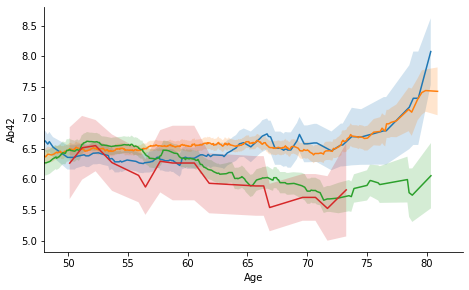

In [1189]:
IDP='Ab42_regPl_pre_cl'
#sns.scatterplot(data=data,x='Age-3.0',y='Ab42/Ab40_regPl_pre',hue='Case',alpha=0.3)#.loc[data['APOE']=='A3A4'
time_plot(data.loc[els,:],IDP,groupby='APOE',grps=['A3A2','A3A3','A3A4','A4A4'],time='Age-2.0_d',rolling="3650d",xlim=[48,83],xlabel='Age',ylabel='Ab42',leg=False)#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])
fig=plt.gcf()
fig.set_size_inches(7.5,4.5)

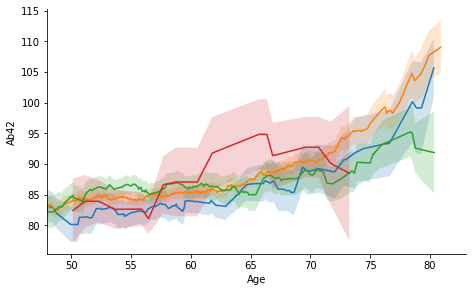

In [1190]:
IDP='Ab40_regPl_pre_cl'
#sns.scatterplot(data=data,x='Age-3.0',y='Ab42/Ab40_regPl_pre',hue='Case',alpha=0.3)#.loc[data['APOE']=='A3A4'
time_plot(data.loc[els,:],IDP,groupby='APOE',grps=['A3A2','A3A3','A3A4','A4A4'],time='Age-2.0_d',rolling="3650d",xlim=[48,83],xlabel='Age',ylabel='Ab42',leg=False,loc='upper left')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])
fig=plt.gcf()
fig.set_size_inches(7.5,4.5)


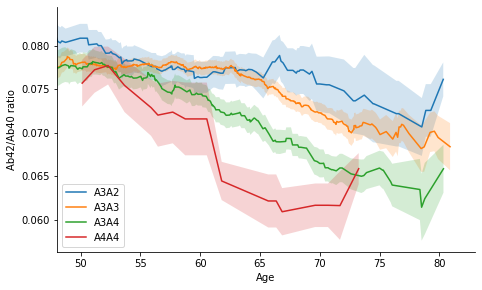

In [1191]:
IDP='Ab42/Ab40_regPl_pre_cl'
#sns.scatterplot(data=data,x='Age-2.0',y='Ab42/Ab40_regPl_pre',hue='Case',alpha=0.3)#.loc[data['APOE']=='A3A4'
time_plot(data.loc[els,:],IDP,groupby='APOE',grps=['A3A2','A3A3','A3A4','A4A4'],time='Age-2.0_d',rolling="3650d",xlim=[48,83],xlabel='Age',ylabel='Ab42/Ab40 ratio',loc='lower left',leg=True)# {"A3A2":"APOE-ε2ε3","A3A3":"APOE-ε3ε3","A3A4":"APOE-ε3ε4","A4A4":"APOE-ε4ε4"})#,'sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])
fig=plt.gcf()
fig.set_size_inches(7.5,4.5)

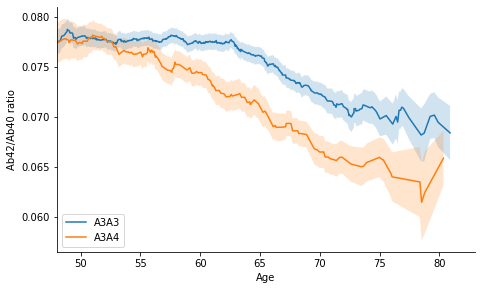

In [1192]:
IDP='Ab42/Ab40_regPl_pre_cl'
#sns.scatterplot(data=data,x='Age-2.0',y='Ab42/Ab40_regPl_pre',hue='Case',alpha=0.3)#.loc[data['APOE']=='A3A4'
time_plot(data.loc[els,:],IDP,groupby='APOE',grps=['A3A3','A3A4'],time='Age-2.0_d',rolling="3650d",xlim=[48,83],xlabel='Age',ylabel='Ab42/Ab40 ratio',loc='lower left',leg=True)# {"A3A2":"APOE-ε2ε3","A3A3":"APOE-ε3ε3","A3A4":"APOE-ε3ε4","A4A4":"APOE-ε4ε4"})#,'sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])
fig=plt.gcf()
fig.set_size_inches(7.5,4.5)

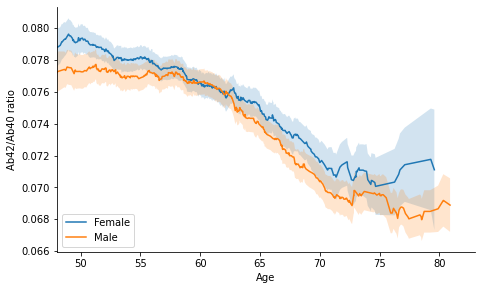

In [1201]:
IDP='Ab42/Ab40_regPl_pre_cl'
#sns.scatterplot(data=data,x='Age-2.0',y='Ab42/Ab40_regPl_pre',hue='Case',alpha=0.3)#.loc[data['APOE']=='A3A4'
time_plot(data.loc[els,:],IDP,groupby='Gender_pre',time='Age-2.0_d',rolling="3650d",xlim=[48,83],xlabel='Age',ylabel='Ab42/Ab40 ratio',loc='lower left',leg=True)# {"A3A2":"APOE-ε2ε3","A3A3":"APOE-ε3ε3","A3A4":"APOE-ε3ε4","A4A4":"APOE-ε4ε4"})#,'sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])
fig=plt.gcf()
fig.set_size_inches(7.5,4.5)

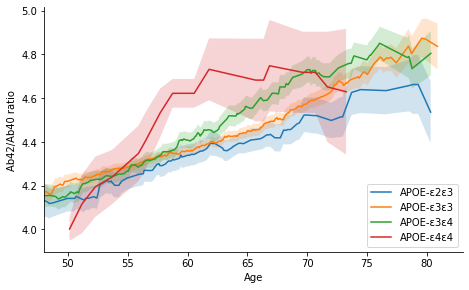

In [1194]:
IDP='GFAP_regPl_pre_cl'
#sns.scatterplot(data=data,x='Age-3.0',y='Ab42/Ab40_regPl_pre',hue='Case',alpha=0.3)#.loc[data['APOE']=='A3A4'
time_plot(data.loc[els,:],IDP,groupby='APOE',grps=['A3A2','A3A3','A3A4','A4A4'],time='Age-2.0_d',rolling="3650d",xlim=[48,83],xlabel='Age',ylabel='Ab42/Ab40 ratio',leg={"A3A2":"APOE-ε2ε3","A3A3":"APOE-ε3ε3","A3A4":"APOE-ε3ε4","A4A4":"APOE-ε4ε4"},loc='lower right')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])
fig=plt.gcf()
fig.set_size_inches(7.5,4.5)

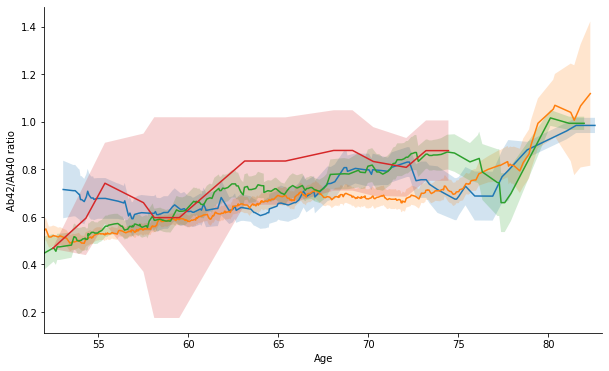

In [1195]:
IDP='pTau-181_regPl_pre_cl'
#sns.scatterplot(data=data,x='Age-3.0',y='Ab42/Ab40_regPl_pre',hue='Case',alpha=0.3)#.loc[data['APOE']=='A3A4'
time_plot(data.loc[els,:],IDP,groupby='APOE',grps=['A3A2','A3A3','A3A4','A4A4'],time='Age-3.0_d',rolling="1825d",xlim=[52,83],xlabel='Age',ylabel='Ab42/Ab40 ratio',leg=False)#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])
fig=plt.gcf()
fig.set_size_inches(10,6)

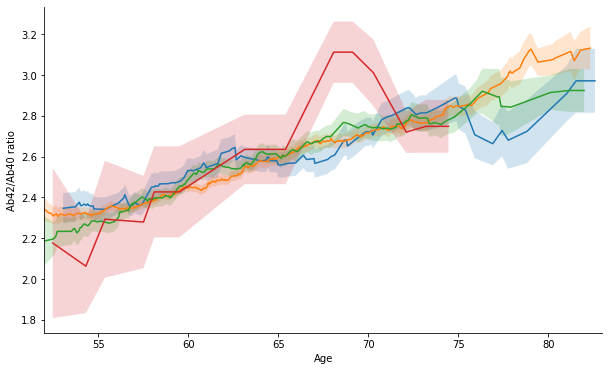

In [1196]:
IDP='NfL_regPl_pre_cl'
#sns.scatterplot(data=data,x='Age-3.0',y='Ab42/Ab40_regPl_pre',hue='Case',alpha=0.3)#.loc[data['APOE']=='A3A4'
time_plot(data.loc[els,:],IDP,groupby='APOE',grps=['A3A2','A3A3','A3A4','A4A4'],time='Age-3.0_d',rolling="1825d",xlim=[52,83],xlabel='Age',ylabel='Ab42/Ab40 ratio',leg=False)#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])
fig=plt.gcf()
fig.set_size_inches(10,6)

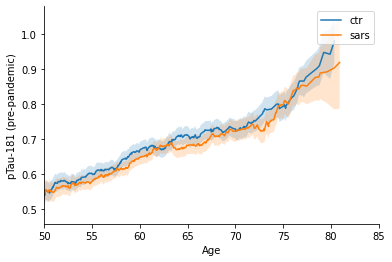

In [1197]:
IDP='pTau-181_regPl_pre_cl'

#ax1=sns.scatterplot(data=data,x='Age-3.0',y=IDP,hue='Case',alpha=0.15,label='_nolabel_')#.loc[data['APOE']=='A3A4'
#ax.legend(title='SARS-CoV-2 effects on pTau-181',  labels=['Control', 'SARS'])

els=(data.loc[:,IDP].notnull())&all_matched & all_case  #& ((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
ax=time_plot(data.loc[els,:],IDP,groupby='Case',grps=['ctr','sars'],time='Age-2.0_d',rolling="3860d",xlim=[50,85],xlabel='Age',ylabel='pTau-181 (pre-pandemic)')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2],labels[:2],loc='upper right')

In [1198]:
(data[find_vars(data,'2443-')]==1).sum(axis=0)

2443-0.0      28
2443-1.0       8
2443-2.0      73
2443-3.0      85
132443-0.0     0
2443-0.0.1    28
2443-1.0.1     8
2443-2.0.1    73
2443-3.0.1    85
dtype: int64

In [1199]:
find_vars(data,'GFR')

['P_EGFR_pre',
 'P_PDGFRB_pre',
 'P_PDGFRA_pre',
 'P_OGFR_pre',
 'P_GFRA3_pre',
 'P_GFRA2_pre',
 'P_GFRA1_pre',
 'P_FGFR2_pre',
 'P_EGFR_post',
 'P_PDGFRB_post',
 'P_PDGFRA_post',
 'P_OGFR_post',
 'P_GFRA3_post',
 'P_GFRA2_post',
 'P_GFRA1_post',
 'P_FGFR2_post',
 'P_EGFR_0',
 'P_PDGFRB_0',
 'P_PDGFRA_0',
 'P_OGFR_0',
 'P_GFRA3_0',
 'P_GFRA2_0',
 'P_GFRA1_0',
 'P_FGFR2_0',
 'P_EGFR_pre_cl',
 'P_EGFR_post_cl',
 'P_EGFR_0_cl',
 'P_EGFR_diff_cl',
 'P_EGFR_pc_cl',
 'P_PDGFRB_pre_cl',
 'P_PDGFRB_post_cl',
 'P_PDGFRB_0_cl',
 'P_PDGFRB_diff_cl',
 'P_PDGFRB_pc_cl',
 'P_PDGFRA_pre_cl',
 'P_PDGFRA_post_cl',
 'P_PDGFRA_0_cl',
 'P_PDGFRA_diff_cl',
 'P_PDGFRA_pc_cl',
 'P_OGFR_pre_cl',
 'P_OGFR_post_cl',
 'P_OGFR_0_cl',
 'P_OGFR_diff_cl',
 'P_OGFR_pc_cl',
 'P_GFRA3_pre_cl',
 'P_GFRA3_post_cl',
 'P_GFRA3_0_cl',
 'P_GFRA3_diff_cl',
 'P_GFRA3_pc_cl',
 'P_GFRA2_pre_cl',
 'P_GFRA2_post_cl',
 'P_GFRA2_0_cl',
 'P_GFRA2_diff_cl',
 'P_GFRA2_pc_cl',
 'P_GFRA1_pre_cl',
 'P_GFRA1_post_cl',
 'P_GFRA1_0_cl',
 'P_

KeyError: "['GFR-0.0'] not in index"

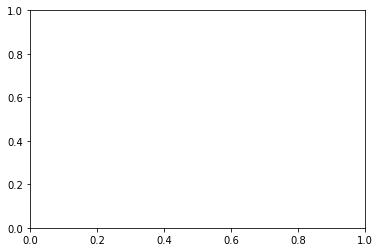

In [1200]:
IDP='GFR-0.0'
#sns.scatterplot(data=data,x='Age-3.0',y='Ab42/Ab40_regPl_pre',hue='Case',alpha=0.3)#.loc[data['APOE']=='A3A4'
time_plot(data.loc[els,:],IDP,groupby='APOE',grps=['A3A2','A3A3','A3A4','A4A4'],time='Age-3.0_d',rolling="1825d",xlim=[52,83],xlabel='Age',ylabel='Ab42/Ab40 ratio',leg=False)#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])
fig=plt.gcf()
fig.set_size_inches(10,6)

In [ ]:
IDP='pTau-181_regPl_post_cl'

#ax1=sns.scatterplot(data=data,x='Age-3.0',y=IDP,hue='Case',alpha=0.15,label='_nolabel_')#.loc[data['APOE']=='A3A4'
#ax.legend(title='SARS-CoV-2 effects on pTau-181',  labels=['Control', 'SARS'])

els=(data.loc[:,IDP].notnull())&all_matched & all_case  #& ((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
ax=time_plot(data.loc[els,:],IDP,groupby='Case',grps=['ctr','sars'],time='Age-3.0_d',rolling="3860d",xlim=[50,85],xlabel='Age',ylabel='pTau-181 (post-pandemic)')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2],labels[:2],loc='upper right')

In [ ]:
IDP='6350-3.0'

#ax1=sns.scatterplot(data=data,x='Age-3.0',y=IDP,hue='Case',alpha=0.15,label='_nolabel_')#.loc[data['APOE']=='A3A4'
#ax.legend(title='SARS-CoV-2 effects on pTau-181',  labels=['Control', 'SARS'])

els=(data.loc[:,IDP].notnull())&all_matched & all_case  #& ((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
ax=time_plot(data.loc[els,:],IDP,groupby='Case',grps=['ctr','sars'],time='Age-3.0_d',rolling="3860d",xlim=[50,85],xlabel='Age',ylabel='pTau-181 (difference)')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2],labels[:2],loc='upper right')

In [ ]:
IDP='Ab42_regPl_pre_cl'

#ax1=sns.scatterplot(data=data,x='Age-3.0',y=IDP,hue='Case',alpha=0.15,label='_nolabel_')#.loc[data['APOE']=='A3A4'
#ax.legend(title='SARS-CoV-2 effects on pTau-181',  labels=['Control', 'SARS'])

els=(data.loc[:,IDP].notnull())&all_matched & all_case  #& ((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
ax=time_plot(data.loc[els,:],IDP,groupby='Case',grps=['ctr','sars'],time='Age-3.0_d',rolling="3650d",xlim=[50,85],xlabel='Age',ylabel='Ab42:Ab40 (post-pandemic)')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2],labels[:2],loc='upper right')

In [ ]:
def all_plt(IDP,label,smth="3650d",loc="upper left",leg=False,pre='_pre',cl='_cl'):
            
    if pre=='-2.0':
        post='-3.0'
    else:
        post='_post'
        
    #ax1=sns.scatterplot(data=data,x='Age-3.0',y=IDP,hue='Case',alpha=0.15,label='_nolabel_')#.loc[data['APOE']=='A3A4'
    #ax.legend(title='SARS-CoV-2 effects on pTau-181',  labels=['Control', 'SARS'])

    els=(data.loc[:,IDP+pre+cl].notnull())&all_matched & all_case
    ids=data.loc[data.loc[els,'matched_eid'],IDP+pre+cl].dropna().index
    ids2=data.loc[ids,'matched_eid']
    els[:]=False
    els[ids]=True
    els[ids2]=True
    fig,axs = plt.subplots(1,3)
    fig.set_size_inches(18/1.5,5/1.5)
    ax1=time_plot(data.loc[els,:],IDP+pre+cl,groupby='Case',grps=['ctr','sars'],time='Age-2.0_d',rolling=smth,xlim=[50,84],xlabel='Age',ylabel=label,title=label+' (pre-pandemic)',ax=axs[0],loc=loc,leg=leg)#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005],ax=axs[0])
    ax1.set_xlabel('')
    ylim1=ax1.get_ylim()
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    els=(data.loc[:,IDP+pre+cl].notnull())&all_matched & all_case
    ids=data.loc[data.loc[els,'matched_eid'],IDP+post+cl].dropna().index
    ids2=data.loc[ids,'matched_eid']
    els[:]=False
    els[ids]=True
    els[ids2]=True


    ax2=time_plot(data.loc[els,:],IDP+post+cl,groupby='Case',grps=['ctr','sars'],time='Age-3.0_d',rolling=smth,xlim=[50,84],xlabel='Age',ylabel=label,title=label+' (post-pandemic)',ax=axs[1],loc=loc,leg=False)#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005],ax=axs[1])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ylim2=ax2.get_ylim()
    
    ylim = [min(ylim1[0],ylim2[0]),max(ylim1[1],ylim2[1])]
    ax1.set_ylim(ylim)
    ax2.set_ylim(ylim)
    
    els=(data.loc[:,IDP+pre+cl].notnull())&all_matched & all_case
    ids=data.loc[data.loc[els,'matched_eid'],IDP+'_diff'+cl].dropna().index
    ids2=data.loc[ids,'matched_eid']
    els[:]=False
    els[ids]=True
    els[ids2]=True
    
    ax=time_plot(data.loc[els,:],IDP+'_diff' + cl,groupby='Case',grps=['ctr','sars'],time='Age-3.0_d',rolling=smth,xlim=[50,84],xlabel='Age',ylabel=label,title=label+' (difference)',ax=axs[2],loc=loc,leg=False)#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005],ax=axs[1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False) 
    ax.set_xlabel('')
    ax.set_ylabel('')
    return(ax)

In [ ]:
all_plt('Ab40_regPl','Ab40',smth="3650d",loc=False)



In [ ]:
all_plt('Ab42_regPl','Ab42',smth="3650d",leg={"ctr":"Control",'sars':'Case','sars_hosp':"COVID-Hospitalised"})

In [ ]:
all_plt('Ab42/Ab40_regPl','Ab42/Ab40',smth="3650d",loc='lower left',leg=False)

In [ ]:
all_plt('pTau-181_regPl','pTau-181',smth="3650d",loc=None)

In [ ]:
all_plt('NfL_regPl','NfL',smth="3650d",loc="lower left")

In [ ]:
all_plt('GFAP_regPl','GFAP',smth="3650d",loc="lower left")

In [ ]:
all_plt('adni_mean_cl','AD Brain signature',smth="3650d",loc=None,pre='-2.0',cl='')

In [ ]:
data.loc[all_matched,'APOE'].value_counts()

In [ ]:
find_vars(OLINK,'P_AP')

In [ ]:
data

In [ ]:
all_plt('cog_vars_gi','General cognitive ability score',smth="3650d",loc=None,pre='-2.0',cl='')

In [ ]:
all_plt('2178','General health',smth="3650d",loc=None,pre='-2.0',cl='')

In [ ]:
all_plt('2178','General Health Rating',smth="3650d",pre='-2.0',cl='',loc='lower left',leg=True)

In [ ]:
ax1=time_plot(data.loc[els,:],IDP+pre+cl,groupby='Case',grps=['ctr','sars'],time='Age-2.0_d',rolling=smth,xlim=[50,85],xlabel='Age',ylabel=label,title=label+' (pre-pandemic)',ax=axs[0],loc=loc,leg=leg)#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005],ax=axs[0])
    

In [ ]:
IDP='6350-3.0'

#ax1=sns.scatterplot(data=data,x='Age-3.0',y=IDP,hue='Case',alpha=0.15,label='_nolabel_')#.loc[data['APOE']=='A3A4'
#ax.legend(title='SARS-CoV-2 effects on pTau-181',  labels=['Control', 'SARS'])

els=(data.loc[:,IDP].notnull())&all_matched & all_case  #& ((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
ax=time_plot(data.loc[els,:],IDP,groupby='Case',grps=['ctr','sars'],time='Age-2.0_d',rolling="3650d",xlim=[50,84],xlabel='Age',ylabel='pTau-181 (difference)')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2],labels[:2],loc='upper right')

In [ ]:
IDP='Ab42/Ab40_regPl_diff_cl'

#ax1=sns.scatterplot(data=data,x='Age-3.0',y=IDP,hue='Case',alpha=0.15,label='_nolabel_')#.loc[data['APOE']=='A3A4'
#ax.legend(title='SARS-CoV-2 effects on pTau-181',  labels=['Control', 'SARS'])

els=(data.loc[:,IDP].notnull())&all_matched & all_case  #& ((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
ax=time_plot(data.loc[els,:],IDP,groupby='Case',grps=['ctr','sars'],time='Age-3.0_d',rolling="3650d",xlim=[50,85],xlabel='Age',ylabel='pTau-181 (post-pandemic)')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2],labels[:2],loc='upper right')

In [ ]:
IDP='cog_vars_gi_diff'

#ax1=sns.scatterplot(data=data,x='Age-3.0',y=IDP,hue='Case',alpha=0.15,label='_nolabel_')#.loc[data['APOE']=='A3A4'
#ax.legend(title='SARS-CoV-2 effects on pTau-181',  labels=['Control', 'SARS'])

els=(data.loc[:,IDP].notnull())&all_matched & all_case  #& ((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
ax=time_plot(data.loc[els,:],IDP,groupby='Case',grps=['ctr','sars'],time='Age-2.0_d',rolling="3860d",xlim=[50,85],xlabel='Age',ylabel='Estimate of GI')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2],labels[:2],loc='upper right')

In [ ]:
 
all_plt('Type_2_diabetes','Type 2 diabetes',smth="3650d",loc="lower left") 

In [ ]:
all_plt('COPD','COPD',smth="3650d",loc="lower left")

In [ ]:
IDP=IDP='adni_mean_diff'

#ax1=sns.scatterplot(data=data,x='Age-3.0',y=IDP,hue='Case',alpha=0.15,label='_nolabel_')#.loc[data['APOE']=='A3A4'
#ax.legend(title='SARS-CoV-2 effects on pTau-181',  labels=['Control', 'SARS'])

els=(data.loc[:,IDP].notnull())&all_matched & all_case  #& ((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
ax=time_plot(data.loc[els,:],IDP,groupby='Case',grps=['ctr','sars'],time='Age-2.0_d',rolling="3860d",xlim=[50,85],xlabel='Age',ylabel='AD brain signcature score (difference)')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2],labels[:2],loc='upper right')

In [ ]:
IDP='cog_vars_gi_diff'

#ax1=sns.scatterplot(data=data,x='Age-3.0',y=IDP,hue='Case',alpha=0.15,label='_nolabel_')#.loc[data['APOE']=='A3A4'
#ax.legend(title='SARS-CoV-2 effects on pTau-181',  labels=['Control', 'SARS'])

els=(data.loc[:,IDP].notnull())&all_matched & all_case  #& ((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
ax=time_plot(data.loc[els,:],IDP,groupby='Case',grps=['ctr','sars'],time='Age-2.0_d',rolling="3860d",xlim=[50,85],xlabel='Age',ylabel='Estimate of GI')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2],labels[:2],loc='upper right')

In [ ]:
IDP='Ischaemic_stroke_diff_cl'

#ax1=sns.scatterplot(data=data,x='Age-3.0',y=IDP,hue='Case',alpha=0.15,label='_nolabel_')#.loc[data['APOE']=='A3A4'
#ax.legend(title='SARS-CoV-2 effects on pTau-181',  labels=['Control', 'SARS'])

els=(data.loc[:,IDP].notnull())&all_matched #((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
ax=time_plot(data.loc[els,:],IDP,groupby='Case',grps=['ctr','sars'],time='Age-2.0_d',rolling="1860d",xlim=[50,85],xlabel='Age',ylabel='Ab42/Ab40 (difference)')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2],labels[:2],loc='upper right')



In [ ]:
IDP='pTau-181_regPl_diff_cl'

#ax1=sns.scatterplot(data=data,x='Age-3.0',y=IDP,hue='Case',alpha=0.15,label='_nolabel_')#.loc[data['APOE']=='A3A4'
#ax.legend(title='SARS-CoV-2 effects on pTau-181',  labels=['Control', 'SARS'])

els=(data.loc[:,IDP].notnull())&all_matched #((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
ax=time_plot(data.loc[els,:],IDP,groupby='Case',grps=['ctr','sars'],time='Age-2.0_d',rolling="3860d",xlim=[50,85],xlabel='Age',ylabel='Ab42/Ab40 (post)')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2],labels[:2],loc='upper right')

In [ ]:
# # apply neuroimaging cleaning to proteomics 
# for a in prot_els_regPl:
#     CONF=['Age-3.0_f','assessment_sep','assessment_sep^2','Ethnicity(White)','Gender_pre']
#     naels=remove_outliers(remove_conf(data,a+'_post',CONF,flatten=False)).isna()
#     naels=(remove_outliers(remove_conf(data,a+'_pre',CONF,flatten=False)).isna())
#     for pref in ['_post_cl','_pre_cl']:
#         data.loc[:,a+pref]=data.loc[:,a+pref[:-3]]
#         data.loc[naels.squeeze(),a+pref]=np.nan
    
#     data.loc[:,a+'_diff_cl'] = data[a+'_post_cl']-data[a+'_pre_cl']
#     data.loc[:,a+'_pc_cl'] = 100*data[a+'_diff_cl']/data[a+'_pre_cl']

In [ ]:
IDP='GFAP_regPl_diff_cl'

#ax1=sns.scatterplot(data=data,x='Age-3.0',y=IDP,hue='Case',alpha=0.13,label='_nolabel_')#.loc[data['APOE']=='A3A4'
#ax.legend(title='SARS-CoV-2 effects on pTau-181',  labels=['Control', 'SARS'])

els=(data.loc[:,IDP].notnull())&all_matched #((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
ax=time_plot(data.loc[els,:],IDP,groupby='Case',grps=['ctr','sars'],time='Age-3.0_d',rolling="3600d",xlim=[50,85],xlabel='Age',ylabel='Ab42/Abn40 (difference)')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2],labels[:2],loc='upper left')


In [ ]:
IDP='pTau-181_regPl_pre_cl'

ax1=sns.scatterplot(data=data,x='Age-3.0',y=IDP,hue='Case',alpha=0.3,label='_nolabel_')#.loc[data['APOE']=='A3A4'
#ax.legend(title='SARS-CoV-2 effects on pTau-181',  labels=['Control', 'SARS'])

els=(data.loc[:,IDP].notnull())&all_matched #((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
ax=time_plot(data.loc[els,:],IDP,groupby='Case',grps=['ctr','sars'],time='Age-2.0_d',rolling="1860d",xlim=[55,85],xlabel='Age',ylim=[0.25,1.5],ylabel='pTau-181 (pre)')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2],labels[:2],loc='upper left')

In [ ]:
IDP='pTau-181_regPl_post_cl'

ax1=sns.scatterplot(data=data,x='Age-3.0',y=IDP,hue='Case',alpha=0.3,label='_nolabel_')#.loc[data['APOE']=='A3A4'
#ax.legend(title='SARS-CoV-2 effects on pTau-181',  labels=['Control', 'SARS'])

els=(data.loc[:,IDP].notnull())&all_matched #((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
ax=time_plot(data.loc[els,:],IDP,groupby='Case',grps=['ctr','sars'],time='Age-3.0_d',rolling="1860d",xlim=[55,85],xlabel='Age',ylim=[0.25,1.5],ylabel='pTau-181 (post)')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2],labels[:2],loc='upper left')

In [ ]:
IDP='pTau-181_regPl_diff_cl'

ax1=sns.scatterplot(data=data,x='Age-3.0',y=IDP,hue='Case',alpha=0.13,label='_nolabel_')#.loc[data['APOE']=='A3A4'
#ax.legend(title='SARS-CoV-2 effects on pTau-181',  labels=['Control', 'SARS'])

els=(data.loc[:,IDP].notnull())&all_matched #((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
ax=time_plot(data.loc[els,:],IDP,groupby='Case',grps=['ctr','sars'],time='Age-3.0_d',rolling="1860d",xlim=[55,85],xlabel='Age',ylim=[0.-.5,.5],ylabel='pTau-181 (difference)')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2],labels[:2],loc='upper left')


In [ ]:
IDP='pTau-181_regPl_post'

#ax1=sns.scatterplot(data=data,x='Age-3.0',y='pTau-181_regPl_post',hue='Case',alpha=0.3,label='_nolabel_')#.loc[data['APOE']=='A3A4'
#ax.legend(title='SARS-CoV-2 effects on pTau-181',  labels=['Control', 'SARS'])

els=(data.loc[:,IDP].notnull())&all_matched #(data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
ax=time_plot(data.loc[els,:],IDP,groupby='Case',grps=['ctr','sars'],time='Age-3.0_d',rolling="1860d",xlim=[55,85],ylim=[0,1.5],xlabel='Age',ylabel='pTau-181 (post)')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2],labels[:2],loc='upper left')


In [ ]:
IDP='adni_mean_cl-3.0'

ax1=sns.scatterplot(data=data,x='Age-3.0',y=IDP,hue='Case',alpha=0.13,label='_nolabel_')#.loc[data['APOE']=='A3A4'
ax.legend(title='SARS-CoV-2 effects on pTau-181',  labels=['Control', 'SARS'])

els=(data.loc[:,IDP].notnull())&all_matched #((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
ax=time_plot(data.loc[els,:],IDP,groupby='Case',grps=['ctr','sars'],time='Age-3.0_d',rolling="1860d",xlim=[50,85],ylim=[-3,-1],xlabel='Age',ylabel='Neuroimaging Signature ')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2],labels[:2],loc='upper left')


In [ ]:
IDP='cog_vars_gi-3.0'

ax1=sns.scatterplot(data=data,x='Age-3.0',y=IDP,hue='Case',alpha=0.13,label='_nolabel_')#.loc[data['APOE']=='A3A4'
ax.legend(title='SARS-CoV-2 effects on pTau-181',  labels=['Control', 'SARS'])

els=(data.loc[:,IDP].notnull())&all_matched #((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
ax=time_plot(data.loc[els,:],IDP,groupby='Case',grps=['ctr','sars'],time='Age-3.0_d',rolling="1860d",xlim=[50,85],xlabel='Age',ylabel='Cognitive Scores (difference) ')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2],labels[:2],loc='upper left')

In [ ]:
IDP='adni_mean_cl_diff'

ax1=sns.scatterplot(data=data,x='Age-3.0',y=IDP,hue='Case',alpha=0.13,label='_nolabel_')#.loc[data['APOE']=='A3A4'
ax.legend(title='SARS-CoV-2 effects on pTau-181',  labels=['Control', 'SARS'])

els=(data.loc[:,IDP].notnull())&all_matched #((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
ax=time_plot(data.loc[els,:],IDP,groupby='Case',grps=['ctr','sars'],time='Age-3.0_d',rolling="1860d",xlim=[50,85],ylim=[-0.3,0.5],xlabel='Age',ylabel='Alzheimer\'s brain signature weight ')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])
IDP='cog_vars_gi-3.0'
#ax=time_plot(data.loc[els,:],IDP,groupby='Case',grps=['ctr','sars'],time='Age-3.0_d',rolling="1860d",xlim=[50,85],,xlabel='Age',ylabel='Cognitive Scores (difference) ')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2],labels[:2],loc='upper left')

In [ ]:
IDP='cog_vars_gi_diff'

ax1=sns.scatterplot(data=data,x='Age-3.0',y=IDP,hue='Case',alpha=0.13,label='_nolabel_')#.loc[data['APOE']=='A3A4'
ax.legend(title='SARS-CoV-2 effects on pTau-181',  labels=['Control', 'SARS'])

els=(data.loc[:,IDP].notnull())&all_matched #((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
ax=time_plot(data.loc[els,:],IDP,groupby='Case',grps=['ctr','sars'],time='Age-3.0_d',rolling="2160d",xlim=[50,85],ylim=[-5,5],xlabel='Age',ylabel='Cognitive Scores (difference) ')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2],labels[:2],loc='upper left')

In [ ]:
IDP='cog_vars_gi_diff'

ax1=sns.scatterplot(data=data,x='Age-3.0',y=IDP,hue='Case',alpha=0.13,label='_nolabel_')#.loc[data['APOE']=='A3A4'
ax.legend(title='SARS-CoV-2 effects on pTau-181',  labels=['Control', 'SARS'])

els=(data.loc[:,IDP].notnull())&all_matched #((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
ax=time_plot(data.loc[els,:],IDP,groupby='Case',grps=['ctr','sars'],time='Age-3.0_d',rolling="2160d",xlim=[50,85],ylim=[-5,5],xlabel='Age',ylabel='Cognitive Scores (difference) ')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2],labels[:2],loc='upper left')

In [ ]:
IDP='6348-3.0_diff'

ax1=sns.scatterplot(data=data,x='Age-3.0',y=IDP,hue='Case',alpha=0.13,label='_nolabel_')#.loc[data['APOE']=='A3A4'
ax.legend(title='SARS-CoV-2 effects on pTau-181',  labels=['Control', 'SARS'])

els=(data.loc[:,IDP].notnull())&all_matched #((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
ax=time_plot(data.loc[els,:],IDP,groupby='Case',grps=['ctr','sars'],time='Age-3.0_d',rolling="1860d",xlim=[50,85],ylim=[-5,5],xlabel='Age',ylabel='Cognitive Scores (difference) ')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2],labels[:2],loc='upper left')

In [ ]:
IDP='6350_diff'

ax1=sns.scatterplot(data=data,x='Age-3.0',y=IDP,hue='Case',alpha=0.13,label='_nolabel_')#.loc[data['APOE']=='A3A4'
ax.legend(title='SARS-CoV-2 effects on pTau-181',  labels=['Control', 'SARS'])

els=(data.loc[:,IDP].notnull())&all_matched #((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
ax=time_plot(data.loc[els,:],IDP,groupby='Case',grps=['ctr','sars'],time='Age-3.0_d',rolling="1860d",xlim=[50,85],ylim=[-30,150],xlabel='Age',ylabel='Cognitive Scores (difference) ')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2],labels[:2],loc='upper left')

In [ ]:
IDP='adni_mean-2.0'

els=(data.loc[:,IDP].notnull())&all_matched #((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
time_plot(data.loc[els,:],IDP,groupby='APOE',grps=['A3A2','A3A3','A3A4','A4A4'],time='Age-3.0_d',rolling="1860d",xlabel='Age',ylabel='Ab42/Ab40 ratio')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])'
                            

In [ ]:
data['Gender_pre']

In [ ]:
IDP='pTau-181_regPl_post_cl'
#ax1=sns.scatterplot(data=data,x='adni_mean-2.0',y=IDP,hue='Case',alpha=0.13,label='_nolabel_')#.loc[data['APOE']=='A3A4'
#els=(data.loc[:,IDP].notnull())&all_matched#&(data['Gender_pre']=='Male') #((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
ax=time_plot(data.loc[els,:],IDP,groupby='Case',time='adni_mean-2.0',rolling=450,xlabel='Age',xlim=[0,0.5],ylabel='Ab42/Ab40 ratio')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])'
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2],labels[:2],loc='lower right')

In [ ]:
IDP='GFAP_regPl_diff_cl'


ax1=sns.scatterplot(data=data,x='adni_mean-2.0',y=IDP,hue='Case',alpha=0.13,label='_nolabel_')#.loc[data['APOE']=='A3A4'
#ax.legend(title='SARS-CoV-2 effects on pTau-181',  labels=['Control', 'SARS'])

els=(data.loc[:,IDP].notnull())&all_matched#&(data['Gender_pre']=='Male') #((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
time_plot(data.loc[els,:],IDP,groupby='Case',time='adni_mean-2.0',rolling=250,xlabel='Age',xlim=[0,0.6],ylim=[0,0.1],ylabel='Ab42/Ab40 ratio')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])'


In [ ]:
data['adni_mean-2.0'].describe()

In [ ]:
IDP='Ab42/Ab40_diff'

els=(data.loc[:,IDP].notnull())&all_matched #((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
time_plot(data.loc[els,:],IDP,groupby='Case',time='Age-3.0_d',rolling="1860d",xlabel='Age',ylabel='Ab42/Ab40 ratio')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])'


In [ ]:
data['time_since_pos_d']

In [ ]:
IDP='pTau-181_post'

els=(data.loc[:,IDP].notnull())&all_case #((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
els=data.loc[els,IDP].dropna().index
els=data.loc[els,'time_since_pos_d'].dropna().index
#ids2=data.loc[ids,'matched_eid']
#els[:]=False
#els[ids]=True
#els[ids2]=True
time_plot(data.loc[els,:],IDP,groupby='Gender_pre',time='time_since_pos_d',rolling="18d",xlabel='Age',ylabel='Ab42/Ab40 ratio')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])'


In [ ]:
IDP='P_GFAP_pre'

els=(data.loc[:,IDP].notnull())&all_matched #((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
time_plot(data.loc[els,:],IDP,groupby='APOE',grps=['A3A2','A3A3','A3A4','A4A4'],time='Age-3.0_d',rolling="1860d",xlim=[55,85],xlabel='Age',ylabel='GFAP ratio')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])

In [ ]:
IDP='GFAP_'#
#IDP='6348-3.0'
IDP='pTau-181_orig_post'
IDP='Ab42/Ab40_diff'
IDP='6348-pc'
IDP='GFAP_orig-pc'

IDP='6348_diff'
IDP='pTau-181_orig_diff'
#IDP='NfL_diff'
time='Age-3.0_d'
win=DateOffset(days=1825)
els=(data.loc[:,time].notnull())&(data.loc[:,IDP].notnull()) & A4
#els=all_matched&(data.loc[:,time].notnull())&(data.loc[:,IDP].notnull())
#els=(data.loc[:,time].notnull())&(data.loc[:,IDP].notnull()) &A4
#els= all_case & all_matched & (data.loc[:,['HES','PCR','GP']].sum(axis=1)>0) 

ids=data.loc[els,'matched_eid'].dropna()
els[ids]=True

tmp=data.loc[els,['Case',time,IDP]]
#tmp['Age-3.0']=tmp['Age-3.0'].dt.days/365
#tmp=tmp.sort_index()
#time='time_since_pos'


tmp=tmp.sort_values(by=time,ascending=True)
#tmp[time]=tmp[time]/pd.to_timedelta(1, unit='D')

#tmpg=tmp.groupby('Case').
roll = dfg.rolling("1865d",on=time,min_periods=1,center=True)
mm = roll.mean()
std = roll.std()/np.sqrt(180)
qnt_l=roll.quantile(.1)
qnt_u=roll.quantile(.9)
#ax=sns.lineplot(x=time,y='Ab42_post',data=roll.loc[('ctr',slice(None)),:])
ax=sns.lineplot(x=mm.loc[:,time]/ pd.to_timedelta(1, unit='D') /365 ,y=IDP,data=mm.loc[('ctr',slice(None)),:])
ax=sns.lineplot(x=mm.loc[:,time]/ pd.to_timedelta(1, unit='D') /365  ,y=IDP,data=mm.loc[('sars',slice(None)),:])
#ax=sns.scatterplot(x=data.loc[:,time] / pd.to_timedelta(1, unit='D') / 365,y=IDP,data=data)
xs=mm.loc[('ctr',slice(None)),:].index.get_level_values(1)/ pd.to_timedelta(1, unit='D') /365 
plt.fill_between(xs,mm.loc[('ctr',slice(None)),IDP]-std.loc[('ctr',slice(None)),IDP],mm.loc[('ctr',slice(None)),IDP]+std.loc[('ctr',slice(None)),IDP],color='blue',alpha=0.2)

plt.fill_between(xs ,mm.loc[('sars',slice(None)),IDP]-std.loc[('sars',slice(None)),IDP],mm.loc[('sars',slice(None)),IDP]+std.loc[('sars',slice(None)),IDP],color='red',alpha=0.2)
#ax=sns.lineplot(x='Age-3.0',y='Ab42_post',data=roll)
#ax=sns.lineplot(x=time,y=IDP+'post',data=roll)
ax.set_ylim([-1.5,.5])
ax.legend()

In [ ]:
tmp=tmp.sort_values(by=time,ascending=True)
tmpd=tmp.set_index('Age-3.0_d')
roll = tmpd.rolling("1865d",min_periods=1,center=True)
sem = roll.sem()
std = roll.std()
print(sem)
print(std)

In [ ]:
IDP='Ab42/Ab40_regPl_post'
time='time_since_first_pos_d'
els=(data.loc[:,IDP].notnull())&all_case&all_matched &(data.loc[:,time].notnull())#&((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # )
#ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
#ids2=data.loc[ids,'matched_eid']
#els[:]=False
#els[ids]=True
#els[ids2]=True
time_plot(data.loc[els,:],IDP,groupby='Case',time=time,rolling="80d",xlim=[0,1.35])#,ylim=[0.05,0.085])#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])

In [ ]:
diseases

In [ ]:
IDP='27270-3.0_cl'
IDP='6350-3.0_cl'
IDP="Alzheimer's_dementia_post"
IDP='26206-0.0'
els=(data.loc[:,IDP].notnull())&all_case&all_matched#&((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
time_plot(data.loc[els,:],IDP,groupby='Case',time='Age-3.0_d',rolling="1460d",xlim=[55,85])#,ylim=[0.05,0.085])#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])

In [ ]:
IDPb='adni_mean-2.0'
#IDPb='Ab42/Ab40_regPl_post'
#IDPb='GFAP_regPl_pre'
mm=data[IDPb].quantile(0.3)
data.loc[data[IDPb]>mm,'tmp']='high'
data.loc[data[IDPb]<mm,'tmp']='low'

In [ ]:
data.loc[:,'Case_A4']=data.loc[:,'Case']
data.loc[data.loc[:,'APOE_score']<1,'Case_A4']=data.loc[data.loc[:,'APOE_score']<1,'Case_A4']+'A3'
data.loc[data.loc[:,'APOE_score']>0,'Case_A4']=data.loc[data.loc[:,'APOE_score']<1,'Case_A4']+'A4'


In [ ]:
IDP='Ab42/Ab40_regPl_post_cl'
#IDP='cog_vars_alz_diff'
#IDP='GFAP_regPl_post'
#IDP='adni_mean-2.0'

#IDP='pTau-181_regPl_post'
els=(data.loc[:,IDP].notnull())&all_matched #((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
time_plot(data.loc[els,:],IDP,groupby='Case_hosp',time='Age-3.0_d',rolling="1860d",xlim=[55,85],xlabel='Age',ylim=[0.045,0.085],ylabel='Ab42/Ab40 ratio',leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])

In [ ]:


IDP='Ab42/Ab40_regPl_diff_cl'
IDP='cog_vars_gi-3.0'
#IDP='GFAP_regPl_post'
#IDP='adni_mean-2.0'
IDP='2178-3.0'
#IDP='NfL_regPl_post'
els=(data.loc[:,IDP].notnull())&all_matched & (data[IDPb]>mm) #& all_control# & (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index

els=(els&(data.loc[ids,IDP]>mm))
#ids2=data.loc[ids,'matched_eid']
#els[:]=False
#els[ids]=True
#els[ids2]=True
ax=time_plot(data.loc[els,:],IDP,groupby='Case_hosp',time='Age-3.0_d',rolling="1860d",xlim=[55,85],xlabel='Age',ylabel='pTau-181 (log)')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[0.05,0.085])#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])
ax.legend(loc="upper left")

In [ ]:
(els&(data.loc[ids,IDP]>mm)).sum()

In [ ]:
IDP='Ab42/Ab40_regPl_diff_cl'
#IDP='cog_vars_alz_diff'
#IDP='GFAP_regPl_post'
#IDP='adni_mean-2.0'

IDP='NfL_regPl_post'
els=(data.loc[:,IDP].notnull())&all_matched #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
ax=time_plot(data.loc[els,:],IDP,groupby='Case_hosp',time='Age-3.0_d',rolling="1860d",xlim=[55,85],xlabel='Age',ylabel='Ab42/Ab40 ratio',leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[0.05,0.085])#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])
ax.legend(loc="upper left")

In [ ]:
#IDPb='adni_mean-2.0'
IDPb='Ab42/Ab40_regPl_pre'
IDPb='1160-2.0'
IDPb='2734-0.0'
mm=data[IDPb].quantile(0.2)
data.loc[data[IDPb]>0,'tmp']='high'
data.loc[data[IDPb]<1,'tmp']='low'


IDP='Ab42/Ab40_regPl_pre_cl'
#IDP='cog_vars_alz_diff'
#IDP='GFAP_regPl_post'
#IDP='adni_mean-2.0'

#IDP='NfL_regPl_post_cl'
#IDP='1160-2.0'
#IPD='Alzheimers_dis'
els=(data.loc[:,IDP].notnull())&all_matched #& (data[IDPb]<mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
time_plot(data.loc[els,:],IDP,groupby='tmp',time='Age-3.0_d',rolling="1460d",xlim=[55,85])#,ylim=[0.05,0.085])#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])

In [ ]:
IDP='Ab42/Ab40_regPl_post'
IDP='cog_vars_alz_diff'
#IDP='GFAP_regPl_post'
#IDP='adni_mean-2.0'

IDP='pTau-181_regPl_post'
els=(data.loc[:,IDP].notnull())&all_matched&all_control#& (data[IDPb]<mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
#ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
#ids2=data.loc[ids,'matched_eid']
#els[:]=False
#els[ids]=True
#els[ids2]=True
time_plot(data.loc[els,:],IDP,groupby='A4',time='Age-3.0_d',rolling="1460d",xlim=[55,85])#,ylim=[0.05,0.085])#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])

In [ ]:
### IDP='Ab42/Ab40_regPl_pre_cl'
#IDP='Ab42/Ab40_diff'
IDP='pTau-181_diff'
els=(data.loc[:,IDP].notnull())&all_case&all_matched &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
time_plot(data.loc[els,:],IDP,groupby='Case',time='Age-3.0_d',rolling="1460d",xlim=[55,85])#,ylim=[0.05,0.085])#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])

In [ ]:
## IDP='DMN2_Amp-3.0'
els=(data.loc[:,IDP].notnull())&all_case&all_matched &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
time_plot(data.loc[els,:],IDP,groupby='Case',time='Age-3.0_d',rolling="1460d",xlim=[55,85])#,ylim=[0.05,0.085])#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])

In [ ]:
data.loc[:,'Ab42/Ab40_regPl_pre_cl_medsp']=data.loc[:,'Ab42/Ab40_regPl_pre_cl']<0.076066

In [ ]:
data['2405-0.0']

In [ ]:
find_vars(data,'DMN')

In [ ]:
time_plot(data.loc[all_case,:],'Ab42/Ab40_post',groupby='2405-0.0',time='Age-3.0_d',grps=[1,0],rolling="1400d")#,ylim=[0.055,0.09])#,ylim=[0.055,0.09]

In [ ]:
time_plot(data.loc[all_case,:],'pTau-181_regPl_post_cl',groupby='Ab42/Ab40_regPl_pre_cl_medsp',time='Age-3.0_d')#,grps=['A3A3','A3A4'])#,ylim=[0.055,0.09]

In [ ]:
sns.scatterplot(data=data.loc[all_case,:],x='pTau-181_regPl_diff_cl',y='Ab42/Ab40_regPl_pre_cl',)

In [ ]:
(data.loc[:,'Ab42/Ab40_post']<0.05).sum()

In [ ]:
ax=sns.lineplot(x=mm.loc[:,time]/ pd.to_timedelta(1, unit='D') /365 ,y=IDP,data=mm.loc[('ctr',slice(None)),:])
ax=sns.lineplot(x=mm.loc[:,time]/ pd.to_timedelta(1, unit='D') /365  ,y=IDP,data=mm.loc[('sars',slice(None)),:])
#ax=sns.scatterplot(x=data.loc[:,time] / pd.to_timedelta(1, unit='D') / 365,y=IDP,data=data)
plt.fill_between(mm.loc[('ctr',slice(None)),time]/ pd.to_timedelta(1, unit='D') /365 ,mm.loc[('ctr',slice(None)),IDP]-std.loc[('ctr',slice(None)),IDP],mm.loc[('ctr',slice(None)),IDP]+std.loc[('ctr',slice(None)),IDP],color='blue',alpha=0.2)

plt.fill_between(mm.loc[('sars',slice(None)),time]/ pd.to_timedelta(1, unit='D') /365 ,mm.loc[('sars',slice(None)),IDP]-std.loc[('sars',slice(None)),IDP],mm.loc[('sars',slice(None)),IDP]+std.loc[('sars',slice(None)),IDP],color='red',alpha=0.2)
#ax=sns.lineplot(x='Age-3.0',y='Ab42_post',data=roll)
#ax=sns.lineplot(x=time,y=IDP+'post',data=roll)
#ax.set_ylim([0,30])
ax.legend()

In [ ]:
IDP='GFAP_'#
#IDP='6348-3.0'
IDP='pTau-181_orig_post'
IDP='Ab42/Ab40_diff'
#IDP='6348-pc'
IDP='Ab42/Ab40_post'
time='Age-3.0_d'
#ime='time_since_pos_d'

#els=(data.loc[:,time].notnull())&(data.loc[:,IDP].notnull()) &A4
#els= all_case & all_matched & (data.loc[:,['HES','PCR','GP']].sum(axis=1)>0) 
els=((data.loc[:,'COVID']=='COVID'))&(data.loc[:,time].notnull())&(data.loc[:,IDP].notnull())&all_case&all_matched
ids=data.loc[els,'matched_eid'].dropna()
els[ids]=True

tmp=data.loc[els,['Case',time,IDP]]
#tmp['Age-3.0']=tmp['Age-3.0'].dt.days/365
#tmp=tmp.sort_index()
#time='time_since_pos'


tmp=tmp.sort_values(by=time,ascending=True)
#tmp[time]=tmp[time]/pd.to_timedelta(1, unit='D')
roll = tmp.groupby('Case').rolling("120D",on=time,min_periods=1,center=True)
mm = roll.quantile(.75)
mm = roll.median()
std = roll.std()/np.sqrt(185)
qnt_l=roll.quantile(.1)
qnt_u=roll.quantile(.9)
#ax=sns.lineplot(x=time,y='Ab42_post',data=roll.loc[('ctr',slice(None)),:])
#ax=sns.lineplot(x=mm.loc[:,time]/ pd.to_timedelta(1, unit='D') /365 ,y=IDP,data=mm.loc[('ctr',slice(None)),:])
ax=sns.lineplot(x=mm.loc[:,time]/ pd.to_timedelta(1, unit='D')  ,y=IDP,data=mm.loc[('sars',slice(None)),:])
#ax=sns.scatterplot(x=data.loc[:,time] / pd.to_timedelta(1, unit='D') / 365,y=IDP,data=data)
#plt.fill_between(mm.loc[('ctr',slice(None)),time]/ pd.to_timedelta(1, unit='D') /365 ,mm.loc[('ctr',slice(None)),IDP]-std.loc[('ctr',slice(None)),IDP],mm.loc[('ctr',slice(None)),IDP]+std.loc[('ctr',slice(None)),IDP],color='blue',alpha=0.2)

plt.fill_between(mm.loc[('sars',slice(None)),time]/ pd.to_timedelta(1, unit='D') ,mm.loc[('sars',slice(None)),IDP]-std.loc[('sars',slice(None)),IDP],mm.loc[('sars',slice(None)),IDP]+std.loc[('sars',slice(None)),IDP],color='red',alpha=0.2)
#ax=sns.lineplot(x='Age-3.0',y='Ab42_post',data=roll)
#ax=sns.lineplot(x=time,y=IDP+'post',data=roll)
ax.set_xlim([0,300])
#ax.set_ylim([0.025,.13])
ax.legend()

In [ ]:
IDP='GFAP_'#
IDP='6348-3.0'
#IDP='NfL_post'
time='Age-3.0_d'
els=all_matched&(data.loc[:,time].notnull())&(data.loc[:,IDP].notnull())
tmp=data.loc[els,prot_els_pre+prot_els_post+['Case',time,IDP]]
#tmp['Age-3.0']=tmp['Age-3.0'].dt.days/365
#tmp=tmp.sort_index()
#time='time_since_pos'


tmp=tmp.sort_values(by=time,ascending=True)
roll = tmp.groupby('Case').rolling('1865d',on=time,min_periods=1,center=True)
mm = roll.mean()
qnt_l=roll.quantile(.1)
qnt_u=roll.quantile(.9)
#ax=sns.lineplot(x=time,y='Ab42_post',data=roll.loc[('ctr',slice(None)),:])
ax=sns.lineplot(x=mm.loc[:,time] / pd.to_timedelta(1, unit='D')/365,y=IDP,data=mm.loc[('ctr',slice(None)),:])
ax=sns.lineplot(x=mm.loc[:,time] / pd.to_timedelta(1, unit='D')/365,y=IDP,data=mm.loc[('sars',slice(None)),:])
#ax=sns.scatterplot(x=data.loc[:,time] / pd.to_timedelta(1, unit='D') / 365,y=IDP,data=data)
#plt.fill_between(mm.loc[('sars',slice(None)),time]/ pd.to_timedelta(1, unit='D')/365,qnt_l.loc[('sars',slice(None)),IDP],qnt_u.loc[('sars',slice(None)),IDP],color='blue',alpha=0.2)
#ax=sns.lineplot(x='Age-3.0',y='Ab42_post',data=roll)
#ax=sns.lineplot(x=time,y=IDP+'post',data=roll)
#ax.set_ylim([0,30])
ax.legend()

In [ ]:
tmp[time]

In [ ]:
IDP='NfL_'#
IDP='6350-pc'
time='Age-3.0'
win=DateOffset(years=5)
els=all_case&(data.loc[:,time].notnull())
tmp=data.loc[els,prot_els_pre+prot_els_post+['Case','Age-3.0','time_since_pos',IDP]]
#tmp['Age-3.0']=tmp['Age-3.0'].dt.days/365
#tmp=tmp.sort_index()
#time='time_since_pos'


tmp=tmp.sort_values(by=time,ascending=False)
roll = tmp.rolling('2y',on=time,min_periods=30,center=True)
mm = roll.mean()
#qnt_l=roll.quantile(.2)
#qnt_u=roll.quantile(.8)
#ax=sns.lineplot(x=time,y='Ab42_post',data=roll.loc[('ctr',slice(None)),:])
ax=sns.lineplot(x=mm.loc[:,time] ,y=IDP,data=mm)
ax=sns.lineplot(x=mm.loc[:,time] ,y=IDP,data=mm)
ax=sns.scatterplot(x=data.loc[:,time] ,y=IDP,data=data)
#plt.fill_between(mm[time].astype(int),qnt_l[IDP+'post'],qnt_u[IDP+'post'],color='blue',alpha=0.2)
#ax=sns.lineplot(x='Age-3.0',y='Ab42_post',data=roll)
#ax=sns.lineplot(x=time,y=IDP+'post',data=roll)
ax.set_ylim([0,30])

In [ ]:
IDP='Ab40_'
els=all_case&(data.loc[:,time].notnull())
tmp=data.loc[els,prot_els_pre+prot_els_post+['Case','Age-3.0','time_since_pos']]
#tmp['Age-3.0']=tmp['Age-3.0'].dt.days/365
#tmp=tmp.sort_index()
time='time_since_pos'

tmp=tmp.sort_values(by=time,ascending=True)
roll = tmp.rolling(1000,on=time,min_periods=1,win_type='gaussian',center=True)
mm = roll.mean(std=50)
#qnt_l=roll.quantile(.2)
#qnt_u=roll.quantile(.8)
#ax=sns.lineplot(x=time,y='Ab42_post',data=roll.loc[('ctr',slice(None)),:])
ax=sns.lineplot(x=time,y=IDP+'post',data=mm)
ax=sns.lineplot(x=time,y=IDP+'pre',data=mm)
sns.scatterplot(x=time,y=IDP+'post',data=data)
#plt.fill_between(mm[time].astype(int),qnt_l[IDP+'post'],qnt_u[IDP+'post'],color='blue',alpha=0.2)
#ax=sns.lineplot(x='Age-3.0',y='Ab42_post',data=roll)
#ax=sns.lineplot(x=time,y=IDP+'post',data=roll)

In [ ]:
df = pd.DataFrame({'B': [0, 1, 2, np.nan, 4],
                  'A': [pd.Timedelta('1d'),
                           pd.Timedelta('2d'),
                           pd.Timedelta('3d'),
                           pd.Timedelta('4d'),
                           pd.Timedelta('5d')]})
df.rolling('365d',on='A',center=True).mean()


In [ ]:
sns.lineplot(data=tmp,x='time_since_pos',y='NfL_pre')

In [ ]:
roll.loc[('ctr',slice(None)),'Age-3.0']

In [ ]:
tmp=(np.nanmean(np.isnan(data.loc[:,['28029-0.0', '28029-1.0', '28029-2.0', '28029-3.0', '28029-4.0', '28029-5.0', '28029-6.0', '28029-7.0', '28029-8.0']]),1))
els=((tmp<1) & (tmp >0))

In [ ]:
IDP='Ab42/Ab40_pre'
sns.scatterplot(data=data,y=IDP,x='YOB',hue='Case')

In [ ]:
ax=sns.scatterplot(data=data,y=IDP,x='YOB',hue='Case')
input=np.zeros((30,1))
input[:,0]=np.arange(30)+1939
#input[:,1]=False
ax=sns.lineplot(x=np.arange(30)+1939,y=model.predict(input)[0][:,0])
#input[:,1]=True
ax=sns.lineplot(x=np.arange(30)+1939,y=model_ctr.predict(input)[0][:,0],color='Red')
#ax.set_ylim([4,8])

In [ ]:
out=model.plot_f(plot_limits=[52,78])
#model_ctr.plot_f(plot_limits=[52,78])


In [ ]:
### return plot(self, plot_limits, fixed_inputs, resolution, True,
         apply_link, which_data_ycols, which_data_rows,
         visible_dims, levels, samples, 0,
         lower, upper, plot_data, plot_inducing,
         plot_density, predict_kw, projection, legend, **kwargs)
 plot(self, plot_limits=None, fixed_inputs=None,
              resolution=None,
              plot_raw=False, apply_link=False,
              which_data_ycols='all', which_data_rows='all',
              visible_dims=None,
              levels=20, samples=0, samples_likelihood=0, lower=2.5, upper=97.5,
              plot_data=True, plot_inducing=True, plot_density=False,
              predict_kw=None, projection='2d', legend=True, **kwargs):

### Model stats

In [ ]:
import xarray as xr
RSN_indsu=np.triu_indices_from(np.zeros((21,21)),k=1)
RSN_indsl=np.tril_indices_from(np.zeros((21,21)),k=-1)
a='1005523'
b='3'
fl='/data/biobank/imaging/'+str(a)+'_25750_'+b+'_0.txt'
rsn=np.loadtxt(fl)
#dd = xr.DataArray(np.random.randn(2, 3), dims=("x", "y"), coords={"x": [10, 20]})
mm=np.zeros((1246,21,21))
mm[RSN_indsu]=rsn
mm[RSN_indsl]=rsn

dd = xr.DataArray(mm, dims=("x", "y"), coords={"x": RSNs , "y": RSNs})

RSN_indsu=np.triu_indices_from(np.zeros((21,21)),k=1)
RSN_indsl=np.tril_indices_from(np.zeros((21,21)),k=-1)


#dd = xr.DataArray(np.random.randn(2, 3), dims=("x", "y"), coords={"x": [10, 20]})
mm=np.zeros((1246,2,21,21))
mm[:]=np.nan

dd = xr.DataArray(mm, dims=("eid","run","x", "y"), coords={"eid": data.index, "run":['2','3'], "x": RSNs , "y": RSNs})
for b in ['2','3']:
    for eid in data.index:
        fl='/data/biobank/imaging/'+str(eid)+'_25750_'+b+'_0.txt'
        tmp=np.zeros((21,21))
        if os.path.isfile(fl):
            rsn=np.loadtxt(fl)
            tmp[RSN_indsl[0],RSN_indsl[1]]=rsn
            tmp[RSN_indsu[0],RSN_indsu[1]]=rsn
        else:
            tmp[RSN_indsu[0],RSN_indsu[1]]=np.nan
            tmp[RSN_indsl[0],RSN_indsl[1]]=np.nan
            
        fl='/data/biobank/imaging/'+str(eid)+'_25754_'+b+'_0.txt'
        if os.path.isfile(fl):
            
            amp=np.loadtxt(fl)
            tmp[np.diag_indices(21)]=amp
        else:
            tmp[np.diag_indices(21)]=np.nan
        dd.loc[eid,b,:,:]=tmp
        dd.loc[eid,b,:,:]=tmp

### Modelling cog + imaging

In [ ]:
# formula=" A4 ~ Q('Age-3.0') + Q('Age-3.0_f') +"
# basic_formula=formula[:-2]
# for a in find_vars(data,'Ab42/Ab40*cl'):
#     formula=formula+" Q('"+a+"') +"
# formula=formula[:-1]
# tmp=smf.ols(formula=formula,data=data[els]).fit()
# tmp_basic=smf.ols(formula=basic_formula,data=data[els]).fit()
# tmp.compare_f_test(tmp_basic)

In [ ]:
vars=['Age-2.0',bbd['gSex'],bbd['BMI']+'-2.0','4080-2.0','4079-2.0','21002-2.0','Hip/Waist-2.0',\
   '21001-2.0','Alcohol-2.0','Smoking-2.0','Deprivation','738-2.0','709-2.0','Ethnicity(White)',\
     '6350-2.0','20018-2.0', '894-2.0' ,'adni_mean_cl-2.0','cog_vars_alz-2.0','cog_vars_gi-2.0','2178-2.0',\
       'APOE_score','Case_bin']

In [ ]:

# calculate baseline models of assay associations

els=all_matched
for b in  ['GeneralHealth']:# ['6348','cog_vars_gi','cog_vars_alz','2178','GeneralHealth','adni_mean_cl']:
    ext='-2.0'
    IDP=b+'-2.0'
    for a in  vars: # ['Case_bin'] :# [b+'_cl' for b in imaging_vars_2 ]+ vars_genetics  + ['adni_mean_cl-2.0','2178-2.0','Age-2.0','22001-0.0','Case_bin','APOE_score',bbd['gSex']]:# vars+vars_genetics:
        print(a,end=" ")
        # ensure all data is matched
        els=(data.loc[:,IDP].notnull())&(data.loc[:,IDP].notnull())&all_case #&(data.loc[:,'A4'].notna()) #(((data.loc[:,'COVID']=='COVID'))&&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
        ids=data.loc[data.loc[els,'matched_eid'].dropna(),IDP].dropna().index
        ids2=data.loc[ids,'matched_eid']
        els[:]=False
        els[ids]=True
        els[ids2]=True

        outpts_pre[IDP+'_'+a+'_simp']=ols_simp(formula="   Q('"+ IDP + "')   ~  Q('Age"+ext+"')  +Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+ext+"')  + Q('" + a + "') ", data=data[els],pre=IDP,case="Q('" + a + "')").fit()
        outpts_pre[IDP+'_'+a+'_ext']=ols_simp(formula="   Q('"+ IDP + "')   ~   Q('Age"+ext+"')  +Q('"+bbd['gSex']+"')+ \
            Q('"+bbd['BMI']+ext+"')  + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709"+ext+"') + Q('Hip/Waist"+ext+"') + \
                Q('"+bbd['BP_sys']+ext+"') + Q('"+bbd['BP_dia']+ext+"') + Q('"+bbd['Activity']+"-0.0') \
                    + (Q('"+bbd['Alcohol']+ext+"')) + Q('Deprivation') + C(Q('Ethnicity(White)')) + \
                        (Q('Smoking"+ext+"')) + Q('APOE_score') + Q('" + a + "') ", data=data[els],pre=IDP,case="Q('" + a + "')").fit()
        #outpts_pre[IDP+'_'+a+'_ext_case']=ols_simp(formula="   Q('"+ IDP + "')   ~   Q('Age"+ext+"') + Case_bin +Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+ext+"')  + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709"+ext+"') + Q('Hip/Waist"+ext+"') + Q('"+bbd['BP_sys']+ext+"') + Q('"+bbd['BP_dia']+ext+"') + Q('"+bbd['Activity']+"-0.0') + (Q('"+bbd['Alcohol']+ext+"')) + Q('Deprivation') + C(Q('Ethnicity(White)')) + (Q('Smoking"+ext+"')) + Q('APOE_score') + C(Q('" + a + "')) ", data=data[els]).fit()
          
        #outpts[IDP+'_simp']=smf.ols(formula="   Q('"+ IDP + "')   ~ C(Case)   +  Q('"+bbd['gSex']+"')  + Q('cog_vars_alz"+ext+"') +  Q('Age"+ext+"')   ", data=data[els]).fit()
        #outpts[IDP+'_simp_gi']=smf.ols(formula="   Q('"+ IDP + "')   ~ C(Case)  +    Q('Age"+ext+"')  + Q('assessment_sep')+ Q('"+bbd['gSex']+"')  + Q('A4_bin')+ Q('cog_vars_gi"+ext+"') ", data=data[els]).fit()
        #outpts[IDP+'_simp_alz']=smf.ols(formula="   Q('"+ IDP + "')   ~ C(Case)  +    Q('Age"+ext+"')  + Q('assessment_sep')+ Q('"+bbd['gSex']+"')  + Q('A4_bin')+ Q('cog_vars_alz"+ext+"') ", data=data[els]).fit()
    
    
    a='APOE'
    outpts_pre[IDP+'_'+a+'_simp']=ols_simp(formula="   Q('"+ IDP + "')   ~  Q('Age"+ext+"')  +Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+ext+"') + Q('assessment_sep')+ C(Q('" + a + "')) ", data=data[els]).fit() 
    #outpts_pre[IDP+'_'+a+'_ext']=ols_simp(formula="   Q('"+ IDP + "')   ~   Q('Age"+ext+"')  +Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+ext+"')  + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709"+ext+"') + Q('Hip/Waist"+ext+"') + Q('"+bbd['BP_sys']+ext+"') + Q('"+bbd['BP_dia']+ext+"') + Q('"+bbd['Activity']+"-0.0') + (Q('"+bbd['Alcohol']+ext+"')) + Q('Deprivation') + C(Q('Ethnicity(White)')) + (Q('Smoking"+ext+"')) + Q('APOE_score') + C(Q('" + a + "')) ", data=data[els]).fit()
   
    #outpts_pre[IDP+'_'+a+'_ext_case']=ols_simp(formula="   Q('"+ IDP + "')   ~   Q('Age"+ext+"') + Case_bin +Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+ext+"')  + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709"+ext+"') + Q('Hip/Waist"+ext+"') + Q('"+bbd['BP_sys']+ext+"') + Q('"+bbd['BP_dia']+ext+"') + Q('"+bbd['Activity']+"-0.0') + (Q('"+bbd['Alcohol']+ext+"')) + Q('Deprivation') + C(Q('Ethnicity(White)')) + (Q('Smoking"+ext+"')) + Q('APOE_score') + C(Q('" + a + "')) ", data=data[els],pre=IDP,case="Q('" + a + "')").fit()
       
    for a in vars[:3]:
    
         outpts_pre[IDP+'_'+a+'_simp']=ols_simp(formula="   Q('"+ IDP + "')   ~  Q('Age"+ext+"')  +Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+ext+"')  ", data=data[els],pre=IDP,case="Q('" + a + "')").fit() 
    
         
    

In [ ]:
outpts_pre[IDP+'_'+a+'_simp']

In [ ]:
# modelling cognitive, neuroimaging and health variables

els = all_matched 

for a in [ '-3.0']:
   for b in ['6348','cog_vars_gi','cog_vars_alz','2178','GeneralHealth','adni_mean_cl']:


        IDP=b+a # " regPl_
        IDP_pre=b+"-2.0" # " regPl_
        # matched data only (no missing)
        els=(data.loc[:,IDP].notnull())&(data.loc[:,IDP].notnull())&all_case # & (data.loc[:,'COVID']=='COVID') #&(data.loc[:,'A4'].notna()) #(&&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
        ids=data.loc[data.loc[els,'matched_eid'].dropna(),IDP].dropna().index
        ids2=data.loc[ids,'matched_eid']
        els[:]=False
        els[ids]=True
        els[ids2]=True
        outpts[IDP+'_simp_modpre']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin + Q('Age-3.0^2') +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els],pre=IDP_pre).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
        outpts[IDP+'_ext_modpre']=ols_simp(formula="   Q('"+ IDP + "')   ~ Case_bin + Q('Age-3.0^2') +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els],pre=IDP_pre).fit() # + C(PlateID_pre) + C(PlateID_post)

        #outpts[IDP+'_simp_modpre_hosp']=ols_simp(formula="   Q('"+ IDP + "')   ~   Q('Age-3.0^2') + C(Case_hosp)    +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
        #outpts[IDP+'_ext_modpre_hosp']=ols_simp(formula="   Q('"+ IDP + "')   ~  C(Case_hosp)  + Q('Age-3.0^2') +Q('Age-3.0') + (Case_hosp_bin_neg)    + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)

        # outpts[IDP+'_simp_modpre_timepos']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin+Q('time_since_pos') + Q('Age-3.0^2')   +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
        # outpts[IDP+'_ext_modpre_timepos']=ols_simp(formula="   Q('"+ IDP + "')   ~ Case_bin+Q('time_since_pos') + Q('Age-3.0^2')  +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)

        outpts[IDP+'_simp_modpre_f']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin*Q('Age-3.0_f')   +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
        outpts[IDP+'_simp_modpre_ptauf']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin*Q('Age-3.0_f') +  Q('pTau-181_regPl_diff_cl'):Q('Age-3.0_f')    +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")

        outpts[IDP+'_ext_modpre_f']=ols_simp(formula="   Q('"+ IDP + "')   ~ Case_bin*Q('Age-3.0_f')  +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)
        outpts[IDP+'_ext_modpre_ptauf']=ols_simp(formula="   Q('"+ IDP + "')   ~ Case_bin*Q('Age-3.0_f') +  Q('pTau-181_regPl_diff_cl'):Q('Age-3.0_f')  +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)

        #outpts[IDP+'_simp_modpre_onlyf']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin:Q('Age-3.0_f') + Q('Age-3.0_f')  +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
        #outpts[IDP+'_ext_modpre_onlyf']=ols_simp(formula="   Q('"+ IDP + "')   ~ Case_bin:Q('Age-3.0_f') + Q('Age-3.0_f')  +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)


        # #outpts[IDP+'_simp_modpre_^2']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin*Q('Age-3.0^2')   +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
        # #outpts[IDP+'_ext_modpre_^2']=ols_simp(formula="   Q('"+ IDP + "')   ~ Case_bin*Q('Age-3.0^2')  +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)

        # outpts[IDP+'_simp_modpre_adni']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin*Q('adni_mean_cl-2.0')   + Q('Age-3.0^2') +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
        # outpts[IDP+'_ext_modpre_adni']=ols_simp(formula="   Q('"+ IDP + "')   ~ Case_bin*Q('adni_mean_cl-2.0')   + Q('Age-3.0^2')+Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)


        # outpts[IDP+'_simp_modpre_adnix']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin:Q('adni_mean_cl-2.0')+Q('adni_mean_cl-2.0')    + Q('Age-3.0^2') +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
        # outpts[IDP+'_ext_modpre_adnix']=ols_simp(formula="   Q('"+ IDP + "')   ~ Case_bin:Q('adni_mean_cl-2.0') + Q('adni_mean_cl-2.0')  + Q('Age-3.0^2')+Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)


        # outpts[IDP+'_simp_modpre_APOE']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin*Q('APOE_score')   + Q('Age-3.0^2') +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
        # outpts[IDP+'_ext_modpre_APOE']=ols_simp(formula="   Q('"+ IDP + "')   ~ Case_bin*Q('APOE_score')   + Q('Age-3.0^2')+Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)

        # outpts[IDP+'_simp_modpre_Alz']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin*Q('Alzheimers_dementia_pre')   + Q('Age-3.0^2') +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
        #outpts[IDP+'_ext_modpre_Alz']=ols_simp(formula="   Q('"+ IDP + "')   ~ Case_bin*Q('Alzheimers_dementia_pre')   + Q('Age-3.0^2')+Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)
        
        for aIDP in ['Ab42_regPl','Ab40_regPl','Ab42/Ab40_regPl','pTau-181_regPl','NfL_regPl','GFAP_regPl']+OLINK_assays:
              # 
              outpts[IDP+'_'+aIDP+'_simp_modpre_f']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin*Q('Age-3.0_f') + Q('Age-3.0_f') + Q('"+aIDP+"_diff_cl'):Q('Age-3.0_f') + Q('"+aIDP+"_pre_cl'):Q('Age-3.0_f')   +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
              # model separating pre by case/control
              outpts[IDP+'_'+aIDP+'_simp_modpre_f_case']=ols_simp(formula="  Q('"+ IDP + "')   ~   Case_bin*Q('Age-3.0_f') + Q('"+aIDP+"_diff_cl'):Q('Age-3.0_f'):C(Case) + Q('"+aIDP+"_pre_cl'):Q('Age-3.0_f'):C(Case)  +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
              # model without case/control variable
              #outpts[IDP+'_'+aIDP+'_simp_modpre_f_nocase']=ols_simp(formula="   Q('"+ IDP + "')   ~    Q('Age-3.0_f') + Q('"+aIDP+"_diff_cl'):Q('Age-3.0_f') + Q('"+aIDP+"_pre_cl'):Q('Age-3.0_f')   +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
              
              #outpts[IDP+'_'+aIDP+'_simp_modpre']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin + Q('Age-3.0^2') +Q('Age-3.0') + Q('"+aIDP+"_diff_cl') + Q('"+aIDP+"_pre_cl')   +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
              outpts[IDP+'_'+aIDP+'_simp_modpre_case']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin + Q('Age-3.0^2') +Q('Age-3.0') + Q('"+aIDP+"_diff_cl'):C(Case) + Q('"+aIDP+"_pre_cl'):C(Case)  +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
             
              #outpts[IDP+'_'+aIDP+'_simp_modpre_nocase']=ols_simp(formula="  Q('"+ IDP + "')   ~  Q('"+aIDP+"_diff_cl') + Q('"+aIDP+"_pre_cl') +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")

        #     outpts[IDP+'_'+aIDP+'_simp_modpre_f']=ols_simp(formula="   Q('"+ IDP + "')   ~    Q('"+ IDP_pre + "')+  (Case)*Q('Age-3.0_f')  +  Q('"+aIDP+"_diff_cl')*Q('Age-3.0_f')  +Q('Age-3.0') + Q('assessment_sep') + Q('assessment_sep^2') + Q('"+bbd['gSex']+"')   ", data=data[els]).fit()
        #     outpts[IDP+'_'+aIDP+'_simp_modpre_nocase']=ols_simp(formula="   Q('"+ IDP + "')   ~    Q('"+ IDP_pre + "')+   Q('"+aIDP+"_diff_cl')  +Q('Age-3.0') + Q('assessment_sep') + Q('assessment_sep^2') + Q('"+bbd['gSex']+"')+ Q('adni_mean-2.0')    ", data=data[els]).fit()
      
        #     outpts[IDP+'_'+aIDP+'_simp_modpre_case']=ols_simp(formula="   Q('"+ IDP + "')   ~    Q('"+ IDP_pre + "')+ Q('"+aIDP+"_diff_cl')  + Q('Age-2.0^2') +Q('Age-2.0') + Q('assessment_sep') + Q('assessment_sep^2') + Q('"+bbd['gSex']+"')+ Q('adni_mean-2.0')    ", data=data[all_matched&all_case]).fit()
        #     outpts[IDP+'_'+aIDP+'_simp_modpre_control']=ols_simp(formula="   Q('"+ IDP + "')   ~    Q('"+ IDP_pre + "')+ Q('"+aIDP+"_diff_cl')  + Q('Age-2.0^2') +Q('Age-2.0') + Q('assessment_sep') + Q('assessment_sep^2') + Q('"+bbd['gSex']+"')+ Q('adni_mean-2.0')    ", data=data[all_matched&all_control]).fit()
        #     outpts[IDP+'_'+aIDP+'_ext_modpre_f_nocase']=ols_simp(formula="   Q('"+ IDP + "')   ~  Q('"+ IDP_pre + "') + Q('"+aIDP+"_diff_cl'):Q('Age-3.0_f')  + Q('Age-3.0^2') +Q('Age-3.0')  + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0')  + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)

        #outpts[IDP+'_'+aIDP+'_ext_modpre_nocase']=ols_simp(formula="   Q('"+ IDP + "')   ~  Q('"+ IDP_pre + "') + Q('"+aIDP+"_diff_cl'):Q('Age-3.0_f')  + Q('Age-3.0^2') +Q('Age-3.0')  + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0')  + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)
        outpts[IDP+'_simp_modpre_f_allprots']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin*Q('Age-3.0_f')  + Q('Ab42_regPl_diff_cl'):Q('Age-3.0_f') + Q('Ab42_regPl_pre_cl'):Q('Age-3.0_f') + Q('pTau-181_regPl_diff_cl'):Q('Age-3.0_f') + Q('pTau-181_regPl_pre_cl'):Q('Age-3.0_f') + Q('NfL_regPl_diff_cl')*Q('Age-3.0_f') + Q('NfL_regPl_pre_cl'):Q('Age-3.0_f')   +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")

        #outpts[IDP+'_simp_modpre_allprots']=smf.ols(formula="   Q('"+ IDP + "')   ~    Q('"+ IDP_pre + "')+ C(Case) + Q('Ab42/Ab40_regPl_diff_cl') + Q('GFAP_regPl_diff_cl')+ Q('NfL_regPl_diff_cl')+ Q('pTau-181_regPl_diff_cl') + Q('Age-2.0^2') +Q('Age-2.0') + Q('assessment_sep') + Q('assessment_sep^2') + Q('"+bbd['gSex']+"')+ Q('adni_mean-2.0')    ", data=data[els]).fit()
        #outpts[IDP+'_ext_modpre_allprots']=smf.ols(formula="   Q('"+ IDP + "')   ~  Q('"+ IDP_pre + "') + C(Case)+ Q('Ab42/Ab40_regPl_diff_cl') + Q('GFAP_regPl_diff_cl')+ Q('NfL_regPl_diff_cl')+ Q('pTau-181_regPl_diff_cl')   + Q('Age-3.0^2') +Q('Age-3.0') + (Case_hosp_bin_neg)    + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0')  + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)

In [ ]:
all_assays=[ a + '_diff_cl' for a in ['Ab42_regPl','Ab40_regPl','Ab42/Ab40_regPl','pTau-181_regPl','NfL_regPl','GFAP_regPl']]
neuro=[ a + '_diff' for a in ['6348','cog_vars_gi','cog_vars_alz','2178','adni_mean']]

In [ ]:
IDP='adni_mean_cl-3.0'
#IDP='cog_vars_gi-3.0'
#IDP='2178-3.0'
aIDP='Ab42_regPl'
aIDP=''
#aIDP='pTau-181_regPl'
#aIDP='GFAP_regPl'
#outpts[IDP+'_simp_modpre'].pvalues/2
outpts[IDP+aIDP+'_simp_modpre_f'].pvalues/2

In [ ]:
#  ADNI results 

table=model_table(outpts,['adni_mean_cl-3.0'],['_simp_modpre_f'],['Case','Case_bin:Q'],beta_dirs=[1,1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,-1,0,0])
table=table.rename(columns=cols_translate)
table.style.format()

In [ ]:
#  ADNI results 

table=model_table(outpts,['adni_mean_cl-3.0_'+a+'_regPl' for a in ['Ab42','Ab40','Ab42/Ab40','pTau-181','NfL','GFAP']],['_simp_modpre_f'],['Case_bin:Q','diff','pre'],beta_dirs=[1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,-1,0,0])
table=table.rename(columns=cols_translate)
table.style.format()

In [ ]:
#  ADNI results (removing Case variable)

table=model_table(outpts,['adni_mean_cl-3.0_'+a+'_regPl' for a in ['Ab42','Ab40','Ab42/Ab40','pTau-181','NfL','GFAP']],['_simp_modpre_nocase'],['diff','pre'],beta_dirs=[-1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,-1,0,0])
table=table.rename(columns=cols_translate)
table.style.format()

In [ ]:
#  ADNI results: case/ctr differences of protein associations

table=model_table(outpts,['adni_mean_cl-3.0_'+a+'_regPl' for a in ['Ab42','Ab40','Ab42/Ab40','pTau-181','NfL','GFAP']],['_simp_modpre_f_case'],['Case_bin:',"_diff_cl'):Q('Age-3.0_f'):C(Case)[sars]",'C(Case)[ctr]',"_pre_cl'):Q('Age-3.0_f'):C(Case)[ctr]" ],beta_dirs=[0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,1,1])
table=table.rename(columns=cols_translate)
table.style.format()

In [ ]:
# Calculate aging effect
a='Age-2.0'
IDP='adni_mean_cl-2.0'
print('Aging per year')
outpts_pre[IDP+'_'+a+'_simp'].pc

In [ ]:
#  cog_vars results 

table=model_table(outpts,['cog_vars_gi-3.0'],['_simp_modpre'],['Case'],beta_dirs=[-1,1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,-1,0,0])
table=table.rename(columns=cols_translate)
# percent change
print(outpts['cog_vars_gi-3.0_simp_modpre'].pc)
table.style.format()



In [ ]:
# Calculate aging effect
a='Age-2.0'
IDP='cog_vars_gi-2.0'
print('Aging per year')
outpts_pre[IDP+'_'+a+'_simp'].pc

In [ ]:
#  cog_vars results


table=model_table(outpts,['cog_vars_gi-3.0_'+a+'_regPl' for a in ['Ab42','Ab40','Ab42/Ab40','pTau-181','NfL','GFAP']],['_simp_modpre_f'],['Case_bin','diff','pre'],beta_dirs=[-1,-1,-1,-1,-1,-1,-1,1,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,0,0])
table=table.rename(columns=cols_translate)
table.style.format()

In [ ]:
#  general health  results

print(outpts['2178-3.0_simp_modpre'].pc)

table=model_table(outpts,['2178-3.0_'+a+'_regPl' for a in ['Ab42','Ab40','Ab42/Ab40','pTau-181','NfL','GFAP']],['_simp_modpre'],['Case_bin','diff','pre'],beta_dirs=[1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],beta_vars=[1,-1,-1,0,0])
table=table.rename(columns=cols_translate)
table.style.format()

In [ ]:
#  general health  results (age weighted

print(outpts['2178-3.0_simp_modpre'].pc)

table=model_table(outpts,['2178-3.0_'+a+'_regPl' for a in ['Ab42','Ab40','Ab42/Ab40','pTau-181','NfL','GFAP']],['_simp_modpre'],['Case_bin','diff','pre'],beta_dirs=[1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],beta_vars=[1,-1,-1,0,0])
table=table.rename(columns=cols_translate)
table.style.format()

In [ ]:
#  general health  results

print(outpts['2178-3.0_simp_modpre'].pc)

table=model_table(outpts,['2178-3.0_'+a for a in OLINK_assays],['_simp_modpre_f'],['Case_bin','diff','pre'],beta_dirs=[1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],beta_vars=[1,-1,-1,0,0])
table=table.rename(columns=cols_translate)
table.style.format()

In [ ]:
IDP='adni_mean-3.0'
IDP='cog_vars_gi-3.0'
#IDP='2178-3.0'
aIDP='Ab42/Ab40_regPl'
aIDP='pTau-181_regPl'
aIDP='GFAP_regPl'
#outpts[IDP+'_simp_modpre'].pvalues/2
outpts[IDP+'_'+aIDP+'_simp_modpre_f_case'].params

In [ ]:
# cog_vars results
table=model_table(outpts,['6348','cog_vars_gi','2178','adni_mean'],['-3.0_simp_modpre'],['Case','assessment_sep'],beta_dirs=[1,-1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,1,1])
table=table.rename(columns=cols_translate)
table.T.style.format()

In [ ]:
table=model_table(outpts,['cog_vars_gi-3.0_'+a+'_regPl' for a in ['Ab42','Ab40','Ab42/Ab40','pTau-181','NfL','GFAP']],['_simp_modpre_f_case'],['Case_bin','diff','_pre_cl','_pre_cl'],beta_dirs=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[0,0,0,0,0])
table=table.rename(columns=cols_translate)
table.style.format()

In [ ]:
vars=['adni_mean_cl-2.0','cog_vars_alz-2.0','cog_vars_gi-2.0','2178-2.0']
els=all_matched
for b in  SIMOA_assays:
    ext='-3.0'
    IDP=b+'_diff_cl'
    for a in  vars: # ['Case_bin'] :# [b+'_cl' for b in imaging_vars_2 ]+ vars_genetics  + ['adni_mean_cl-2.0','2178-2.0','Age-2.0','22001-0.0','Case_bin','APOE_score',bbd['gSex']]:# vars+vars_genetics:
        print(a,end=" ")
        # ensure all data is matched
        els=(data.loc[:,IDP].notnull())&(data.loc[:,IDP].notnull())&all_case #&(data.loc[:,'A4'].notna()) #(((data.loc[:,'COVID']=='COVID'))&&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
        ids=data.loc[data.loc[els,'matched_eid'].dropna(),IDP].dropna().index
        ids2=data.loc[ids,'matched_eid']
        els[:]=False
        els[ids]=True
        els[ids2]=True

        outpts_diff[IDP+'_'+a+'_simp']=ols_simp(formula="   Q('"+ IDP + "')   ~  Q('Age"+ext+"')  +Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+ext+"')  + Q('" + a + "') ", data=data[els],pre=IDP,case="Q('" + a + "')").fit()
        outpts_diff[IDP+'_'+a+'_ext']=ols_simp(formula="   Q('"+ IDP + "')   ~   Q('Age"+ext+"')  +Q('"+bbd['gSex']+"')+ \
            Q('"+bbd['BMI']+ext+"')  + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709"+ext+"') + Q('Hip/Waist"+ext+"') + \
                Q('"+bbd['BP_sys']+ext+"') + Q('"+bbd['BP_dia']+ext+"') + Q('"+bbd['Activity']+"-0.0') \
                    + (Q('"+bbd['Alcohol']+ext+"')) + Q('Deprivation') + C(Q('Ethnicity(White)')) + \
                        (Q('Smoking"+ext+"')) + Q('APOE_score') + Q('" + a + "') ", data=data[els],pre=IDP,case="Q('" + a + "')").fit()
        #outpts_pre[IDP+'_'+a+'_ext_case']=ols_simp(formula="   Q('"+ IDP + "')   ~   Q('Age"+ext+"') + Case_bin +Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+ext+"')  + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709"+ext+"') + Q('Hip/Waist"+ext+"') + Q('"+bbd['BP_sys']+ext+"') + Q('"+bbd['BP_dia']+ext+"') + Q('"+bbd['Activity']+"-0.0') + (Q('"+bbd['Alcohol']+ext+"')) + Q('Deprivation') + C(Q('Ethnicity(White)')) + (Q('Smoking"+ext+"')) + Q('APOE_score') + C(Q('" + a + "')) ", data=data[els]).fit()
          

In [ ]:
vars=['adni_mean_cl-2.0','cog_vars_alz-2.0','cog_vars_gi-2.0','2178-2.0']
     
assays = ['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl', 'NfL_regPl', 'GFAP_regPl']# + ['P_TREM2','P_AXL','P_TYRO3','P_MIF','P_C1QA', 'P_C4BPB','P_IL6','P_IL18']
#vars=['Age-2.0','22001-0.0','Case','21001-2.0','4080-2.0','Smoking-2.0','APOE_score','cog_vars_gi-2.0','cog_vars_alz-2.0','2178-2.0','adni_mean_cl-2.0']
(table,pvals,pvals_corr,sigs,betas)=model_table(outpts_diff,[a + '_diff_cl' for a in assays],['simp'],vars,beta_dirs=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,],returndata=True,diff_models=True,FPR='col')
table=table.rename(columns=cols_translate)
table.T.style.format()

ccs=data.loc[all_matched,[a+'_diff_cl' for a in assays]+vars].corr().iloc[6:,:6]
ccs=ccs.rename(index=cols_translate)

rows=(pvals<0.05).sum(axis=0)>-1
#els=(pvals<0.05)
ccs_good_labels=ccs.index[rows]
ccs_good=ccs.values[rows]
vars_good=ccs_good.shape[0]
mask=((pvals.T)[rows,:]>0.05).astype(bool)


# Set the figure size
plt.figure(figsize=(5,10))

# Create the heatmap
sns.heatmap(ccs_good, annot=False, fmt=".2f", mask=mask, cmap="coolwarm",  linewidths=0.5, linecolor='lightgrey', cbar=True,  cbar_kws={"shrink": 0.5},center=0)
for i in range(6):
    for j in range(vars_good):
        if sigs[:,rows][i,j] == 1:
            plt.text(i + 0.5, j + 0.5, "*", ha='center', va='center', color='black', fontsize=12)

# Set the x-axis and y-axis labels using cols_translate
plt.yticks(np.arange(vars_good)+.5, ccs.index[rows], rotation=0)
plt.xticks(np.arange(len(assays))+0.5,[a[:-6] for a in assays],rotation=45)



# Set the title
plt.title("")

# Show the plot
plt.show()

In [ ]:
IDP='cog_vars_gi-3.0'
outpts[IDP+'_simp_modpre'].pc

In [ ]:
IDP='adni_mean-3.0'
#IDP='cog_vars_gi-3.0'
#IDP='2178-3.0'
aIDP='Ab42/Ab40_regPl'
aIDP='pTau-181_regPl'
outpts[IDP+'_'+aIDP+'_simp_modpre_f'].pvalues

In [ ]:
IDP='adni_mean-3.0'
IDP='cog_vars_gi-3.0'
aIDP='Ab42_regPl'
outpts[IDP+'_'+'simp_modpre'].pvalues/2

In [ ]:
table=model_table(outpts,['6348','cog_vars_gi','2178','adni_mean'],['-3.0_simp_modpre_f'],['Case','assessment_sep'],beta_dirs=[1,-1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],beta_vars=[1,-1,1,1,1])
table=table.rename(columns={'Case_bin':'Case/Control status','Case_hosp_bin':'Hospitalised','assessment_sep':'Assessment Gap','21001-2.0':'BMI','22001-0.0':'Sex','Age-2.0':'Age','4080-2.0':'BP (sys)','26207-0.0':'AD PRS','A4':'APOE4'})
table.T.style.format()

In [ ]:
table=model_table(outpts,['cog_vars_alz','cog_vars_gi','2178','adni_mean'],['-3.0_ext_modpre_f'],['Case_bin',"Case_bin:Q('Age-3.0_f')","Q('Age-3.0_f')"],beta_dirs=[-1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],beta_vars=[1,1,-1,1,1,1,1])
table=table.rename(columns=cols_translate)
table.style.format()

In [ ]:
# outpts['cog_vars_gi-3.0_ext_modpre_allprots'].pvalues
# hypothesis = "Q('Ab42/Ab40_regPl_diff_cl')  = 0, Q('GFAP_regPl_diff_cl') = 0, Q('NfL_regPl_diff_cl') = 0, Q('pTau-181_regPl_diff_cl') = 0"
# outpts['cog_vars_gi-3.0_ext_modpre_allprots'].f_test(hypothesis)
outpts[IDP+'_'+aIDP+'_simp_modpre'].pvalues

In [ ]:
table=model_table(outpts,['cog_vars_alz','cog_vars_gi','2178','adni_mean'],['-3.0_simp_modpre_hosp'],['C(Case_hosp)[T.sars]','assessment_sep','C(Case_hosp)[T.sars_hosp]'],beta_dirs=[-1,-1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,1,1],FPR='row')
table=table.rename(columns={'Case_bin':'Case/Control status','Case_hosp_bin':'Hospitalised','assessment_sep':'Assessment Gap','21001-2.0':'BMI','22001-0.0':'Sex','Age-2.0':'Age','4080-2.0':'BP (sys)','26207-0.0':'AD PRS','A4':'APOE4'})
table.T.style.format()

In [ ]:
table=model_table(outpts,['cog_vars_alz','cog_vars_gi','2178','adni_mean'],['-3.0_simp_modpre_adni'],['Case_bin',"Case_bin:Q('adni_mean_cl-2.0')",'adni_mean_cl-2.0'],beta_dirs=[1,1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],beta_vars=[1,1,-1,1,1])
table=table.rename(columns={'Case_bin':'Case/Control status','Case_hosp_bin':'Hospitalised','assessment_sep':'Assessment Gap','21001-2.0':'BMI','22001-0.0':'Sex','Age-2.0':'Age','4080-2.0':'BP (sys)','26207-0.0':'AD PRS','A4':'APOE4'})
table.T.style.format()

In [ ]:
data.loc[all_matched&all_case,'2178-3.0'].mean()- data.loc[all_matched&all_case,'2178-2.0'].mean()

In [ ]:
data.loc[all_matched&all_control,'2178-3.0'].mean()- data.loc[all_matched&all_control,'2178-2.0'].mean()

In [ ]:
IDP='adni_mean'
outpts[IDP+'-3.0_pTau-181_regPl_simp_modpre_f'].params

In [ ]:

for IDP in  ['Ab42_regPl','Ab40_regPl','Ab42/Ab40_regPl','pTau-181_regPl','NfL_regPl','GFAP_regPl']+OLINK_assays:
    #for b in ['case','control']:
        num=-1
        if (IDP=='Ab42/Ab40_regPl') or (IDP=='Ab42_regPl'):
            num=1
        print(IDP)
        #table=model_table(outpts,['cog_vars_alz','cog_vars_gi','2178','adni_mean'],['-3.0_'+IDP+'_simp_modpre'],['C(Case)[T.sars]',"Q('"+IDP+"_diff_cl')","C(Case)[T.sars]:Q('"+IDP+"_pre_cl')"],beta_dirs[-1,1,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],beta_vars=[-1,-num,num,1,1],FPR='row',alpha=0.05)
        table=model_table(outpts,['6348','cog_vars_gi','2178','adni_mean'],['-3.0_'+IDP+'_simp_modpre_f'],["Case_bin:Q('Age-3.0_f')","Q('"+IDP+"_diff_cl'):Q('Age-3.0_f')","Q('"+IDP+"_pre_cl'):Q('Age-3.0_f')" ],beta_dirs=[-1,1,-1,-1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],beta_vars=[-1,num,num,1,1],FPR='row',alpha=0.05)
        
        #table=model_table(outpts,['cog_vars_alz','cog_vars_gi','2178','adni_mean'],['-3.0_'+IDP+'_simp_modpre_case'],['C(Case)[T.sars]',"Q('"+IDP+"_diff_cl')","C(Case)[T.sars]:Q('"+IDP+"_diff_cl')"],beta_dirs=[1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],beta_vars=[-1,num,-num,1,1])
        #table=model_table(outpts,['cog_vars_alz','cog_vars_gi','2178','adni_mean'],['-3.0_'+IDP+'_simp_modpre_'+b],["Q('"+IDP+"_diff_cl')"],beta_dirs=[1,1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],beta_vars=[-1,num,-num,1,1])

        table=table.rename(columns=cols_translate)
        
        display(table.T.style.format())

In [ ]:



for IDP in  ['Ab42_regPl','Ab40_regPl','Ab42/Ab40_regPl','pTau-181_regPl','NfL_regPl','GFAP_regPl']+OLINK_assays:
    #for b in ['case','control']:
        num=-1
        if (IDP=='Ab42/Ab40_regPl') or (IDP=='Ab42_regPl'):
            num=1
        print(IDP)
        #table=model_table(outpts,['cog_vars_alz','cog_vars_gi','2178','adni_mean'],['-3.0_'+IDP+'_simp_modpre_f'],['C(Case)[T.sars]',"Q('"+IDP+"_diff_cl')","C(Case)[T.sars]:Q('"+IDP+"_diff_cl')"],beta_dirs[-1,1,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],beta_vars=[-1,-num,num,1,1],FPR='row',alpha=0.05)
        table=model_table(outpts,['6348','cog_vars_gi','2178','adni_mean'],['-3.0_'+IDP+'_simp_modpre_f'],["Case_bin:Q('Age-3.0_f')","Q('"+IDP+"_diff_cl'):Q('Age-3.0_f')","Q('"+IDP+"_pre_cl'):Q('Age-3.0_f')" ],beta_dirs=[-1,1,-1,-1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],beta_vars=[-1,num,num,1,1],FPR='row',alpha=0.05)
        
        #table=model_table(outpts,['cog_vars_alz','cog_vars_gi','2178','adni_mean'],['-3.0_'+IDP+'_simp_modpre_case'],['C(Case)[T.sars]',"Q('"+IDP+"_diff_cl')","C(Case)[T.sars]:Q('"+IDP+"_diff_cl')"],beta_dirs=[1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],beta_vars=[-1,num,-num,1,1])
        #table=model_table(outpts,['cog_vars_alz','cog_vars_gi','2178','adni_mean'],['-3.0_'+IDP+'_simp_modpre_'+b],["Q('"+IDP+"_diff_cl')"],beta_dirs=[1,1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],beta_vars=[-1,num,-num,1,1])

        table=table.rename(columns=cols_translate)
        
        display(table.T.style.format())

In [ ]:
IDP='Ab42/Ab40_regPl'
outpts['adni_mean-3.0_'+IDP+'_simp_modpre'].pvalues

In [ ]:
for IDP in  ['Ab42_regPl','Ab40_regPl','Ab42/Ab40_regPl','pTau-181_regPl','NfL_regPl','GFAP_regPl']:
    num=-1
    if (IDP=='Ab42/Ab40_regPl') or (IDP=='Ab42_regPl'):
        num=1
    #table=model_table(outpts,['cog_vars_alz','cog_vars_gi','2178','adni_mean'],['-3.0_'+IDP+'_simp_modpre'],['C(Case)[T.sars]',"C(Case)[T.sars]:Q('"+IDP+"_diff')","Q('"+IDP+"_diff_cl')"],beta_dirs=[-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],beta_vars=[1,1,1,1,1,1,1],FDR='row',alpha=0.05)
    table=model_table(outpts,['cog_vars_alz','cog_vars_gi','2178','adni_mean'],['-3.0_'+IDP+'_simp_modpre_case'],["Q('"+IDP+"_diff_cl')"],beta_dirs=[1,1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],beta_vars=[-1,num,-num,1,1])


In [ ]:
IDP='cog_vars_gi'
#outpts['adni_mean-3.0_ext_modpre_diff'].pvalues
hypothesis = "Case_bin:Q('adni_mean-2.0')= 0, Case_bin = 0"
outpts[IDP+'-3.0_simp_modpre'].f_test(hypothesis)

In [ ]:
#table=model_table(outpts,['cog_vars_alz','cog_vars_gi'],['-3.0_simp_modpre'],['Age-3.0','22001-0.0','Case_bin','Case_hosp_bin','21001-2.0','4080-2.0','Smoking','APOE_score'],beta_dirs=[1,1],beta_vars=[1,1,0,0,0,0,0,1])
table=model_table(outpts,['cog_vars_alz','cog_vars_gi','2178','adni_mean'],['-3.0_ext_modpre_diff'],['Age-3.0','22001-0.0','Case_bin',"Ab42/Ab40_pre","Ab42/Ab40_diff"],beta_dirs=[1,1,-1,-1],beta_vars=[1,1,-1,1,1,1])

table=table.rename(columns={'Case_bin':'Case/Control status','Case_hosp_bin':'Hospitalised','assessment_sep':'Assessment Gap','21001-2.0':'BMI','22001-0.0':'Sex','Age-2.0':'Age','4080-2.0':'BP (sys)','26207-0.0':'AD PRS','A4':'APOE4'})
table.T.style.format()

In [ ]:
table=model_table(outpts,['cog_vars_alz','cog_vars_gi','2178'],['-3.0_simp_modpre_diff'],['Age-3.0','22001-0.0','Case_bin','_diff','_pre'],beta_dirs=[1,1,1],beta_vars=[1,1,-1,-1,-1])

table=table.rename(columns={'Case_bin':'Case/Control status','Case_hosp_bin':'Hospitalised','assessment_sep':'Assessment Gap','21001-2.0':'BMI','22001-0.0':'Sex','Age-2.0':'Age','4080-2.0':'BP (sys)','26207-0.0':'AD PRS','A4':'APOE4'})
table.T.style.format()

In [ ]:
for IDP in ['6350','6348','26593','27004','27183','25093','25494','26562','25793','27202','27200','27293']:
    #IDP='27183' # lOBC (thick)
    #IDP='27004'  # lpHg (cont)
    #IDP='26593' # hipp volume

    els=((data.loc[:,'COVID']=='COVID')|(data.loc[:,'COVID']=='COVID_ctr'))&(data.loc[:,time].notnull())&(data.loc[:,IDP+'-3.0'].notnull())
    #els=all_case#& ((data.loc[:,'APOE']=='A2A3') | (data.loc[:,'APOE']=='A3A3' ))
    for a in [ '_pre','_post','-pc','_diff']:
       for b in ['Ab42','Ab40','Ab42/Ab40','GFAP','pTau-181','NfL']:

            sstr=b+ a
            sstr_pre=b+"_pre"
            #outpts[sstr+"_cog"]=smf.ols(formula="   Q('6350-3.0')   ~  Q('6350-2.0') + Q('Age-2.0^2') + Q('assessment_sep') + Q('"+ sstr + "')  + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0')  ", data=data[els]).fit()
            #outpts[sstr+"_"+IDP]=smf.ols(formula="   Q('"+IDP+"-3.0')   ~   Q('"+IDP+"-2.0')*Q('assessment_sep')  + Q('Age-2.0^2') + C(Case) + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0')  ", data=data[els]).fit()
            outpts[IDP+"_reg"]=smf.ols(formula="   Q('"+IDP+"')   ~    Q('Age-3.0_f')*Q('Case_bin') + Q('"+ IDP_pre + "')  + Q('assessment_sep') + Q('assessment_sep^2') + C(Q('Ethnicity(White)'))+C(Q('Gender_pre'))   ", data=data[els],missing="drop",).fit() # + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0'


In [ ]:
find_vars(data,'6350')

In [ ]:

els=all_matched #& ((data.loc[:,'APOE']=='A2A3') | (data.loc[:,'APOE']=='A3A3' ))
for a in [ '_pre', '_post','_diff']:
   for b in ['Ab42','Ab40','Ab42/Ab40','GFAP','pTau-181','NfL']:
        
        sstr=b+ a
        sstr_pre=b+"_pre"
        #outpts[sstr+"_cog"]=smf.ols(formula="   Q('6350-3.0')   ~  Q('6350-2.0') + Q('Age-2.0') + Q('assessment_sep') + Q('"+ sstr + "')  + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0')  ", data=data[els]).fit()
        #outpts[sstr+"_cog"]=smf.ols(formula="   Q('6350-3.0')   ~   Q('6350-2.0') + Q('Age-2.0') + Q('assessment_sep') +  Q('time_since_pos') * Q('"+ sstr + "')  + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0')  ", data=data[els]).fit()
        outpts[sstr+"_cog"]=smf.ols(formula="   Q('6350-3.0')   ~    Q('Age-2.0^2') + Q('"+ sstr + "')  + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0')  ", data=data[els]).fit()


In [ ]:


#Ωfor a in [  '-3.0_ro']:['DMN_Att_Corr']
for IDP in  ['Alzheimers_dementia','cog_vars_gi','adni_mean']: #imaging_vars+['6350','6348']:
        IDP_pre=IDP+"-2.0"
        IDP=IDP+'-3.0'
#for IDP in prot_els_regPl + prot_els:  
#        sstr_pre=IDP+"_pre"
#        IDP=IDP+'_post'
        #els=all_matched #& ((data.loc[:,'APOE']=='A2A3') | (data.loc[:,'APOE']=='A3A3' ))
        els=(data.loc[:,IDP].notnull())&(data.loc[:,IDP].notnull())&all_case #&(data.loc[:,'A4'].notna()) #(((data.loc[:,'COVID']=='COVID'))&&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
        ids=data.loc[data.loc[els,'matched_eid'].dropna(),IDP].dropna().index
        ids2=data.loc[ids,'matched_eid']
        els[:]=False
        els[ids]=True
        els[ids2]=True
        
        #outpts[sstr+"_cog"]=smf.ols(formula="   Q('6350-3.0')   ~  Q('6350-2.0') + Q('Age-2.0') + Q('assessment_sep') + Q('"+ sstr + "')  + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0')  ", data=data[els]).fit()
        #outpts[sstr+"_cog"]=smf.ols(formula="   Q('6350-3.0')   ~   Q('6350-2.0') + Q('Age-2.0') + Q('assessment_sep') +  Q('time_since_pos') * Q('"+ sstr + "')  + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0')  ", data=data[els]).fit()
        #outpts[sstr+"_reg"]=smf.ols(formula="   Q('"+sstr+"')   ~    Q('Age-3.0_f'):Q('Case_bin') +  Q('Age-3.0_f') +  Q('"+ sstr_pre + "') + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0')  ", data=data[els]).fit()
        #outpts[IDP+"_reg"]=smf.ols(formula="   Q('"+IDP+"')   ~   Q('Age-3.0_f') +  Q('Age-3.0_f'):Q('Case_bin') + Q('"+ IDP_pre + "')  + Q('assessment_sep') + Q('assessment_sep^2') + C(Q('Ethnicity(White)'))+C(Q('Gender_pre'))   ", data=data[els],missing="drop",).fit() # + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0'
        outpts[IDP+"_reg"]=smf.ols(formula="   Q('"+IDP+"')   ~   (Case_bin)   +  Q('assessment_sep') + Q('assessment_sep^2') + (Q('Ethnicity(White)'))+(Q('Gender_pre')) +  Q('Age-3.0') +C(WorkingThroughCOVID)  ", data=data[els],missing="drop",).fit() # + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0'
        outpts[IDP+"_pre"]=smf.ols(formula="   Q('"+IDP_pre+"')   ~   Q('Age-3.0_f') + Q('Age-3.0_f'):(Case_bin)  +  Q('Ethnicity(White)')+Q('Gender_pre')  + Q('Age-3.0') ", data=data[els],missing="drop",).fit() # + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0'

        

In [ ]:
#Ωfor a in [  '-3.0_ro']:['DMN_Att_Corr']
outpts_dis={}
for IDP in  diseases: #imaging_vars+['6350','6348']:
        IDP_pre=IDP+"_pre"
        IDP=IDP+'_post'
#for IDP in prot_els_regPl + prot_els:  
#        sstr_pre=IDP+"_pre"
#        IDP=IDP+'_post'
        #els=all_matched #& ((data.loc[:,'APOE']=='A2A3') | (data.loc[:,'APOE']=='A3A3' ))
        els=(data.loc[:,IDP].notnull())&(data.loc[:,IDP].notnull())&all_case #&(data.loc[:,'A4'].notna()) #(((data.loc[:,'COVID']=='COVID'))&&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
        ids=data.loc[data.loc[els,'matched_eid'].dropna(),IDP].dropna().index
        ids2=data.loc[ids,'matched_eid']
        els[:]=False
        els[ids]=True
        els[ids2]=True
        
     
        
        #outpts[sstr+"_cog"]=smf.ols(formula="   Q('6350-3.0')   ~  Q('6350-2.0') + Q('Age-2.0') + Q('assessment_sep') + Q('"+ sstr + "')  + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0')  ", data=data[els]).fit()
        #outpts[sstr+"_cog"]=smf.ols(formula="   Q('6350-3.0')   ~   Q('6350-2.0') + Q('Age-2.0') + Q('assessment_sep') +  Q('time_since_pos') * Q('"+ sstr + "')  + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0')  ", data=data[els]).fit()
        #outpts[sstr+"_reg"]=smf.ols(formula="   Q('"+sstr+"')   ~    Q('Age-3.0_f'):Q('Case_bin') +  Q('Age-3.0_f') +  Q('"+ sstr_pre + "') + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0')  ", data=data[els]).fit()
        #outpts[IDP+"_reg"]=smf.ols(formula="   Q('"+IDP+"')   ~   Q('Age-3.0_f') +  Q('Age-3.0_f'):Q('Case_bin') + Q('"+ IDP_pre + "')  + Q('assessment_sep') + Q('assessment_sep^2') + C(Q('Ethnicity(White)'))+C(Q('Gender_pre'))   ", data=data[els],missing="drop",).fit() # + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0'
        outpts_dis[IDP+"_reg"]=smf.ols(formula="   Q('"+IDP+"')   ~   Q('Age-3.0_f'):(Case_bin)   + Q('"+IDP_pre+"') +  (Q('Ethnicity(White)'))+(Q('Gender_pre')) +  Q('Age-3.0') +C(WorkingThroughCOVID) +Q('709-2.0') +  + C(KeyWorker) ", data=data[els],missing="drop",).fit() # + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0'
        outpts_dis[IDP+"_reg_bin"]=smf.ols(formula="   Q('"+IDP+"')   ~   (Case_bin)   + Q('"+IDP_pre+"') +  Q('assessment_sep') + Q('assessment_sep^2') + (Q('Ethnicity(White)'))+(Q('Gender_pre')) +  Q('Age-3.0') +C(WorkingThroughCOVID) +Q('709-2.0') +  + C(KeyWorker) ", data=data[els],missing="drop",).fit() # + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0'
        #outpts_dis[IDP+"_simp"]=smf.ols(formula="   Q('"+IDP+"')   ~   (Case_bin)   + Q('"+IDP_pre+"') +  Q('assessment_sep') + Q('assessment_sep^2') + (Q('Ethnicity(White)'))+(Q('Gender_pre')) +  Q('Age-3.0') +C(WorkingThroughCOVID) +Q('709-2.0') +  + C(KeyWorker) ", data=data[els],missing="drop",).fit() # + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0'

        #outpts[IDP+"_pre"]=smf.ols(formula="   Q('"+IDP_pre+"')   ~   Q('Age-3.0_f') + (Case_bin)  +Q('Ethnicity(White)')+Q('Gender_pre')  + Q('Age-3.0') ", data=data[els],missing="drop",).fit() # + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0'


## Disease Plots

In [ ]:
#outpts[dis+'_post_cl_simp_modpre_f'].pvalues

In [ ]:
for a in [ 'post_cl']:
   for b in    diseases: # ['Ab42','Ab40','Ab42/Ab40','GFAP','pTau-181','NfL']:
        print(b)
        for c in ['']:
            IDP=b+"_"+c+a # " regPl_
            IDP_pre=b+"_" +c+'pre_cl'#"cl" # " regPl_
            # matched data only (no missing)
            els=(data.loc[:,IDP].notnull())&(data.loc[:,IDP].notnull())&all_case&(data.loc[:,'matched_age_mean']<75)#&elsA44 # & (data.loc[:,'COVID']=='COVID') #&(data.loc[:,'A4'].notna()) #(&&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
            ids=data.loc[data.loc[els,'matched_eid'].dropna(),IDP].dropna().index
            ids2=data.loc[ids,'matched_eid']
            els[:]=False
            els[ids]=True
            els[ids2]=True
            
            

            outpts[IDP+'_simp_modpre_72']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin + Q('Age-3.0^2') +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
            outpts[IDP+'_ext_modpre_72']=ols_simp(formula="   Q('"+ IDP + "')   ~ Case_bin + Q('Age-3.0^2') +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)

            outpts[IDP+'_simp_modpre_hosp_72']=ols_simp(formula="   Q('"+ IDP + "')   ~   Q('Age-3.0^2') + C(Case_hosp)    +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
            outpts[IDP+'_ext_modpre_hosp_72']=ols_simp(formula="   Q('"+ IDP + "')   ~  C(Case_hosp)  + Q('Age-3.0^2') +Q('Age-3.0')    + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)

            outpts[IDP+'_simp_modpre_hosp_bin']=ols_simp(formula="   Q('"+ IDP + "')   ~   Q('Age-3.0^2') + (Case_hosp_bin_only)  + (Case_nohosp_bin_only)  +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
            outpts[IDP+'_ext_modpre_hosp_bin']=ols_simp(formula="   Q('"+ IDP + "')   ~    + Q('Age-3.0^2') +Q('Age-3.0')  + (Case_hosp_bin_only)  + (Case_nohosp_bin_only)   + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)


            # outpts[IDP+'_simp_modpre_timepos']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin+Q('time_since_pos') + Q('Age-3.0^2')   +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
            # outpts[IDP+'_ext_modpre_timepos']=ols_simp(formula="   Q('"+ IDP + "')   ~ Case_bin+Q('time_since_pos') + Q('Age-3.0^2')  +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)

            # outpts[IDP+'_simp_modpre_f_72']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin*Q('Age-3.0_f')   +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
            # outpts[IDP+'_ext_modpre_f_72']=ols_simp(formula="   Q('"+ IDP + "')   ~ Case_bin*Q('Age-3.0_f')  +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)
 
            # outpts[IDP+'_simp_modpre_onlyf_72']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin:Q('Age-3.0_f')  + Q('Age-3.0_f') +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('"+bbd['gSex']+"') + Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')    ", data=data[els]).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
            # outpts[IDP+'_ext_modpre_onlyf_72']=ols_simp(formula="   Q('"+ IDP + "')   ~ Case_bin:Q('Age-3.0_f') + Q('Age-3.0_f')  +Q('Age-3.0') + Q('assessment_sep')+ Q('assessment_sep^2')+ Q('assessment_sep')  + Q('"+bbd['gSex']+"')+ Q('"+bbd['BMI']+"-3.0') + Q('"+ IDP_pre + "')   + C(KeyWorker) +C(WorkingThroughCOVID)+ Q('709-3.0') + Q('Hip/Waist-3.0') + Q('"+bbd['BP_sys']+"-3.0') + Q('"+bbd['BP_dia']+"-3.0') + Q('Alcohol-3.0') + Q('Deprivation') + C(Q('Ethnicity(White)')) + C(Q('Smoking-3.0'))   ", data=data[els]).fit() # + C(PlateID_pre) + C(PlateID_post)
 

In [ ]:
find_vars(data,'Amyotrophic')

In [ ]:
#outpts_dis['Alzheimers_dementia-3.0_reg'].
disease_output=pd.DataFrame(index=diseases)

for dis in diseases:
    tmp=outpts_dis[dis+'_post_reg']
    hypotheses = "Case_bin = 0, Q('Age-3.0_f'):Case_bin=0"
    disease_output.loc[dis,'pvalues']=outpts[dis+'_post_cl_simp_modpre'].pvalues["Case_bin"]
    disease_output.loc[dis,'params']=outpts[dis+'_post_cl_simp_modpre'].params["Case_bin"]
    errs=outpts[dis+'_post_cl_simp_modpre'].conf_int
    errs_min=errs.loc["Case_bin",0]
    errs_max=errs.loc["Case_bin",1]
    err=(errs_max-errs_min)/2
    disease_output.loc[dis,'err']=err
    #print(tmp.f_test(hypotheses))




In [ ]:
data.loc[all_matched,[a + '_post_cl' for a in diseases]].mean().set_axis(diseases)- data.loc[all_matched,[a + '_pre_cl' for a in diseases]].mean().set_axis(diseases)

In [ ]:
outpts['Alzheimers_dementia_post_cl_simp_modpre_hosp_72'].pvalues

In [ ]:
model_plot(outpts, diseases,'_post_cl_simp_modpre_72',"Case_bin",alpha=0.05,plot=True)

In [ ]:
model_plot(outpts, diseases,'_post_cl_simp_modpre_hosp_bin',"Case_hosp_bin_only",alpha=0.05,plot=True)

In [ ]:
IDP='Alzheimers_dementia_diff_cl'

#ax1=sns.scatterplot(data=data,x='Age-3.0',y=IDP,hue='Case',alpha=0.15,label='_nolabel_')#.loc[data['APOE']=='A3A4'
#ax.legend(title='SARS-CoV-2 effects on pTau-181',  labels=['Control', 'SARS'])

els=(data.loc[:,IDP].notnull())&all_matched #((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
ax=time_plot(data.loc[els,:],IDP,groupby='Case',grps=['ctr','sars'],time='Age-2.0_d',rolling="1860d",xlim=[50,85],xlabel='Age',ylabel='Ab42/Ab40 (difference)')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2],labels[:2],loc='upper right')

In [ ]:
outpts_dis['Type_2_diabetes_post_reg'].pvalues

In [ ]:
disease=model_plot(outpts, diseases,'_post_reg',"Case_bin:Q('Age-3.0_f')",alpha=0.05,plot=True)

In [ ]:
ax=disease_output.plot( y='params',yerr='err',ms='20',marker='.',ls="",legend=None)
ax.set_xticks(range(len(disease_output.index)))
ax.set_xticklabels(disease_output.index)
plt.xticks(rotation=90)
ax.grid(visible=True)

#plt.set_yticklabels=disease_output.index.values

In [ ]:
plt.plot(disease_output

In [ ]:
# memory

from pympler import asizeof
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 124.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

In [ ]:
del pheno

In [ ]:
import gc 
gc.collect()
import ctypes
libc = ctypes.CDLL("libc.so.6") # clearing cache 
libc.malloc_trim(0)

## 

In [ ]:
# check perm
#Ωfor a in [  '-3.0_ro']:
#zstats_perm_both={}
#zstats_perm_case={}
nperm=2000
zstats_pb=pd.DataFrame()
zstats_pc=pd.DataFrame()
zstats_bin=pd.DataFrame()

for run in range(nperm):
    # perm 1
    if np.mod(run,100)==0:
        print(run)
        
    for IDP in imaging_vars:
            IDP_pre=IDP+"-2.0_cl"
            IDP=IDP+'-3.0_cl'
    #for IDP in prot_els_regPl + prot_els:  
    #        sstr_pre=IDP+"_pre"
    #        IDP=IDP+'_post'
            #els=all_matched #& ((data.loc[:,'APOE']=='A2A3') | (data.loc[:,'APOE']=='A3A3' ))
            els=(data.loc[:,IDP].notnull())&(data.loc[:,IDP].notnull())&all_case #&(data.loc[:,'A4'].notna()) #(((data.loc[:,'COVID']=='COVID'))&&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
            ids=data.loc[data.loc[els,'matched_eid'].dropna(),IDP].dropna().index
            ids2=data.loc[ids,'matched_eid']
            els[:]=False
            els[ids]=True
            els[ids2]=True

            #outpts[sstr+"_cog"]=smf.ols(formula="   Q('6350-3.0')   ~  Q('6350-2.0') + Q('Age-2.0') + Q('assessment_sep') + Q('"+ sstr + "')  + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0')  ", data=data[els]).fit()
            #outpts[sstr+"_cog"]=smf.ols(formula="   Q('6350-3.0')   ~   Q('6350-2.0') + Q('Age-2.0') + Q('assessment_sep') +  Q('time_since_pos') * Q('"+ sstr + "')  + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0')  ", data=data[els]).fit()
            #outpts[sstr+"_reg"]=smf.ols(formula="   Q('"+sstr+"')   ~    Q('Age-3.0_f'):Q('Case_bin') +  Q('Age-3.0_f') +  Q('"+ sstr_pre + "') + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0')  ", data=data[els]).fit()
            #outpts[IDP+"_reg"]=smf.ols(formula="   Q('"+IDP+"')   ~   Q('Age-3.0_f') +  Q('Age-3.0_f'):Q('Case_bin') + Q('"+ IDP_pre + "')  + Q('assessment_sep') + Q('assessment_sep^2') + C(Q('Ethnicity(White)'))+C(Q('Gender_pre'))   ", data=data[els],missing="drop",).fit() # + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0'

                
            data.loc[:,'Age-3.0_f_perm']=np.random.permutation(data.loc[:,'Age-3.0_f'])
            data.loc[:,'Case_bin_perm']=np.random.permutation(data.loc[:,'Case_bin'])
            outpts[IDP+"_perm_both"]=smf.ols(formula="   Q('"+IDP+"')   ~   Q('Age-3.0_f') +  Q('Age-3.0_f_perm'):Q('Case_bin_perm') + Q('"+ IDP_pre + "')  + Q('assessment_sep') + Q('assessment_sep^2') + (Q('Ethnicity(White)'))+(Q('Gender_pre'))   ", data=data[els],missing="drop",).fit() # + C(Gender_pre)  + C(KeyWorker) +C(WorkingT
            outpts[IDP+"_perm_case"]=smf.ols(formula="   Q('"+IDP+"')   ~   Q('Age-3.0_f') +  Q('Age-3.0_f'):Q('Case_bin_perm') + Q('"+ IDP_pre + "')  + Q('assessment_sep') + Q('assessment_sep^2') + (Q('Ethnicity(White)'))+(Q('Gender_pre'))   ", data=data[els],missing="drop",).fit() # + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0'
            outpts[IDP+"_perm_bin"]=smf.ols(formula="   Q('"+IDP+"')   ~   Q('Age-3.0_f') +  Q('Case_bin_perm') + Q('"+ IDP_pre + "')  + Q('assessment_sep') + Q('assessment_sep^2') + (Q('Ethnicity(White)'))+(Q('Gender_pre'))   ", data=data[els],missing="drop",).fit() # + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0'

            zstats_pb.loc[run,IDP]=stats.norm.ppf(outpts[IDP+"_perm_both"].pvalues["Q('Age-3.0_f_perm'):Q('Case_bin_perm')"])
            zstats_pc.loc[run,IDP]=stats.norm.ppf(outpts[IDP+"_perm_case"].pvalues["Q('Age-3.0_f'):Q('Case_bin_perm')"])
            zstats_bin.loc[run,IDP]=stats.norm.ppf(outpts[IDP+"_perm_bin"].pvalues["Q('Case_bin_perm')"])

In [ ]:
((zstats_pc.abs().max(axis=1)).apply(stats.norm.cdf)>0.9967407962926366).sum()/2000

In [ ]:
((zstats_pb.abs().max(axis=1)).apply(stats.norm.cdf)>0.9967407962926366).sum()/2000

In [ ]:
(zstats_bin.abs().max(axis=1)).apply(stats.norm.cdf).describe()

In [ ]:
5//4

In [ ]:
(data.loc[:,'Case_bin'])

In [ ]:
(zstats_pb).describe()

In [ ]:
sns.histplot(zstats_pc.values.flatten(),alpha=0.5)
sns.histplot(zstats_pb.values.flatten(),alpha=0.5,color='red')
sns.histplot(zstats_bin.values.flatten(),alpha=0.5,color='yellow')


In [ ]:
prot_els

In [ ]:
for IDP in ['26593','27004','27183','25093','25494','26562','25793','27202','27200','27293']:
    
    IDP=IDP+'-3.0_cl'
    print(IDP)
    print(np.max(np.abs((zstats_perm_case_bin[IDP]))))

In [ ]:
outpts['27004-3.0_cl_reg'].

In [ ]:
data.loc[:,'time_since_first_pos_ext']=data.loc[:,'time_since_first_pos']-data.loc[:,'time_since_first_pos'].mean()
data.loc[data['time_since_first_pos_ext'].isna(),'time_since_first_pos_ext']=0
#data.loc[data['Case']=='ctr','time_since_first_pos_ext']=0
#data.loc[data['time_since_first_pos_ext'].isna(),'time_since_first_pos_ext']=data.loc[:,'time_since_first_pos'].mean()
data['time_since_first_pos_ext']

#Ωfor a in [  '-3.0_ro']:
#for IDP in ['26593','27004','27183','25093','25494','26562','25793','27202','27200','27293']:
#        IDP_pre=IDP+"-2.0_cl"
#        IDP=IDP+'-3.0_cl'
for IDP in prot_els_regPl:  
        IDP_pre=IDP+"_pre_cl"
        IDP=IDP+'_post_cl'
        #els=all_matched #& ((data.loc[:,'APOE']=='A2A3') | (data.loc[:,'APOE']=='A3A3' ))
        els=(data.loc[:,IDP].notnull())&all_case #&(data.loc[:,'A4'].notna()) #(((data.loc[:,'COVID']=='COVID'))&&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
        ids=data.loc[data.loc[els,'matched_eid'].dropna(),IDP].dropna().index
        ids2=data.loc[ids,'matched_eid']
        els[:]=False
        els[ids]=True
        els[ids2]=True
        
     
        
        #outpts[sstr+"_cog"]=smf.ols(formula="   Q('6350-3.0')   ~  Q('6350-2.0') + Q('Age-2.0') + Q('assessment_sep') + Q('"+ sstr + "')  + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0')  ", data=data[els]).fit()
        #outpts[sstr+"_cog"]=smf.ols(formula="   Q('6350-3.0')   ~   Q('6350-2.0') + Q('Age-2.0') + Q('assessment_sep') +  Q('time_since_pos') * Q('"+ sstr + "')  + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0')  ", data=data[els]).fit()
        #outpts[sstr+"_reg"]=smf.ols(formula="   Q('"+sstr+"')   ~    Q('Age-3.0_f'):Q('Case_bin') +  Q('Age-3.0_f') +  Q('"+ sstr_pre + "') + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0')  ", data=data[els]).fit()
        outpts[IDP+"_reg"]=smf.ols(formula="   Q('"+IDP+"')   ~    Q('Age-3.0_f') + (Q('Case_bin'))  + Q('"+ IDP_pre + "')   + Q('assessment_sep') + Q('assessment_sep^2')  + C(Q('Ethnicity(White)'))+C(Q('Gender_pre')) + Q('DMN2_Amp-2.0_cl') + Q('DMN2_Amp-3.0_cl') ", data=data[els],missing="drop",).fit() # + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0'


In [ ]:
outpts['Ab42/Ab40_regPl_post_cl_reg'].pvalues

In [ ]:
(data.loc[:,['OAS1','pTau-181_post']]).corr()

In [ ]:
tmp=outpts['Ab42/Ab40_regPl_post_cl_reg']
hypotheses = "(Q('Case_bin') = 0), Q('Age-3.0_f'):Q('Case_bin')=0"
hypotheses = "Q('DMN2_Amp-2.0_cl') = 0, Q('DMN2_Amp-3.0_cl')=0"
tmp.f_test(hypotheses)

In [ ]:
fittedvalues=outpts['pTau-181_regPl_post_reg']
test_data=data.loc[[],:]
test_data=test_data.append([data.loc[[1014449],:]]*60,ignore_index=True)
test_data.set_index=range(60)
for a in range(60):
    age=55+float(a)/2
    test_data.loc[a,'Age-3.0']=age
    test_data.loc[a,'Age-3.0_f']=10**(age*0.0524-3.27)

test_data_case=test_data.copy()
test_data_case.loc[:,'Case_bin']=1

In [ ]:
fittedvalues=outpts['Ab42/Ab40_regPl_post_reg']
test_data=data.loc[[],:]
test_data=test_data.append([data.loc[[1037025],:]]*60,ignore_index=True)
test_data.set_index=range(60)
for a in range(60):
    age=55+float(a)/2
    test_data.loc[a,'Age-3.0']=age
    test_data.loc[a,'Age-3.0_f']=10**(age*0.0524-3.27)

test_data.loc[:,'A4']=False
test_data.loc[:,'Case_bin']=-1
test_data_case=test_data.copy()
test_data_case.loc[:,'Case_bin']=1

test_data_A3A4=test_data.copy()
test_data_A3A4.loc[:,'Case_bin']=-1
test_data_A3A4.loc[:,'A4']=True

test_data_case_A3A4=test_data_A3A4.copy()
test_data_case_A3A4.loc[:,'Case_bin']=1

sns.lineplot(data=test_data,y='Ab42/Ab40_pre',x='Age-3.0',label='Control(A3A3)')
sns.lineplot(data=test_data,y=fittedvalues.predict(test_data),x='Age-3.0',label='Control(A3A3)')
sns.lineplot(data=test_data,y=fittedvalues.predict(test_data_case),x='Age-3.0',label='Control(A3A4)')
sns.lineplot(data=test_data,y=fittedvalues.predict(test_data_A3A4),x='Age-3.0',label='Case(A3A3)')
sns.lineplot(data=test_data,y=fittedvalues.predict(test_data_case_A3A4),x='Age-3.0',label='Case(A3A4)')
ax=plt.gca()
ax.legend()

In [ ]:
outpts['Ab42/Ab40_regPl_post_reg'].pvalues

In [ ]:
fittedvalues=outpts['Ab42/Ab40_regPl_post_reg']
test_data=data.loc[[],:]
test_data=test_data.append([data.loc[[1037025],:]]*60,ignore_index=True)
test_data.set_index=range(60)
for a in range(60):
    age=55+float(a)/2
    test_data.loc[a,'Age-3.0']=age
    test_data.loc[a,'Age-3.0_f']=10**(age*0.0524-3.27)

test_data.loc[:,'A4']=False
test_data.loc[:,'Case_bin']=-1
test_data_case=test_data.copy()
test_data_case.loc[:,'Case_bin']=1

test_data_A3A4=test_data.copy()
test_data_A3A4.loc[:,'Case_bin']=-1
test_data_A3A4.loc[:,'A4']=True

test_data_case_A3A4=test_data_A3A4.copy()
test_data_case_A3A4.loc[:,'Case_bin']=1

sns.lineplot(data=test_data,y=fittedvalues.predict(test_data),x='Age-3.0',label='Control(A3A3)')
sns.lineplot(data=test_data,y=fittedvalues.predict(test_data_case),x='Age-3.0',label='Control(A3A4)')
sns.lineplot(data=test_data,y=fittedvalues.predict(test_data_A3A4),x='Age-3.0',label='Case(A3A3)')
sns.lineplot(data=test_data,y=fittedvalues.predict(test_data_case_A3A4),x='Age-3.0',label='Case(A3A4)')
ax=plt.gca()
ax.legend()

In [ ]:
data.loc[1037373,'Age-3.0']

In [ ]:
data.loc[:,'Age-3.0']>80

In [ ]:
time_plot(data.loc[all_case,:],'Ab42/Ab40_post',groupby='APOE',time='Age-3.0_d',grps=['A3A3','A3A4'],rolling="1400d")#,ylim=[0.055,0.09])#,ylim=[0.055,0.09]
time_plot(data.loc[all_case,:],

In [ ]:
time_plot(data.loc[all_matched,:],'Ab42/Ab40_post_fit',groupby='Case',time='Age-3.0_d',rolling="1400d")#,ylim=[0.055,0.09])#

In [ ]:
data.loc[:,'Age-3.0^2']=(data['Age-3.0']-50)**2
sns.lineplot(data=data,y=dd,x='Age-3.0')

In [ ]:
outpts['Ab42/Ab40-pc_6350'].pvalues

In [ ]:
outpts['Ab42/Ab40_diff_cog'].pvalues

In [ ]:
outpts['GFAP_pre_cog'].pvalues

In [ ]:
outpts['Ab42/Ab40_diff_cog'].pvalues

In [ ]:
outpts['Ab42/Ab40_diff_cog'].pvalues

In [ ]:
sns.histplot(data.loc[:,'time_since_pos'])

In [ ]:
outpts['Ab42/Ab40_diff_cog'].pvalues

In [ ]:
#outpts={}
els=all_matched
for a in [ 'post']:
   
    formula="   Q('6350-3.0')   ~  Q('6350-2.0') + Q('Age-2.0') + Q('assessment_sep')"
   
    for b in ['Ab42','Ab40','Ab42/Ab40','GFAP','pTau-181','NfL']:
        
       
        sstr=b+"_diff"
        sstr_pre=b+"_pre"
    
        outpts[sstr+"_cog"]=smf.ols(formula="   Q('6350-3.0')   ~  Q('6350-2.0') * Q('"+ sstr + "') + Q('Age-2.0') + Q('assessment_sep')  + C(Gender_pre)  + C(KeyWorker) +C(WorkingThroughCOVID) + Q('709-2.0')    ", data=data[els]).fit()


## OLINK

In [ ]:
# generate transformed data for all data (should do this in the loop)
pc_com={}
for a in [0, 2, 3]:
    pc_com[a] = PCA(data=data.loc[common_eids,Plists[a]],ncomp=30, missing='fill-em')

pc = PCA(data=OLINK.loc[remain_eids,Plists[0]],ncomp=100, missing='fill-em')


proj_2= np.dot(pc_com[2].transformed_data,pc.eigenvecs)
proj_3= np.dot(pc_com[3].transformed_data,pc.eigenvecs)
proj_0= np.dot(pc_com[0].transformed_data,pc.eigenvecs)

all_projs=np.c_[proj_2,proj_3,proj_0]

cols_pc2=[ 'pc'+str(a) for a in range(100)]
cols_pc3=[ 'pc'+str(a+100) for a in range(100)]
cols_pc0=[ 'pc'+str(a+200) for a in range(100)]

test_data=pd.DataFrame(data=all_projs,index=OLINK.index[common_eids],columns=cols_pc2 + cols_pc3 + cols_pc0)
target=pd.DataFrame(data.loc[OLINK.index[common_eids],'Ab42_pre'])
target=pd.concat([data.loc[OLINK.index[common_eids],prot_els_pre+prot_els_post+['Case']],test_data],axis=1)

formulatxt= ''.join([ 'pc'+str(a)+' + ' for a in range(100)])[:-2]

sklearn.model_selection.cross_val_score(HistGradientBoostingClassifier(), data.loc[:,prot_els_pre+['Age-2.0']], data.loc[:,'Gender_pre'], scoring='accuracy')
print(sklearn.model_selection.cross_val_score(SMWrapper(SVC), test,data[cols_pc2], tmp['Ab40_pre'], scoring='r2'))

sklearn.model_selection.cross_val_score(SMWrapper(sm.OLS), test_data[cols_pc2], target['Ab40_pre'], scoring='r2')
sklearn.model_selection.cross_val_score(HistGradientBoostingClassifier(), target[prot_els_pre], (target['Gender_pre']), scoring='r2')
sklearn.model_selection.cross_val_score(HistGradientBoostingRegressor(), target[prot_els_pre], (target['Ab42_post']), scoring='accuracy',cv=sklearn.model_selection.StratifiedKFold())
print(sklearn.model_selection.cross_val_score(SMWrapper(smf.ols), X, y, scoring='r2'))

pc_COVID = PCA(data=OLINK.loc[common_eids,:],ncomp=10, missing='fill-em')
A=pc_COVID._adjusted_data

In [ ]:
find_vars(data,'P_EIF5A')

In [ ]:
import psutil
sizeof_fmt(psutil.Process().memory_info().rss , suffix='B')


In [ ]:
del outpts_simp